In [1]:
import os
# set GPU number. This might work for several framework such as PyTorch, TensorFlow, Keras
gpu_id = '0'
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# sys.path.append('../../loglizer')
    
# from loglizer import dataloader
# from loglizer.preprocessing import Vectorizer, Iterator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import Dataset
import torch.utils.data as Data
import pickle as pkl
import argparse
import time
import copy
import torchvision.transforms as transforms
import torchvision
import random
from collections import OrderedDict
from PIL import Image

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

In [4]:
# struct_log = '../data/HDFS/HDFS.log_structured.csv' # The structured log file

#初始參數
class Parser():
    def __init__(self):
        self.mode = 'fedadam'  #FedBN,FedAvg,fedprox,fedopt,fedadagrad,fedadam 待加入scoffold
        #所有方法都有使用Fedbn
        self.beta_1 = 0.9
        self.beta_2 = 0.99 #b1,b2 for adaptive opt
        self.tau = 1e-2
        self.batch = 32
        self.lr = 1e-1
        self.server_lr = 1e-1
        self.server_momentum = 0.5
        self.client_momentum = 0.9 # 0 is fedavg others is fedavgm
        self.no_cuda = False
        self.seed = 1
        self.client_num = 5
        self.wk_iters = 1 # training
        self.num_workers = 2 # dataloader
        self.mu = 1e-3
        self.iters = 50 #epochs
        self.local_epochs = 10
        self.server_opt = 'sgd'
        self.percent = 1
#         self.early_stop = 500
        self.window_size = 10
        self.train_ratio = 0.5
        self.split_type='sequential' # sequential, uniform

        
args = Parser()

use_cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) 
random.seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
sys.path.append('../')
from logdeep.tools.predict_sl import Predicter
from logdeep.tools.train_sl import Trainer
from logdeep.tools.utils import *

# Config Parameters

options = dict()
options['data_dir'] = '../data/'
options['window_size'] = 10
options['device'] = 0

# Smaple
options['sample'] = "sliding_window"
options['window_size'] = 10  # if fix_window

# Features
options['sequentials'] = True
options['quantitatives'] = False
options['semantics'] = False
options['feature_num'] = sum(
    [options['sequentials'], options['quantitatives'], options['semantics']])

# Model
options['input_size'] = 1
options['hidden_size'] = 64
options['num_layers'] = 2
options['num_classes'] = 28

# Train
options['batch_size'] = 2048
options['accumulation_step'] = 1

options['optimizer'] = 'adam'
options['lr'] = 1e-2
options['max_epoch'] = args.local_epochs
options['lr_step'] = (300, 350)
options['lr_decay_ratio'] = 0.1

options['resume_path'] = None
options['model_name'] = "deeplog"
options['save_dir'] = "../result/deeplog/"

# Predict
options['model_path'] = "../result/deeplog/deeplog_last.pth"
options['num_candidates'] = 9

seed_everything(seed=1234)


def train():
    trainer = Trainer(Model, options)
    trainer.start_train()


def predict():
    predicter = Predicter(Model, options)
    predicter.predict_unsupervised()

# Preprocessing

In [6]:
# https://github.com/abedicodes/FedSL/blob/master/models/Networks.py
# model改兩個的話，train的部份也要改
# 隨時小心forward 跟 backward有沒有都對上
class deeplog(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, _ = self.lstm(input0, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class deeplog_1st(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog_1st, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, device):
        input0 = features[0]
        h0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, input0.size(0),
                         self.hidden_size).to(device)
        out, (outpreh, outprec) = self.lstm(input0, (h0, c0))
#         out = self.fc(out[:, -1, :])
        return out, outpreh, outprec


class deeplog_2nd(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(deeplog_2nd, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, num_keys)

    def forward(self, features, hPrevious, cPrevious, device):
        input0 = features[0]
#         h0 = torch.zeros(self.num_layers, input0.size(0),
#                          self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, input0.size(0),
#                          self.hidden_size).to(device)
        out, _ = self.lstm(input0,  (hPrevious, cPrevious))
        out = self.fc(out[:, -1, :])
        return out 

# Federated learning

In [7]:
def communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2):
    if args.mode.lower() == 'fedbn':
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_1.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]
                    server_model_1.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key in server_model_2.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_2.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]
                    server_model_2.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])
    
    elif args.mode.lower() == 'fedadagrad':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_1[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_1[key] = param.grad
                v_1[key] = v_1[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])                         
            for key, param in server_model_2.named_parameters():
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_2[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_2[key] = param.grad
                v_2[key] = v_2[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key]) 
    
    elif args.mode.lower() == 'fedadam':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():                
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_1[key] = param.grad                
                v_1[key] = torch.mul(v_1[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
            for key, param in server_model_2.named_parameters():                
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_2[key] = param.grad                
                v_2[key] = torch.mul(v_2[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])

    else:
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_1.state_dict()[key].data.copy_(models_1[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_1.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                        
                    server_model_1.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])  
            for key in server_model_2.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_2.state_dict()[key].data.copy_(models_2[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_2.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                        
                    server_model_2.state_dict()[key].data.copy_(temp)#weight傳給server
                    for client_idx in range(len(client_weights)):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])  
    return server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2

In [8]:
# # setup model
server_model_1 = deeplog_1st(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
server_model_2 = deeplog_2nd(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)

# for adaptive velocity
v_1 = {}
grad_1 = {}
v_2 = {}
grad_2 = {}

for key in server_model_1.state_dict().keys():
    v_1[key] = torch.add(torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_1[key] = torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32)
for key in server_model_2.state_dict().keys():
    v_2[key] = torch.add(torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_2[key] = torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32)
    

# name of each datasets
datasets = ['Client'+str(i) for i in range(args.client_num)]
# federated client number
client_num = len(datasets)
client_weights = [1/client_num for i in range(client_num)]
# each local client model
models_1 = [copy.deepcopy(server_model_1).to(device) for idx in range(client_num)]
models_2 = [copy.deepcopy(server_model_2).to(device) for idx in range(client_num)]

start_iter = 0

lloogg_1 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_2 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_3 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_4 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_5 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}

result_recall = {}
result_precision = {}
result_f1 = {}
result_acc = {}
for i in range(client_num):
    result_recall[i] = []
    result_precision[i] = []
    result_f1[i] = []
    result_acc[i] = []

# Start training
for a_iter in range(start_iter, args.iters):
#     optimizers = [optim.SGD(params = models[idx].parameters(), lr=args.lr, momentum = args.client_momentum) for idx in range(client_num)]
    for wi in range(args.wk_iters):
        print("============ Train epoch {} ============".format(wi + a_iter * args.wk_iters))
        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            trainer = Trainer(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            trainer.start_train()
            
            exec('lloogg_'+str(client_idx+1)+"['train']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['train']['lr'].append(trainer.log['train']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['time'].append(trainer.log['train']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['loss'].append(trainer.log['train']['loss'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['val']['lr'].append(trainer.log['valid']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['time'].append(trainer.log['valid']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['loss'].append(trainer.log['valid']['loss'][-1])")

    with torch.no_grad():
        # aggregation
        server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2 = communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2 )
        # Report loss after aggregation
        print("============ Test epoch {} ============".format(wi + a_iter * args.wk_iters))

        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            predicter = Predicter(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            predicter.predict_unsupervised()
            
            result_recall[client_idx].append(predicter.recall)
            result_precision[client_idx].append(predicter.precision)
            result_f1[client_idx].append(predicter.f1)
            result_acc[client_idx].append(predicter.acc)

============ Train epoch 0 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3334.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:07:38 | Learning rate: 0.000313


Train loss: 3.24905: 100%|██████████| 5/5 [00:00<00:00, 43.92it/s]


Starting epoch: 1 | phase: train | ⏰: 19:07:38 | Learning rate: 0.000625


Train loss: 3.17141: 100%|██████████| 5/5 [00:00<00:00, 48.89it/s]


Starting epoch: 2 | phase: train | ⏰: 19:07:38 | Learning rate: 0.001250


Train loss: 2.96103: 100%|██████████| 5/5 [00:00<00:00, 48.39it/s]


Starting epoch: 3 | phase: train | ⏰: 19:07:38 | Learning rate: 0.002500


Train loss: 2.40256: 100%|██████████| 5/5 [00:00<00:00, 33.59it/s]


Starting epoch: 4 | phase: train | ⏰: 19:07:38 | Learning rate: 0.005000


Train loss: 1.93750: 100%|██████████| 5/5 [00:00<00:00, 49.11it/s]


Starting epoch: 5 | phase: train | ⏰: 19:07:38 | Learning rate: 0.010000


Train loss: 1.82407: 100%|██████████| 5/5 [00:00<00:00, 51.44it/s]


Starting epoch: 6 | phase: train | ⏰: 19:07:38 | Learning rate: 0.010000


Train loss: 1.69668: 100%|██████████| 5/5 [00:00<00:00, 48.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:07:38 


: 100%|██████████| 1/1 [00:00<00:00, 101.97it/s]


Validation loss: 1.6066662073135376
Starting epoch: 7 | phase: train | ⏰: 19:07:39 | Learning rate: 0.010000


Train loss: 1.53389: 100%|██████████| 5/5 [00:00<00:00, 31.11it/s]


Starting epoch: 8 | phase: train | ⏰: 19:07:39 | Learning rate: 0.010000


Train loss: 1.35449: 100%|██████████| 5/5 [00:00<00:00, 45.69it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:07:39 


: 100%|██████████| 1/1 [00:00<00:00, 98.30it/s]


Validation loss: 1.2674888372421265
Starting epoch: 9 | phase: train | ⏰: 19:07:39 | Learning rate: 0.010000


Train loss: 1.18700: 100%|██████████| 5/5 [00:00<00:00, 47.79it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3196.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:07:51 | Learning rate: 0.000313


Train loss: 3.25057: 100%|██████████| 5/5 [00:00<00:00, 48.68it/s]


Starting epoch: 1 | phase: train | ⏰: 19:07:51 | Learning rate: 0.000625


Train loss: 3.17289: 100%|██████████| 5/5 [00:00<00:00, 48.24it/s]


Starting epoch: 2 | phase: train | ⏰: 19:07:51 | Learning rate: 0.001250


Train loss: 2.96091: 100%|██████████| 5/5 [00:00<00:00, 46.33it/s]


Starting epoch: 3 | phase: train | ⏰: 19:07:51 | Learning rate: 0.002500


Train loss: 2.40455: 100%|██████████| 5/5 [00:00<00:00, 34.03it/s]


Starting epoch: 4 | phase: train | ⏰: 19:07:52 | Learning rate: 0.005000


Train loss: 1.94114: 100%|██████████| 5/5 [00:00<00:00, 45.65it/s]


Starting epoch: 5 | phase: train | ⏰: 19:07:52 | Learning rate: 0.010000


Train loss: 1.83777: 100%|██████████| 5/5 [00:00<00:00, 40.99it/s]


Starting epoch: 6 | phase: train | ⏰: 19:07:52 | Learning rate: 0.010000


Train loss: 1.68985: 100%|██████████| 5/5 [00:00<00:00, 43.04it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:07:52 


: 100%|██████████| 1/1 [00:00<00:00, 86.17it/s]


Validation loss: 1.5583646297454834
Starting epoch: 7 | phase: train | ⏰: 19:07:52 | Learning rate: 0.010000


Train loss: 1.52726: 100%|██████████| 5/5 [00:00<00:00, 33.14it/s]


Starting epoch: 8 | phase: train | ⏰: 19:07:52 | Learning rate: 0.010000


Train loss: 1.37420: 100%|██████████| 5/5 [00:00<00:00, 50.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:07:52 


: 100%|██████████| 1/1 [00:00<00:00, 107.12it/s]


Validation loss: 1.2545435428619385
Starting epoch: 9 | phase: train | ⏰: 19:07:52 | Learning rate: 0.010000


Train loss: 1.22398: 100%|██████████| 5/5 [00:00<00:00, 51.12it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3292.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:08:05 | Learning rate: 0.000313


Train loss: 3.25033: 100%|██████████| 5/5 [00:00<00:00, 50.37it/s]


Starting epoch: 1 | phase: train | ⏰: 19:08:05 | Learning rate: 0.000625


Train loss: 3.17369: 100%|██████████| 5/5 [00:00<00:00, 48.44it/s]


Starting epoch: 2 | phase: train | ⏰: 19:08:05 | Learning rate: 0.001250


Train loss: 2.96439: 100%|██████████| 5/5 [00:00<00:00, 46.77it/s]


Starting epoch: 3 | phase: train | ⏰: 19:08:05 | Learning rate: 0.002500


Train loss: 2.41225: 100%|██████████| 5/5 [00:00<00:00, 34.61it/s]


Starting epoch: 4 | phase: train | ⏰: 19:08:05 | Learning rate: 0.005000


Train loss: 1.95157: 100%|██████████| 5/5 [00:00<00:00, 50.33it/s]


Starting epoch: 5 | phase: train | ⏰: 19:08:05 | Learning rate: 0.010000


Train loss: 1.82556: 100%|██████████| 5/5 [00:00<00:00, 50.60it/s]


Starting epoch: 6 | phase: train | ⏰: 19:08:05 | Learning rate: 0.010000


Train loss: 1.69290: 100%|██████████| 5/5 [00:00<00:00, 51.43it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:08:05 


: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


Validation loss: 1.5820354223251343
Starting epoch: 7 | phase: train | ⏰: 19:08:05 | Learning rate: 0.010000


Train loss: 1.52239: 100%|██████████| 5/5 [00:00<00:00, 49.23it/s]


Starting epoch: 8 | phase: train | ⏰: 19:08:06 | Learning rate: 0.010000


Train loss: 1.37069: 100%|██████████| 5/5 [00:00<00:00, 49.17it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:08:06 


: 100%|██████████| 1/1 [00:00<00:00, 105.83it/s]


Validation loss: 1.283209204673767
Starting epoch: 9 | phase: train | ⏰: 19:08:06 | Learning rate: 0.010000


Train loss: 1.21863: 100%|██████████| 5/5 [00:00<00:00, 48.95it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3514.18it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:08:18 | Learning rate: 0.000313


Train loss: 3.24954: 100%|██████████| 5/5 [00:00<00:00, 53.62it/s]


Starting epoch: 1 | phase: train | ⏰: 19:08:18 | Learning rate: 0.000625


Train loss: 3.17097: 100%|██████████| 5/5 [00:00<00:00, 53.88it/s]


Starting epoch: 2 | phase: train | ⏰: 19:08:18 | Learning rate: 0.001250


Train loss: 2.96151: 100%|██████████| 5/5 [00:00<00:00, 54.45it/s]


Starting epoch: 3 | phase: train | ⏰: 19:08:18 | Learning rate: 0.002500


Train loss: 2.40308: 100%|██████████| 5/5 [00:00<00:00, 53.96it/s]


Starting epoch: 4 | phase: train | ⏰: 19:08:18 | Learning rate: 0.005000


Train loss: 1.93537: 100%|██████████| 5/5 [00:00<00:00, 52.62it/s]


Starting epoch: 5 | phase: train | ⏰: 19:08:18 | Learning rate: 0.010000


Train loss: 1.82047: 100%|██████████| 5/5 [00:00<00:00, 35.61it/s]


Starting epoch: 6 | phase: train | ⏰: 19:08:19 | Learning rate: 0.010000


Train loss: 1.69801: 100%|██████████| 5/5 [00:00<00:00, 51.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:08:19 


: 100%|██████████| 1/1 [00:00<00:00, 110.70it/s]


Validation loss: 1.5905334949493408
Starting epoch: 7 | phase: train | ⏰: 19:08:19 | Learning rate: 0.010000


Train loss: 1.53197: 100%|██████████| 5/5 [00:00<00:00, 51.24it/s]


Starting epoch: 8 | phase: train | ⏰: 19:08:19 | Learning rate: 0.010000


Train loss: 1.37162: 100%|██████████| 5/5 [00:00<00:00, 51.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:08:19 


: 100%|██████████| 1/1 [00:00<00:00, 109.01it/s]


Validation loss: 1.251744031906128
Starting epoch: 9 | phase: train | ⏰: 19:08:19 | Learning rate: 0.010000


Train loss: 1.21497: 100%|██████████| 5/5 [00:00<00:00, 34.07it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3442.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:08:31 | Learning rate: 0.000313


Train loss: 3.24896: 100%|██████████| 5/5 [00:00<00:00, 51.95it/s]


Starting epoch: 1 | phase: train | ⏰: 19:08:31 | Learning rate: 0.000625


Train loss: 3.17055: 100%|██████████| 5/5 [00:00<00:00, 45.38it/s]


Starting epoch: 2 | phase: train | ⏰: 19:08:32 | Learning rate: 0.001250


Train loss: 2.95614: 100%|██████████| 5/5 [00:00<00:00, 42.12it/s]


Starting epoch: 3 | phase: train | ⏰: 19:08:32 | Learning rate: 0.002500


Train loss: 2.40300: 100%|██████████| 5/5 [00:00<00:00, 47.95it/s]


Starting epoch: 4 | phase: train | ⏰: 19:08:32 | Learning rate: 0.005000


Train loss: 1.93323: 100%|██████████| 5/5 [00:00<00:00, 46.56it/s]


Starting epoch: 5 | phase: train | ⏰: 19:08:32 | Learning rate: 0.010000


Train loss: 1.83320: 100%|██████████| 5/5 [00:00<00:00, 30.81it/s]


Starting epoch: 6 | phase: train | ⏰: 19:08:32 | Learning rate: 0.010000


Train loss: 1.71201: 100%|██████████| 5/5 [00:00<00:00, 38.98it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:08:32 


: 100%|██████████| 1/1 [00:00<00:00, 98.77it/s]


Validation loss: 1.6198699474334717
Starting epoch: 7 | phase: train | ⏰: 19:08:32 | Learning rate: 0.010000


Train loss: 1.56174: 100%|██████████| 5/5 [00:00<00:00, 45.79it/s]


Starting epoch: 8 | phase: train | ⏰: 19:08:32 | Learning rate: 0.010000


Train loss: 1.39580: 100%|██████████| 5/5 [00:00<00:00, 47.10it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:08:32 


: 100%|██████████| 1/1 [00:00<00:00, 101.18it/s]


Validation loss: 1.2981406450271606
Starting epoch: 9 | phase: train | ⏰: 19:08:32 | Learning rate: 0.010000


Train loss: 1.24016: 100%|██████████| 5/5 [00:00<00:00, 32.69it/s]


============ Test epoch 0 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:05<00:00, 209.38it/s]


false positive (FP): 490, false negative (FN): 24, Precision: 87.216%, Recall: 99.287%, F1-measure: 92.861%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.549
Finished Predicting
elapsed_time: 73.14306426048279
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:09<00:00, 116.76it/s]


false positive (FP): 528, false negative (FN): 25, Precision: 86.357%, Recall: 99.257%, F1-measure: 92.359%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 76.0838930606842
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:05<00:00, 198.74it/s]


false positive (FP): 468, false negative (FN): 30, Precision: 87.700%, Recall: 99.109%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.563
Finished Predicting
elapsed_time: 58.58435368537903
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 155.39it/s]


false positive (FP): 451, false negative (FN): 28, Precision: 88.100%, Recall: 99.168%, F1-measure: 93.307%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.580
Finished Predicting
elapsed_time: 99.9331841468811
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:05<00:00, 201.46it/s]


false positive (FP): 525, false negative (FN): 32, Precision: 86.399%, Recall: 99.050%, F1-measure: 92.293%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 56.299885749816895
============ Train epoch 1 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3334.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:14:54 | Learning rate: 0.000313


Train loss: 1.55402: 100%|██████████| 5/5 [00:00<00:00, 40.55it/s]


Starting epoch: 1 | phase: train | ⏰: 19:14:54 | Learning rate: 0.000625


Train loss: 1.44777: 100%|██████████| 5/5 [00:00<00:00, 42.64it/s]


Starting epoch: 2 | phase: train | ⏰: 19:14:54 | Learning rate: 0.001250


Train loss: 1.38747: 100%|██████████| 5/5 [00:00<00:00, 48.32it/s]


Starting epoch: 3 | phase: train | ⏰: 19:14:54 | Learning rate: 0.002500


Train loss: 1.31903: 100%|██████████| 5/5 [00:00<00:00, 31.54it/s]


Starting epoch: 4 | phase: train | ⏰: 19:14:54 | Learning rate: 0.005000


Train loss: 1.19788: 100%|██████████| 5/5 [00:00<00:00, 43.43it/s]


Starting epoch: 5 | phase: train | ⏰: 19:14:54 | Learning rate: 0.010000


Train loss: 1.04749: 100%|██████████| 5/5 [00:00<00:00, 44.13it/s]


Starting epoch: 6 | phase: train | ⏰: 19:14:54 | Learning rate: 0.010000


Train loss: 0.88631: 100%|██████████| 5/5 [00:00<00:00, 48.32it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:14:55 


: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Validation loss: 0.8258802890777588
Starting epoch: 7 | phase: train | ⏰: 19:14:55 | Learning rate: 0.010000


Train loss: 0.75122: 100%|██████████| 5/5 [00:00<00:00, 44.07it/s]


Starting epoch: 8 | phase: train | ⏰: 19:14:55 | Learning rate: 0.010000


Train loss: 0.68466: 100%|██████████| 5/5 [00:00<00:00, 41.25it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:14:55 


: 100%|██████████| 1/1 [00:00<00:00, 93.28it/s]


Validation loss: 0.6717936396598816
Starting epoch: 9 | phase: train | ⏰: 19:14:55 | Learning rate: 0.010000


Train loss: 0.65614: 100%|██████████| 5/5 [00:00<00:00, 42.88it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3426.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:15:07 | Learning rate: 0.000313


Train loss: 1.56161: 100%|██████████| 5/5 [00:00<00:00, 46.75it/s]


Starting epoch: 1 | phase: train | ⏰: 19:15:07 | Learning rate: 0.000625


Train loss: 1.45411: 100%|██████████| 5/5 [00:00<00:00, 47.83it/s]


Starting epoch: 2 | phase: train | ⏰: 19:15:07 | Learning rate: 0.001250


Train loss: 1.40092: 100%|██████████| 5/5 [00:00<00:00, 47.60it/s]


Starting epoch: 3 | phase: train | ⏰: 19:15:08 | Learning rate: 0.002500


Train loss: 1.33855: 100%|██████████| 5/5 [00:00<00:00, 29.87it/s]


Starting epoch: 4 | phase: train | ⏰: 19:15:08 | Learning rate: 0.005000


Train loss: 1.21741: 100%|██████████| 5/5 [00:00<00:00, 50.14it/s]


Starting epoch: 5 | phase: train | ⏰: 19:15:08 | Learning rate: 0.010000


Train loss: 1.05578: 100%|██████████| 5/5 [00:00<00:00, 49.24it/s]


Starting epoch: 6 | phase: train | ⏰: 19:15:08 | Learning rate: 0.010000


Train loss: 0.89595: 100%|██████████| 5/5 [00:00<00:00, 51.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:15:08 


: 100%|██████████| 1/1 [00:00<00:00, 105.15it/s]


Validation loss: 0.7205545902252197
Starting epoch: 7 | phase: train | ⏰: 19:15:08 | Learning rate: 0.010000


Train loss: 0.73897: 100%|██████████| 5/5 [00:00<00:00, 34.21it/s]


Starting epoch: 8 | phase: train | ⏰: 19:15:08 | Learning rate: 0.010000


Train loss: 0.65485: 100%|██████████| 5/5 [00:00<00:00, 52.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:15:08 


: 100%|██████████| 1/1 [00:00<00:00, 106.05it/s]


Validation loss: 0.5993162393569946
Starting epoch: 9 | phase: train | ⏰: 19:15:08 | Learning rate: 0.010000


Train loss: 0.62090: 100%|██████████| 5/5 [00:00<00:00, 53.67it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3393.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:15:21 | Learning rate: 0.000313


Train loss: 1.57883: 100%|██████████| 5/5 [00:00<00:00, 50.43it/s]


Starting epoch: 1 | phase: train | ⏰: 19:15:21 | Learning rate: 0.000625


Train loss: 1.46881: 100%|██████████| 5/5 [00:00<00:00, 50.65it/s]


Starting epoch: 2 | phase: train | ⏰: 19:15:21 | Learning rate: 0.001250


Train loss: 1.41105: 100%|██████████| 5/5 [00:00<00:00, 49.44it/s]


Starting epoch: 3 | phase: train | ⏰: 19:15:21 | Learning rate: 0.002500


Train loss: 1.34036: 100%|██████████| 5/5 [00:00<00:00, 32.70it/s]


Starting epoch: 4 | phase: train | ⏰: 19:15:21 | Learning rate: 0.005000


Train loss: 1.21960: 100%|██████████| 5/5 [00:00<00:00, 50.50it/s]


Starting epoch: 5 | phase: train | ⏰: 19:15:21 | Learning rate: 0.010000


Train loss: 1.05779: 100%|██████████| 5/5 [00:00<00:00, 48.47it/s]


Starting epoch: 6 | phase: train | ⏰: 19:15:21 | Learning rate: 0.010000


Train loss: 0.93015: 100%|██████████| 5/5 [00:00<00:00, 50.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:15:21 


: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s]


Validation loss: 0.8397567272186279
Starting epoch: 7 | phase: train | ⏰: 19:15:21 | Learning rate: 0.010000


Train loss: 0.79311: 100%|██████████| 5/5 [00:00<00:00, 50.84it/s]


Starting epoch: 8 | phase: train | ⏰: 19:15:21 | Learning rate: 0.010000


Train loss: 0.68752: 100%|██████████| 5/5 [00:00<00:00, 50.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:15:22 


: 100%|██████████| 1/1 [00:00<00:00, 106.79it/s]


Validation loss: 0.6233399510383606
Starting epoch: 9 | phase: train | ⏰: 19:15:22 | Learning rate: 0.010000


Train loss: 0.64561: 100%|██████████| 5/5 [00:00<00:00, 50.93it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3483.12it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:15:34 | Learning rate: 0.000313


Train loss: 1.55954: 100%|██████████| 5/5 [00:00<00:00, 52.70it/s]


Starting epoch: 1 | phase: train | ⏰: 19:15:34 | Learning rate: 0.000625


Train loss: 1.44999: 100%|██████████| 5/5 [00:00<00:00, 46.26it/s]


Starting epoch: 2 | phase: train | ⏰: 19:15:34 | Learning rate: 0.001250


Train loss: 1.39271: 100%|██████████| 5/5 [00:00<00:00, 44.73it/s]


Starting epoch: 3 | phase: train | ⏰: 19:15:35 | Learning rate: 0.002500


Train loss: 1.32715: 100%|██████████| 5/5 [00:00<00:00, 42.95it/s]


Starting epoch: 4 | phase: train | ⏰: 19:15:35 | Learning rate: 0.005000


Train loss: 1.20619: 100%|██████████| 5/5 [00:00<00:00, 49.64it/s]


Starting epoch: 5 | phase: train | ⏰: 19:15:35 | Learning rate: 0.010000


Train loss: 1.04893: 100%|██████████| 5/5 [00:00<00:00, 34.12it/s]


Starting epoch: 6 | phase: train | ⏰: 19:15:35 | Learning rate: 0.010000


Train loss: 0.89080: 100%|██████████| 5/5 [00:00<00:00, 44.22it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:15:35 


: 100%|██████████| 1/1 [00:00<00:00, 89.09it/s]


Validation loss: 0.8507278561592102
Starting epoch: 7 | phase: train | ⏰: 19:15:35 | Learning rate: 0.010000


Train loss: 0.79269: 100%|██████████| 5/5 [00:00<00:00, 47.07it/s]


Starting epoch: 8 | phase: train | ⏰: 19:15:35 | Learning rate: 0.010000


Train loss: 0.68521: 100%|██████████| 5/5 [00:00<00:00, 47.56it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:15:35 


: 100%|██████████| 1/1 [00:00<00:00, 104.38it/s]


Validation loss: 0.6137424111366272
Starting epoch: 9 | phase: train | ⏰: 19:15:35 | Learning rate: 0.010000


Train loss: 0.62278: 100%|██████████| 5/5 [00:00<00:00, 32.61it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3476.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:15:47 | Learning rate: 0.000313


Train loss: 1.56445: 100%|██████████| 5/5 [00:00<00:00, 49.69it/s]


Starting epoch: 1 | phase: train | ⏰: 19:15:48 | Learning rate: 0.000625


Train loss: 1.45908: 100%|██████████| 5/5 [00:00<00:00, 47.93it/s]


Starting epoch: 2 | phase: train | ⏰: 19:15:48 | Learning rate: 0.001250


Train loss: 1.40074: 100%|██████████| 5/5 [00:00<00:00, 47.09it/s]


Starting epoch: 3 | phase: train | ⏰: 19:15:48 | Learning rate: 0.002500


Train loss: 1.33539: 100%|██████████| 5/5 [00:00<00:00, 45.03it/s]


Starting epoch: 4 | phase: train | ⏰: 19:15:48 | Learning rate: 0.005000


Train loss: 1.21899: 100%|██████████| 5/5 [00:00<00:00, 39.87it/s]


Starting epoch: 5 | phase: train | ⏰: 19:15:48 | Learning rate: 0.010000


Train loss: 1.04438: 100%|██████████| 5/5 [00:00<00:00, 30.64it/s]


Starting epoch: 6 | phase: train | ⏰: 19:15:48 | Learning rate: 0.010000


Train loss: 0.93375: 100%|██████████| 5/5 [00:00<00:00, 51.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:15:48 


: 100%|██████████| 1/1 [00:00<00:00, 99.92it/s]


Validation loss: 0.7471892833709717
Starting epoch: 7 | phase: train | ⏰: 19:15:48 | Learning rate: 0.010000


Train loss: 0.77340: 100%|██████████| 5/5 [00:00<00:00, 50.67it/s]


Starting epoch: 8 | phase: train | ⏰: 19:15:48 | Learning rate: 0.010000


Train loss: 0.69954: 100%|██████████| 5/5 [00:00<00:00, 47.09it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:15:48 


: 100%|██████████| 1/1 [00:00<00:00, 96.90it/s]


Validation loss: 0.5765649676322937
Starting epoch: 9 | phase: train | ⏰: 19:15:48 | Learning rate: 0.010000


Train loss: 0.62650: 100%|██████████| 5/5 [00:00<00:00, 32.75it/s]


============ Test epoch 1 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:05<00:00, 205.62it/s]


false positive (FP): 475, false negative (FN): 24, Precision: 87.559%, Recall: 99.287%, F1-measure: 93.055%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.562
Finished Predicting
elapsed_time: 66.22447156906128
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:10<00:00, 111.04it/s]


false positive (FP): 512, false negative (FN): 26, Precision: 86.712%, Recall: 99.228%, F1-measure: 92.548%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.528
Finished Predicting
elapsed_time: 91.987220287323
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:10<00:00, 109.09it/s]


false positive (FP): 463, false negative (FN): 31, Precision: 87.813%, Recall: 99.079%, F1-measure: 93.106%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.567
Finished Predicting
elapsed_time: 105.75977444648743
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:05<00:00, 194.62it/s]


false positive (FP): 438, false negative (FN): 29, Precision: 88.400%, Recall: 99.139%, F1-measure: 93.462%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 65.3627290725708
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:09<00:00, 116.07it/s]


false positive (FP): 514, false negative (FN): 32, Precision: 86.646%, Recall: 99.050%, F1-measure: 92.433%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.521
Finished Predicting
elapsed_time: 94.65352940559387
============ Train epoch 2 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3437.87it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:23:08 | Learning rate: 0.000313


Train loss: 0.99107: 100%|██████████| 5/5 [00:00<00:00, 46.39it/s]


Starting epoch: 1 | phase: train | ⏰: 19:23:08 | Learning rate: 0.000625


Train loss: 0.93612: 100%|██████████| 5/5 [00:00<00:00, 48.21it/s]


Starting epoch: 2 | phase: train | ⏰: 19:23:08 | Learning rate: 0.001250


Train loss: 0.87849: 100%|██████████| 5/5 [00:00<00:00, 47.79it/s]


Starting epoch: 3 | phase: train | ⏰: 19:23:09 | Learning rate: 0.002500


Train loss: 0.83707: 100%|██████████| 5/5 [00:00<00:00, 33.37it/s]


Starting epoch: 4 | phase: train | ⏰: 19:23:09 | Learning rate: 0.005000


Train loss: 0.75091: 100%|██████████| 5/5 [00:00<00:00, 52.97it/s]


Starting epoch: 5 | phase: train | ⏰: 19:23:09 | Learning rate: 0.010000


Train loss: 0.70522: 100%|██████████| 5/5 [00:00<00:00, 44.40it/s]


Starting epoch: 6 | phase: train | ⏰: 19:23:09 | Learning rate: 0.010000


Train loss: 0.64585: 100%|██████████| 5/5 [00:00<00:00, 45.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:23:09 


: 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]


Validation loss: 0.5693045258522034
Starting epoch: 7 | phase: train | ⏰: 19:23:09 | Learning rate: 0.010000


Train loss: 0.59081: 100%|██████████| 5/5 [00:00<00:00, 42.10it/s]


Starting epoch: 8 | phase: train | ⏰: 19:23:09 | Learning rate: 0.010000


Train loss: 0.55053: 100%|██████████| 5/5 [00:00<00:00, 48.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:23:09 


: 100%|██████████| 1/1 [00:00<00:00, 99.62it/s]


Validation loss: 0.49922412633895874
Starting epoch: 9 | phase: train | ⏰: 19:23:09 | Learning rate: 0.010000


Train loss: 0.50980: 100%|██████████| 5/5 [00:00<00:00, 48.23it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3488.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:23:21 | Learning rate: 0.000313


Train loss: 1.01369: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 1 | phase: train | ⏰: 19:23:22 | Learning rate: 0.000625


Train loss: 0.94943: 100%|██████████| 5/5 [00:00<00:00, 47.75it/s]


Starting epoch: 2 | phase: train | ⏰: 19:23:22 | Learning rate: 0.001250


Train loss: 0.90538: 100%|██████████| 5/5 [00:00<00:00, 44.50it/s]


Starting epoch: 3 | phase: train | ⏰: 19:23:22 | Learning rate: 0.002500


Train loss: 0.86113: 100%|██████████| 5/5 [00:00<00:00, 32.22it/s]


Starting epoch: 4 | phase: train | ⏰: 19:23:22 | Learning rate: 0.005000


Train loss: 0.76818: 100%|██████████| 5/5 [00:00<00:00, 46.43it/s]


Starting epoch: 5 | phase: train | ⏰: 19:23:22 | Learning rate: 0.010000


Train loss: 0.71711: 100%|██████████| 5/5 [00:00<00:00, 48.72it/s]


Starting epoch: 6 | phase: train | ⏰: 19:23:22 | Learning rate: 0.010000


Train loss: 0.63130: 100%|██████████| 5/5 [00:00<00:00, 46.18it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:23:22 


: 100%|██████████| 1/1 [00:00<00:00, 95.57it/s]


Validation loss: 0.6069857478141785
Starting epoch: 7 | phase: train | ⏰: 19:23:22 | Learning rate: 0.010000


Train loss: 0.57742: 100%|██████████| 5/5 [00:00<00:00, 33.01it/s]


Starting epoch: 8 | phase: train | ⏰: 19:23:22 | Learning rate: 0.010000


Train loss: 0.53636: 100%|██████████| 5/5 [00:00<00:00, 50.08it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:23:23 


: 100%|██████████| 1/1 [00:00<00:00, 98.99it/s]


Validation loss: 0.49258843064308167
Starting epoch: 9 | phase: train | ⏰: 19:23:23 | Learning rate: 0.010000


Train loss: 0.49499: 100%|██████████| 5/5 [00:00<00:00, 49.74it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3306.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:23:35 | Learning rate: 0.000313


Train loss: 1.01325: 100%|██████████| 5/5 [00:00<00:00, 43.07it/s]


Starting epoch: 1 | phase: train | ⏰: 19:23:35 | Learning rate: 0.000625


Train loss: 0.96676: 100%|██████████| 5/5 [00:00<00:00, 43.87it/s]


Starting epoch: 2 | phase: train | ⏰: 19:23:35 | Learning rate: 0.001250


Train loss: 0.90525: 100%|██████████| 5/5 [00:00<00:00, 44.00it/s]


Starting epoch: 3 | phase: train | ⏰: 19:23:35 | Learning rate: 0.002500


Train loss: 0.86791: 100%|██████████| 5/5 [00:00<00:00, 32.52it/s]


Starting epoch: 4 | phase: train | ⏰: 19:23:36 | Learning rate: 0.005000


Train loss: 0.77644: 100%|██████████| 5/5 [00:00<00:00, 43.70it/s]


Starting epoch: 5 | phase: train | ⏰: 19:23:36 | Learning rate: 0.010000


Train loss: 0.82344: 100%|██████████| 5/5 [00:00<00:00, 44.73it/s]


Starting epoch: 6 | phase: train | ⏰: 19:23:36 | Learning rate: 0.010000


Train loss: 0.76688: 100%|██████████| 5/5 [00:00<00:00, 43.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:23:36 


: 100%|██████████| 1/1 [00:00<00:00, 17.27it/s]


Validation loss: 0.6589421629905701
Starting epoch: 7 | phase: train | ⏰: 19:23:36 | Learning rate: 0.010000


Train loss: 0.66723: 100%|██████████| 5/5 [00:00<00:00, 46.84it/s]


Starting epoch: 8 | phase: train | ⏰: 19:23:36 | Learning rate: 0.010000


Train loss: 0.61393: 100%|██████████| 5/5 [00:00<00:00, 46.70it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:23:36 


: 100%|██████████| 1/1 [00:00<00:00, 100.59it/s]


Validation loss: 0.5874741673469543
Starting epoch: 9 | phase: train | ⏰: 19:23:36 | Learning rate: 0.010000


Train loss: 0.57534: 100%|██████████| 5/5 [00:00<00:00, 45.56it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3349.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:23:49 | Learning rate: 0.000313


Train loss: 0.99058: 100%|██████████| 5/5 [00:00<00:00, 45.99it/s]


Starting epoch: 1 | phase: train | ⏰: 19:23:49 | Learning rate: 0.000625


Train loss: 0.94317: 100%|██████████| 5/5 [00:00<00:00, 47.03it/s]


Starting epoch: 2 | phase: train | ⏰: 19:23:49 | Learning rate: 0.001250


Train loss: 0.88505: 100%|██████████| 5/5 [00:00<00:00, 48.56it/s]


Starting epoch: 3 | phase: train | ⏰: 19:23:49 | Learning rate: 0.002500


Train loss: 0.84032: 100%|██████████| 5/5 [00:00<00:00, 46.61it/s]


Starting epoch: 4 | phase: train | ⏰: 19:23:49 | Learning rate: 0.005000


Train loss: 0.75348: 100%|██████████| 5/5 [00:00<00:00, 46.14it/s]


Starting epoch: 5 | phase: train | ⏰: 19:23:49 | Learning rate: 0.010000


Train loss: 0.76654: 100%|██████████| 5/5 [00:00<00:00, 32.21it/s]


Starting epoch: 6 | phase: train | ⏰: 19:23:49 | Learning rate: 0.010000


Train loss: 0.66014: 100%|██████████| 5/5 [00:00<00:00, 52.23it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:23:49 


: 100%|██████████| 1/1 [00:00<00:00, 108.53it/s]


Validation loss: 0.534212589263916
Starting epoch: 7 | phase: train | ⏰: 19:23:49 | Learning rate: 0.010000


Train loss: 0.59530: 100%|██████████| 5/5 [00:00<00:00, 44.43it/s]


Starting epoch: 8 | phase: train | ⏰: 19:23:50 | Learning rate: 0.010000


Train loss: 0.53753: 100%|██████████| 5/5 [00:00<00:00, 36.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:23:50 


: 100%|██████████| 1/1 [00:00<00:00, 97.95it/s]


Validation loss: 0.45074817538261414
Starting epoch: 9 | phase: train | ⏰: 19:23:50 | Learning rate: 0.010000


Train loss: 0.48745: 100%|██████████| 5/5 [00:00<00:00, 31.03it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3332.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:24:02 | Learning rate: 0.000313


Train loss: 1.01797: 100%|██████████| 5/5 [00:00<00:00, 49.37it/s]


Starting epoch: 1 | phase: train | ⏰: 19:24:02 | Learning rate: 0.000625


Train loss: 0.96077: 100%|██████████| 5/5 [00:00<00:00, 50.27it/s]


Starting epoch: 2 | phase: train | ⏰: 19:24:02 | Learning rate: 0.001250


Train loss: 0.90725: 100%|██████████| 5/5 [00:00<00:00, 46.07it/s]


Starting epoch: 3 | phase: train | ⏰: 19:24:02 | Learning rate: 0.002500


Train loss: 0.85817: 100%|██████████| 5/5 [00:00<00:00, 48.74it/s]


Starting epoch: 4 | phase: train | ⏰: 19:24:02 | Learning rate: 0.005000


Train loss: 0.77868: 100%|██████████| 5/5 [00:00<00:00, 46.99it/s]


Starting epoch: 5 | phase: train | ⏰: 19:24:02 | Learning rate: 0.010000


Train loss: 0.79512: 100%|██████████| 5/5 [00:00<00:00, 32.12it/s]


Starting epoch: 6 | phase: train | ⏰: 19:24:03 | Learning rate: 0.010000


Train loss: 0.70383: 100%|██████████| 5/5 [00:00<00:00, 48.05it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:24:03 


: 100%|██████████| 1/1 [00:00<00:00, 104.20it/s]


Validation loss: 0.7335355877876282
Starting epoch: 7 | phase: train | ⏰: 19:24:03 | Learning rate: 0.010000


Train loss: 0.65408: 100%|██████████| 5/5 [00:00<00:00, 50.81it/s]


Starting epoch: 8 | phase: train | ⏰: 19:24:03 | Learning rate: 0.010000


Train loss: 0.59745: 100%|██████████| 5/5 [00:00<00:00, 50.21it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:24:03 


: 100%|██████████| 1/1 [00:00<00:00, 107.66it/s]


Validation loss: 0.6016325950622559
Starting epoch: 9 | phase: train | ⏰: 19:24:03 | Learning rate: 0.010000


Train loss: 0.53935: 100%|██████████| 5/5 [00:00<00:00, 33.43it/s]


============ Test epoch 2 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:09<00:00, 117.55it/s]


false positive (FP): 483, false negative (FN): 24, Precision: 87.376%, Recall: 99.287%, F1-measure: 92.951%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 106.37906646728516
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:05<00:00, 191.26it/s]


false positive (FP): 524, false negative (FN): 25, Precision: 86.446%, Recall: 99.257%, F1-measure: 92.410%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 87.19487380981445
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:10<00:00, 105.29it/s]


false positive (FP): 467, false negative (FN): 30, Precision: 87.723%, Recall: 99.109%, F1-measure: 93.069%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.564
Finished Predicting
elapsed_time: 73.22886776924133
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:11<00:00, 104.44it/s]


false positive (FP): 446, false negative (FN): 28, Precision: 88.217%, Recall: 99.168%, F1-measure: 93.372%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.584
Finished Predicting
elapsed_time: 107.46670126914978
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:10<00:00, 106.23it/s]


false positive (FP): 520, false negative (FN): 33, Precision: 86.508%, Recall: 99.020%, F1-measure: 92.342%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.515
Finished Predicting
elapsed_time: 103.30931496620178
============ Train epoch 3 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3371.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:32:16 | Learning rate: 0.000313


Train loss: 0.87194: 100%|██████████| 5/5 [00:00<00:00, 48.62it/s]


Starting epoch: 1 | phase: train | ⏰: 19:32:16 | Learning rate: 0.000625


Train loss: 0.75960: 100%|██████████| 5/5 [00:00<00:00, 48.25it/s]


Starting epoch: 2 | phase: train | ⏰: 19:32:16 | Learning rate: 0.001250


Train loss: 0.66239: 100%|██████████| 5/5 [00:00<00:00, 47.01it/s]


Starting epoch: 3 | phase: train | ⏰: 19:32:17 | Learning rate: 0.002500


Train loss: 0.62337: 100%|██████████| 5/5 [00:00<00:00, 33.77it/s]


Starting epoch: 4 | phase: train | ⏰: 19:32:17 | Learning rate: 0.005000


Train loss: 0.58536: 100%|██████████| 5/5 [00:00<00:00, 50.16it/s]


Starting epoch: 5 | phase: train | ⏰: 19:32:17 | Learning rate: 0.010000


Train loss: 0.56734: 100%|██████████| 5/5 [00:00<00:00, 44.98it/s]


Starting epoch: 6 | phase: train | ⏰: 19:32:17 | Learning rate: 0.010000


Train loss: 0.52877: 100%|██████████| 5/5 [00:00<00:00, 48.99it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:32:17 


: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Validation loss: 0.5305075645446777
Starting epoch: 7 | phase: train | ⏰: 19:32:17 | Learning rate: 0.010000


Train loss: 0.51280: 100%|██████████| 5/5 [00:00<00:00, 47.56it/s]


Starting epoch: 8 | phase: train | ⏰: 19:32:17 | Learning rate: 0.010000


Train loss: 0.48877: 100%|██████████| 5/5 [00:00<00:00, 50.15it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:32:17 


: 100%|██████████| 1/1 [00:00<00:00, 89.28it/s]


Validation loss: 0.4870838522911072
Starting epoch: 9 | phase: train | ⏰: 19:32:17 | Learning rate: 0.010000


Train loss: 0.45737: 100%|██████████| 5/5 [00:00<00:00, 51.04it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3241.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:32:30 | Learning rate: 0.000313


Train loss: 0.91275: 100%|██████████| 5/5 [00:00<00:00, 46.91it/s]


Starting epoch: 1 | phase: train | ⏰: 19:32:30 | Learning rate: 0.000625


Train loss: 0.79407: 100%|██████████| 5/5 [00:00<00:00, 48.10it/s]


Starting epoch: 2 | phase: train | ⏰: 19:32:30 | Learning rate: 0.001250


Train loss: 0.70150: 100%|██████████| 5/5 [00:00<00:00, 50.81it/s]


Starting epoch: 3 | phase: train | ⏰: 19:32:30 | Learning rate: 0.002500


Train loss: 0.64520: 100%|██████████| 5/5 [00:00<00:00, 33.47it/s]


Starting epoch: 4 | phase: train | ⏰: 19:32:30 | Learning rate: 0.005000


Train loss: 0.60164: 100%|██████████| 5/5 [00:00<00:00, 49.72it/s]


Starting epoch: 5 | phase: train | ⏰: 19:32:30 | Learning rate: 0.010000


Train loss: 0.57609: 100%|██████████| 5/5 [00:00<00:00, 48.18it/s]


Starting epoch: 6 | phase: train | ⏰: 19:32:30 | Learning rate: 0.010000


Train loss: 0.52998: 100%|██████████| 5/5 [00:00<00:00, 46.05it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:32:30 


: 100%|██████████| 1/1 [00:00<00:00, 100.40it/s]


Validation loss: 0.5162095427513123
Starting epoch: 7 | phase: train | ⏰: 19:32:30 | Learning rate: 0.010000


Train loss: 0.48561: 100%|██████████| 5/5 [00:00<00:00, 33.06it/s]


Starting epoch: 8 | phase: train | ⏰: 19:32:30 | Learning rate: 0.010000


Train loss: 0.46175: 100%|██████████| 5/5 [00:00<00:00, 50.02it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:32:31 


: 100%|██████████| 1/1 [00:00<00:00, 102.88it/s]


Validation loss: 0.45742151141166687
Starting epoch: 9 | phase: train | ⏰: 19:32:31 | Learning rate: 0.010000


Train loss: 0.43673: 100%|██████████| 5/5 [00:00<00:00, 41.83it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3226.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:32:43 | Learning rate: 0.000313


Train loss: 0.90283: 100%|██████████| 5/5 [00:00<00:00, 48.86it/s]


Starting epoch: 1 | phase: train | ⏰: 19:32:43 | Learning rate: 0.000625


Train loss: 0.79553: 100%|██████████| 5/5 [00:00<00:00, 49.38it/s]


Starting epoch: 2 | phase: train | ⏰: 19:32:43 | Learning rate: 0.001250


Train loss: 0.69581: 100%|██████████| 5/5 [00:00<00:00, 46.22it/s]


Starting epoch: 3 | phase: train | ⏰: 19:32:43 | Learning rate: 0.002500


Train loss: 0.66091: 100%|██████████| 5/5 [00:00<00:00, 32.76it/s]


Starting epoch: 4 | phase: train | ⏰: 19:32:43 | Learning rate: 0.005000


Train loss: 0.62430: 100%|██████████| 5/5 [00:00<00:00, 48.52it/s]


Starting epoch: 5 | phase: train | ⏰: 19:32:44 | Learning rate: 0.010000


Train loss: 0.58983: 100%|██████████| 5/5 [00:00<00:00, 47.64it/s]


Starting epoch: 6 | phase: train | ⏰: 19:32:44 | Learning rate: 0.010000


Train loss: 0.53952: 100%|██████████| 5/5 [00:00<00:00, 47.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:32:44 


: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Validation loss: 0.5296525955200195
Starting epoch: 7 | phase: train | ⏰: 19:32:44 | Learning rate: 0.010000


Train loss: 0.51822: 100%|██████████| 5/5 [00:00<00:00, 45.01it/s]


Starting epoch: 8 | phase: train | ⏰: 19:32:44 | Learning rate: 0.010000


Train loss: 0.48413: 100%|██████████| 5/5 [00:00<00:00, 35.70it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:32:44 


: 100%|██████████| 1/1 [00:00<00:00, 103.96it/s]


Validation loss: 0.45156019926071167
Starting epoch: 9 | phase: train | ⏰: 19:32:44 | Learning rate: 0.010000


Train loss: 0.45850: 100%|██████████| 5/5 [00:00<00:00, 49.06it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3401.68it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:32:57 | Learning rate: 0.000313


Train loss: 0.86825: 100%|██████████| 5/5 [00:00<00:00, 49.07it/s]


Starting epoch: 1 | phase: train | ⏰: 19:32:57 | Learning rate: 0.000625


Train loss: 0.75870: 100%|██████████| 5/5 [00:00<00:00, 50.60it/s]


Starting epoch: 2 | phase: train | ⏰: 19:32:57 | Learning rate: 0.001250


Train loss: 0.66777: 100%|██████████| 5/5 [00:00<00:00, 49.83it/s]


Starting epoch: 3 | phase: train | ⏰: 19:32:57 | Learning rate: 0.002500


Train loss: 0.62415: 100%|██████████| 5/5 [00:00<00:00, 45.30it/s]


Starting epoch: 4 | phase: train | ⏰: 19:32:57 | Learning rate: 0.005000


Train loss: 0.59032: 100%|██████████| 5/5 [00:00<00:00, 49.58it/s]


Starting epoch: 5 | phase: train | ⏰: 19:32:57 | Learning rate: 0.010000


Train loss: 0.55795: 100%|██████████| 5/5 [00:00<00:00, 32.00it/s]


Starting epoch: 6 | phase: train | ⏰: 19:32:58 | Learning rate: 0.010000


Train loss: 0.51781: 100%|██████████| 5/5 [00:00<00:00, 50.70it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:32:58 


: 100%|██████████| 1/1 [00:00<00:00, 104.25it/s]


Validation loss: 0.5323192477226257
Starting epoch: 7 | phase: train | ⏰: 19:32:58 | Learning rate: 0.010000


Train loss: 0.48625: 100%|██████████| 5/5 [00:00<00:00, 50.19it/s]


Starting epoch: 8 | phase: train | ⏰: 19:32:58 | Learning rate: 0.010000


Train loss: 0.45972: 100%|██████████| 5/5 [00:00<00:00, 49.67it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:32:58 


: 100%|██████████| 1/1 [00:00<00:00, 100.90it/s]


Validation loss: 0.4810207188129425
Starting epoch: 9 | phase: train | ⏰: 19:32:58 | Learning rate: 0.010000


Train loss: 0.43847: 100%|██████████| 5/5 [00:00<00:00, 33.29it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3525.84it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:33:10 | Learning rate: 0.000313


Train loss: 0.90597: 100%|██████████| 5/5 [00:00<00:00, 50.70it/s]


Starting epoch: 1 | phase: train | ⏰: 19:33:10 | Learning rate: 0.000625


Train loss: 0.79102: 100%|██████████| 5/5 [00:00<00:00, 51.45it/s]


Starting epoch: 2 | phase: train | ⏰: 19:33:10 | Learning rate: 0.001250


Train loss: 0.70482: 100%|██████████| 5/5 [00:00<00:00, 51.10it/s]


Starting epoch: 3 | phase: train | ⏰: 19:33:10 | Learning rate: 0.002500


Train loss: 0.66203: 100%|██████████| 5/5 [00:00<00:00, 50.72it/s]


Starting epoch: 4 | phase: train | ⏰: 19:33:10 | Learning rate: 0.005000


Train loss: 0.61085: 100%|██████████| 5/5 [00:00<00:00, 49.35it/s]


Starting epoch: 5 | phase: train | ⏰: 19:33:11 | Learning rate: 0.010000


Train loss: 0.58556: 100%|██████████| 5/5 [00:00<00:00, 33.98it/s]


Starting epoch: 6 | phase: train | ⏰: 19:33:11 | Learning rate: 0.010000


Train loss: 0.54340: 100%|██████████| 5/5 [00:00<00:00, 50.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:33:11 


: 100%|██████████| 1/1 [00:00<00:00, 93.85it/s]


Validation loss: 0.44424405694007874
Starting epoch: 7 | phase: train | ⏰: 19:33:11 | Learning rate: 0.010000


Train loss: 0.52134: 100%|██████████| 5/5 [00:00<00:00, 50.57it/s]


Starting epoch: 8 | phase: train | ⏰: 19:33:11 | Learning rate: 0.010000


Train loss: 0.51439: 100%|██████████| 5/5 [00:00<00:00, 50.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:33:11 


: 100%|██████████| 1/1 [00:00<00:00, 80.30it/s]


Validation loss: 0.42936521768569946
Starting epoch: 9 | phase: train | ⏰: 19:33:11 | Learning rate: 0.010000


Train loss: 0.48132: 100%|██████████| 5/5 [00:00<00:00, 33.51it/s]


============ Test epoch 3 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:05<00:00, 199.80it/s]


false positive (FP): 495, false negative (FN): 25, Precision: 87.099%, Recall: 99.257%, F1-measure: 92.782%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.544
Finished Predicting
elapsed_time: 66.82643103599548
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:10<00:00, 110.41it/s]


false positive (FP): 532, false negative (FN): 25, Precision: 86.267%, Recall: 99.257%, F1-measure: 92.308%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.512
Finished Predicting
elapsed_time: 93.2052538394928
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:10<00:00, 105.89it/s]


false positive (FP): 478, false negative (FN): 30, Precision: 87.471%, Recall: 99.109%, F1-measure: 92.927%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 103.37199234962463
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:11<00:00, 103.73it/s]


false positive (FP): 457, false negative (FN): 28, Precision: 87.961%, Recall: 99.168%, F1-measure: 93.229%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.575
Finished Predicting
elapsed_time: 106.75633645057678
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:05<00:00, 190.76it/s]


false positive (FP): 530, false negative (FN): 32, Precision: 86.287%, Recall: 99.050%, F1-measure: 92.229%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.507
Finished Predicting
elapsed_time: 96.05799007415771
============ Train epoch 4 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3257.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:41:13 | Learning rate: 0.000313


Train loss: 1.17056: 100%|██████████| 5/5 [00:00<00:00, 44.66it/s]


Starting epoch: 1 | phase: train | ⏰: 19:41:13 | Learning rate: 0.000625


Train loss: 0.96744: 100%|██████████| 5/5 [00:00<00:00, 49.49it/s]


Starting epoch: 2 | phase: train | ⏰: 19:41:13 | Learning rate: 0.001250


Train loss: 0.63602: 100%|██████████| 5/5 [00:00<00:00, 45.56it/s]


Starting epoch: 3 | phase: train | ⏰: 19:41:13 | Learning rate: 0.002500


Train loss: 0.58731: 100%|██████████| 5/5 [00:00<00:00, 32.43it/s]


Starting epoch: 4 | phase: train | ⏰: 19:41:13 | Learning rate: 0.005000


Train loss: 0.57313: 100%|██████████| 5/5 [00:00<00:00, 49.41it/s]


Starting epoch: 5 | phase: train | ⏰: 19:41:14 | Learning rate: 0.010000


Train loss: 0.50229: 100%|██████████| 5/5 [00:00<00:00, 44.36it/s]


Starting epoch: 6 | phase: train | ⏰: 19:41:14 | Learning rate: 0.010000


Train loss: 0.47939: 100%|██████████| 5/5 [00:00<00:00, 50.86it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:41:14 


: 100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


Validation loss: 0.43210870027542114
Starting epoch: 7 | phase: train | ⏰: 19:41:14 | Learning rate: 0.010000


Train loss: 0.44834: 100%|██████████| 5/5 [00:00<00:00, 40.97it/s]


Starting epoch: 8 | phase: train | ⏰: 19:41:14 | Learning rate: 0.010000


Train loss: 0.42285: 100%|██████████| 5/5 [00:00<00:00, 40.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:41:14 


: 100%|██████████| 1/1 [00:00<00:00, 97.59it/s]


Validation loss: 0.39373016357421875
Starting epoch: 9 | phase: train | ⏰: 19:41:14 | Learning rate: 0.010000


Train loss: 0.40076: 100%|██████████| 5/5 [00:00<00:00, 44.15it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3379.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:41:27 | Learning rate: 0.000313


Train loss: 1.23270: 100%|██████████| 5/5 [00:00<00:00, 51.87it/s]


Starting epoch: 1 | phase: train | ⏰: 19:41:27 | Learning rate: 0.000625


Train loss: 0.99785: 100%|██████████| 5/5 [00:00<00:00, 53.10it/s]


Starting epoch: 2 | phase: train | ⏰: 19:41:27 | Learning rate: 0.001250


Train loss: 0.64339: 100%|██████████| 5/5 [00:00<00:00, 52.39it/s]


Starting epoch: 3 | phase: train | ⏰: 19:41:27 | Learning rate: 0.002500


Train loss: 0.59411: 100%|██████████| 5/5 [00:00<00:00, 34.13it/s]


Starting epoch: 4 | phase: train | ⏰: 19:41:27 | Learning rate: 0.005000


Train loss: 0.58900: 100%|██████████| 5/5 [00:00<00:00, 49.30it/s]


Starting epoch: 5 | phase: train | ⏰: 19:41:27 | Learning rate: 0.010000


Train loss: 0.52054: 100%|██████████| 5/5 [00:00<00:00, 46.55it/s]


Starting epoch: 6 | phase: train | ⏰: 19:41:27 | Learning rate: 0.010000


Train loss: 0.48571: 100%|██████████| 5/5 [00:00<00:00, 44.68it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:41:27 


: 100%|██████████| 1/1 [00:00<00:00, 90.47it/s]


Validation loss: 0.5002437829971313
Starting epoch: 7 | phase: train | ⏰: 19:41:27 | Learning rate: 0.010000


Train loss: 0.45465: 100%|██████████| 5/5 [00:00<00:00, 24.85it/s]


Starting epoch: 8 | phase: train | ⏰: 19:41:28 | Learning rate: 0.010000


Train loss: 0.42491: 100%|██████████| 5/5 [00:00<00:00, 44.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:41:28 


: 100%|██████████| 1/1 [00:00<00:00, 72.77it/s]


Validation loss: 0.4390197992324829
Starting epoch: 9 | phase: train | ⏰: 19:41:28 | Learning rate: 0.010000


Train loss: 0.40983: 100%|██████████| 5/5 [00:00<00:00, 48.56it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3511.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:41:40 | Learning rate: 0.000313


Train loss: 1.19403: 100%|██████████| 5/5 [00:00<00:00, 46.06it/s]


Starting epoch: 1 | phase: train | ⏰: 19:41:40 | Learning rate: 0.000625


Train loss: 0.96393: 100%|██████████| 5/5 [00:00<00:00, 47.60it/s]


Starting epoch: 2 | phase: train | ⏰: 19:41:40 | Learning rate: 0.001250


Train loss: 0.65657: 100%|██████████| 5/5 [00:00<00:00, 47.46it/s]


Starting epoch: 3 | phase: train | ⏰: 19:41:41 | Learning rate: 0.002500


Train loss: 0.61149: 100%|██████████| 5/5 [00:00<00:00, 31.07it/s]


Starting epoch: 4 | phase: train | ⏰: 19:41:41 | Learning rate: 0.005000


Train loss: 0.58431: 100%|██████████| 5/5 [00:00<00:00, 46.04it/s]


Starting epoch: 5 | phase: train | ⏰: 19:41:41 | Learning rate: 0.010000


Train loss: 0.52091: 100%|██████████| 5/5 [00:00<00:00, 46.81it/s]


Starting epoch: 6 | phase: train | ⏰: 19:41:41 | Learning rate: 0.010000


Train loss: 0.49704: 100%|██████████| 5/5 [00:00<00:00, 50.08it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:41:41 


: 100%|██████████| 1/1 [00:00<00:00, 17.04it/s]


Validation loss: 0.459750771522522
Starting epoch: 7 | phase: train | ⏰: 19:41:41 | Learning rate: 0.010000


Train loss: 0.46453: 100%|██████████| 5/5 [00:00<00:00, 43.16it/s]


Starting epoch: 8 | phase: train | ⏰: 19:41:41 | Learning rate: 0.010000


Train loss: 0.43192: 100%|██████████| 5/5 [00:00<00:00, 43.67it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:41:41 


: 100%|██████████| 1/1 [00:00<00:00, 88.35it/s]


Validation loss: 0.4107259511947632
Starting epoch: 9 | phase: train | ⏰: 19:41:41 | Learning rate: 0.010000


Train loss: 0.41431: 100%|██████████| 5/5 [00:00<00:00, 39.81it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 2894.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:41:54 | Learning rate: 0.000313


Train loss: 1.16583: 100%|██████████| 5/5 [00:00<00:00, 46.51it/s]


Starting epoch: 1 | phase: train | ⏰: 19:41:54 | Learning rate: 0.000625


Train loss: 0.93891: 100%|██████████| 5/5 [00:00<00:00, 47.33it/s]


Starting epoch: 2 | phase: train | ⏰: 19:41:54 | Learning rate: 0.001250


Train loss: 0.63448: 100%|██████████| 5/5 [00:00<00:00, 47.50it/s]


Starting epoch: 3 | phase: train | ⏰: 19:41:55 | Learning rate: 0.002500


Train loss: 0.60518: 100%|██████████| 5/5 [00:00<00:00, 44.65it/s]


Starting epoch: 4 | phase: train | ⏰: 19:41:55 | Learning rate: 0.005000


Train loss: 0.56901: 100%|██████████| 5/5 [00:00<00:00, 44.84it/s]


Starting epoch: 5 | phase: train | ⏰: 19:41:55 | Learning rate: 0.010000


Train loss: 0.51247: 100%|██████████| 5/5 [00:00<00:00, 30.34it/s]


Starting epoch: 6 | phase: train | ⏰: 19:41:55 | Learning rate: 0.010000


Train loss: 0.48210: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:41:55 


: 100%|██████████| 1/1 [00:00<00:00, 93.84it/s]


Validation loss: 0.4200493395328522
Starting epoch: 7 | phase: train | ⏰: 19:41:55 | Learning rate: 0.010000


Train loss: 0.44926: 100%|██████████| 5/5 [00:00<00:00, 46.88it/s]


Starting epoch: 8 | phase: train | ⏰: 19:41:55 | Learning rate: 0.010000


Train loss: 0.42194: 100%|██████████| 5/5 [00:00<00:00, 46.03it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:41:55 


: 100%|██████████| 1/1 [00:00<00:00, 95.50it/s]


Validation loss: 0.3676884174346924
Starting epoch: 9 | phase: train | ⏰: 19:41:55 | Learning rate: 0.010000


Train loss: 0.39854: 100%|██████████| 5/5 [00:00<00:00, 31.99it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3240.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:42:08 | Learning rate: 0.000313


Train loss: 1.21611: 100%|██████████| 5/5 [00:00<00:00, 47.90it/s]


Starting epoch: 1 | phase: train | ⏰: 19:42:08 | Learning rate: 0.000625


Train loss: 0.99419: 100%|██████████| 5/5 [00:00<00:00, 51.13it/s]


Starting epoch: 2 | phase: train | ⏰: 19:42:08 | Learning rate: 0.001250


Train loss: 0.66585: 100%|██████████| 5/5 [00:00<00:00, 51.34it/s]


Starting epoch: 3 | phase: train | ⏰: 19:42:08 | Learning rate: 0.002500


Train loss: 0.62421: 100%|██████████| 5/5 [00:00<00:00, 49.59it/s]


Starting epoch: 4 | phase: train | ⏰: 19:42:08 | Learning rate: 0.005000


Train loss: 0.59624: 100%|██████████| 5/5 [00:00<00:00, 47.98it/s]


Starting epoch: 5 | phase: train | ⏰: 19:42:08 | Learning rate: 0.010000


Train loss: 0.53468: 100%|██████████| 5/5 [00:00<00:00, 31.28it/s]


Starting epoch: 6 | phase: train | ⏰: 19:42:08 | Learning rate: 0.010000


Train loss: 0.49441: 100%|██████████| 5/5 [00:00<00:00, 46.56it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:42:08 


: 100%|██████████| 1/1 [00:00<00:00, 98.93it/s]


Validation loss: 0.4853998124599457
Starting epoch: 7 | phase: train | ⏰: 19:42:08 | Learning rate: 0.010000


Train loss: 0.47063: 100%|██████████| 5/5 [00:00<00:00, 47.80it/s]


Starting epoch: 8 | phase: train | ⏰: 19:42:09 | Learning rate: 0.010000


Train loss: 0.43753: 100%|██████████| 5/5 [00:00<00:00, 45.15it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:42:09 


: 100%|██████████| 1/1 [00:00<00:00, 96.23it/s]


Validation loss: 0.4353279173374176
Starting epoch: 9 | phase: train | ⏰: 19:42:09 | Learning rate: 0.010000


Train loss: 0.42127: 100%|██████████| 5/5 [00:00<00:00, 31.79it/s]


============ Test epoch 4 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 96.28it/s] 


false positive (FP): 546, false negative (FN): 58, Precision: 85.837%, Recall: 98.277%, F1-measure: 91.637%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.470
Finished Predicting
elapsed_time: 108.84239935874939
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 92.44it/s]


false positive (FP): 569, false negative (FN): 66, Precision: 85.297%, Recall: 98.040%, F1-measure: 91.226%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.443
Finished Predicting
elapsed_time: 104.38537311553955
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 92.25it/s]


false positive (FP): 510, false negative (FN): 60, Precision: 86.639%, Recall: 98.218%, F1-measure: 92.066%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.500
Finished Predicting
elapsed_time: 108.18682980537415
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 160.69it/s]


false positive (FP): 511, false negative (FN): 61, Precision: 86.613%, Recall: 98.188%, F1-measure: 92.038%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.498
Finished Predicting
elapsed_time: 72.99073076248169
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 92.44it/s]


false positive (FP): 562, false negative (FN): 60, Precision: 85.474%, Recall: 98.218%, F1-measure: 91.404%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.455
Finished Predicting
elapsed_time: 93.02382063865662
============ Train epoch 5 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3335.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:50:32 | Learning rate: 0.000313


Train loss: 0.62859: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 1 | phase: train | ⏰: 19:50:32 | Learning rate: 0.000625


Train loss: 0.49298: 100%|██████████| 5/5 [00:00<00:00, 50.62it/s]


Starting epoch: 2 | phase: train | ⏰: 19:50:32 | Learning rate: 0.001250


Train loss: 0.45472: 100%|██████████| 5/5 [00:00<00:00, 51.23it/s]


Starting epoch: 3 | phase: train | ⏰: 19:50:32 | Learning rate: 0.002500


Train loss: 0.44006: 100%|██████████| 5/5 [00:00<00:00, 34.77it/s]


Starting epoch: 4 | phase: train | ⏰: 19:50:32 | Learning rate: 0.005000


Train loss: 0.42236: 100%|██████████| 5/5 [00:00<00:00, 43.38it/s]


Starting epoch: 5 | phase: train | ⏰: 19:50:32 | Learning rate: 0.010000


Train loss: 0.40210: 100%|██████████| 5/5 [00:00<00:00, 46.90it/s]


Starting epoch: 6 | phase: train | ⏰: 19:50:32 | Learning rate: 0.010000


Train loss: 0.39501: 100%|██████████| 5/5 [00:00<00:00, 46.89it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:50:32 


: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Validation loss: 0.3588850200176239
Starting epoch: 7 | phase: train | ⏰: 19:50:32 | Learning rate: 0.010000


Train loss: 0.37353: 100%|██████████| 5/5 [00:00<00:00, 50.60it/s]


Starting epoch: 8 | phase: train | ⏰: 19:50:33 | Learning rate: 0.010000


Train loss: 0.36311: 100%|██████████| 5/5 [00:00<00:00, 47.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:50:33 


: 100%|██████████| 1/1 [00:00<00:00, 94.94it/s]


Validation loss: 0.3404655456542969
Starting epoch: 9 | phase: train | ⏰: 19:50:33 | Learning rate: 0.010000


Train loss: 0.35365: 100%|██████████| 5/5 [00:00<00:00, 44.04it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3237.82it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:50:45 | Learning rate: 0.000313


Train loss: 0.62748: 100%|██████████| 5/5 [00:00<00:00, 48.71it/s]


Starting epoch: 1 | phase: train | ⏰: 19:50:45 | Learning rate: 0.000625


Train loss: 0.49400: 100%|██████████| 5/5 [00:00<00:00, 49.09it/s]


Starting epoch: 2 | phase: train | ⏰: 19:50:45 | Learning rate: 0.001250


Train loss: 0.45727: 100%|██████████| 5/5 [00:00<00:00, 50.43it/s]


Starting epoch: 3 | phase: train | ⏰: 19:50:45 | Learning rate: 0.002500


Train loss: 0.43532: 100%|██████████| 5/5 [00:00<00:00, 36.06it/s]


Starting epoch: 4 | phase: train | ⏰: 19:50:45 | Learning rate: 0.005000


Train loss: 0.41572: 100%|██████████| 5/5 [00:00<00:00, 52.47it/s]


Starting epoch: 5 | phase: train | ⏰: 19:50:46 | Learning rate: 0.010000


Train loss: 0.40325: 100%|██████████| 5/5 [00:00<00:00, 51.61it/s]


Starting epoch: 6 | phase: train | ⏰: 19:50:46 | Learning rate: 0.010000


Train loss: 0.38498: 100%|██████████| 5/5 [00:00<00:00, 53.89it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:50:46 


: 100%|██████████| 1/1 [00:00<00:00, 109.37it/s]


Validation loss: 0.3647408187389374
Starting epoch: 7 | phase: train | ⏰: 19:50:46 | Learning rate: 0.010000


Train loss: 0.35337: 100%|██████████| 5/5 [00:00<00:00, 35.47it/s]


Starting epoch: 8 | phase: train | ⏰: 19:50:46 | Learning rate: 0.010000


Train loss: 0.34769: 100%|██████████| 5/5 [00:00<00:00, 47.92it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:50:46 


: 100%|██████████| 1/1 [00:00<00:00, 93.84it/s]


Validation loss: 0.33132755756378174
Starting epoch: 9 | phase: train | ⏰: 19:50:46 | Learning rate: 0.010000


Train loss: 0.32184: 100%|██████████| 5/5 [00:00<00:00, 47.79it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3119.92it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:50:58 | Learning rate: 0.000313


Train loss: 0.63780: 100%|██████████| 5/5 [00:00<00:00, 49.60it/s]


Starting epoch: 1 | phase: train | ⏰: 19:50:59 | Learning rate: 0.000625


Train loss: 0.50414: 100%|██████████| 5/5 [00:00<00:00, 40.28it/s]


Starting epoch: 2 | phase: train | ⏰: 19:50:59 | Learning rate: 0.001250


Train loss: 0.46406: 100%|██████████| 5/5 [00:00<00:00, 49.82it/s]


Starting epoch: 3 | phase: train | ⏰: 19:50:59 | Learning rate: 0.002500


Train loss: 0.44791: 100%|██████████| 5/5 [00:00<00:00, 31.78it/s]


Starting epoch: 4 | phase: train | ⏰: 19:50:59 | Learning rate: 0.005000


Train loss: 0.43844: 100%|██████████| 5/5 [00:00<00:00, 45.26it/s]


Starting epoch: 5 | phase: train | ⏰: 19:50:59 | Learning rate: 0.010000


Train loss: 0.42190: 100%|██████████| 5/5 [00:00<00:00, 47.00it/s]


Starting epoch: 6 | phase: train | ⏰: 19:50:59 | Learning rate: 0.010000


Train loss: 0.40531: 100%|██████████| 5/5 [00:00<00:00, 46.74it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:50:59 


: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Validation loss: 0.36711084842681885
Starting epoch: 7 | phase: train | ⏰: 19:50:59 | Learning rate: 0.010000


Train loss: 0.38693: 100%|██████████| 5/5 [00:00<00:00, 47.83it/s]


Starting epoch: 8 | phase: train | ⏰: 19:50:59 | Learning rate: 0.010000


Train loss: 0.37015: 100%|██████████| 5/5 [00:00<00:00, 42.14it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:51:00 


: 100%|██████████| 1/1 [00:00<00:00, 93.18it/s]


Validation loss: 0.35111182928085327
Starting epoch: 9 | phase: train | ⏰: 19:51:00 | Learning rate: 0.010000


Train loss: 0.35954: 100%|██████████| 5/5 [00:00<00:00, 47.35it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3585.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:51:12 | Learning rate: 0.000313


Train loss: 0.62790: 100%|██████████| 5/5 [00:00<00:00, 49.98it/s]


Starting epoch: 1 | phase: train | ⏰: 19:51:12 | Learning rate: 0.000625


Train loss: 0.48852: 100%|██████████| 5/5 [00:00<00:00, 51.83it/s]


Starting epoch: 2 | phase: train | ⏰: 19:51:12 | Learning rate: 0.001250


Train loss: 0.45615: 100%|██████████| 5/5 [00:00<00:00, 52.35it/s]


Starting epoch: 3 | phase: train | ⏰: 19:51:12 | Learning rate: 0.002500


Train loss: 0.43660: 100%|██████████| 5/5 [00:00<00:00, 53.08it/s]


Starting epoch: 4 | phase: train | ⏰: 19:51:12 | Learning rate: 0.005000


Train loss: 0.42207: 100%|██████████| 5/5 [00:00<00:00, 52.82it/s]


Starting epoch: 5 | phase: train | ⏰: 19:51:12 | Learning rate: 0.010000


Train loss: 0.41120: 100%|██████████| 5/5 [00:00<00:00, 34.49it/s]


Starting epoch: 6 | phase: train | ⏰: 19:51:13 | Learning rate: 0.010000


Train loss: 0.39056: 100%|██████████| 5/5 [00:00<00:00, 43.31it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:51:13 


: 100%|██████████| 1/1 [00:00<00:00, 96.83it/s]


Validation loss: 0.41850388050079346
Starting epoch: 7 | phase: train | ⏰: 19:51:13 | Learning rate: 0.010000


Train loss: 0.36729: 100%|██████████| 5/5 [00:00<00:00, 29.62it/s]


Starting epoch: 8 | phase: train | ⏰: 19:51:13 | Learning rate: 0.010000


Train loss: 0.35764: 100%|██████████| 5/5 [00:00<00:00, 31.63it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:51:13 


: 100%|██████████| 1/1 [00:00<00:00, 63.50it/s]


Validation loss: 0.3799467980861664
Starting epoch: 9 | phase: train | ⏰: 19:51:13 | Learning rate: 0.010000


Train loss: 0.34063: 100%|██████████| 5/5 [00:00<00:00, 20.98it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3366.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:51:26 | Learning rate: 0.000313


Train loss: 0.65749: 100%|██████████| 5/5 [00:00<00:00, 46.05it/s]


Starting epoch: 1 | phase: train | ⏰: 19:51:26 | Learning rate: 0.000625


Train loss: 0.52006: 100%|██████████| 5/5 [00:00<00:00, 44.48it/s]


Starting epoch: 2 | phase: train | ⏰: 19:51:26 | Learning rate: 0.001250


Train loss: 0.47799: 100%|██████████| 5/5 [00:00<00:00, 44.01it/s]


Starting epoch: 3 | phase: train | ⏰: 19:51:26 | Learning rate: 0.002500


Train loss: 0.46399: 100%|██████████| 5/5 [00:00<00:00, 49.45it/s]


Starting epoch: 4 | phase: train | ⏰: 19:51:26 | Learning rate: 0.005000


Train loss: 0.44447: 100%|██████████| 5/5 [00:00<00:00, 51.38it/s]


Starting epoch: 5 | phase: train | ⏰: 19:51:26 | Learning rate: 0.010000


Train loss: 0.42761: 100%|██████████| 5/5 [00:00<00:00, 32.88it/s]


Starting epoch: 6 | phase: train | ⏰: 19:51:26 | Learning rate: 0.010000


Train loss: 0.41293: 100%|██████████| 5/5 [00:00<00:00, 50.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:51:26 


: 100%|██████████| 1/1 [00:00<00:00, 109.62it/s]


Validation loss: 0.37098973989486694
Starting epoch: 7 | phase: train | ⏰: 19:51:27 | Learning rate: 0.010000


Train loss: 0.39106: 100%|██████████| 5/5 [00:00<00:00, 50.64it/s]


Starting epoch: 8 | phase: train | ⏰: 19:51:27 | Learning rate: 0.010000


Train loss: 0.37717: 100%|██████████| 5/5 [00:00<00:00, 50.97it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:51:27 


: 100%|██████████| 1/1 [00:00<00:00, 96.37it/s]


Validation loss: 0.33817970752716064
Starting epoch: 9 | phase: train | ⏰: 19:51:27 | Learning rate: 0.010000


Train loss: 0.35838: 100%|██████████| 5/5 [00:00<00:00, 32.44it/s]


============ Test epoch 5 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 100.40it/s]


false positive (FP): 733, false negative (FN): 36, Precision: 81.964%, Recall: 98.931%, F1-measure: 89.651%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.326
Finished Predicting
elapsed_time: 108.54841589927673
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:06<00:00, 175.41it/s]


false positive (FP): 752, false negative (FN): 39, Precision: 81.569%, Recall: 98.842%, F1-measure: 89.378%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.306
Finished Predicting
elapsed_time: 90.53424024581909
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:11<00:00, 95.97it/s] 


false positive (FP): 706, false negative (FN): 44, Precision: 82.477%, Recall: 98.693%, F1-measure: 89.859%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.342
Finished Predicting
elapsed_time: 71.93134021759033
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:11<00:00, 97.25it/s] 


false positive (FP): 716, false negative (FN): 46, Precision: 82.264%, Recall: 98.634%, F1-measure: 89.708%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.332
Finished Predicting
elapsed_time: 107.3998167514801
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:11<00:00, 96.72it/s]


false positive (FP): 733, false negative (FN): 48, Precision: 81.910%, Recall: 98.574%, F1-measure: 89.473%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.315
Finished Predicting
elapsed_time: 103.88705658912659
============ Train epoch 6 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3315.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:59:45 | Learning rate: 0.000313


Train loss: 0.98572: 100%|██████████| 5/5 [00:00<00:00, 47.15it/s]


Starting epoch: 1 | phase: train | ⏰: 19:59:45 | Learning rate: 0.000625


Train loss: 0.74065: 100%|██████████| 5/5 [00:00<00:00, 48.82it/s]


Starting epoch: 2 | phase: train | ⏰: 19:59:45 | Learning rate: 0.001250


Train loss: 0.48587: 100%|██████████| 5/5 [00:00<00:00, 41.57it/s]


Starting epoch: 3 | phase: train | ⏰: 19:59:45 | Learning rate: 0.002500


Train loss: 0.42806: 100%|██████████| 5/5 [00:00<00:00, 31.40it/s]


Starting epoch: 4 | phase: train | ⏰: 19:59:45 | Learning rate: 0.005000


Train loss: 0.42423: 100%|██████████| 5/5 [00:00<00:00, 46.57it/s]


Starting epoch: 5 | phase: train | ⏰: 19:59:45 | Learning rate: 0.010000


Train loss: 0.41543: 100%|██████████| 5/5 [00:00<00:00, 47.34it/s]


Starting epoch: 6 | phase: train | ⏰: 19:59:45 | Learning rate: 0.010000


Train loss: 0.39704: 100%|██████████| 5/5 [00:00<00:00, 47.73it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:59:45 


: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


Validation loss: 0.4270423352718353
Starting epoch: 7 | phase: train | ⏰: 19:59:46 | Learning rate: 0.010000


Train loss: 0.37728: 100%|██████████| 5/5 [00:00<00:00, 35.15it/s]


Starting epoch: 8 | phase: train | ⏰: 19:59:46 | Learning rate: 0.010000


Train loss: 0.35868: 100%|██████████| 5/5 [00:00<00:00, 46.58it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:59:46 


: 100%|██████████| 1/1 [00:00<00:00, 97.51it/s]


Validation loss: 0.39082393050193787
Starting epoch: 9 | phase: train | ⏰: 19:59:46 | Learning rate: 0.010000


Train loss: 0.34334: 100%|██████████| 5/5 [00:00<00:00, 47.55it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3433.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:59:58 | Learning rate: 0.000313


Train loss: 0.96671: 100%|██████████| 5/5 [00:00<00:00, 51.24it/s]


Starting epoch: 1 | phase: train | ⏰: 19:59:58 | Learning rate: 0.000625


Train loss: 0.72312: 100%|██████████| 5/5 [00:00<00:00, 49.48it/s]


Starting epoch: 2 | phase: train | ⏰: 19:59:58 | Learning rate: 0.001250


Train loss: 0.49189: 100%|██████████| 5/5 [00:00<00:00, 40.59it/s]


Starting epoch: 3 | phase: train | ⏰: 19:59:59 | Learning rate: 0.002500


Train loss: 0.43163: 100%|██████████| 5/5 [00:00<00:00, 32.59it/s]


Starting epoch: 4 | phase: train | ⏰: 19:59:59 | Learning rate: 0.005000


Train loss: 0.43104: 100%|██████████| 5/5 [00:00<00:00, 49.59it/s]


Starting epoch: 5 | phase: train | ⏰: 19:59:59 | Learning rate: 0.010000


Train loss: 0.41029: 100%|██████████| 5/5 [00:00<00:00, 49.49it/s]


Starting epoch: 6 | phase: train | ⏰: 19:59:59 | Learning rate: 0.010000


Train loss: 0.39585: 100%|██████████| 5/5 [00:00<00:00, 48.42it/s]


Starting epoch: 6 | phase: valid | ⏰: 19:59:59 


: 100%|██████████| 1/1 [00:00<00:00, 95.63it/s]


Validation loss: 0.42339223623275757
Starting epoch: 7 | phase: train | ⏰: 19:59:59 | Learning rate: 0.010000


Train loss: 0.36881: 100%|██████████| 5/5 [00:00<00:00, 32.17it/s]


Starting epoch: 8 | phase: train | ⏰: 19:59:59 | Learning rate: 0.010000


Train loss: 0.35058: 100%|██████████| 5/5 [00:00<00:00, 48.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 19:59:59 


: 100%|██████████| 1/1 [00:00<00:00, 103.89it/s]


Validation loss: 0.3827562630176544
Starting epoch: 9 | phase: train | ⏰: 19:59:59 | Learning rate: 0.010000


Train loss: 0.33164: 100%|██████████| 5/5 [00:00<00:00, 52.67it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3064.95it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:00:12 | Learning rate: 0.000313


Train loss: 1.00794: 100%|██████████| 5/5 [00:00<00:00, 48.09it/s]


Starting epoch: 1 | phase: train | ⏰: 20:00:12 | Learning rate: 0.000625


Train loss: 0.75877: 100%|██████████| 5/5 [00:00<00:00, 43.43it/s]


Starting epoch: 2 | phase: train | ⏰: 20:00:12 | Learning rate: 0.001250


Train loss: 0.50371: 100%|██████████| 5/5 [00:00<00:00, 50.28it/s]


Starting epoch: 3 | phase: train | ⏰: 20:00:12 | Learning rate: 0.002500


Train loss: 0.44834: 100%|██████████| 5/5 [00:00<00:00, 34.62it/s]


Starting epoch: 4 | phase: train | ⏰: 20:00:12 | Learning rate: 0.005000


Train loss: 0.44101: 100%|██████████| 5/5 [00:00<00:00, 50.24it/s]


Starting epoch: 5 | phase: train | ⏰: 20:00:13 | Learning rate: 0.010000


Train loss: 0.43106: 100%|██████████| 5/5 [00:00<00:00, 48.94it/s]


Starting epoch: 6 | phase: train | ⏰: 20:00:13 | Learning rate: 0.010000


Train loss: 0.41238: 100%|██████████| 5/5 [00:00<00:00, 49.31it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:00:13 


: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


Validation loss: 0.4272407293319702
Starting epoch: 7 | phase: train | ⏰: 20:00:13 | Learning rate: 0.010000


Train loss: 0.39004: 100%|██████████| 5/5 [00:00<00:00, 49.46it/s]


Starting epoch: 8 | phase: train | ⏰: 20:00:13 | Learning rate: 0.010000


Train loss: 0.37108: 100%|██████████| 5/5 [00:00<00:00, 48.14it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:00:13 


: 100%|██████████| 1/1 [00:00<00:00, 76.87it/s]


Validation loss: 0.37190917134284973
Starting epoch: 9 | phase: train | ⏰: 20:00:13 | Learning rate: 0.010000


Train loss: 0.35082: 100%|██████████| 5/5 [00:00<00:00, 44.00it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3254.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:00:26 | Learning rate: 0.000313


Train loss: 1.00706: 100%|██████████| 5/5 [00:00<00:00, 48.62it/s]


Starting epoch: 1 | phase: train | ⏰: 20:00:26 | Learning rate: 0.000625


Train loss: 0.75290: 100%|██████████| 5/5 [00:00<00:00, 49.54it/s]


Starting epoch: 2 | phase: train | ⏰: 20:00:26 | Learning rate: 0.001250


Train loss: 0.49507: 100%|██████████| 5/5 [00:00<00:00, 50.16it/s]


Starting epoch: 3 | phase: train | ⏰: 20:00:26 | Learning rate: 0.002500


Train loss: 0.43355: 100%|██████████| 5/5 [00:00<00:00, 41.07it/s]


Starting epoch: 4 | phase: train | ⏰: 20:00:26 | Learning rate: 0.005000


Train loss: 0.42510: 100%|██████████| 5/5 [00:00<00:00, 43.20it/s]


Starting epoch: 5 | phase: train | ⏰: 20:00:26 | Learning rate: 0.010000


Train loss: 0.41923: 100%|██████████| 5/5 [00:00<00:00, 30.27it/s]


Starting epoch: 6 | phase: train | ⏰: 20:00:26 | Learning rate: 0.010000


Train loss: 0.39253: 100%|██████████| 5/5 [00:00<00:00, 46.98it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:00:26 


: 100%|██████████| 1/1 [00:00<00:00, 100.11it/s]


Validation loss: 0.3318163752555847
Starting epoch: 7 | phase: train | ⏰: 20:00:26 | Learning rate: 0.010000


Train loss: 0.36883: 100%|██████████| 5/5 [00:00<00:00, 39.64it/s]


Starting epoch: 8 | phase: train | ⏰: 20:00:27 | Learning rate: 0.010000


Train loss: 0.35177: 100%|██████████| 5/5 [00:00<00:00, 36.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:00:27 


: 100%|██████████| 1/1 [00:00<00:00, 94.05it/s]


Validation loss: 0.30555087327957153
Starting epoch: 9 | phase: train | ⏰: 20:00:27 | Learning rate: 0.010000


Train loss: 0.33683: 100%|██████████| 5/5 [00:00<00:00, 32.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3250.15it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:00:39 | Learning rate: 0.000313


Train loss: 1.01916: 100%|██████████| 5/5 [00:00<00:00, 48.69it/s]


Starting epoch: 1 | phase: train | ⏰: 20:00:39 | Learning rate: 0.000625


Train loss: 0.75921: 100%|██████████| 5/5 [00:00<00:00, 49.30it/s]


Starting epoch: 2 | phase: train | ⏰: 20:00:39 | Learning rate: 0.001250


Train loss: 0.51980: 100%|██████████| 5/5 [00:00<00:00, 49.10it/s]


Starting epoch: 3 | phase: train | ⏰: 20:00:39 | Learning rate: 0.002500


Train loss: 0.46875: 100%|██████████| 5/5 [00:00<00:00, 48.53it/s]


Starting epoch: 4 | phase: train | ⏰: 20:00:40 | Learning rate: 0.005000


Train loss: 0.45667: 100%|██████████| 5/5 [00:00<00:00, 49.56it/s]


Starting epoch: 5 | phase: train | ⏰: 20:00:40 | Learning rate: 0.010000


Train loss: 0.45465: 100%|██████████| 5/5 [00:00<00:00, 32.86it/s]


Starting epoch: 6 | phase: train | ⏰: 20:00:40 | Learning rate: 0.010000


Train loss: 0.41508: 100%|██████████| 5/5 [00:00<00:00, 50.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:00:40 


: 100%|██████████| 1/1 [00:00<00:00, 107.21it/s]


Validation loss: 0.3725864887237549
Starting epoch: 7 | phase: train | ⏰: 20:00:40 | Learning rate: 0.010000


Train loss: 0.38975: 100%|██████████| 5/5 [00:00<00:00, 50.23it/s]


Starting epoch: 8 | phase: train | ⏰: 20:00:40 | Learning rate: 0.010000


Train loss: 0.36270: 100%|██████████| 5/5 [00:00<00:00, 49.80it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:00:40 


: 100%|██████████| 1/1 [00:00<00:00, 101.48it/s]


Validation loss: 0.3382006287574768
Starting epoch: 9 | phase: train | ⏰: 20:00:40 | Learning rate: 0.010000


Train loss: 0.34809: 100%|██████████| 5/5 [00:00<00:00, 33.99it/s]


============ Test epoch 6 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:10<00:00, 111.94it/s]


false positive (FP): 34083, false negative (FN): 22, Precision: 8.937%, Recall: 99.347%, F1-measure: 16.399%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.094
Finished Predicting
elapsed_time: 100.75339818000793
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:05<00:00, 194.77it/s]


false positive (FP): 34429, false negative (FN): 12, Precision: 8.879%, Recall: 99.644%, F1-measure: 16.306%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 69.799
Finished Predicting
elapsed_time: 78.93566465377808
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:10<00:00, 107.39it/s]


false positive (FP): 34310, false negative (FN): 16, Precision: 8.898%, Recall: 99.525%, F1-measure: 16.335%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 69.900
Finished Predicting
elapsed_time: 68.51599335670471
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:10<00:00, 106.99it/s]


false positive (FP): 34191, false negative (FN): 16, Precision: 8.926%, Recall: 99.525%, F1-measure: 16.383%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.004
Finished Predicting
elapsed_time: 100.37958836555481
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:10<00:00, 105.24it/s]


false positive (FP): 34631, false negative (FN): 21, Precision: 8.811%, Recall: 99.376%, F1-measure: 16.186%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 69.614
Finished Predicting
elapsed_time: 97.83026146888733
============ Train epoch 7 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3255.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:08:22 | Learning rate: 0.000313


Train loss: 1.05956: 100%|██████████| 5/5 [00:00<00:00, 45.49it/s]


Starting epoch: 1 | phase: train | ⏰: 20:08:22 | Learning rate: 0.000625


Train loss: 0.68258: 100%|██████████| 5/5 [00:00<00:00, 43.26it/s]


Starting epoch: 2 | phase: train | ⏰: 20:08:22 | Learning rate: 0.001250


Train loss: 0.48420: 100%|██████████| 5/5 [00:00<00:00, 47.65it/s]


Starting epoch: 3 | phase: train | ⏰: 20:08:22 | Learning rate: 0.002500


Train loss: 0.47065: 100%|██████████| 5/5 [00:00<00:00, 30.57it/s]


Starting epoch: 4 | phase: train | ⏰: 20:08:23 | Learning rate: 0.005000


Train loss: 0.41634: 100%|██████████| 5/5 [00:00<00:00, 42.17it/s]


Starting epoch: 5 | phase: train | ⏰: 20:08:23 | Learning rate: 0.010000


Train loss: 0.39204: 100%|██████████| 5/5 [00:00<00:00, 47.20it/s]


Starting epoch: 6 | phase: train | ⏰: 20:08:23 | Learning rate: 0.010000


Train loss: 0.37765: 100%|██████████| 5/5 [00:00<00:00, 48.54it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:08:23 


: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Validation loss: 0.3632223308086395
Starting epoch: 7 | phase: train | ⏰: 20:08:23 | Learning rate: 0.010000


Train loss: 0.35607: 100%|██████████| 5/5 [00:00<00:00, 50.16it/s]


Starting epoch: 8 | phase: train | ⏰: 20:08:23 | Learning rate: 0.010000


Train loss: 0.34114: 100%|██████████| 5/5 [00:00<00:00, 40.92it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:08:23 


: 100%|██████████| 1/1 [00:00<00:00, 87.81it/s]


Validation loss: 0.32226672768592834
Starting epoch: 9 | phase: train | ⏰: 20:08:23 | Learning rate: 0.010000


Train loss: 0.32838: 100%|██████████| 5/5 [00:00<00:00, 35.15it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3346.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:08:36 | Learning rate: 0.000313


Train loss: 1.04979: 100%|██████████| 5/5 [00:00<00:00, 43.43it/s]


Starting epoch: 1 | phase: train | ⏰: 20:08:36 | Learning rate: 0.000625


Train loss: 0.67420: 100%|██████████| 5/5 [00:00<00:00, 42.68it/s]


Starting epoch: 2 | phase: train | ⏰: 20:08:36 | Learning rate: 0.001250


Train loss: 0.48359: 100%|██████████| 5/5 [00:00<00:00, 42.97it/s]


Starting epoch: 3 | phase: train | ⏰: 20:08:36 | Learning rate: 0.002500


Train loss: 0.46162: 100%|██████████| 5/5 [00:00<00:00, 32.65it/s]


Starting epoch: 4 | phase: train | ⏰: 20:08:36 | Learning rate: 0.005000


Train loss: 0.41323: 100%|██████████| 5/5 [00:00<00:00, 40.85it/s]


Starting epoch: 5 | phase: train | ⏰: 20:08:36 | Learning rate: 0.010000


Train loss: 0.38924: 100%|██████████| 5/5 [00:00<00:00, 45.48it/s]


Starting epoch: 6 | phase: train | ⏰: 20:08:36 | Learning rate: 0.010000


Train loss: 0.37449: 100%|██████████| 5/5 [00:00<00:00, 45.51it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:08:37 


: 100%|██████████| 1/1 [00:00<00:00, 100.67it/s]


Validation loss: 0.35323140025138855
Starting epoch: 7 | phase: train | ⏰: 20:08:37 | Learning rate: 0.010000


Train loss: 0.35832: 100%|██████████| 5/5 [00:00<00:00, 34.93it/s]


Starting epoch: 8 | phase: train | ⏰: 20:08:37 | Learning rate: 0.010000


Train loss: 0.32965: 100%|██████████| 5/5 [00:00<00:00, 45.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:08:37 


: 100%|██████████| 1/1 [00:00<00:00, 79.40it/s]


Validation loss: 0.3097599744796753
Starting epoch: 9 | phase: train | ⏰: 20:08:37 | Learning rate: 0.010000


Train loss: 0.31476: 100%|██████████| 5/5 [00:00<00:00, 45.89it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3276.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:08:49 | Learning rate: 0.000313


Train loss: 1.07431: 100%|██████████| 5/5 [00:00<00:00, 47.19it/s]


Starting epoch: 1 | phase: train | ⏰: 20:08:50 | Learning rate: 0.000625


Train loss: 0.70134: 100%|██████████| 5/5 [00:00<00:00, 42.38it/s]


Starting epoch: 2 | phase: train | ⏰: 20:08:50 | Learning rate: 0.001250


Train loss: 0.51004: 100%|██████████| 5/5 [00:00<00:00, 45.26it/s]


Starting epoch: 3 | phase: train | ⏰: 20:08:50 | Learning rate: 0.002500


Train loss: 0.48436: 100%|██████████| 5/5 [00:00<00:00, 33.25it/s]


Starting epoch: 4 | phase: train | ⏰: 20:08:50 | Learning rate: 0.005000


Train loss: 0.43155: 100%|██████████| 5/5 [00:00<00:00, 47.04it/s]


Starting epoch: 5 | phase: train | ⏰: 20:08:50 | Learning rate: 0.010000


Train loss: 0.40586: 100%|██████████| 5/5 [00:00<00:00, 45.62it/s]


Starting epoch: 6 | phase: train | ⏰: 20:08:50 | Learning rate: 0.010000


Train loss: 0.38938: 100%|██████████| 5/5 [00:00<00:00, 43.43it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:08:50 


: 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


Validation loss: 0.3852352797985077
Starting epoch: 7 | phase: train | ⏰: 20:08:50 | Learning rate: 0.010000


Train loss: 0.37038: 100%|██████████| 5/5 [00:00<00:00, 45.68it/s]


Starting epoch: 8 | phase: train | ⏰: 20:08:50 | Learning rate: 0.010000


Train loss: 0.35378: 100%|██████████| 5/5 [00:00<00:00, 47.31it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:08:51 


: 100%|██████████| 1/1 [00:00<00:00, 97.97it/s]


Validation loss: 0.35006797313690186
Starting epoch: 9 | phase: train | ⏰: 20:08:51 | Learning rate: 0.010000


Train loss: 0.33645: 100%|██████████| 5/5 [00:00<00:00, 36.27it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3316.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:09:03 | Learning rate: 0.000313


Train loss: 1.08319: 100%|██████████| 5/5 [00:00<00:00, 50.03it/s]


Starting epoch: 1 | phase: train | ⏰: 20:09:03 | Learning rate: 0.000625


Train loss: 0.70377: 100%|██████████| 5/5 [00:00<00:00, 52.89it/s]


Starting epoch: 2 | phase: train | ⏰: 20:09:03 | Learning rate: 0.001250


Train loss: 0.49578: 100%|██████████| 5/5 [00:00<00:00, 52.61it/s]


Starting epoch: 3 | phase: train | ⏰: 20:09:03 | Learning rate: 0.002500


Train loss: 0.47154: 100%|██████████| 5/5 [00:00<00:00, 52.85it/s]


Starting epoch: 4 | phase: train | ⏰: 20:09:03 | Learning rate: 0.005000


Train loss: 0.42396: 100%|██████████| 5/5 [00:00<00:00, 52.95it/s]


Starting epoch: 5 | phase: train | ⏰: 20:09:04 | Learning rate: 0.010000


Train loss: 0.39944: 100%|██████████| 5/5 [00:00<00:00, 33.61it/s]


Starting epoch: 6 | phase: train | ⏰: 20:09:04 | Learning rate: 0.010000


Train loss: 0.38465: 100%|██████████| 5/5 [00:00<00:00, 50.81it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:09:04 


: 100%|██████████| 1/1 [00:00<00:00, 100.01it/s]


Validation loss: 0.39150723814964294
Starting epoch: 7 | phase: train | ⏰: 20:09:04 | Learning rate: 0.010000


Train loss: 0.35878: 100%|██████████| 5/5 [00:00<00:00, 50.87it/s]


Starting epoch: 8 | phase: train | ⏰: 20:09:04 | Learning rate: 0.010000


Train loss: 0.33506: 100%|██████████| 5/5 [00:00<00:00, 48.63it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:09:04 


: 100%|██████████| 1/1 [00:00<00:00, 104.22it/s]


Validation loss: 0.35968032479286194
Starting epoch: 9 | phase: train | ⏰: 20:09:04 | Learning rate: 0.010000


Train loss: 0.32259: 100%|██████████| 5/5 [00:00<00:00, 31.72it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2579.22it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:09:17 | Learning rate: 0.000313


Train loss: 1.08592: 100%|██████████| 5/5 [00:00<00:00, 47.77it/s]


Starting epoch: 1 | phase: train | ⏰: 20:09:17 | Learning rate: 0.000625


Train loss: 0.71429: 100%|██████████| 5/5 [00:00<00:00, 49.11it/s]


Starting epoch: 2 | phase: train | ⏰: 20:09:17 | Learning rate: 0.001250


Train loss: 0.52415: 100%|██████████| 5/5 [00:00<00:00, 51.04it/s]


Starting epoch: 3 | phase: train | ⏰: 20:09:17 | Learning rate: 0.002500


Train loss: 0.49139: 100%|██████████| 5/5 [00:00<00:00, 51.12it/s]


Starting epoch: 4 | phase: train | ⏰: 20:09:17 | Learning rate: 0.005000


Train loss: 0.43857: 100%|██████████| 5/5 [00:00<00:00, 44.53it/s]


Starting epoch: 5 | phase: train | ⏰: 20:09:17 | Learning rate: 0.010000


Train loss: 0.41791: 100%|██████████| 5/5 [00:00<00:00, 33.51it/s]


Starting epoch: 6 | phase: train | ⏰: 20:09:17 | Learning rate: 0.010000


Train loss: 0.40518: 100%|██████████| 5/5 [00:00<00:00, 50.89it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:09:17 


: 100%|██████████| 1/1 [00:00<00:00, 104.93it/s]


Validation loss: 0.36492839455604553
Starting epoch: 7 | phase: train | ⏰: 20:09:17 | Learning rate: 0.010000


Train loss: 0.37813: 100%|██████████| 5/5 [00:00<00:00, 49.30it/s]


Starting epoch: 8 | phase: train | ⏰: 20:09:18 | Learning rate: 0.010000


Train loss: 0.35199: 100%|██████████| 5/5 [00:00<00:00, 51.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:09:18 


: 100%|██████████| 1/1 [00:00<00:00, 108.72it/s]


Validation loss: 0.32974642515182495
Starting epoch: 9 | phase: train | ⏰: 20:09:18 | Learning rate: 0.010000


Train loss: 0.32901: 100%|██████████| 5/5 [00:00<00:00, 28.70it/s]


============ Test epoch 7 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 95.74it/s] 


false positive (FP): 820, false negative (FN): 77, Precision: 80.049%, Recall: 97.713%, F1-measure: 88.003%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.213
Finished Predicting
elapsed_time: 109.09195685386658
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:06<00:00, 165.64it/s]


false positive (FP): 832, false negative (FN): 63, Precision: 79.884%, Recall: 98.129%, F1-measure: 88.071%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.215
Finished Predicting
elapsed_time: 89.13217639923096
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 91.33it/s] 


false positive (FP): 789, false negative (FN): 74, Precision: 80.671%, Recall: 97.802%, F1-measure: 88.415%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.243
Finished Predicting
elapsed_time: 75.49944949150085
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 93.73it/s] 


false positive (FP): 797, false negative (FN): 65, Precision: 80.556%, Recall: 98.069%, F1-measure: 88.454%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.244
Finished Predicting
elapsed_time: 107.87368202209473
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 92.92it/s]


false positive (FP): 845, false negative (FN): 81, Precision: 79.545%, Recall: 97.594%, F1-measure: 87.650%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.188
Finished Predicting
elapsed_time: 104.83527159690857
============ Train epoch 8 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3417.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:17:40 | Learning rate: 0.000313


Train loss: 0.56450: 100%|██████████| 5/5 [00:00<00:00, 44.20it/s]


Starting epoch: 1 | phase: train | ⏰: 20:17:40 | Learning rate: 0.000625


Train loss: 0.42600: 100%|██████████| 5/5 [00:00<00:00, 45.87it/s]


Starting epoch: 2 | phase: train | ⏰: 20:17:40 | Learning rate: 0.001250


Train loss: 0.37570: 100%|██████████| 5/5 [00:00<00:00, 45.02it/s]


Starting epoch: 3 | phase: train | ⏰: 20:17:40 | Learning rate: 0.002500


Train loss: 0.37884: 100%|██████████| 5/5 [00:00<00:00, 29.04it/s]


Starting epoch: 4 | phase: train | ⏰: 20:17:40 | Learning rate: 0.005000


Train loss: 0.36147: 100%|██████████| 5/5 [00:00<00:00, 37.02it/s]


Starting epoch: 5 | phase: train | ⏰: 20:17:40 | Learning rate: 0.010000


Train loss: 0.34394: 100%|██████████| 5/5 [00:00<00:00, 44.94it/s]


Starting epoch: 6 | phase: train | ⏰: 20:17:41 | Learning rate: 0.010000


Train loss: 0.32428: 100%|██████████| 5/5 [00:00<00:00, 45.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:17:41 


: 100%|██████████| 1/1 [00:00<00:00, 16.63it/s]


Validation loss: 0.295829713344574
Starting epoch: 7 | phase: train | ⏰: 20:17:41 | Learning rate: 0.010000


Train loss: 0.30564: 100%|██████████| 5/5 [00:00<00:00, 50.98it/s]


Starting epoch: 8 | phase: train | ⏰: 20:17:41 | Learning rate: 0.010000


Train loss: 0.29649: 100%|██████████| 5/5 [00:00<00:00, 48.96it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:17:41 


: 100%|██████████| 1/1 [00:00<00:00, 95.63it/s]


Validation loss: 0.2820800840854645
Starting epoch: 9 | phase: train | ⏰: 20:17:41 | Learning rate: 0.010000


Train loss: 0.27969: 100%|██████████| 5/5 [00:00<00:00, 46.02it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3323.84it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:17:53 | Learning rate: 0.000313


Train loss: 0.56336: 100%|██████████| 5/5 [00:00<00:00, 48.79it/s]


Starting epoch: 1 | phase: train | ⏰: 20:17:53 | Learning rate: 0.000625


Train loss: 0.43072: 100%|██████████| 5/5 [00:00<00:00, 51.72it/s]


Starting epoch: 2 | phase: train | ⏰: 20:17:53 | Learning rate: 0.001250


Train loss: 0.38079: 100%|██████████| 5/5 [00:00<00:00, 49.12it/s]


Starting epoch: 3 | phase: train | ⏰: 20:17:54 | Learning rate: 0.002500


Train loss: 0.37864: 100%|██████████| 5/5 [00:00<00:00, 29.89it/s]


Starting epoch: 4 | phase: train | ⏰: 20:17:54 | Learning rate: 0.005000


Train loss: 0.36699: 100%|██████████| 5/5 [00:00<00:00, 47.20it/s]


Starting epoch: 5 | phase: train | ⏰: 20:17:54 | Learning rate: 0.010000


Train loss: 0.33438: 100%|██████████| 5/5 [00:00<00:00, 48.49it/s]


Starting epoch: 6 | phase: train | ⏰: 20:17:54 | Learning rate: 0.010000


Train loss: 0.30984: 100%|██████████| 5/5 [00:00<00:00, 48.90it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:17:54 


: 100%|██████████| 1/1 [00:00<00:00, 96.73it/s]


Validation loss: 0.3209250867366791
Starting epoch: 7 | phase: train | ⏰: 20:17:54 | Learning rate: 0.010000


Train loss: 0.29219: 100%|██████████| 5/5 [00:00<00:00, 32.14it/s]


Starting epoch: 8 | phase: train | ⏰: 20:17:54 | Learning rate: 0.010000


Train loss: 0.28597: 100%|██████████| 5/5 [00:00<00:00, 43.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:17:54 


: 100%|██████████| 1/1 [00:00<00:00, 98.62it/s]


Validation loss: 0.29067835211753845
Starting epoch: 9 | phase: train | ⏰: 20:17:54 | Learning rate: 0.010000


Train loss: 0.27047: 100%|██████████| 5/5 [00:00<00:00, 47.22it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3254.51it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:18:07 | Learning rate: 0.000313


Train loss: 0.59633: 100%|██████████| 5/5 [00:00<00:00, 47.88it/s]


Starting epoch: 1 | phase: train | ⏰: 20:18:07 | Learning rate: 0.000625


Train loss: 0.45359: 100%|██████████| 5/5 [00:00<00:00, 46.35it/s]


Starting epoch: 2 | phase: train | ⏰: 20:18:07 | Learning rate: 0.001250


Train loss: 0.40105: 100%|██████████| 5/5 [00:00<00:00, 43.02it/s]


Starting epoch: 3 | phase: train | ⏰: 20:18:07 | Learning rate: 0.002500


Train loss: 0.39588: 100%|██████████| 5/5 [00:00<00:00, 30.55it/s]


Starting epoch: 4 | phase: train | ⏰: 20:18:07 | Learning rate: 0.005000


Train loss: 0.38291: 100%|██████████| 5/5 [00:00<00:00, 48.26it/s]


Starting epoch: 5 | phase: train | ⏰: 20:18:08 | Learning rate: 0.010000


Train loss: 0.35386: 100%|██████████| 5/5 [00:00<00:00, 50.04it/s]


Starting epoch: 6 | phase: train | ⏰: 20:18:08 | Learning rate: 0.010000


Train loss: 0.33908: 100%|██████████| 5/5 [00:00<00:00, 46.92it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:18:08 


: 100%|██████████| 1/1 [00:00<00:00, 17.96it/s]


Validation loss: 0.34597671031951904
Starting epoch: 7 | phase: train | ⏰: 20:18:08 | Learning rate: 0.010000


Train loss: 0.31996: 100%|██████████| 5/5 [00:00<00:00, 43.18it/s]


Starting epoch: 8 | phase: train | ⏰: 20:18:08 | Learning rate: 0.010000


Train loss: 0.30383: 100%|██████████| 5/5 [00:00<00:00, 45.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:18:08 


: 100%|██████████| 1/1 [00:00<00:00, 95.18it/s]


Validation loss: 0.32133087515830994
Starting epoch: 9 | phase: train | ⏰: 20:18:08 | Learning rate: 0.010000


Train loss: 0.29051: 100%|██████████| 5/5 [00:00<00:00, 46.64it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3524.87it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:18:20 | Learning rate: 0.000313


Train loss: 0.58000: 100%|██████████| 5/5 [00:00<00:00, 52.26it/s]


Starting epoch: 1 | phase: train | ⏰: 20:18:21 | Learning rate: 0.000625


Train loss: 0.43543: 100%|██████████| 5/5 [00:00<00:00, 43.34it/s]


Starting epoch: 2 | phase: train | ⏰: 20:18:21 | Learning rate: 0.001250


Train loss: 0.38930: 100%|██████████| 5/5 [00:00<00:00, 47.79it/s]


Starting epoch: 3 | phase: train | ⏰: 20:18:21 | Learning rate: 0.002500


Train loss: 0.38691: 100%|██████████| 5/5 [00:00<00:00, 46.92it/s]


Starting epoch: 4 | phase: train | ⏰: 20:18:21 | Learning rate: 0.005000


Train loss: 0.36956: 100%|██████████| 5/5 [00:00<00:00, 47.77it/s]


Starting epoch: 5 | phase: train | ⏰: 20:18:21 | Learning rate: 0.010000


Train loss: 0.34486: 100%|██████████| 5/5 [00:00<00:00, 32.33it/s]


Starting epoch: 6 | phase: train | ⏰: 20:18:21 | Learning rate: 0.010000


Train loss: 0.32444: 100%|██████████| 5/5 [00:00<00:00, 47.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:18:21 


: 100%|██████████| 1/1 [00:00<00:00, 98.16it/s]


Validation loss: 0.32290512323379517
Starting epoch: 7 | phase: train | ⏰: 20:18:21 | Learning rate: 0.010000


Train loss: 0.31029: 100%|██████████| 5/5 [00:00<00:00, 47.49it/s]


Starting epoch: 8 | phase: train | ⏰: 20:18:21 | Learning rate: 0.010000


Train loss: 0.29040: 100%|██████████| 5/5 [00:00<00:00, 47.14it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:18:21 


: 100%|██████████| 1/1 [00:00<00:00, 107.82it/s]


Validation loss: 0.3012865483760834
Starting epoch: 9 | phase: train | ⏰: 20:18:21 | Learning rate: 0.010000


Train loss: 0.27611: 100%|██████████| 5/5 [00:00<00:00, 30.86it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3183.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:18:34 | Learning rate: 0.000313


Train loss: 0.59860: 100%|██████████| 5/5 [00:00<00:00, 44.27it/s]


Starting epoch: 1 | phase: train | ⏰: 20:18:34 | Learning rate: 0.000625


Train loss: 0.45966: 100%|██████████| 5/5 [00:00<00:00, 47.80it/s]


Starting epoch: 2 | phase: train | ⏰: 20:18:34 | Learning rate: 0.001250


Train loss: 0.40341: 100%|██████████| 5/5 [00:00<00:00, 45.52it/s]


Starting epoch: 3 | phase: train | ⏰: 20:18:34 | Learning rate: 0.002500


Train loss: 0.40477: 100%|██████████| 5/5 [00:00<00:00, 40.73it/s]


Starting epoch: 4 | phase: train | ⏰: 20:18:34 | Learning rate: 0.005000


Train loss: 0.38978: 100%|██████████| 5/5 [00:00<00:00, 47.60it/s]


Starting epoch: 5 | phase: train | ⏰: 20:18:34 | Learning rate: 0.010000


Train loss: 0.36092: 100%|██████████| 5/5 [00:00<00:00, 31.71it/s]


Starting epoch: 6 | phase: train | ⏰: 20:18:34 | Learning rate: 0.010000


Train loss: 0.34234: 100%|██████████| 5/5 [00:00<00:00, 49.43it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:18:35 


: 100%|██████████| 1/1 [00:00<00:00, 104.07it/s]


Validation loss: 0.3054179549217224
Starting epoch: 7 | phase: train | ⏰: 20:18:35 | Learning rate: 0.010000


Train loss: 0.32106: 100%|██████████| 5/5 [00:00<00:00, 50.72it/s]


Starting epoch: 8 | phase: train | ⏰: 20:18:35 | Learning rate: 0.010000


Train loss: 0.30594: 100%|██████████| 5/5 [00:00<00:00, 46.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:18:35 


: 100%|██████████| 1/1 [00:00<00:00, 72.29it/s]


Validation loss: 0.28996309638023376
Starting epoch: 9 | phase: train | ⏰: 20:18:35 | Learning rate: 0.010000


Train loss: 0.29186: 100%|██████████| 5/5 [00:00<00:00, 32.06it/s]


============ Test epoch 8 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 86.35it/s]


false positive (FP): 328, false negative (FN): 213, Precision: 90.580%, Recall: 93.674%, F1-measure: 92.101%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.526
Finished Predicting
elapsed_time: 110.96781992912292
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 149.51it/s]


false positive (FP): 345, false negative (FN): 226, Precision: 90.103%, Recall: 93.288%, F1-measure: 91.668%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.499
Finished Predicting
elapsed_time: 81.64651107788086
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.53it/s]


false positive (FP): 305, false negative (FN): 246, Precision: 91.097%, Recall: 92.694%, F1-measure: 91.889%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.517
Finished Predicting
elapsed_time: 86.07035040855408
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 83.75it/s]


false positive (FP): 302, false negative (FN): 213, Precision: 91.262%, Recall: 93.674%, F1-measure: 92.452%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.548
Finished Predicting
elapsed_time: 110.89363622665405
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 82.97it/s]


false positive (FP): 344, false negative (FN): 247, Precision: 90.069%, Recall: 92.664%, F1-measure: 91.348%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.482
Finished Predicting
elapsed_time: 107.42317509651184
============ Train epoch 9 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3283.74it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:27:07 | Learning rate: 0.000313


Train loss: 0.37145: 100%|██████████| 5/5 [00:00<00:00, 51.93it/s]


Starting epoch: 1 | phase: train | ⏰: 20:27:08 | Learning rate: 0.000625


Train loss: 0.33934: 100%|██████████| 5/5 [00:00<00:00, 52.01it/s]


Starting epoch: 2 | phase: train | ⏰: 20:27:08 | Learning rate: 0.001250


Train loss: 0.31959: 100%|██████████| 5/5 [00:00<00:00, 52.52it/s]


Starting epoch: 3 | phase: train | ⏰: 20:27:08 | Learning rate: 0.002500


Train loss: 0.31033: 100%|██████████| 5/5 [00:00<00:00, 35.33it/s]


Starting epoch: 4 | phase: train | ⏰: 20:27:08 | Learning rate: 0.005000


Train loss: 0.29878: 100%|██████████| 5/5 [00:00<00:00, 52.32it/s]


Starting epoch: 5 | phase: train | ⏰: 20:27:08 | Learning rate: 0.010000


Train loss: 0.28219: 100%|██████████| 5/5 [00:00<00:00, 52.81it/s]


Starting epoch: 6 | phase: train | ⏰: 20:27:08 | Learning rate: 0.010000


Train loss: 0.27138: 100%|██████████| 5/5 [00:00<00:00, 52.75it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:27:08 


: 100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Validation loss: 0.31673726439476013
Starting epoch: 7 | phase: train | ⏰: 20:27:08 | Learning rate: 0.010000


Train loss: 0.26348: 100%|██████████| 5/5 [00:00<00:00, 50.60it/s]


Starting epoch: 8 | phase: train | ⏰: 20:27:08 | Learning rate: 0.010000


Train loss: 0.25172: 100%|██████████| 5/5 [00:00<00:00, 52.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:27:08 


: 100%|██████████| 1/1 [00:00<00:00, 107.36it/s]


Validation loss: 0.3124876618385315
Starting epoch: 9 | phase: train | ⏰: 20:27:08 | Learning rate: 0.010000


Train loss: 0.24758: 100%|██████████| 5/5 [00:00<00:00, 52.71it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2434.40it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:27:21 | Learning rate: 0.000313


Train loss: 0.37005: 100%|██████████| 5/5 [00:00<00:00, 40.56it/s]


Starting epoch: 1 | phase: train | ⏰: 20:27:21 | Learning rate: 0.000625


Train loss: 0.34095: 100%|██████████| 5/5 [00:00<00:00, 46.05it/s]


Starting epoch: 2 | phase: train | ⏰: 20:27:21 | Learning rate: 0.001250


Train loss: 0.31745: 100%|██████████| 5/5 [00:00<00:00, 41.57it/s]


Starting epoch: 3 | phase: train | ⏰: 20:27:21 | Learning rate: 0.002500


Train loss: 0.30667: 100%|██████████| 5/5 [00:00<00:00, 31.51it/s]


Starting epoch: 4 | phase: train | ⏰: 20:27:22 | Learning rate: 0.005000


Train loss: 0.28855: 100%|██████████| 5/5 [00:00<00:00, 47.54it/s]


Starting epoch: 5 | phase: train | ⏰: 20:27:22 | Learning rate: 0.010000


Train loss: 0.27499: 100%|██████████| 5/5 [00:00<00:00, 41.51it/s]


Starting epoch: 6 | phase: train | ⏰: 20:27:22 | Learning rate: 0.010000


Train loss: 0.26998: 100%|██████████| 5/5 [00:00<00:00, 52.15it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:27:22 


: 100%|██████████| 1/1 [00:00<00:00, 101.43it/s]


Validation loss: 0.2757866680622101
Starting epoch: 7 | phase: train | ⏰: 20:27:22 | Learning rate: 0.010000


Train loss: 0.25931: 100%|██████████| 5/5 [00:00<00:00, 30.71it/s]


Starting epoch: 8 | phase: train | ⏰: 20:27:22 | Learning rate: 0.010000


Train loss: 0.25279: 100%|██████████| 5/5 [00:00<00:00, 37.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:27:22 


: 100%|██████████| 1/1 [00:00<00:00, 97.84it/s]


Validation loss: 0.2717077136039734
Starting epoch: 9 | phase: train | ⏰: 20:27:22 | Learning rate: 0.010000


Train loss: 0.24118: 100%|██████████| 5/5 [00:00<00:00, 49.09it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3287.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:27:35 | Learning rate: 0.000313


Train loss: 0.38967: 100%|██████████| 5/5 [00:00<00:00, 49.68it/s]


Starting epoch: 1 | phase: train | ⏰: 20:27:35 | Learning rate: 0.000625


Train loss: 0.35809: 100%|██████████| 5/5 [00:00<00:00, 46.86it/s]


Starting epoch: 2 | phase: train | ⏰: 20:27:35 | Learning rate: 0.001250


Train loss: 0.33604: 100%|██████████| 5/5 [00:00<00:00, 43.97it/s]


Starting epoch: 3 | phase: train | ⏰: 20:27:35 | Learning rate: 0.002500


Train loss: 0.32301: 100%|██████████| 5/5 [00:00<00:00, 31.41it/s]


Starting epoch: 4 | phase: train | ⏰: 20:27:35 | Learning rate: 0.005000


Train loss: 0.30416: 100%|██████████| 5/5 [00:00<00:00, 44.74it/s]


Starting epoch: 5 | phase: train | ⏰: 20:27:35 | Learning rate: 0.010000


Train loss: 0.29477: 100%|██████████| 5/5 [00:00<00:00, 46.09it/s]


Starting epoch: 6 | phase: train | ⏰: 20:27:35 | Learning rate: 0.010000


Train loss: 0.28858: 100%|██████████| 5/5 [00:00<00:00, 36.47it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:27:36 


: 100%|██████████| 1/1 [00:00<00:00, 13.76it/s]


Validation loss: 0.32770416140556335
Starting epoch: 7 | phase: train | ⏰: 20:27:36 | Learning rate: 0.010000


Train loss: 0.27912: 100%|██████████| 5/5 [00:00<00:00, 35.25it/s]


Starting epoch: 8 | phase: train | ⏰: 20:27:36 | Learning rate: 0.010000


Train loss: 0.26647: 100%|██████████| 5/5 [00:00<00:00, 41.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:27:36 


: 100%|██████████| 1/1 [00:00<00:00, 101.80it/s]


Validation loss: 0.3247010409832001
Starting epoch: 9 | phase: train | ⏰: 20:27:36 | Learning rate: 0.010000


Train loss: 0.25964: 100%|██████████| 5/5 [00:00<00:00, 41.28it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3325.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:27:48 | Learning rate: 0.000313


Train loss: 0.36817: 100%|██████████| 5/5 [00:00<00:00, 36.38it/s]


Starting epoch: 1 | phase: train | ⏰: 20:27:49 | Learning rate: 0.000625


Train loss: 0.33448: 100%|██████████| 5/5 [00:00<00:00, 36.27it/s]


Starting epoch: 2 | phase: train | ⏰: 20:27:49 | Learning rate: 0.001250


Train loss: 0.31814: 100%|██████████| 5/5 [00:00<00:00, 47.07it/s]


Starting epoch: 3 | phase: train | ⏰: 20:27:49 | Learning rate: 0.002500


Train loss: 0.30355: 100%|██████████| 5/5 [00:00<00:00, 48.21it/s]


Starting epoch: 4 | phase: train | ⏰: 20:27:49 | Learning rate: 0.005000


Train loss: 0.29268: 100%|██████████| 5/5 [00:00<00:00, 40.91it/s]


Starting epoch: 5 | phase: train | ⏰: 20:27:49 | Learning rate: 0.010000


Train loss: 0.28055: 100%|██████████| 5/5 [00:00<00:00, 28.36it/s]


Starting epoch: 6 | phase: train | ⏰: 20:27:49 | Learning rate: 0.010000


Train loss: 0.26593: 100%|██████████| 5/5 [00:00<00:00, 40.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:27:49 


: 100%|██████████| 1/1 [00:00<00:00, 101.52it/s]


Validation loss: 0.28977319598197937
Starting epoch: 7 | phase: train | ⏰: 20:27:49 | Learning rate: 0.010000


Train loss: 0.26182: 100%|██████████| 5/5 [00:00<00:00, 48.19it/s]


Starting epoch: 8 | phase: train | ⏰: 20:27:49 | Learning rate: 0.010000


Train loss: 0.25497: 100%|██████████| 5/5 [00:00<00:00, 42.93it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:27:50 


: 100%|██████████| 1/1 [00:00<00:00, 97.53it/s]


Validation loss: 0.2854277193546295
Starting epoch: 9 | phase: train | ⏰: 20:27:50 | Learning rate: 0.010000


Train loss: 0.24910: 100%|██████████| 5/5 [00:00<00:00, 32.12it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3387.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:28:02 | Learning rate: 0.000313


Train loss: 0.38509: 100%|██████████| 5/5 [00:00<00:00, 46.77it/s]


Starting epoch: 1 | phase: train | ⏰: 20:28:02 | Learning rate: 0.000625


Train loss: 0.35252: 100%|██████████| 5/5 [00:00<00:00, 46.74it/s]


Starting epoch: 2 | phase: train | ⏰: 20:28:02 | Learning rate: 0.001250


Train loss: 0.33659: 100%|██████████| 5/5 [00:00<00:00, 46.02it/s]


Starting epoch: 3 | phase: train | ⏰: 20:28:02 | Learning rate: 0.002500


Train loss: 0.32289: 100%|██████████| 5/5 [00:00<00:00, 45.62it/s]


Starting epoch: 4 | phase: train | ⏰: 20:28:02 | Learning rate: 0.005000


Train loss: 0.30861: 100%|██████████| 5/5 [00:00<00:00, 46.64it/s]


Starting epoch: 5 | phase: train | ⏰: 20:28:02 | Learning rate: 0.010000


Train loss: 0.29878: 100%|██████████| 5/5 [00:00<00:00, 31.45it/s]


Starting epoch: 6 | phase: train | ⏰: 20:28:03 | Learning rate: 0.010000


Train loss: 0.28515: 100%|██████████| 5/5 [00:00<00:00, 46.31it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:28:03 


: 100%|██████████| 1/1 [00:00<00:00, 91.99it/s]


Validation loss: 0.29915863275527954
Starting epoch: 7 | phase: train | ⏰: 20:28:03 | Learning rate: 0.010000


Train loss: 0.28245: 100%|██████████| 5/5 [00:00<00:00, 43.06it/s]


Starting epoch: 8 | phase: train | ⏰: 20:28:03 | Learning rate: 0.010000


Train loss: 0.28242: 100%|██████████| 5/5 [00:00<00:00, 46.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:28:03 


: 100%|██████████| 1/1 [00:00<00:00, 103.97it/s]


Validation loss: 0.3022162914276123
Starting epoch: 9 | phase: train | ⏰: 20:28:03 | Learning rate: 0.010000


Train loss: 0.27252: 100%|██████████| 5/5 [00:00<00:00, 31.57it/s]


============ Test epoch 9 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 85.05it/s]


false positive (FP): 285, false negative (FN): 218, Precision: 91.701%, Recall: 93.525%, F1-measure: 92.604%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.559
Finished Predicting
elapsed_time: 111.746746301651
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 139.89it/s]


false positive (FP): 299, false negative (FN): 249, Precision: 91.250%, Recall: 92.605%, F1-measure: 91.922%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.519
Finished Predicting
elapsed_time: 68.9614896774292
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:14<00:00, 79.00it/s]


false positive (FP): 255, false negative (FN): 268, Precision: 92.397%, Recall: 92.040%, F1-measure: 92.218%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.541
Finished Predicting
elapsed_time: 101.54311752319336
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.94it/s]


false positive (FP): 268, false negative (FN): 224, Precision: 92.143%, Recall: 93.347%, F1-measure: 92.741%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.569
Finished Predicting
elapsed_time: 111.30554795265198
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:14<00:00, 79.54it/s]


false positive (FP): 317, false negative (FN): 266, Precision: 90.726%, Recall: 92.100%, F1-measure: 91.408%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.489
Finished Predicting
elapsed_time: 108.06468892097473
============ Train epoch 10 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3272.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:36:40 | Learning rate: 0.000313


Train loss: 0.39619: 100%|██████████| 5/5 [00:00<00:00, 46.35it/s]


Starting epoch: 1 | phase: train | ⏰: 20:36:40 | Learning rate: 0.000625


Train loss: 0.32253: 100%|██████████| 5/5 [00:00<00:00, 45.60it/s]


Starting epoch: 2 | phase: train | ⏰: 20:36:40 | Learning rate: 0.001250


Train loss: 0.30793: 100%|██████████| 5/5 [00:00<00:00, 47.35it/s]


Starting epoch: 3 | phase: train | ⏰: 20:36:41 | Learning rate: 0.002500


Train loss: 0.30819: 100%|██████████| 5/5 [00:00<00:00, 32.44it/s]


Starting epoch: 4 | phase: train | ⏰: 20:36:41 | Learning rate: 0.005000


Train loss: 0.28767: 100%|██████████| 5/5 [00:00<00:00, 48.20it/s]


Starting epoch: 5 | phase: train | ⏰: 20:36:41 | Learning rate: 0.010000


Train loss: 0.27719: 100%|██████████| 5/5 [00:00<00:00, 45.81it/s]


Starting epoch: 6 | phase: train | ⏰: 20:36:41 | Learning rate: 0.010000


Train loss: 0.26723: 100%|██████████| 5/5 [00:00<00:00, 49.28it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:36:41 


: 100%|██████████| 1/1 [00:00<00:00, 17.88it/s]


Validation loss: 0.3231208324432373
Starting epoch: 7 | phase: train | ⏰: 20:36:41 | Learning rate: 0.010000


Train loss: 0.25587: 100%|██████████| 5/5 [00:00<00:00, 51.25it/s]


Starting epoch: 8 | phase: train | ⏰: 20:36:41 | Learning rate: 0.010000


Train loss: 0.24805: 100%|██████████| 5/5 [00:00<00:00, 51.77it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:36:41 


: 100%|██████████| 1/1 [00:00<00:00, 104.04it/s]


Validation loss: 0.31702399253845215
Starting epoch: 9 | phase: train | ⏰: 20:36:41 | Learning rate: 0.010000


Train loss: 0.24101: 100%|██████████| 5/5 [00:00<00:00, 50.43it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3544.07it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:36:54 | Learning rate: 0.000313


Train loss: 0.38521: 100%|██████████| 5/5 [00:00<00:00, 53.66it/s]


Starting epoch: 1 | phase: train | ⏰: 20:36:54 | Learning rate: 0.000625


Train loss: 0.31412: 100%|██████████| 5/5 [00:00<00:00, 52.35it/s]


Starting epoch: 2 | phase: train | ⏰: 20:36:54 | Learning rate: 0.001250


Train loss: 0.29900: 100%|██████████| 5/5 [00:00<00:00, 51.59it/s]


Starting epoch: 3 | phase: train | ⏰: 20:36:54 | Learning rate: 0.002500


Train loss: 0.29459: 100%|██████████| 5/5 [00:00<00:00, 33.88it/s]


Starting epoch: 4 | phase: train | ⏰: 20:36:54 | Learning rate: 0.005000


Train loss: 0.27509: 100%|██████████| 5/5 [00:00<00:00, 52.75it/s]


Starting epoch: 5 | phase: train | ⏰: 20:36:54 | Learning rate: 0.010000


Train loss: 0.26104: 100%|██████████| 5/5 [00:00<00:00, 53.94it/s]


Starting epoch: 6 | phase: train | ⏰: 20:36:54 | Learning rate: 0.010000


Train loss: 0.25316: 100%|██████████| 5/5 [00:00<00:00, 48.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:36:54 


: 100%|██████████| 1/1 [00:00<00:00, 63.29it/s]


Validation loss: 0.3177243173122406
Starting epoch: 7 | phase: train | ⏰: 20:36:54 | Learning rate: 0.010000


Train loss: 0.24204: 100%|██████████| 5/5 [00:00<00:00, 31.05it/s]


Starting epoch: 8 | phase: train | ⏰: 20:36:55 | Learning rate: 0.010000


Train loss: 0.24103: 100%|██████████| 5/5 [00:00<00:00, 48.02it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:36:55 


: 100%|██████████| 1/1 [00:00<00:00, 94.72it/s]


Validation loss: 0.30572155117988586
Starting epoch: 9 | phase: train | ⏰: 20:36:55 | Learning rate: 0.010000


Train loss: 0.23401: 100%|██████████| 5/5 [00:00<00:00, 46.59it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3411.12it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:37:07 | Learning rate: 0.000313


Train loss: 0.41425: 100%|██████████| 5/5 [00:00<00:00, 47.67it/s]


Starting epoch: 1 | phase: train | ⏰: 20:37:07 | Learning rate: 0.000625


Train loss: 0.33667: 100%|██████████| 5/5 [00:00<00:00, 49.00it/s]


Starting epoch: 2 | phase: train | ⏰: 20:37:07 | Learning rate: 0.001250


Train loss: 0.32266: 100%|██████████| 5/5 [00:00<00:00, 40.14it/s]


Starting epoch: 3 | phase: train | ⏰: 20:37:08 | Learning rate: 0.002500


Train loss: 0.31793: 100%|██████████| 5/5 [00:00<00:00, 30.09it/s]


Starting epoch: 4 | phase: train | ⏰: 20:37:08 | Learning rate: 0.005000


Train loss: 0.29693: 100%|██████████| 5/5 [00:00<00:00, 40.46it/s]


Starting epoch: 5 | phase: train | ⏰: 20:37:08 | Learning rate: 0.010000


Train loss: 0.28464: 100%|██████████| 5/5 [00:00<00:00, 45.04it/s]


Starting epoch: 6 | phase: train | ⏰: 20:37:08 | Learning rate: 0.010000


Train loss: 0.27352: 100%|██████████| 5/5 [00:00<00:00, 44.71it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:37:08 


: 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]


Validation loss: 0.29238152503967285
Starting epoch: 7 | phase: train | ⏰: 20:37:08 | Learning rate: 0.010000


Train loss: 0.26201: 100%|██████████| 5/5 [00:00<00:00, 45.11it/s]


Starting epoch: 8 | phase: train | ⏰: 20:37:08 | Learning rate: 0.010000


Train loss: 0.25572: 100%|██████████| 5/5 [00:00<00:00, 44.26it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:37:08 


: 100%|██████████| 1/1 [00:00<00:00, 107.50it/s]


Validation loss: 0.2868797779083252
Starting epoch: 9 | phase: train | ⏰: 20:37:08 | Learning rate: 0.010000


Train loss: 0.24556: 100%|██████████| 5/5 [00:00<00:00, 50.38it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3525.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:37:21 | Learning rate: 0.000313


Train loss: 0.38922: 100%|██████████| 5/5 [00:00<00:00, 49.64it/s]


Starting epoch: 1 | phase: train | ⏰: 20:37:21 | Learning rate: 0.000625


Train loss: 0.31126: 100%|██████████| 5/5 [00:00<00:00, 47.15it/s]


Starting epoch: 2 | phase: train | ⏰: 20:37:21 | Learning rate: 0.001250


Train loss: 0.30043: 100%|██████████| 5/5 [00:00<00:00, 46.92it/s]


Starting epoch: 3 | phase: train | ⏰: 20:37:21 | Learning rate: 0.002500


Train loss: 0.29585: 100%|██████████| 5/5 [00:00<00:00, 46.45it/s]


Starting epoch: 4 | phase: train | ⏰: 20:37:21 | Learning rate: 0.005000


Train loss: 0.27950: 100%|██████████| 5/5 [00:00<00:00, 51.97it/s]


Starting epoch: 5 | phase: train | ⏰: 20:37:21 | Learning rate: 0.010000


Train loss: 0.26805: 100%|██████████| 5/5 [00:00<00:00, 31.46it/s]


Starting epoch: 6 | phase: train | ⏰: 20:37:22 | Learning rate: 0.010000


Train loss: 0.25997: 100%|██████████| 5/5 [00:00<00:00, 50.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:37:22 


: 100%|██████████| 1/1 [00:00<00:00, 109.48it/s]


Validation loss: 0.26793670654296875
Starting epoch: 7 | phase: train | ⏰: 20:37:22 | Learning rate: 0.010000


Train loss: 0.25116: 100%|██████████| 5/5 [00:00<00:00, 51.67it/s]


Starting epoch: 8 | phase: train | ⏰: 20:37:22 | Learning rate: 0.010000


Train loss: 0.24653: 100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:37:22 


: 100%|██████████| 1/1 [00:00<00:00, 110.90it/s]


Validation loss: 0.26410216093063354
Starting epoch: 9 | phase: train | ⏰: 20:37:22 | Learning rate: 0.010000


Train loss: 0.23675: 100%|██████████| 5/5 [00:00<00:00, 34.77it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3558.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:37:34 | Learning rate: 0.000313


Train loss: 0.41547: 100%|██████████| 5/5 [00:00<00:00, 48.13it/s]


Starting epoch: 1 | phase: train | ⏰: 20:37:34 | Learning rate: 0.000625


Train loss: 0.34051: 100%|██████████| 5/5 [00:00<00:00, 47.82it/s]


Starting epoch: 2 | phase: train | ⏰: 20:37:34 | Learning rate: 0.001250


Train loss: 0.32184: 100%|██████████| 5/5 [00:00<00:00, 47.71it/s]


Starting epoch: 3 | phase: train | ⏰: 20:37:34 | Learning rate: 0.002500


Train loss: 0.31961: 100%|██████████| 5/5 [00:00<00:00, 47.63it/s]


Starting epoch: 4 | phase: train | ⏰: 20:37:35 | Learning rate: 0.005000


Train loss: 0.30114: 100%|██████████| 5/5 [00:00<00:00, 47.84it/s]


Starting epoch: 5 | phase: train | ⏰: 20:37:35 | Learning rate: 0.010000


Train loss: 0.28740: 100%|██████████| 5/5 [00:00<00:00, 32.68it/s]


Starting epoch: 6 | phase: train | ⏰: 20:37:35 | Learning rate: 0.010000


Train loss: 0.27743: 100%|██████████| 5/5 [00:00<00:00, 41.15it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:37:35 


: 100%|██████████| 1/1 [00:00<00:00, 95.60it/s]


Validation loss: 0.3211972117424011
Starting epoch: 7 | phase: train | ⏰: 20:37:35 | Learning rate: 0.010000


Train loss: 0.26794: 100%|██████████| 5/5 [00:00<00:00, 45.75it/s]


Starting epoch: 8 | phase: train | ⏰: 20:37:35 | Learning rate: 0.010000


Train loss: 0.25694: 100%|██████████| 5/5 [00:00<00:00, 41.97it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:37:35 


: 100%|██████████| 1/1 [00:00<00:00, 109.78it/s]


Validation loss: 0.310793399810791
Starting epoch: 9 | phase: train | ⏰: 20:37:35 | Learning rate: 0.010000


Train loss: 0.25450: 100%|██████████| 5/5 [00:00<00:00, 33.97it/s]


============ Test epoch 10 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 138.51it/s]


false positive (FP): 267, false negative (FN): 169, Precision: 92.294%, Recall: 94.981%, F1-measure: 93.618%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.618
Finished Predicting
elapsed_time: 107.2865138053894
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:11<00:00, 100.94it/s]


false positive (FP): 285, false negative (FN): 198, Precision: 91.749%, Recall: 94.119%, F1-measure: 92.919%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.576
Finished Predicting
elapsed_time: 63.234384298324585
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 85.94it/s]


false positive (FP): 250, false negative (FN): 193, Precision: 92.699%, Recall: 94.268%, F1-measure: 93.477%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 110.65727710723877
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 83.83it/s]


false positive (FP): 252, false negative (FN): 188, Precision: 92.655%, Recall: 94.416%, F1-measure: 93.528%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.614
Finished Predicting
elapsed_time: 111.0954008102417
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 82.30it/s]


false positive (FP): 291, false negative (FN): 196, Precision: 91.594%, Recall: 94.179%, F1-measure: 92.869%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.573
Finished Predicting
elapsed_time: 107.5582525730133
============ Train epoch 11 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3465.89it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:46:11 | Learning rate: 0.000313


Train loss: 0.64419: 100%|██████████| 5/5 [00:00<00:00, 48.92it/s]


Starting epoch: 1 | phase: train | ⏰: 20:46:11 | Learning rate: 0.000625


Train loss: 0.43311: 100%|██████████| 5/5 [00:00<00:00, 47.08it/s]


Starting epoch: 2 | phase: train | ⏰: 20:46:11 | Learning rate: 0.001250


Train loss: 0.32643: 100%|██████████| 5/5 [00:00<00:00, 46.00it/s]


Starting epoch: 3 | phase: train | ⏰: 20:46:11 | Learning rate: 0.002500


Train loss: 0.32695: 100%|██████████| 5/5 [00:00<00:00, 30.71it/s]


Starting epoch: 4 | phase: train | ⏰: 20:46:11 | Learning rate: 0.005000


Train loss: 0.31664: 100%|██████████| 5/5 [00:00<00:00, 45.48it/s]


Starting epoch: 5 | phase: train | ⏰: 20:46:11 | Learning rate: 0.010000


Train loss: 0.28160: 100%|██████████| 5/5 [00:00<00:00, 45.66it/s]


Starting epoch: 6 | phase: train | ⏰: 20:46:11 | Learning rate: 0.010000


Train loss: 0.26938: 100%|██████████| 5/5 [00:00<00:00, 43.75it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:46:12 


: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


Validation loss: 0.31265121698379517
Starting epoch: 7 | phase: train | ⏰: 20:46:12 | Learning rate: 0.010000


Train loss: 0.26022: 100%|██████████| 5/5 [00:00<00:00, 43.87it/s]


Starting epoch: 8 | phase: train | ⏰: 20:46:12 | Learning rate: 0.010000


Train loss: 0.25002: 100%|██████████| 5/5 [00:00<00:00, 46.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:46:12 


: 100%|██████████| 1/1 [00:00<00:00, 105.33it/s]


Validation loss: 0.30241695046424866
Starting epoch: 9 | phase: train | ⏰: 20:46:12 | Learning rate: 0.010000


Train loss: 0.24364: 100%|██████████| 5/5 [00:00<00:00, 49.33it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3497.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:46:24 | Learning rate: 0.000313


Train loss: 0.61683: 100%|██████████| 5/5 [00:00<00:00, 48.70it/s]


Starting epoch: 1 | phase: train | ⏰: 20:46:24 | Learning rate: 0.000625


Train loss: 0.41821: 100%|██████████| 5/5 [00:00<00:00, 43.53it/s]


Starting epoch: 2 | phase: train | ⏰: 20:46:24 | Learning rate: 0.001250


Train loss: 0.30343: 100%|██████████| 5/5 [00:00<00:00, 47.73it/s]


Starting epoch: 3 | phase: train | ⏰: 20:46:25 | Learning rate: 0.002500


Train loss: 0.31805: 100%|██████████| 5/5 [00:00<00:00, 31.85it/s]


Starting epoch: 4 | phase: train | ⏰: 20:46:25 | Learning rate: 0.005000


Train loss: 0.29357: 100%|██████████| 5/5 [00:00<00:00, 49.32it/s]


Starting epoch: 5 | phase: train | ⏰: 20:46:25 | Learning rate: 0.010000


Train loss: 0.26884: 100%|██████████| 5/5 [00:00<00:00, 49.62it/s]


Starting epoch: 6 | phase: train | ⏰: 20:46:25 | Learning rate: 0.010000


Train loss: 0.26152: 100%|██████████| 5/5 [00:00<00:00, 47.04it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:46:25 


: 100%|██████████| 1/1 [00:00<00:00, 102.50it/s]


Validation loss: 0.30623191595077515
Starting epoch: 7 | phase: train | ⏰: 20:46:25 | Learning rate: 0.010000


Train loss: 0.24815: 100%|██████████| 5/5 [00:00<00:00, 31.51it/s]


Starting epoch: 8 | phase: train | ⏰: 20:46:25 | Learning rate: 0.010000


Train loss: 0.23808: 100%|██████████| 5/5 [00:00<00:00, 49.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:46:25 


: 100%|██████████| 1/1 [00:00<00:00, 110.08it/s]


Validation loss: 0.30175134539604187
Starting epoch: 9 | phase: train | ⏰: 20:46:25 | Learning rate: 0.010000


Train loss: 0.23279: 100%|██████████| 5/5 [00:00<00:00, 50.34it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3175.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:46:38 | Learning rate: 0.000313


Train loss: 0.64796: 100%|██████████| 5/5 [00:00<00:00, 43.43it/s]


Starting epoch: 1 | phase: train | ⏰: 20:46:38 | Learning rate: 0.000625


Train loss: 0.44268: 100%|██████████| 5/5 [00:00<00:00, 43.53it/s]


Starting epoch: 2 | phase: train | ⏰: 20:46:38 | Learning rate: 0.001250


Train loss: 0.32929: 100%|██████████| 5/5 [00:00<00:00, 47.25it/s]


Starting epoch: 3 | phase: train | ⏰: 20:46:38 | Learning rate: 0.002500


Train loss: 0.33168: 100%|██████████| 5/5 [00:00<00:00, 32.77it/s]


Starting epoch: 4 | phase: train | ⏰: 20:46:38 | Learning rate: 0.005000


Train loss: 0.32570: 100%|██████████| 5/5 [00:00<00:00, 41.15it/s]


Starting epoch: 5 | phase: train | ⏰: 20:46:38 | Learning rate: 0.010000


Train loss: 0.29508: 100%|██████████| 5/5 [00:00<00:00, 46.40it/s]


Starting epoch: 6 | phase: train | ⏰: 20:46:38 | Learning rate: 0.010000


Train loss: 0.27968: 100%|██████████| 5/5 [00:00<00:00, 48.49it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:46:39 


: 100%|██████████| 1/1 [00:00<00:00, 17.51it/s]


Validation loss: 0.281672865152359
Starting epoch: 7 | phase: train | ⏰: 20:46:39 | Learning rate: 0.010000


Train loss: 0.26831: 100%|██████████| 5/5 [00:00<00:00, 45.75it/s]


Starting epoch: 8 | phase: train | ⏰: 20:46:39 | Learning rate: 0.010000


Train loss: 0.25690: 100%|██████████| 5/5 [00:00<00:00, 46.36it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:46:39 


: 100%|██████████| 1/1 [00:00<00:00, 87.04it/s]


Validation loss: 0.26761600375175476
Starting epoch: 9 | phase: train | ⏰: 20:46:39 | Learning rate: 0.010000


Train loss: 0.25170: 100%|██████████| 5/5 [00:00<00:00, 34.23it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3336.10it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:46:51 | Learning rate: 0.000313


Train loss: 0.62406: 100%|██████████| 5/5 [00:00<00:00, 50.11it/s]


Starting epoch: 1 | phase: train | ⏰: 20:46:52 | Learning rate: 0.000625


Train loss: 0.41786: 100%|██████████| 5/5 [00:00<00:00, 47.32it/s]


Starting epoch: 2 | phase: train | ⏰: 20:46:52 | Learning rate: 0.001250


Train loss: 0.30665: 100%|██████████| 5/5 [00:00<00:00, 46.29it/s]


Starting epoch: 3 | phase: train | ⏰: 20:46:52 | Learning rate: 0.002500


Train loss: 0.31718: 100%|██████████| 5/5 [00:00<00:00, 48.19it/s]


Starting epoch: 4 | phase: train | ⏰: 20:46:52 | Learning rate: 0.005000


Train loss: 0.31175: 100%|██████████| 5/5 [00:00<00:00, 48.03it/s]


Starting epoch: 5 | phase: train | ⏰: 20:46:52 | Learning rate: 0.010000


Train loss: 0.27940: 100%|██████████| 5/5 [00:00<00:00, 34.22it/s]


Starting epoch: 6 | phase: train | ⏰: 20:46:52 | Learning rate: 0.010000


Train loss: 0.25882: 100%|██████████| 5/5 [00:00<00:00, 48.03it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:46:52 


: 100%|██████████| 1/1 [00:00<00:00, 95.70it/s]


Validation loss: 0.3077479898929596
Starting epoch: 7 | phase: train | ⏰: 20:46:52 | Learning rate: 0.010000


Train loss: 0.25164: 100%|██████████| 5/5 [00:00<00:00, 46.61it/s]


Starting epoch: 8 | phase: train | ⏰: 20:46:52 | Learning rate: 0.010000


Train loss: 0.24321: 100%|██████████| 5/5 [00:00<00:00, 45.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:46:52 


: 100%|██████████| 1/1 [00:00<00:00, 93.62it/s]


Validation loss: 0.29720374941825867
Starting epoch: 9 | phase: train | ⏰: 20:46:52 | Learning rate: 0.010000


Train loss: 0.23964: 100%|██████████| 5/5 [00:00<00:00, 33.12it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3248.28it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:47:05 | Learning rate: 0.000313


Train loss: 0.66150: 100%|██████████| 5/5 [00:00<00:00, 45.72it/s]


Starting epoch: 1 | phase: train | ⏰: 20:47:05 | Learning rate: 0.000625


Train loss: 0.45628: 100%|██████████| 5/5 [00:00<00:00, 48.92it/s]


Starting epoch: 2 | phase: train | ⏰: 20:47:05 | Learning rate: 0.001250


Train loss: 0.34309: 100%|██████████| 5/5 [00:00<00:00, 48.56it/s]


Starting epoch: 3 | phase: train | ⏰: 20:47:05 | Learning rate: 0.002500


Train loss: 0.34319: 100%|██████████| 5/5 [00:00<00:00, 41.14it/s]


Starting epoch: 4 | phase: train | ⏰: 20:47:05 | Learning rate: 0.005000


Train loss: 0.32415: 100%|██████████| 5/5 [00:00<00:00, 50.29it/s]


Starting epoch: 5 | phase: train | ⏰: 20:47:05 | Learning rate: 0.010000


Train loss: 0.30275: 100%|██████████| 5/5 [00:00<00:00, 30.89it/s]


Starting epoch: 6 | phase: train | ⏰: 20:47:05 | Learning rate: 0.010000


Train loss: 0.29217: 100%|██████████| 5/5 [00:00<00:00, 50.69it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:47:06 


: 100%|██████████| 1/1 [00:00<00:00, 95.13it/s]


Validation loss: 0.2470131665468216
Starting epoch: 7 | phase: train | ⏰: 20:47:06 | Learning rate: 0.010000


Train loss: 0.27919: 100%|██████████| 5/5 [00:00<00:00, 47.03it/s]


Starting epoch: 8 | phase: train | ⏰: 20:47:06 | Learning rate: 0.010000


Train loss: 0.26757: 100%|██████████| 5/5 [00:00<00:00, 47.36it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:47:06 


: 100%|██████████| 1/1 [00:00<00:00, 98.07it/s]


Validation loss: 0.23368306457996368
Starting epoch: 9 | phase: train | ⏰: 20:47:06 | Learning rate: 0.010000


Train loss: 0.25872: 100%|██████████| 5/5 [00:00<00:00, 31.53it/s]


============ Test epoch 11 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:07<00:00, 161.69it/s]


false positive (FP): 270, false negative (FN): 157, Precision: 92.241%, Recall: 95.337%, F1-measure: 93.764%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 92.95386862754822
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.39it/s]


false positive (FP): 289, false negative (FN): 176, Precision: 91.695%, Recall: 94.773%, F1-measure: 93.209%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 77.45816946029663
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.25it/s]


false positive (FP): 261, false negative (FN): 182, Precision: 92.426%, Recall: 94.595%, F1-measure: 93.498%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.612
Finished Predicting
elapsed_time: 111.38694357872009
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 84.95it/s]


false positive (FP): 261, false negative (FN): 166, Precision: 92.461%, Recall: 95.070%, F1-measure: 93.747%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 111.35580945014954
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 84.33it/s]


false positive (FP): 293, false negative (FN): 184, Precision: 91.571%, Recall: 94.535%, F1-measure: 93.029%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.582
Finished Predicting
elapsed_time: 107.42643189430237
============ Train epoch 12 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3457.72it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:55:42 | Learning rate: 0.000313


Train loss: 0.50602: 100%|██████████| 5/5 [00:00<00:00, 49.71it/s]


Starting epoch: 1 | phase: train | ⏰: 20:55:42 | Learning rate: 0.000625


Train loss: 0.36149: 100%|██████████| 5/5 [00:00<00:00, 47.75it/s]


Starting epoch: 2 | phase: train | ⏰: 20:55:42 | Learning rate: 0.001250


Train loss: 0.30168: 100%|██████████| 5/5 [00:00<00:00, 46.14it/s]


Starting epoch: 3 | phase: train | ⏰: 20:55:42 | Learning rate: 0.002500


Train loss: 0.29493: 100%|██████████| 5/5 [00:00<00:00, 30.86it/s]


Starting epoch: 4 | phase: train | ⏰: 20:55:42 | Learning rate: 0.005000


Train loss: 0.28555: 100%|██████████| 5/5 [00:00<00:00, 47.63it/s]


Starting epoch: 5 | phase: train | ⏰: 20:55:42 | Learning rate: 0.010000


Train loss: 0.28078: 100%|██████████| 5/5 [00:00<00:00, 48.77it/s]


Starting epoch: 6 | phase: train | ⏰: 20:55:43 | Learning rate: 0.010000


Train loss: 0.26172: 100%|██████████| 5/5 [00:00<00:00, 49.99it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:55:43 


: 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]


Validation loss: 0.3402314782142639
Starting epoch: 7 | phase: train | ⏰: 20:55:43 | Learning rate: 0.010000


Train loss: 0.25100: 100%|██████████| 5/5 [00:00<00:00, 45.56it/s]


Starting epoch: 8 | phase: train | ⏰: 20:55:43 | Learning rate: 0.010000


Train loss: 0.24231: 100%|██████████| 5/5 [00:00<00:00, 48.67it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:55:43 


: 100%|██████████| 1/1 [00:00<00:00, 103.93it/s]


Validation loss: 0.3284667134284973
Starting epoch: 9 | phase: train | ⏰: 20:55:43 | Learning rate: 0.010000


Train loss: 0.23636: 100%|██████████| 5/5 [00:00<00:00, 49.67it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3489.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:55:55 | Learning rate: 0.000313


Train loss: 0.49269: 100%|██████████| 5/5 [00:00<00:00, 50.70it/s]


Starting epoch: 1 | phase: train | ⏰: 20:55:55 | Learning rate: 0.000625


Train loss: 0.33619: 100%|██████████| 5/5 [00:00<00:00, 50.97it/s]


Starting epoch: 2 | phase: train | ⏰: 20:55:55 | Learning rate: 0.001250


Train loss: 0.29406: 100%|██████████| 5/5 [00:00<00:00, 52.06it/s]


Starting epoch: 3 | phase: train | ⏰: 20:55:55 | Learning rate: 0.002500


Train loss: 0.28196: 100%|██████████| 5/5 [00:00<00:00, 33.75it/s]


Starting epoch: 4 | phase: train | ⏰: 20:55:56 | Learning rate: 0.005000


Train loss: 0.27198: 100%|██████████| 5/5 [00:00<00:00, 49.48it/s]


Starting epoch: 5 | phase: train | ⏰: 20:55:56 | Learning rate: 0.010000


Train loss: 0.26200: 100%|██████████| 5/5 [00:00<00:00, 50.82it/s]


Starting epoch: 6 | phase: train | ⏰: 20:55:56 | Learning rate: 0.010000


Train loss: 0.24961: 100%|██████████| 5/5 [00:00<00:00, 50.80it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:55:56 


: 100%|██████████| 1/1 [00:00<00:00, 91.67it/s]


Validation loss: 0.24517935514450073
Starting epoch: 7 | phase: train | ⏰: 20:55:56 | Learning rate: 0.010000


Train loss: 0.23631: 100%|██████████| 5/5 [00:00<00:00, 31.67it/s]


Starting epoch: 8 | phase: train | ⏰: 20:55:56 | Learning rate: 0.010000


Train loss: 0.22989: 100%|██████████| 5/5 [00:00<00:00, 50.79it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:55:56 


: 100%|██████████| 1/1 [00:00<00:00, 100.98it/s]


Validation loss: 0.24796810746192932
Starting epoch: 9 | phase: train | ⏰: 20:55:56 | Learning rate: 0.010000


Train loss: 0.22668: 100%|██████████| 5/5 [00:00<00:00, 48.56it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3295.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:56:09 | Learning rate: 0.000313


Train loss: 0.50010: 100%|██████████| 5/5 [00:00<00:00, 43.13it/s]


Starting epoch: 1 | phase: train | ⏰: 20:56:09 | Learning rate: 0.000625


Train loss: 0.35116: 100%|██████████| 5/5 [00:00<00:00, 45.39it/s]


Starting epoch: 2 | phase: train | ⏰: 20:56:09 | Learning rate: 0.001250


Train loss: 0.30475: 100%|██████████| 5/5 [00:00<00:00, 47.51it/s]


Starting epoch: 3 | phase: train | ⏰: 20:56:09 | Learning rate: 0.002500


Train loss: 0.30180: 100%|██████████| 5/5 [00:00<00:00, 32.26it/s]


Starting epoch: 4 | phase: train | ⏰: 20:56:09 | Learning rate: 0.005000


Train loss: 0.28800: 100%|██████████| 5/5 [00:00<00:00, 45.83it/s]


Starting epoch: 5 | phase: train | ⏰: 20:56:10 | Learning rate: 0.010000


Train loss: 0.27673: 100%|██████████| 5/5 [00:00<00:00, 43.29it/s]


Starting epoch: 6 | phase: train | ⏰: 20:56:10 | Learning rate: 0.010000


Train loss: 0.26680: 100%|██████████| 5/5 [00:00<00:00, 46.03it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:56:10 


: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Validation loss: 0.2868490517139435
Starting epoch: 7 | phase: train | ⏰: 20:56:10 | Learning rate: 0.010000


Train loss: 0.24946: 100%|██████████| 5/5 [00:00<00:00, 47.72it/s]


Starting epoch: 8 | phase: train | ⏰: 20:56:10 | Learning rate: 0.010000


Train loss: 0.24519: 100%|██████████| 5/5 [00:00<00:00, 43.89it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:56:10 


: 100%|██████████| 1/1 [00:00<00:00, 98.74it/s]


Validation loss: 0.2742461562156677
Starting epoch: 9 | phase: train | ⏰: 20:56:10 | Learning rate: 0.010000


Train loss: 0.23891: 100%|██████████| 5/5 [00:00<00:00, 43.06it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3374.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:56:23 | Learning rate: 0.000313


Train loss: 0.48455: 100%|██████████| 5/5 [00:00<00:00, 51.21it/s]


Starting epoch: 1 | phase: train | ⏰: 20:56:23 | Learning rate: 0.000625


Train loss: 0.34466: 100%|██████████| 5/5 [00:00<00:00, 52.36it/s]


Starting epoch: 2 | phase: train | ⏰: 20:56:23 | Learning rate: 0.001250


Train loss: 0.28780: 100%|██████████| 5/5 [00:00<00:00, 48.52it/s]


Starting epoch: 3 | phase: train | ⏰: 20:56:23 | Learning rate: 0.002500


Train loss: 0.28369: 100%|██████████| 5/5 [00:00<00:00, 47.24it/s]


Starting epoch: 4 | phase: train | ⏰: 20:56:23 | Learning rate: 0.005000


Train loss: 0.27609: 100%|██████████| 5/5 [00:00<00:00, 47.08it/s]


Starting epoch: 5 | phase: train | ⏰: 20:56:23 | Learning rate: 0.010000


Train loss: 0.26318: 100%|██████████| 5/5 [00:00<00:00, 32.46it/s]


Starting epoch: 6 | phase: train | ⏰: 20:56:23 | Learning rate: 0.010000


Train loss: 0.25201: 100%|██████████| 5/5 [00:00<00:00, 46.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:56:23 


: 100%|██████████| 1/1 [00:00<00:00, 93.23it/s]


Validation loss: 0.23887398838996887
Starting epoch: 7 | phase: train | ⏰: 20:56:23 | Learning rate: 0.010000


Train loss: 0.24212: 100%|██████████| 5/5 [00:00<00:00, 46.13it/s]


Starting epoch: 8 | phase: train | ⏰: 20:56:24 | Learning rate: 0.010000


Train loss: 0.22920: 100%|██████████| 5/5 [00:00<00:00, 47.26it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:56:24 


: 100%|██████████| 1/1 [00:00<00:00, 97.48it/s]


Validation loss: 0.2397138774394989
Starting epoch: 9 | phase: train | ⏰: 20:56:24 | Learning rate: 0.010000


Train loss: 0.22445: 100%|██████████| 5/5 [00:00<00:00, 34.08it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3463.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:56:36 | Learning rate: 0.000313


Train loss: 0.52972: 100%|██████████| 5/5 [00:00<00:00, 48.21it/s]


Starting epoch: 1 | phase: train | ⏰: 20:56:36 | Learning rate: 0.000625


Train loss: 0.37604: 100%|██████████| 5/5 [00:00<00:00, 46.02it/s]


Starting epoch: 2 | phase: train | ⏰: 20:56:36 | Learning rate: 0.001250


Train loss: 0.32173: 100%|██████████| 5/5 [00:00<00:00, 47.11it/s]


Starting epoch: 3 | phase: train | ⏰: 20:56:36 | Learning rate: 0.002500


Train loss: 0.30720: 100%|██████████| 5/5 [00:00<00:00, 44.95it/s]


Starting epoch: 4 | phase: train | ⏰: 20:56:36 | Learning rate: 0.005000


Train loss: 0.30136: 100%|██████████| 5/5 [00:00<00:00, 43.23it/s]


Starting epoch: 5 | phase: train | ⏰: 20:56:36 | Learning rate: 0.010000


Train loss: 0.28461: 100%|██████████| 5/5 [00:00<00:00, 32.70it/s]


Starting epoch: 6 | phase: train | ⏰: 20:56:37 | Learning rate: 0.010000


Train loss: 0.27017: 100%|██████████| 5/5 [00:00<00:00, 47.11it/s]


Starting epoch: 6 | phase: valid | ⏰: 20:56:37 


: 100%|██████████| 1/1 [00:00<00:00, 100.27it/s]


Validation loss: 0.3329046964645386
Starting epoch: 7 | phase: train | ⏰: 20:56:37 | Learning rate: 0.010000


Train loss: 0.25834: 100%|██████████| 5/5 [00:00<00:00, 43.40it/s]


Starting epoch: 8 | phase: train | ⏰: 20:56:37 | Learning rate: 0.010000


Train loss: 0.24727: 100%|██████████| 5/5 [00:00<00:00, 45.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 20:56:37 


: 100%|██████████| 1/1 [00:00<00:00, 90.31it/s]


Validation loss: 0.33021673560142517
Starting epoch: 9 | phase: train | ⏰: 20:56:37 | Learning rate: 0.010000


Train loss: 0.24399: 100%|██████████| 5/5 [00:00<00:00, 28.55it/s]


============ Test epoch 12 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:07<00:00, 156.81it/s]


false positive (FP): 253, false negative (FN): 166, Precision: 92.675%, Recall: 95.070%, F1-measure: 93.857%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 79.39661073684692
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 82.49it/s]


false positive (FP): 265, false negative (FN): 190, Precision: 92.301%, Recall: 94.357%, F1-measure: 93.318%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.601
Finished Predicting
elapsed_time: 90.80637669563293
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 81.47it/s]


false positive (FP): 238, false negative (FN): 206, Precision: 92.998%, Recall: 93.882%, F1-measure: 93.438%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.611
Finished Predicting
elapsed_time: 112.38271975517273
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.68it/s]


false positive (FP): 248, false negative (FN): 189, Precision: 92.761%, Recall: 94.387%, F1-measure: 93.567%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.617
Finished Predicting
elapsed_time: 111.97970199584961
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 81.11it/s]


false positive (FP): 261, false negative (FN): 206, Precision: 92.373%, Recall: 93.882%, F1-measure: 93.121%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 108.46162056922913
============ Train epoch 13 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3059.59it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:05:16 | Learning rate: 0.000313


Train loss: 0.29233: 100%|██████████| 5/5 [00:00<00:00, 46.28it/s]


Starting epoch: 1 | phase: train | ⏰: 21:05:16 | Learning rate: 0.000625


Train loss: 0.27597: 100%|██████████| 5/5 [00:00<00:00, 51.22it/s]


Starting epoch: 2 | phase: train | ⏰: 21:05:16 | Learning rate: 0.001250


Train loss: 0.27079: 100%|██████████| 5/5 [00:00<00:00, 51.76it/s]


Starting epoch: 3 | phase: train | ⏰: 21:05:16 | Learning rate: 0.002500


Train loss: 0.25869: 100%|██████████| 5/5 [00:00<00:00, 32.72it/s]


Starting epoch: 4 | phase: train | ⏰: 21:05:16 | Learning rate: 0.005000


Train loss: 0.24506: 100%|██████████| 5/5 [00:00<00:00, 47.79it/s]


Starting epoch: 5 | phase: train | ⏰: 21:05:16 | Learning rate: 0.010000


Train loss: 0.24585: 100%|██████████| 5/5 [00:00<00:00, 47.41it/s]


Starting epoch: 6 | phase: train | ⏰: 21:05:16 | Learning rate: 0.010000


Train loss: 0.23702: 100%|██████████| 5/5 [00:00<00:00, 48.90it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:05:16 


: 100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


Validation loss: 0.2913443446159363
Starting epoch: 7 | phase: train | ⏰: 21:05:17 | Learning rate: 0.010000


Train loss: 0.23099: 100%|██████████| 5/5 [00:00<00:00, 45.50it/s]


Starting epoch: 8 | phase: train | ⏰: 21:05:17 | Learning rate: 0.010000


Train loss: 0.22819: 100%|██████████| 5/5 [00:00<00:00, 47.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:05:17 


: 100%|██████████| 1/1 [00:00<00:00, 93.78it/s]


Validation loss: 0.3042808175086975
Starting epoch: 9 | phase: train | ⏰: 21:05:17 | Learning rate: 0.010000


Train loss: 0.22108: 100%|██████████| 5/5 [00:00<00:00, 46.08it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3363.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:05:29 | Learning rate: 0.000313


Train loss: 0.27762: 100%|██████████| 5/5 [00:00<00:00, 52.87it/s]


Starting epoch: 1 | phase: train | ⏰: 21:05:29 | Learning rate: 0.000625


Train loss: 0.26341: 100%|██████████| 5/5 [00:00<00:00, 50.38it/s]


Starting epoch: 2 | phase: train | ⏰: 21:05:29 | Learning rate: 0.001250


Train loss: 0.25606: 100%|██████████| 5/5 [00:00<00:00, 52.82it/s]


Starting epoch: 3 | phase: train | ⏰: 21:05:29 | Learning rate: 0.002500


Train loss: 0.24283: 100%|██████████| 5/5 [00:00<00:00, 32.56it/s]


Starting epoch: 4 | phase: train | ⏰: 21:05:29 | Learning rate: 0.005000


Train loss: 0.23199: 100%|██████████| 5/5 [00:00<00:00, 46.03it/s]


Starting epoch: 5 | phase: train | ⏰: 21:05:30 | Learning rate: 0.010000


Train loss: 0.23001: 100%|██████████| 5/5 [00:00<00:00, 45.00it/s]


Starting epoch: 6 | phase: train | ⏰: 21:05:30 | Learning rate: 0.010000


Train loss: 0.23377: 100%|██████████| 5/5 [00:00<00:00, 43.04it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:05:30 


: 100%|██████████| 1/1 [00:00<00:00, 98.16it/s]


Validation loss: 0.30313214659690857
Starting epoch: 7 | phase: train | ⏰: 21:05:30 | Learning rate: 0.010000


Train loss: 0.22445: 100%|██████████| 5/5 [00:00<00:00, 28.66it/s]


Starting epoch: 8 | phase: train | ⏰: 21:05:30 | Learning rate: 0.010000


Train loss: 0.22642: 100%|██████████| 5/5 [00:00<00:00, 37.13it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:05:30 


: 100%|██████████| 1/1 [00:00<00:00, 71.33it/s]


Validation loss: 0.30318817496299744
Starting epoch: 9 | phase: train | ⏰: 21:05:30 | Learning rate: 0.010000


Train loss: 0.22037: 100%|██████████| 5/5 [00:00<00:00, 41.84it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3088.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:05:43 | Learning rate: 0.000313


Train loss: 0.29628: 100%|██████████| 5/5 [00:00<00:00, 44.81it/s]


Starting epoch: 1 | phase: train | ⏰: 21:05:43 | Learning rate: 0.000625


Train loss: 0.28063: 100%|██████████| 5/5 [00:00<00:00, 45.54it/s]


Starting epoch: 2 | phase: train | ⏰: 21:05:43 | Learning rate: 0.001250


Train loss: 0.26796: 100%|██████████| 5/5 [00:00<00:00, 46.01it/s]


Starting epoch: 3 | phase: train | ⏰: 21:05:43 | Learning rate: 0.002500


Train loss: 0.25702: 100%|██████████| 5/5 [00:00<00:00, 32.40it/s]


Starting epoch: 4 | phase: train | ⏰: 21:05:43 | Learning rate: 0.005000


Train loss: 0.24974: 100%|██████████| 5/5 [00:00<00:00, 48.94it/s]


Starting epoch: 5 | phase: train | ⏰: 21:05:43 | Learning rate: 0.010000


Train loss: 0.24353: 100%|██████████| 5/5 [00:00<00:00, 49.29it/s]


Starting epoch: 6 | phase: train | ⏰: 21:05:43 | Learning rate: 0.010000


Train loss: 0.23580: 100%|██████████| 5/5 [00:00<00:00, 50.02it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:05:43 


: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Validation loss: 0.24961251020431519
Starting epoch: 7 | phase: train | ⏰: 21:05:44 | Learning rate: 0.010000


Train loss: 0.23191: 100%|██████████| 5/5 [00:00<00:00, 48.29it/s]


Starting epoch: 8 | phase: train | ⏰: 21:05:44 | Learning rate: 0.010000


Train loss: 0.22235: 100%|██████████| 5/5 [00:00<00:00, 46.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:05:44 


: 100%|██████████| 1/1 [00:00<00:00, 103.82it/s]


Validation loss: 0.2345694899559021
Starting epoch: 9 | phase: train | ⏰: 21:05:44 | Learning rate: 0.010000


Train loss: 0.21774: 100%|██████████| 5/5 [00:00<00:00, 45.63it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3337.25it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:05:56 | Learning rate: 0.000313


Train loss: 0.28339: 100%|██████████| 5/5 [00:00<00:00, 49.14it/s]


Starting epoch: 1 | phase: train | ⏰: 21:05:56 | Learning rate: 0.000625


Train loss: 0.26667: 100%|██████████| 5/5 [00:00<00:00, 44.06it/s]


Starting epoch: 2 | phase: train | ⏰: 21:05:57 | Learning rate: 0.001250


Train loss: 0.25582: 100%|██████████| 5/5 [00:00<00:00, 50.27it/s]


Starting epoch: 3 | phase: train | ⏰: 21:05:57 | Learning rate: 0.002500


Train loss: 0.24846: 100%|██████████| 5/5 [00:00<00:00, 50.04it/s]


Starting epoch: 4 | phase: train | ⏰: 21:05:57 | Learning rate: 0.005000


Train loss: 0.23676: 100%|██████████| 5/5 [00:00<00:00, 50.05it/s]


Starting epoch: 5 | phase: train | ⏰: 21:05:57 | Learning rate: 0.010000


Train loss: 0.23075: 100%|██████████| 5/5 [00:00<00:00, 30.28it/s]


Starting epoch: 6 | phase: train | ⏰: 21:05:57 | Learning rate: 0.010000


Train loss: 0.23077: 100%|██████████| 5/5 [00:00<00:00, 50.26it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:05:57 


: 100%|██████████| 1/1 [00:00<00:00, 104.23it/s]


Validation loss: 0.30068057775497437
Starting epoch: 7 | phase: train | ⏰: 21:05:57 | Learning rate: 0.010000


Train loss: 0.22648: 100%|██████████| 5/5 [00:00<00:00, 49.57it/s]


Starting epoch: 8 | phase: train | ⏰: 21:05:57 | Learning rate: 0.010000


Train loss: 0.21957: 100%|██████████| 5/5 [00:00<00:00, 49.12it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:05:57 


: 100%|██████████| 1/1 [00:00<00:00, 99.41it/s]


Validation loss: 0.29319363832473755
Starting epoch: 9 | phase: train | ⏰: 21:05:57 | Learning rate: 0.010000


Train loss: 0.21243: 100%|██████████| 5/5 [00:00<00:00, 32.33it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3499.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:06:10 | Learning rate: 0.000313


Train loss: 0.31796: 100%|██████████| 5/5 [00:00<00:00, 50.01it/s]


Starting epoch: 1 | phase: train | ⏰: 21:06:10 | Learning rate: 0.000625


Train loss: 0.30604: 100%|██████████| 5/5 [00:00<00:00, 49.57it/s]


Starting epoch: 2 | phase: train | ⏰: 21:06:10 | Learning rate: 0.001250


Train loss: 0.28800: 100%|██████████| 5/5 [00:00<00:00, 48.30it/s]


Starting epoch: 3 | phase: train | ⏰: 21:06:10 | Learning rate: 0.002500


Train loss: 0.27663: 100%|██████████| 5/5 [00:00<00:00, 50.87it/s]


Starting epoch: 4 | phase: train | ⏰: 21:06:10 | Learning rate: 0.005000


Train loss: 0.26718: 100%|██████████| 5/5 [00:00<00:00, 48.23it/s]


Starting epoch: 5 | phase: train | ⏰: 21:06:10 | Learning rate: 0.010000


Train loss: 0.25555: 100%|██████████| 5/5 [00:00<00:00, 32.78it/s]


Starting epoch: 6 | phase: train | ⏰: 21:06:10 | Learning rate: 0.010000


Train loss: 0.24766: 100%|██████████| 5/5 [00:00<00:00, 49.19it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:06:10 


: 100%|██████████| 1/1 [00:00<00:00, 100.24it/s]


Validation loss: 0.25565287470817566
Starting epoch: 7 | phase: train | ⏰: 21:06:10 | Learning rate: 0.010000


Train loss: 0.23882: 100%|██████████| 5/5 [00:00<00:00, 48.13it/s]


Starting epoch: 8 | phase: train | ⏰: 21:06:10 | Learning rate: 0.010000


Train loss: 0.24164: 100%|██████████| 5/5 [00:00<00:00, 48.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:06:11 


: 100%|██████████| 1/1 [00:00<00:00, 87.04it/s]


Validation loss: 0.25518620014190674
Starting epoch: 9 | phase: train | ⏰: 21:06:11 | Learning rate: 0.010000


Train loss: 0.23901: 100%|██████████| 5/5 [00:00<00:00, 33.20it/s]


============ Test epoch 13 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:07<00:00, 151.26it/s]


false positive (FP): 260, false negative (FN): 207, Precision: 92.398%, Recall: 93.852%, F1-measure: 93.119%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.590
Finished Predicting
elapsed_time: 64.42707180976868
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 80.31it/s]


false positive (FP): 272, false negative (FN): 218, Precision: 92.049%, Recall: 93.525%, F1-measure: 92.781%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.570
Finished Predicting
elapsed_time: 106.07484006881714
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.08it/s]


false positive (FP): 238, false negative (FN): 247, Precision: 92.912%, Recall: 92.664%, F1-measure: 92.788%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.575
Finished Predicting
elapsed_time: 111.3159704208374
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 83.71it/s]


false positive (FP): 245, false negative (FN): 218, Precision: 92.781%, Recall: 93.525%, F1-measure: 93.152%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.594
Finished Predicting
elapsed_time: 111.809250831604
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 81.86it/s]


false positive (FP): 263, false negative (FN): 253, Precision: 92.212%, Recall: 92.486%, F1-measure: 92.349%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.548
Finished Predicting
elapsed_time: 108.59434866905212
============ Train epoch 14 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3348.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:14:48 | Learning rate: 0.000313


Train loss: 0.28320: 100%|██████████| 5/5 [00:00<00:00, 51.36it/s]


Starting epoch: 1 | phase: train | ⏰: 21:14:48 | Learning rate: 0.000625


Train loss: 0.26928: 100%|██████████| 5/5 [00:00<00:00, 49.48it/s]


Starting epoch: 2 | phase: train | ⏰: 21:14:49 | Learning rate: 0.001250


Train loss: 0.25601: 100%|██████████| 5/5 [00:00<00:00, 44.43it/s]


Starting epoch: 3 | phase: train | ⏰: 21:14:49 | Learning rate: 0.002500


Train loss: 0.24478: 100%|██████████| 5/5 [00:00<00:00, 32.04it/s]


Starting epoch: 4 | phase: train | ⏰: 21:14:49 | Learning rate: 0.005000


Train loss: 0.24142: 100%|██████████| 5/5 [00:00<00:00, 49.12it/s]


Starting epoch: 5 | phase: train | ⏰: 21:14:49 | Learning rate: 0.010000


Train loss: 0.22976: 100%|██████████| 5/5 [00:00<00:00, 46.11it/s]


Starting epoch: 6 | phase: train | ⏰: 21:14:49 | Learning rate: 0.010000


Train loss: 0.22471: 100%|██████████| 5/5 [00:00<00:00, 42.23it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:14:49 


: 100%|██████████| 1/1 [00:00<00:00, 17.08it/s]


Validation loss: 0.32075196504592896
Starting epoch: 7 | phase: train | ⏰: 21:14:49 | Learning rate: 0.010000


Train loss: 0.22184: 100%|██████████| 5/5 [00:00<00:00, 41.25it/s]


Starting epoch: 8 | phase: train | ⏰: 21:14:49 | Learning rate: 0.010000


Train loss: 0.23492: 100%|██████████| 5/5 [00:00<00:00, 42.16it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:14:49 


: 100%|██████████| 1/1 [00:00<00:00, 96.23it/s]


Validation loss: 0.37511980533599854
Starting epoch: 9 | phase: train | ⏰: 21:14:49 | Learning rate: 0.010000


Train loss: 0.24332: 100%|██████████| 5/5 [00:00<00:00, 44.52it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3287.29it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:15:02 | Learning rate: 0.000313


Train loss: 0.27932: 100%|██████████| 5/5 [00:00<00:00, 46.64it/s]


Starting epoch: 1 | phase: train | ⏰: 21:15:02 | Learning rate: 0.000625


Train loss: 0.25668: 100%|██████████| 5/5 [00:00<00:00, 49.18it/s]


Starting epoch: 2 | phase: train | ⏰: 21:15:02 | Learning rate: 0.001250


Train loss: 0.24546: 100%|██████████| 5/5 [00:00<00:00, 48.52it/s]


Starting epoch: 3 | phase: train | ⏰: 21:15:02 | Learning rate: 0.002500


Train loss: 0.23190: 100%|██████████| 5/5 [00:00<00:00, 31.15it/s]


Starting epoch: 4 | phase: train | ⏰: 21:15:03 | Learning rate: 0.005000


Train loss: 0.22603: 100%|██████████| 5/5 [00:00<00:00, 46.76it/s]


Starting epoch: 5 | phase: train | ⏰: 21:15:03 | Learning rate: 0.010000


Train loss: 0.22669: 100%|██████████| 5/5 [00:00<00:00, 48.66it/s]


Starting epoch: 6 | phase: train | ⏰: 21:15:03 | Learning rate: 0.010000


Train loss: 0.23083: 100%|██████████| 5/5 [00:00<00:00, 53.06it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:15:03 


: 100%|██████████| 1/1 [00:00<00:00, 99.23it/s]


Validation loss: 0.2508598268032074
Starting epoch: 7 | phase: train | ⏰: 21:15:03 | Learning rate: 0.010000


Train loss: 0.22242: 100%|██████████| 5/5 [00:00<00:00, 33.31it/s]


Starting epoch: 8 | phase: train | ⏰: 21:15:03 | Learning rate: 0.010000


Train loss: 0.21468: 100%|██████████| 5/5 [00:00<00:00, 44.60it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:15:03 


: 100%|██████████| 1/1 [00:00<00:00, 99.07it/s]


Validation loss: 0.2433352917432785
Starting epoch: 9 | phase: train | ⏰: 21:15:03 | Learning rate: 0.010000


Train loss: 0.20405: 100%|██████████| 5/5 [00:00<00:00, 47.46it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3164.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:15:16 | Learning rate: 0.000313


Train loss: 0.28482: 100%|██████████| 5/5 [00:00<00:00, 45.18it/s]


Starting epoch: 1 | phase: train | ⏰: 21:15:16 | Learning rate: 0.000625


Train loss: 0.26816: 100%|██████████| 5/5 [00:00<00:00, 50.01it/s]


Starting epoch: 2 | phase: train | ⏰: 21:15:16 | Learning rate: 0.001250


Train loss: 0.25389: 100%|██████████| 5/5 [00:00<00:00, 50.57it/s]


Starting epoch: 3 | phase: train | ⏰: 21:15:16 | Learning rate: 0.002500


Train loss: 0.24551: 100%|██████████| 5/5 [00:00<00:00, 33.05it/s]


Starting epoch: 4 | phase: train | ⏰: 21:15:16 | Learning rate: 0.005000


Train loss: 0.23789: 100%|██████████| 5/5 [00:00<00:00, 46.00it/s]


Starting epoch: 5 | phase: train | ⏰: 21:15:16 | Learning rate: 0.010000


Train loss: 0.23346: 100%|██████████| 5/5 [00:00<00:00, 46.37it/s]


Starting epoch: 6 | phase: train | ⏰: 21:15:16 | Learning rate: 0.010000


Train loss: 0.22709: 100%|██████████| 5/5 [00:00<00:00, 47.01it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:15:17 


: 100%|██████████| 1/1 [00:00<00:00, 17.78it/s]


Validation loss: 0.25746533274650574
Starting epoch: 7 | phase: train | ⏰: 21:15:17 | Learning rate: 0.010000


Train loss: 0.22396: 100%|██████████| 5/5 [00:00<00:00, 45.56it/s]


Starting epoch: 8 | phase: train | ⏰: 21:15:17 | Learning rate: 0.010000


Train loss: 0.21888: 100%|██████████| 5/5 [00:00<00:00, 42.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:15:17 


: 100%|██████████| 1/1 [00:00<00:00, 96.12it/s]


Validation loss: 0.25558164715766907
Starting epoch: 9 | phase: train | ⏰: 21:15:17 | Learning rate: 0.010000


Train loss: 0.21319: 100%|██████████| 5/5 [00:00<00:00, 42.59it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3202.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:15:29 | Learning rate: 0.000313


Train loss: 0.28429: 100%|██████████| 5/5 [00:00<00:00, 46.88it/s]


Starting epoch: 1 | phase: train | ⏰: 21:15:29 | Learning rate: 0.000625


Train loss: 0.26058: 100%|██████████| 5/5 [00:00<00:00, 42.41it/s]


Starting epoch: 2 | phase: train | ⏰: 21:15:30 | Learning rate: 0.001250


Train loss: 0.24650: 100%|██████████| 5/5 [00:00<00:00, 48.08it/s]


Starting epoch: 3 | phase: train | ⏰: 21:15:30 | Learning rate: 0.002500


Train loss: 0.23473: 100%|██████████| 5/5 [00:00<00:00, 46.22it/s]


Starting epoch: 4 | phase: train | ⏰: 21:15:30 | Learning rate: 0.005000


Train loss: 0.22843: 100%|██████████| 5/5 [00:00<00:00, 47.82it/s]


Starting epoch: 5 | phase: train | ⏰: 21:15:30 | Learning rate: 0.010000


Train loss: 0.22474: 100%|██████████| 5/5 [00:00<00:00, 31.84it/s]


Starting epoch: 6 | phase: train | ⏰: 21:15:30 | Learning rate: 0.010000


Train loss: 0.21803: 100%|██████████| 5/5 [00:00<00:00, 46.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:15:30 


: 100%|██████████| 1/1 [00:00<00:00, 92.06it/s]


Validation loss: 0.2550036907196045
Starting epoch: 7 | phase: train | ⏰: 21:15:30 | Learning rate: 0.010000


Train loss: 0.20983: 100%|██████████| 5/5 [00:00<00:00, 47.87it/s]


Starting epoch: 8 | phase: train | ⏰: 21:15:30 | Learning rate: 0.010000


Train loss: 0.20598: 100%|██████████| 5/5 [00:00<00:00, 50.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:15:30 


: 100%|██████████| 1/1 [00:00<00:00, 104.14it/s]


Validation loss: 0.24680569767951965
Starting epoch: 9 | phase: train | ⏰: 21:15:30 | Learning rate: 0.010000


Train loss: 0.20893: 100%|██████████| 5/5 [00:00<00:00, 34.00it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3429.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:15:43 | Learning rate: 0.000313


Train loss: 0.31252: 100%|██████████| 5/5 [00:00<00:00, 43.80it/s]


Starting epoch: 1 | phase: train | ⏰: 21:15:43 | Learning rate: 0.000625


Train loss: 0.29156: 100%|██████████| 5/5 [00:00<00:00, 49.26it/s]


Starting epoch: 2 | phase: train | ⏰: 21:15:43 | Learning rate: 0.001250


Train loss: 0.27953: 100%|██████████| 5/5 [00:00<00:00, 46.59it/s]


Starting epoch: 3 | phase: train | ⏰: 21:15:43 | Learning rate: 0.002500


Train loss: 0.26168: 100%|██████████| 5/5 [00:00<00:00, 48.24it/s]


Starting epoch: 4 | phase: train | ⏰: 21:15:43 | Learning rate: 0.005000


Train loss: 0.25006: 100%|██████████| 5/5 [00:00<00:00, 48.06it/s]


Starting epoch: 5 | phase: train | ⏰: 21:15:43 | Learning rate: 0.010000


Train loss: 0.24166: 100%|██████████| 5/5 [00:00<00:00, 31.96it/s]


Starting epoch: 6 | phase: train | ⏰: 21:15:43 | Learning rate: 0.010000


Train loss: 0.23588: 100%|██████████| 5/5 [00:00<00:00, 49.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:15:43 


: 100%|██████████| 1/1 [00:00<00:00, 105.60it/s]


Validation loss: 0.26459842920303345
Starting epoch: 7 | phase: train | ⏰: 21:15:43 | Learning rate: 0.010000


Train loss: 0.22864: 100%|██████████| 5/5 [00:00<00:00, 38.92it/s]


Starting epoch: 8 | phase: train | ⏰: 21:15:44 | Learning rate: 0.010000


Train loss: 0.22694: 100%|██████████| 5/5 [00:00<00:00, 51.69it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:15:44 


: 100%|██████████| 1/1 [00:00<00:00, 113.38it/s]


Validation loss: 0.2672535181045532
Starting epoch: 9 | phase: train | ⏰: 21:15:44 | Learning rate: 0.010000


Train loss: 0.21941: 100%|██████████| 5/5 [00:00<00:00, 34.72it/s]


============ Test epoch 14 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 83.35it/s]


false positive (FP): 267, false negative (FN): 207, Precision: 92.209%, Recall: 93.852%, F1-measure: 93.023%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.584
Finished Predicting
elapsed_time: 76.38256072998047
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 79.62it/s]


false positive (FP): 288, false negative (FN): 212, Precision: 91.635%, Recall: 93.704%, F1-measure: 92.658%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.562
Finished Predicting
elapsed_time: 107.6272201538086
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:14<00:00, 79.79it/s]


false positive (FP): 246, false negative (FN): 249, Precision: 92.687%, Recall: 92.605%, F1-measure: 92.646%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.566
Finished Predicting
elapsed_time: 111.39535331726074
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 80.42it/s]


false positive (FP): 252, false negative (FN): 218, Precision: 92.590%, Recall: 93.525%, F1-measure: 93.056%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.588
Finished Predicting
elapsed_time: 112.10660910606384
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:14<00:00, 79.68it/s]


false positive (FP): 278, false negative (FN): 249, Precision: 91.814%, Recall: 92.605%, F1-measure: 92.208%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.538
Finished Predicting
elapsed_time: 108.31413316726685
============ Train epoch 15 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3357.07it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:24:35 | Learning rate: 0.000313


Train loss: 0.30109: 100%|██████████| 5/5 [00:00<00:00, 49.73it/s]


Starting epoch: 1 | phase: train | ⏰: 21:24:35 | Learning rate: 0.000625


Train loss: 0.26679: 100%|██████████| 5/5 [00:00<00:00, 50.03it/s]


Starting epoch: 2 | phase: train | ⏰: 21:24:35 | Learning rate: 0.001250


Train loss: 0.24925: 100%|██████████| 5/5 [00:00<00:00, 49.72it/s]


Starting epoch: 3 | phase: train | ⏰: 21:24:35 | Learning rate: 0.002500


Train loss: 0.23964: 100%|██████████| 5/5 [00:00<00:00, 32.54it/s]


Starting epoch: 4 | phase: train | ⏰: 21:24:36 | Learning rate: 0.005000


Train loss: 0.23323: 100%|██████████| 5/5 [00:00<00:00, 49.08it/s]


Starting epoch: 5 | phase: train | ⏰: 21:24:36 | Learning rate: 0.010000


Train loss: 0.22759: 100%|██████████| 5/5 [00:00<00:00, 50.13it/s]


Starting epoch: 6 | phase: train | ⏰: 21:24:36 | Learning rate: 0.010000


Train loss: 0.22392: 100%|██████████| 5/5 [00:00<00:00, 50.14it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:24:36 


: 100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


Validation loss: 0.2745484411716461
Starting epoch: 7 | phase: train | ⏰: 21:24:36 | Learning rate: 0.010000


Train loss: 0.22637: 100%|██████████| 5/5 [00:00<00:00, 50.40it/s]


Starting epoch: 8 | phase: train | ⏰: 21:24:36 | Learning rate: 0.010000


Train loss: 0.25213: 100%|██████████| 5/5 [00:00<00:00, 49.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:24:36 


: 100%|██████████| 1/1 [00:00<00:00, 92.42it/s]


Validation loss: 0.26153433322906494
Starting epoch: 9 | phase: train | ⏰: 21:24:36 | Learning rate: 0.010000


Train loss: 0.23907: 100%|██████████| 5/5 [00:00<00:00, 50.48it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3545.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:24:49 | Learning rate: 0.000313


Train loss: 0.30732: 100%|██████████| 5/5 [00:00<00:00, 50.76it/s]


Starting epoch: 1 | phase: train | ⏰: 21:24:49 | Learning rate: 0.000625


Train loss: 0.26260: 100%|██████████| 5/5 [00:00<00:00, 52.76it/s]


Starting epoch: 2 | phase: train | ⏰: 21:24:49 | Learning rate: 0.001250


Train loss: 0.24424: 100%|██████████| 5/5 [00:00<00:00, 51.38it/s]


Starting epoch: 3 | phase: train | ⏰: 21:24:49 | Learning rate: 0.002500


Train loss: 0.23636: 100%|██████████| 5/5 [00:00<00:00, 35.22it/s]


Starting epoch: 4 | phase: train | ⏰: 21:24:49 | Learning rate: 0.005000


Train loss: 0.22665: 100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Starting epoch: 5 | phase: train | ⏰: 21:24:49 | Learning rate: 0.010000


Train loss: 0.22330: 100%|██████████| 5/5 [00:00<00:00, 51.76it/s]


Starting epoch: 6 | phase: train | ⏰: 21:24:49 | Learning rate: 0.010000


Train loss: 0.21307: 100%|██████████| 5/5 [00:00<00:00, 50.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:24:49 


: 100%|██████████| 1/1 [00:00<00:00, 107.23it/s]


Validation loss: 0.2938614785671234
Starting epoch: 7 | phase: train | ⏰: 21:24:49 | Learning rate: 0.010000


Train loss: 0.20478: 100%|██████████| 5/5 [00:00<00:00, 34.20it/s]


Starting epoch: 8 | phase: train | ⏰: 21:24:50 | Learning rate: 0.010000


Train loss: 0.20186: 100%|██████████| 5/5 [00:00<00:00, 51.55it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:24:50 


: 100%|██████████| 1/1 [00:00<00:00, 106.50it/s]


Validation loss: 0.29503121972084045
Starting epoch: 9 | phase: train | ⏰: 21:24:50 | Learning rate: 0.010000


Train loss: 0.20317: 100%|██████████| 5/5 [00:00<00:00, 52.47it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3176.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:25:02 | Learning rate: 0.000313


Train loss: 0.30985: 100%|██████████| 5/5 [00:00<00:00, 47.24it/s]


Starting epoch: 1 | phase: train | ⏰: 21:25:02 | Learning rate: 0.000625


Train loss: 0.26990: 100%|██████████| 5/5 [00:00<00:00, 47.83it/s]


Starting epoch: 2 | phase: train | ⏰: 21:25:02 | Learning rate: 0.001250


Train loss: 0.25219: 100%|██████████| 5/5 [00:00<00:00, 49.30it/s]


Starting epoch: 3 | phase: train | ⏰: 21:25:02 | Learning rate: 0.002500


Train loss: 0.24415: 100%|██████████| 5/5 [00:00<00:00, 33.76it/s]


Starting epoch: 4 | phase: train | ⏰: 21:25:02 | Learning rate: 0.005000


Train loss: 0.23226: 100%|██████████| 5/5 [00:00<00:00, 48.90it/s]


Starting epoch: 5 | phase: train | ⏰: 21:25:03 | Learning rate: 0.010000


Train loss: 0.22810: 100%|██████████| 5/5 [00:00<00:00, 50.08it/s]


Starting epoch: 6 | phase: train | ⏰: 21:25:03 | Learning rate: 0.010000


Train loss: 0.22350: 100%|██████████| 5/5 [00:00<00:00, 51.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:25:03 


: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


Validation loss: 0.2550993859767914
Starting epoch: 7 | phase: train | ⏰: 21:25:03 | Learning rate: 0.010000


Train loss: 0.22066: 100%|██████████| 5/5 [00:00<00:00, 51.51it/s]


Starting epoch: 8 | phase: train | ⏰: 21:25:03 | Learning rate: 0.010000


Train loss: 0.21248: 100%|██████████| 5/5 [00:00<00:00, 40.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:25:03 


: 100%|██████████| 1/1 [00:00<00:00, 104.53it/s]


Validation loss: 0.25154542922973633
Starting epoch: 9 | phase: train | ⏰: 21:25:03 | Learning rate: 0.010000


Train loss: 0.21090: 100%|██████████| 5/5 [00:00<00:00, 47.67it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3207.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:25:16 | Learning rate: 0.000313


Train loss: 0.30462: 100%|██████████| 5/5 [00:00<00:00, 46.13it/s]


Starting epoch: 1 | phase: train | ⏰: 21:25:16 | Learning rate: 0.000625


Train loss: 0.26238: 100%|██████████| 5/5 [00:00<00:00, 48.66it/s]


Starting epoch: 2 | phase: train | ⏰: 21:25:16 | Learning rate: 0.001250


Train loss: 0.23977: 100%|██████████| 5/5 [00:00<00:00, 47.96it/s]


Starting epoch: 3 | phase: train | ⏰: 21:25:16 | Learning rate: 0.002500


Train loss: 0.22882: 100%|██████████| 5/5 [00:00<00:00, 47.47it/s]


Starting epoch: 4 | phase: train | ⏰: 21:25:16 | Learning rate: 0.005000


Train loss: 0.22590: 100%|██████████| 5/5 [00:00<00:00, 47.12it/s]


Starting epoch: 5 | phase: train | ⏰: 21:25:16 | Learning rate: 0.010000


Train loss: 0.22220: 100%|██████████| 5/5 [00:00<00:00, 34.78it/s]


Starting epoch: 6 | phase: train | ⏰: 21:25:16 | Learning rate: 0.010000


Train loss: 0.21302: 100%|██████████| 5/5 [00:00<00:00, 50.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:25:16 


: 100%|██████████| 1/1 [00:00<00:00, 97.72it/s]


Validation loss: 0.23652927577495575
Starting epoch: 7 | phase: train | ⏰: 21:25:16 | Learning rate: 0.010000


Train loss: 0.20674: 100%|██████████| 5/5 [00:00<00:00, 47.07it/s]


Starting epoch: 8 | phase: train | ⏰: 21:25:17 | Learning rate: 0.010000


Train loss: 0.20653: 100%|██████████| 5/5 [00:00<00:00, 37.25it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:25:17 


: 100%|██████████| 1/1 [00:00<00:00, 66.10it/s]


Validation loss: 0.2328122854232788
Starting epoch: 9 | phase: train | ⏰: 21:25:17 | Learning rate: 0.010000


Train loss: 0.20243: 100%|██████████| 5/5 [00:00<00:00, 24.60it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3471.47it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:25:29 | Learning rate: 0.000313


Train loss: 0.33903: 100%|██████████| 5/5 [00:00<00:00, 46.95it/s]


Starting epoch: 1 | phase: train | ⏰: 21:25:29 | Learning rate: 0.000625


Train loss: 0.29062: 100%|██████████| 5/5 [00:00<00:00, 44.50it/s]


Starting epoch: 2 | phase: train | ⏰: 21:25:29 | Learning rate: 0.001250


Train loss: 0.26944: 100%|██████████| 5/5 [00:00<00:00, 43.08it/s]


Starting epoch: 3 | phase: train | ⏰: 21:25:29 | Learning rate: 0.002500


Train loss: 0.25829: 100%|██████████| 5/5 [00:00<00:00, 38.90it/s]


Starting epoch: 4 | phase: train | ⏰: 21:25:29 | Learning rate: 0.005000


Train loss: 0.24635: 100%|██████████| 5/5 [00:00<00:00, 47.17it/s]


Starting epoch: 5 | phase: train | ⏰: 21:25:29 | Learning rate: 0.010000


Train loss: 0.24222: 100%|██████████| 5/5 [00:00<00:00, 30.70it/s]


Starting epoch: 6 | phase: train | ⏰: 21:25:30 | Learning rate: 0.010000


Train loss: 0.23217: 100%|██████████| 5/5 [00:00<00:00, 40.73it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:25:30 


: 100%|██████████| 1/1 [00:00<00:00, 86.45it/s]


Validation loss: 0.26388901472091675
Starting epoch: 7 | phase: train | ⏰: 21:25:30 | Learning rate: 0.010000


Train loss: 0.22904: 100%|██████████| 5/5 [00:00<00:00, 43.91it/s]


Starting epoch: 8 | phase: train | ⏰: 21:25:30 | Learning rate: 0.010000


Train loss: 0.22356: 100%|██████████| 5/5 [00:00<00:00, 43.97it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:25:30 


: 100%|██████████| 1/1 [00:00<00:00, 88.14it/s]


Validation loss: 0.25589171051979065
Starting epoch: 9 | phase: train | ⏰: 21:25:30 | Learning rate: 0.010000


Train loss: 0.22451: 100%|██████████| 5/5 [00:00<00:00, 30.84it/s]


============ Test epoch 15 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 82.07it/s]


false positive (FP): 237, false negative (FN): 228, Precision: 92.980%, Recall: 93.228%, F1-measure: 93.104%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.592
Finished Predicting
elapsed_time: 92.77370882034302
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 79.79it/s]


false positive (FP): 250, false negative (FN): 231, Precision: 92.617%, Recall: 93.139%, F1-measure: 92.877%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.578
Finished Predicting
elapsed_time: 108.1139395236969
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:14<00:00, 78.30it/s]


false positive (FP): 217, false negative (FN): 268, Precision: 93.456%, Recall: 92.040%, F1-measure: 92.743%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.575
Finished Predicting
elapsed_time: 112.03998041152954
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 78.01it/s]


false positive (FP): 221, false negative (FN): 236, Precision: 93.407%, Recall: 92.991%, F1-measure: 93.198%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.599
Finished Predicting
elapsed_time: 112.25331902503967
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:14<00:00, 78.13it/s]


false positive (FP): 245, false negative (FN): 262, Precision: 92.687%, Recall: 92.219%, F1-measure: 92.452%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 108.5380585193634
============ Train epoch 16 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3425.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:34:39 | Learning rate: 0.000313


Train loss: 0.26525: 100%|██████████| 5/5 [00:00<00:00, 51.26it/s]


Starting epoch: 1 | phase: train | ⏰: 21:34:40 | Learning rate: 0.000625


Train loss: 0.25007: 100%|██████████| 5/5 [00:00<00:00, 50.91it/s]


Starting epoch: 2 | phase: train | ⏰: 21:34:40 | Learning rate: 0.001250


Train loss: 0.24192: 100%|██████████| 5/5 [00:00<00:00, 38.99it/s]


Starting epoch: 3 | phase: train | ⏰: 21:34:40 | Learning rate: 0.002500


Train loss: 0.23114: 100%|██████████| 5/5 [00:00<00:00, 31.31it/s]


Starting epoch: 4 | phase: train | ⏰: 21:34:40 | Learning rate: 0.005000


Train loss: 0.21972: 100%|██████████| 5/5 [00:00<00:00, 48.87it/s]


Starting epoch: 5 | phase: train | ⏰: 21:34:40 | Learning rate: 0.010000


Train loss: 0.21577: 100%|██████████| 5/5 [00:00<00:00, 48.28it/s]


Starting epoch: 6 | phase: train | ⏰: 21:34:40 | Learning rate: 0.010000


Train loss: 0.21830: 100%|██████████| 5/5 [00:00<00:00, 45.56it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:34:40 


: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


Validation loss: 0.24719324707984924
Starting epoch: 7 | phase: train | ⏰: 21:34:40 | Learning rate: 0.010000


Train loss: 0.20909: 100%|██████████| 5/5 [00:00<00:00, 43.53it/s]


Starting epoch: 8 | phase: train | ⏰: 21:34:40 | Learning rate: 0.010000


Train loss: 0.20701: 100%|██████████| 5/5 [00:00<00:00, 46.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:34:41 


: 100%|██████████| 1/1 [00:00<00:00, 89.66it/s]


Validation loss: 0.25417664647102356
Starting epoch: 9 | phase: train | ⏰: 21:34:41 | Learning rate: 0.010000


Train loss: 0.20184: 100%|██████████| 5/5 [00:00<00:00, 48.33it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3405.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:34:53 | Learning rate: 0.000313


Train loss: 0.25558: 100%|██████████| 5/5 [00:00<00:00, 46.27it/s]


Starting epoch: 1 | phase: train | ⏰: 21:34:53 | Learning rate: 0.000625


Train loss: 0.24778: 100%|██████████| 5/5 [00:00<00:00, 46.05it/s]


Starting epoch: 2 | phase: train | ⏰: 21:34:53 | Learning rate: 0.001250


Train loss: 0.23488: 100%|██████████| 5/5 [00:00<00:00, 43.83it/s]


Starting epoch: 3 | phase: train | ⏰: 21:34:53 | Learning rate: 0.002500


Train loss: 0.21789: 100%|██████████| 5/5 [00:00<00:00, 31.21it/s]


Starting epoch: 4 | phase: train | ⏰: 21:34:53 | Learning rate: 0.005000


Train loss: 0.21535: 100%|██████████| 5/5 [00:00<00:00, 48.94it/s]


Starting epoch: 5 | phase: train | ⏰: 21:34:54 | Learning rate: 0.010000


Train loss: 0.21073: 100%|██████████| 5/5 [00:00<00:00, 46.57it/s]


Starting epoch: 6 | phase: train | ⏰: 21:34:54 | Learning rate: 0.010000


Train loss: 0.20741: 100%|██████████| 5/5 [00:00<00:00, 48.70it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:34:54 


: 100%|██████████| 1/1 [00:00<00:00, 102.60it/s]


Validation loss: 0.24878008663654327
Starting epoch: 7 | phase: train | ⏰: 21:34:54 | Learning rate: 0.010000


Train loss: 0.20827: 100%|██████████| 5/5 [00:00<00:00, 32.76it/s]


Starting epoch: 8 | phase: train | ⏰: 21:34:54 | Learning rate: 0.010000


Train loss: 0.19877: 100%|██████████| 5/5 [00:00<00:00, 49.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:34:54 


: 100%|██████████| 1/1 [00:00<00:00, 107.91it/s]


Validation loss: 0.25131213665008545
Starting epoch: 9 | phase: train | ⏰: 21:34:54 | Learning rate: 0.010000


Train loss: 0.20072: 100%|██████████| 5/5 [00:00<00:00, 51.84it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3374.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:35:07 | Learning rate: 0.000313


Train loss: 0.28092: 100%|██████████| 5/5 [00:00<00:00, 46.77it/s]


Starting epoch: 1 | phase: train | ⏰: 21:35:07 | Learning rate: 0.000625


Train loss: 0.25952: 100%|██████████| 5/5 [00:00<00:00, 47.31it/s]


Starting epoch: 2 | phase: train | ⏰: 21:35:07 | Learning rate: 0.001250


Train loss: 0.24113: 100%|██████████| 5/5 [00:00<00:00, 47.44it/s]


Starting epoch: 3 | phase: train | ⏰: 21:35:07 | Learning rate: 0.002500


Train loss: 0.23420: 100%|██████████| 5/5 [00:00<00:00, 30.20it/s]


Starting epoch: 4 | phase: train | ⏰: 21:35:07 | Learning rate: 0.005000


Train loss: 0.22975: 100%|██████████| 5/5 [00:00<00:00, 46.47it/s]


Starting epoch: 5 | phase: train | ⏰: 21:35:07 | Learning rate: 0.010000


Train loss: 0.22366: 100%|██████████| 5/5 [00:00<00:00, 50.77it/s]


Starting epoch: 6 | phase: train | ⏰: 21:35:07 | Learning rate: 0.010000


Train loss: 0.22074: 100%|██████████| 5/5 [00:00<00:00, 51.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:35:07 


: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s]


Validation loss: 0.22727203369140625
Starting epoch: 7 | phase: train | ⏰: 21:35:07 | Learning rate: 0.010000


Train loss: 0.21552: 100%|██████████| 5/5 [00:00<00:00, 43.36it/s]


Starting epoch: 8 | phase: train | ⏰: 21:35:08 | Learning rate: 0.010000


Train loss: 0.21101: 100%|██████████| 5/5 [00:00<00:00, 42.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:35:08 


: 100%|██████████| 1/1 [00:00<00:00, 94.49it/s]


Validation loss: 0.23076751828193665
Starting epoch: 9 | phase: train | ⏰: 21:35:08 | Learning rate: 0.010000


Train loss: 0.20711: 100%|██████████| 5/5 [00:00<00:00, 43.55it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3633.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:35:20 | Learning rate: 0.000313


Train loss: 0.26944: 100%|██████████| 5/5 [00:00<00:00, 50.36it/s]


Starting epoch: 1 | phase: train | ⏰: 21:35:20 | Learning rate: 0.000625


Train loss: 0.24693: 100%|██████████| 5/5 [00:00<00:00, 51.34it/s]


Starting epoch: 2 | phase: train | ⏰: 21:35:20 | Learning rate: 0.001250


Train loss: 0.22827: 100%|██████████| 5/5 [00:00<00:00, 53.06it/s]


Starting epoch: 3 | phase: train | ⏰: 21:35:20 | Learning rate: 0.002500


Train loss: 0.21997: 100%|██████████| 5/5 [00:00<00:00, 54.16it/s]


Starting epoch: 4 | phase: train | ⏰: 21:35:21 | Learning rate: 0.005000


Train loss: 0.21575: 100%|██████████| 5/5 [00:00<00:00, 53.25it/s]


Starting epoch: 5 | phase: train | ⏰: 21:35:21 | Learning rate: 0.010000


Train loss: 0.20798: 100%|██████████| 5/5 [00:00<00:00, 35.61it/s]


Starting epoch: 6 | phase: train | ⏰: 21:35:21 | Learning rate: 0.010000


Train loss: 0.20516: 100%|██████████| 5/5 [00:00<00:00, 53.43it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:35:21 


: 100%|██████████| 1/1 [00:00<00:00, 109.01it/s]


Validation loss: 0.23402060568332672
Starting epoch: 7 | phase: train | ⏰: 21:35:21 | Learning rate: 0.010000


Train loss: 0.20560: 100%|██████████| 5/5 [00:00<00:00, 52.62it/s]


Starting epoch: 8 | phase: train | ⏰: 21:35:21 | Learning rate: 0.010000


Train loss: 0.19889: 100%|██████████| 5/5 [00:00<00:00, 52.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:35:21 


: 100%|██████████| 1/1 [00:00<00:00, 108.95it/s]


Validation loss: 0.23568645119667053
Starting epoch: 9 | phase: train | ⏰: 21:35:21 | Learning rate: 0.010000


Train loss: 0.20350: 100%|██████████| 5/5 [00:00<00:00, 35.58it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3026.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:35:34 | Learning rate: 0.000313


Train loss: 0.29009: 100%|██████████| 5/5 [00:00<00:00, 49.70it/s]


Starting epoch: 1 | phase: train | ⏰: 21:35:34 | Learning rate: 0.000625


Train loss: 0.26575: 100%|██████████| 5/5 [00:00<00:00, 50.75it/s]


Starting epoch: 2 | phase: train | ⏰: 21:35:34 | Learning rate: 0.001250


Train loss: 0.25451: 100%|██████████| 5/5 [00:00<00:00, 51.31it/s]


Starting epoch: 3 | phase: train | ⏰: 21:35:34 | Learning rate: 0.002500


Train loss: 0.24477: 100%|██████████| 5/5 [00:00<00:00, 50.30it/s]


Starting epoch: 4 | phase: train | ⏰: 21:35:34 | Learning rate: 0.005000


Train loss: 0.23959: 100%|██████████| 5/5 [00:00<00:00, 47.84it/s]


Starting epoch: 5 | phase: train | ⏰: 21:35:34 | Learning rate: 0.010000


Train loss: 0.23538: 100%|██████████| 5/5 [00:00<00:00, 34.40it/s]


Starting epoch: 6 | phase: train | ⏰: 21:35:34 | Learning rate: 0.010000


Train loss: 0.22650: 100%|██████████| 5/5 [00:00<00:00, 50.30it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:35:34 


: 100%|██████████| 1/1 [00:00<00:00, 107.20it/s]


Validation loss: 0.2821863889694214
Starting epoch: 7 | phase: train | ⏰: 21:35:34 | Learning rate: 0.010000


Train loss: 0.22095: 100%|██████████| 5/5 [00:00<00:00, 50.96it/s]


Starting epoch: 8 | phase: train | ⏰: 21:35:35 | Learning rate: 0.010000


Train loss: 0.21396: 100%|██████████| 5/5 [00:00<00:00, 50.31it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:35:35 


: 100%|██████████| 1/1 [00:00<00:00, 98.11it/s]


Validation loss: 0.28016266226768494
Starting epoch: 9 | phase: train | ⏰: 21:35:35 | Learning rate: 0.010000


Train loss: 0.20942: 100%|██████████| 5/5 [00:00<00:00, 29.62it/s]


============ Test epoch 16 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 83.99it/s]


false positive (FP): 229, false negative (FN): 208, Precision: 93.241%, Recall: 93.822%, F1-measure: 93.531%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.617
Finished Predicting
elapsed_time: 110.21737146377563
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 82.49it/s]


false positive (FP): 237, false negative (FN): 217, Precision: 93.003%, Recall: 93.555%, F1-measure: 93.278%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.602
Finished Predicting
elapsed_time: 107.5553195476532
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.82it/s]


false positive (FP): 212, false negative (FN): 245, Precision: 93.641%, Recall: 92.723%, F1-measure: 93.180%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.599
Finished Predicting
elapsed_time: 112.2694799900055
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.10it/s]


false positive (FP): 201, false negative (FN): 209, Precision: 94.016%, Recall: 93.793%, F1-measure: 93.904%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 112.149094581604
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 145.02it/s]


false positive (FP): 237, false negative (FN): 241, Precision: 92.953%, Recall: 92.842%, F1-measure: 92.897%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.581
Finished Predicting
elapsed_time: 99.60502195358276
============ Train epoch 17 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3220.69it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:44:52 | Learning rate: 0.000313


Train loss: 0.24794: 100%|██████████| 5/5 [00:00<00:00, 42.70it/s]


Starting epoch: 1 | phase: train | ⏰: 21:44:52 | Learning rate: 0.000625


Train loss: 0.23650: 100%|██████████| 5/5 [00:00<00:00, 44.70it/s]


Starting epoch: 2 | phase: train | ⏰: 21:44:52 | Learning rate: 0.001250


Train loss: 0.22379: 100%|██████████| 5/5 [00:00<00:00, 40.14it/s]


Starting epoch: 3 | phase: train | ⏰: 21:44:53 | Learning rate: 0.002500


Train loss: 0.21657: 100%|██████████| 5/5 [00:00<00:00, 30.44it/s]


Starting epoch: 4 | phase: train | ⏰: 21:44:53 | Learning rate: 0.005000


Train loss: 0.21264: 100%|██████████| 5/5 [00:00<00:00, 42.27it/s]


Starting epoch: 5 | phase: train | ⏰: 21:44:53 | Learning rate: 0.010000


Train loss: 0.21127: 100%|██████████| 5/5 [00:00<00:00, 41.76it/s]


Starting epoch: 6 | phase: train | ⏰: 21:44:53 | Learning rate: 0.010000


Train loss: 0.20930: 100%|██████████| 5/5 [00:00<00:00, 47.28it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:44:53 


: 100%|██████████| 1/1 [00:00<00:00, 18.20it/s]


Validation loss: 0.46013641357421875
Starting epoch: 7 | phase: train | ⏰: 21:44:53 | Learning rate: 0.010000


Train loss: 0.20373: 100%|██████████| 5/5 [00:00<00:00, 45.58it/s]


Starting epoch: 8 | phase: train | ⏰: 21:44:53 | Learning rate: 0.010000


Train loss: 0.20409: 100%|██████████| 5/5 [00:00<00:00, 43.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:44:53 


: 100%|██████████| 1/1 [00:00<00:00, 97.23it/s]


Validation loss: 0.46649792790412903
Starting epoch: 9 | phase: train | ⏰: 21:44:53 | Learning rate: 0.010000


Train loss: 0.19979: 100%|██████████| 5/5 [00:00<00:00, 39.93it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 2932.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:45:06 | Learning rate: 0.000313


Train loss: 0.24179: 100%|██████████| 5/5 [00:00<00:00, 47.60it/s]


Starting epoch: 1 | phase: train | ⏰: 21:45:06 | Learning rate: 0.000625


Train loss: 0.23229: 100%|██████████| 5/5 [00:00<00:00, 48.19it/s]


Starting epoch: 2 | phase: train | ⏰: 21:45:06 | Learning rate: 0.001250


Train loss: 0.22082: 100%|██████████| 5/5 [00:00<00:00, 49.13it/s]


Starting epoch: 3 | phase: train | ⏰: 21:45:06 | Learning rate: 0.002500


Train loss: 0.21012: 100%|██████████| 5/5 [00:00<00:00, 31.94it/s]


Starting epoch: 4 | phase: train | ⏰: 21:45:06 | Learning rate: 0.005000


Train loss: 0.20660: 100%|██████████| 5/5 [00:00<00:00, 45.33it/s]


Starting epoch: 5 | phase: train | ⏰: 21:45:06 | Learning rate: 0.010000


Train loss: 0.20664: 100%|██████████| 5/5 [00:00<00:00, 43.99it/s]


Starting epoch: 6 | phase: train | ⏰: 21:45:07 | Learning rate: 0.010000


Train loss: 0.21547: 100%|██████████| 5/5 [00:00<00:00, 47.64it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:45:07 


: 100%|██████████| 1/1 [00:00<00:00, 98.38it/s]


Validation loss: 0.3677276074886322
Starting epoch: 7 | phase: train | ⏰: 21:45:07 | Learning rate: 0.010000


Train loss: 0.22164: 100%|██████████| 5/5 [00:00<00:00, 35.38it/s]


Starting epoch: 8 | phase: train | ⏰: 21:45:07 | Learning rate: 0.010000


Train loss: 0.21023: 100%|██████████| 5/5 [00:00<00:00, 44.36it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:45:07 


: 100%|██████████| 1/1 [00:00<00:00, 103.92it/s]


Validation loss: 0.3400375247001648
Starting epoch: 9 | phase: train | ⏰: 21:45:07 | Learning rate: 0.010000


Train loss: 0.20151: 100%|██████████| 5/5 [00:00<00:00, 46.72it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3161.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:45:19 | Learning rate: 0.000313


Train loss: 0.26107: 100%|██████████| 5/5 [00:00<00:00, 42.81it/s]


Starting epoch: 1 | phase: train | ⏰: 21:45:20 | Learning rate: 0.000625


Train loss: 0.24477: 100%|██████████| 5/5 [00:00<00:00, 48.56it/s]


Starting epoch: 2 | phase: train | ⏰: 21:45:20 | Learning rate: 0.001250


Train loss: 0.23509: 100%|██████████| 5/5 [00:00<00:00, 50.08it/s]


Starting epoch: 3 | phase: train | ⏰: 21:45:20 | Learning rate: 0.002500


Train loss: 0.22800: 100%|██████████| 5/5 [00:00<00:00, 30.53it/s]


Starting epoch: 4 | phase: train | ⏰: 21:45:20 | Learning rate: 0.005000


Train loss: 0.22122: 100%|██████████| 5/5 [00:00<00:00, 48.58it/s]


Starting epoch: 5 | phase: train | ⏰: 21:45:20 | Learning rate: 0.010000


Train loss: 0.21841: 100%|██████████| 5/5 [00:00<00:00, 48.74it/s]


Starting epoch: 6 | phase: train | ⏰: 21:45:20 | Learning rate: 0.010000


Train loss: 0.22251: 100%|██████████| 5/5 [00:00<00:00, 49.57it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:45:20 


: 100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


Validation loss: 0.28431862592697144
Starting epoch: 7 | phase: train | ⏰: 21:45:20 | Learning rate: 0.010000


Train loss: 0.21573: 100%|██████████| 5/5 [00:00<00:00, 44.66it/s]


Starting epoch: 8 | phase: train | ⏰: 21:45:20 | Learning rate: 0.010000


Train loss: 0.20617: 100%|██████████| 5/5 [00:00<00:00, 49.75it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:45:21 


: 100%|██████████| 1/1 [00:00<00:00, 106.76it/s]


Validation loss: 0.28624844551086426
Starting epoch: 9 | phase: train | ⏰: 21:45:21 | Learning rate: 0.010000


Train loss: 0.20515: 100%|██████████| 5/5 [00:00<00:00, 49.41it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3223.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:45:33 | Learning rate: 0.000313


Train loss: 0.24456: 100%|██████████| 5/5 [00:00<00:00, 46.09it/s]


Starting epoch: 1 | phase: train | ⏰: 21:45:33 | Learning rate: 0.000625


Train loss: 0.22980: 100%|██████████| 5/5 [00:00<00:00, 44.89it/s]


Starting epoch: 2 | phase: train | ⏰: 21:45:33 | Learning rate: 0.001250


Train loss: 0.22110: 100%|██████████| 5/5 [00:00<00:00, 48.17it/s]


Starting epoch: 3 | phase: train | ⏰: 21:45:33 | Learning rate: 0.002500


Train loss: 0.21010: 100%|██████████| 5/5 [00:00<00:00, 48.33it/s]


Starting epoch: 4 | phase: train | ⏰: 21:45:33 | Learning rate: 0.005000


Train loss: 0.20760: 100%|██████████| 5/5 [00:00<00:00, 46.61it/s]


Starting epoch: 5 | phase: train | ⏰: 21:45:33 | Learning rate: 0.010000


Train loss: 0.20233: 100%|██████████| 5/5 [00:00<00:00, 32.56it/s]


Starting epoch: 6 | phase: train | ⏰: 21:45:34 | Learning rate: 0.010000


Train loss: 0.19652: 100%|██████████| 5/5 [00:00<00:00, 48.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:45:34 


: 100%|██████████| 1/1 [00:00<00:00, 101.35it/s]


Validation loss: 0.24390769004821777
Starting epoch: 7 | phase: train | ⏰: 21:45:34 | Learning rate: 0.010000


Train loss: 0.19647: 100%|██████████| 5/5 [00:00<00:00, 49.54it/s]


Starting epoch: 8 | phase: train | ⏰: 21:45:34 | Learning rate: 0.010000


Train loss: 0.19092: 100%|██████████| 5/5 [00:00<00:00, 48.78it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:45:34 


: 100%|██████████| 1/1 [00:00<00:00, 91.58it/s]


Validation loss: 0.24436752498149872
Starting epoch: 9 | phase: train | ⏰: 21:45:34 | Learning rate: 0.010000


Train loss: 0.19012: 100%|██████████| 5/5 [00:00<00:00, 33.70it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3376.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:45:46 | Learning rate: 0.000313


Train loss: 0.26622: 100%|██████████| 5/5 [00:00<00:00, 50.25it/s]


Starting epoch: 1 | phase: train | ⏰: 21:45:46 | Learning rate: 0.000625


Train loss: 0.24835: 100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Starting epoch: 2 | phase: train | ⏰: 21:45:46 | Learning rate: 0.001250


Train loss: 0.24365: 100%|██████████| 5/5 [00:00<00:00, 49.51it/s]


Starting epoch: 3 | phase: train | ⏰: 21:45:46 | Learning rate: 0.002500


Train loss: 0.23788: 100%|██████████| 5/5 [00:00<00:00, 50.87it/s]


Starting epoch: 4 | phase: train | ⏰: 21:45:47 | Learning rate: 0.005000


Train loss: 0.22659: 100%|██████████| 5/5 [00:00<00:00, 50.89it/s]


Starting epoch: 5 | phase: train | ⏰: 21:45:47 | Learning rate: 0.010000


Train loss: 0.22151: 100%|██████████| 5/5 [00:00<00:00, 34.38it/s]


Starting epoch: 6 | phase: train | ⏰: 21:45:47 | Learning rate: 0.010000


Train loss: 0.22309: 100%|██████████| 5/5 [00:00<00:00, 48.77it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:45:47 


: 100%|██████████| 1/1 [00:00<00:00, 105.03it/s]


Validation loss: 0.25900861620903015
Starting epoch: 7 | phase: train | ⏰: 21:45:47 | Learning rate: 0.010000


Train loss: 0.21525: 100%|██████████| 5/5 [00:00<00:00, 45.26it/s]


Starting epoch: 8 | phase: train | ⏰: 21:45:47 | Learning rate: 0.010000


Train loss: 0.20708: 100%|██████████| 5/5 [00:00<00:00, 40.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:45:47 


: 100%|██████████| 1/1 [00:00<00:00, 69.34it/s]


Validation loss: 0.25671836733818054
Starting epoch: 9 | phase: train | ⏰: 21:45:47 | Learning rate: 0.010000


Train loss: 0.20250: 100%|██████████| 5/5 [00:00<00:00, 31.45it/s]


============ Test epoch 17 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 84.53it/s]


false positive (FP): 196, false negative (FN): 202, Precision: 94.168%, Recall: 94.001%, F1-measure: 94.084%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.651
Finished Predicting
elapsed_time: 112.61240887641907
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 80.31it/s]


false positive (FP): 210, false negative (FN): 211, Precision: 93.761%, Recall: 93.733%, F1-measure: 93.747%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.631
Finished Predicting
elapsed_time: 107.7204282283783
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 81.33it/s]


false positive (FP): 180, false negative (FN): 232, Precision: 94.570%, Recall: 93.110%, F1-measure: 93.834%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 112.00635719299316
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 82.62it/s]


false positive (FP): 169, false negative (FN): 201, Precision: 94.933%, Recall: 94.030%, F1-measure: 94.479%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.676
Finished Predicting
elapsed_time: 111.86432218551636
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 146.88it/s]


false positive (FP): 203, false negative (FN): 235, Precision: 93.913%, Recall: 93.020%, F1-measure: 93.465%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 84.50305008888245
============ Train epoch 18 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3439.00it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:54:51 | Learning rate: 0.000313


Train loss: 0.24063: 100%|██████████| 5/5 [00:00<00:00, 50.53it/s]


Starting epoch: 1 | phase: train | ⏰: 21:54:52 | Learning rate: 0.000625


Train loss: 0.22970: 100%|██████████| 5/5 [00:00<00:00, 48.28it/s]


Starting epoch: 2 | phase: train | ⏰: 21:54:52 | Learning rate: 0.001250


Train loss: 0.21983: 100%|██████████| 5/5 [00:00<00:00, 48.45it/s]


Starting epoch: 3 | phase: train | ⏰: 21:54:52 | Learning rate: 0.002500


Train loss: 0.21639: 100%|██████████| 5/5 [00:00<00:00, 34.78it/s]


Starting epoch: 4 | phase: train | ⏰: 21:54:52 | Learning rate: 0.005000


Train loss: 0.21254: 100%|██████████| 5/5 [00:00<00:00, 50.61it/s]


Starting epoch: 5 | phase: train | ⏰: 21:54:52 | Learning rate: 0.010000


Train loss: 0.20869: 100%|██████████| 5/5 [00:00<00:00, 50.28it/s]


Starting epoch: 6 | phase: train | ⏰: 21:54:52 | Learning rate: 0.010000


Train loss: 0.20429: 100%|██████████| 5/5 [00:00<00:00, 50.96it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:54:52 


: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Validation loss: 0.2641274631023407
Starting epoch: 7 | phase: train | ⏰: 21:54:52 | Learning rate: 0.010000


Train loss: 0.20189: 100%|██████████| 5/5 [00:00<00:00, 43.86it/s]


Starting epoch: 8 | phase: train | ⏰: 21:54:52 | Learning rate: 0.010000


Train loss: 0.19665: 100%|██████████| 5/5 [00:00<00:00, 40.17it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:54:53 


: 100%|██████████| 1/1 [00:00<00:00, 102.46it/s]


Validation loss: 0.26413097977638245
Starting epoch: 9 | phase: train | ⏰: 21:54:53 | Learning rate: 0.010000


Train loss: 0.19567: 100%|██████████| 5/5 [00:00<00:00, 41.00it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3271.69it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:55:05 | Learning rate: 0.000313


Train loss: 0.23664: 100%|██████████| 5/5 [00:00<00:00, 46.37it/s]


Starting epoch: 1 | phase: train | ⏰: 21:55:05 | Learning rate: 0.000625


Train loss: 0.22064: 100%|██████████| 5/5 [00:00<00:00, 46.17it/s]


Starting epoch: 2 | phase: train | ⏰: 21:55:05 | Learning rate: 0.001250


Train loss: 0.21407: 100%|██████████| 5/5 [00:00<00:00, 52.23it/s]


Starting epoch: 3 | phase: train | ⏰: 21:55:05 | Learning rate: 0.002500


Train loss: 0.20808: 100%|██████████| 5/5 [00:00<00:00, 31.12it/s]


Starting epoch: 4 | phase: train | ⏰: 21:55:06 | Learning rate: 0.005000


Train loss: 0.20326: 100%|██████████| 5/5 [00:00<00:00, 50.43it/s]


Starting epoch: 5 | phase: train | ⏰: 21:55:06 | Learning rate: 0.010000


Train loss: 0.20123: 100%|██████████| 5/5 [00:00<00:00, 52.23it/s]


Starting epoch: 6 | phase: train | ⏰: 21:55:06 | Learning rate: 0.010000


Train loss: 0.20049: 100%|██████████| 5/5 [00:00<00:00, 53.13it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:55:06 


: 100%|██████████| 1/1 [00:00<00:00, 107.52it/s]


Validation loss: 0.24398109316825867
Starting epoch: 7 | phase: train | ⏰: 21:55:06 | Learning rate: 0.010000


Train loss: 0.19776: 100%|██████████| 5/5 [00:00<00:00, 34.38it/s]


Starting epoch: 8 | phase: train | ⏰: 21:55:06 | Learning rate: 0.010000


Train loss: 0.19041: 100%|██████████| 5/5 [00:00<00:00, 49.25it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:55:06 


: 100%|██████████| 1/1 [00:00<00:00, 107.04it/s]


Validation loss: 0.2689257860183716
Starting epoch: 9 | phase: train | ⏰: 21:55:06 | Learning rate: 0.010000


Train loss: 0.19256: 100%|██████████| 5/5 [00:00<00:00, 51.77it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3194.38it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:55:19 | Learning rate: 0.000313


Train loss: 0.25676: 100%|██████████| 5/5 [00:00<00:00, 42.36it/s]


Starting epoch: 1 | phase: train | ⏰: 21:55:19 | Learning rate: 0.000625


Train loss: 0.24005: 100%|██████████| 5/5 [00:00<00:00, 47.63it/s]


Starting epoch: 2 | phase: train | ⏰: 21:55:19 | Learning rate: 0.001250


Train loss: 0.22911: 100%|██████████| 5/5 [00:00<00:00, 48.69it/s]


Starting epoch: 3 | phase: train | ⏰: 21:55:19 | Learning rate: 0.002500


Train loss: 0.22432: 100%|██████████| 5/5 [00:00<00:00, 33.95it/s]


Starting epoch: 4 | phase: train | ⏰: 21:55:19 | Learning rate: 0.005000


Train loss: 0.22068: 100%|██████████| 5/5 [00:00<00:00, 49.25it/s]


Starting epoch: 5 | phase: train | ⏰: 21:55:19 | Learning rate: 0.010000


Train loss: 0.21512: 100%|██████████| 5/5 [00:00<00:00, 49.27it/s]


Starting epoch: 6 | phase: train | ⏰: 21:55:19 | Learning rate: 0.010000


Train loss: 0.21101: 100%|██████████| 5/5 [00:00<00:00, 47.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:55:19 


: 100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


Validation loss: 0.24005760252475739
Starting epoch: 7 | phase: train | ⏰: 21:55:19 | Learning rate: 0.010000


Train loss: 0.20961: 100%|██████████| 5/5 [00:00<00:00, 44.41it/s]


Starting epoch: 8 | phase: train | ⏰: 21:55:20 | Learning rate: 0.010000


Train loss: 0.20982: 100%|██████████| 5/5 [00:00<00:00, 43.52it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:55:20 


: 100%|██████████| 1/1 [00:00<00:00, 103.96it/s]


Validation loss: 0.2406858503818512
Starting epoch: 9 | phase: train | ⏰: 21:55:20 | Learning rate: 0.010000


Train loss: 0.20999: 100%|██████████| 5/5 [00:00<00:00, 48.70it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3564.50it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:55:32 | Learning rate: 0.000313


Train loss: 0.24127: 100%|██████████| 5/5 [00:00<00:00, 50.32it/s]


Starting epoch: 1 | phase: train | ⏰: 21:55:32 | Learning rate: 0.000625


Train loss: 0.22489: 100%|██████████| 5/5 [00:00<00:00, 50.71it/s]


Starting epoch: 2 | phase: train | ⏰: 21:55:32 | Learning rate: 0.001250


Train loss: 0.21108: 100%|██████████| 5/5 [00:00<00:00, 50.29it/s]


Starting epoch: 3 | phase: train | ⏰: 21:55:32 | Learning rate: 0.002500


Train loss: 0.20474: 100%|██████████| 5/5 [00:00<00:00, 50.54it/s]


Starting epoch: 4 | phase: train | ⏰: 21:55:32 | Learning rate: 0.005000


Train loss: 0.20007: 100%|██████████| 5/5 [00:00<00:00, 49.08it/s]


Starting epoch: 5 | phase: train | ⏰: 21:55:32 | Learning rate: 0.010000


Train loss: 0.20307: 100%|██████████| 5/5 [00:00<00:00, 34.01it/s]


Starting epoch: 6 | phase: train | ⏰: 21:55:33 | Learning rate: 0.010000


Train loss: 0.19803: 100%|██████████| 5/5 [00:00<00:00, 50.44it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:55:33 


: 100%|██████████| 1/1 [00:00<00:00, 100.47it/s]


Validation loss: 0.28912270069122314
Starting epoch: 7 | phase: train | ⏰: 21:55:33 | Learning rate: 0.010000


Train loss: 0.19495: 100%|██████████| 5/5 [00:00<00:00, 47.39it/s]


Starting epoch: 8 | phase: train | ⏰: 21:55:33 | Learning rate: 0.010000


Train loss: 0.19383: 100%|██████████| 5/5 [00:00<00:00, 41.78it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:55:33 


: 100%|██████████| 1/1 [00:00<00:00, 98.88it/s]


Validation loss: 0.2810613214969635
Starting epoch: 9 | phase: train | ⏰: 21:55:33 | Learning rate: 0.010000


Train loss: 0.19417: 100%|██████████| 5/5 [00:00<00:00, 33.78it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3569.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:55:45 | Learning rate: 0.000313


Train loss: 0.26469: 100%|██████████| 5/5 [00:00<00:00, 50.02it/s]


Starting epoch: 1 | phase: train | ⏰: 21:55:45 | Learning rate: 0.000625


Train loss: 0.24254: 100%|██████████| 5/5 [00:00<00:00, 50.12it/s]


Starting epoch: 2 | phase: train | ⏰: 21:55:45 | Learning rate: 0.001250


Train loss: 0.23422: 100%|██████████| 5/5 [00:00<00:00, 49.81it/s]


Starting epoch: 3 | phase: train | ⏰: 21:55:45 | Learning rate: 0.002500


Train loss: 0.22718: 100%|██████████| 5/5 [00:00<00:00, 50.35it/s]


Starting epoch: 4 | phase: train | ⏰: 21:55:46 | Learning rate: 0.005000


Train loss: 0.21767: 100%|██████████| 5/5 [00:00<00:00, 48.76it/s]


Starting epoch: 5 | phase: train | ⏰: 21:55:46 | Learning rate: 0.010000


Train loss: 0.21372: 100%|██████████| 5/5 [00:00<00:00, 33.79it/s]


Starting epoch: 6 | phase: train | ⏰: 21:55:46 | Learning rate: 0.010000


Train loss: 0.21855: 100%|██████████| 5/5 [00:00<00:00, 50.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 21:55:46 


: 100%|██████████| 1/1 [00:00<00:00, 103.85it/s]


Validation loss: 0.3816429078578949
Starting epoch: 7 | phase: train | ⏰: 21:55:46 | Learning rate: 0.010000


Train loss: 0.21017: 100%|██████████| 5/5 [00:00<00:00, 42.29it/s]


Starting epoch: 8 | phase: train | ⏰: 21:55:46 | Learning rate: 0.010000


Train loss: 0.20885: 100%|██████████| 5/5 [00:00<00:00, 48.21it/s]


Starting epoch: 8 | phase: valid | ⏰: 21:55:46 


: 100%|██████████| 1/1 [00:00<00:00, 103.47it/s]


Validation loss: 0.383330762386322
Starting epoch: 9 | phase: train | ⏰: 21:55:46 | Learning rate: 0.010000


Train loss: 0.20502: 100%|██████████| 5/5 [00:00<00:00, 32.68it/s]


============ Test epoch 18 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 84.44it/s]


false positive (FP): 208, false negative (FN): 205, Precision: 93.828%, Recall: 93.911%, F1-measure: 93.870%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 112.02664971351624
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 80.25it/s]


false positive (FP): 210, false negative (FN): 214, Precision: 93.756%, Recall: 93.644%, F1-measure: 93.700%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.628
Finished Predicting
elapsed_time: 107.66685557365417
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 80.94it/s]


false positive (FP): 183, false negative (FN): 231, Precision: 94.486%, Recall: 93.139%, F1-measure: 93.808%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 112.10927367210388
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 82.61it/s]


false positive (FP): 181, false negative (FN): 201, Precision: 94.592%, Recall: 94.030%, F1-measure: 94.310%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.665
Finished Predicting
elapsed_time: 111.47872948646545
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 141.10it/s]


false positive (FP): 212, false negative (FN): 241, Precision: 93.649%, Recall: 92.842%, F1-measure: 93.244%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.603
Finished Predicting
elapsed_time: 69.41970992088318
============ Train epoch 19 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3361.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:04:35 | Learning rate: 0.000313


Train loss: 0.23960: 100%|██████████| 5/5 [00:00<00:00, 40.60it/s]


Starting epoch: 1 | phase: train | ⏰: 22:04:35 | Learning rate: 0.000625


Train loss: 0.22759: 100%|██████████| 5/5 [00:00<00:00, 38.31it/s]


Starting epoch: 2 | phase: train | ⏰: 22:04:35 | Learning rate: 0.001250


Train loss: 0.21932: 100%|██████████| 5/5 [00:00<00:00, 39.69it/s]


Starting epoch: 3 | phase: train | ⏰: 22:04:35 | Learning rate: 0.002500


Train loss: 0.21488: 100%|██████████| 5/5 [00:00<00:00, 29.12it/s]


Starting epoch: 4 | phase: train | ⏰: 22:04:35 | Learning rate: 0.005000


Train loss: 0.20691: 100%|██████████| 5/5 [00:00<00:00, 38.94it/s]


Starting epoch: 5 | phase: train | ⏰: 22:04:35 | Learning rate: 0.010000


Train loss: 0.20470: 100%|██████████| 5/5 [00:00<00:00, 44.09it/s]


Starting epoch: 6 | phase: train | ⏰: 22:04:35 | Learning rate: 0.010000


Train loss: 0.20119: 100%|██████████| 5/5 [00:00<00:00, 46.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:04:36 


: 100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


Validation loss: 0.2458336055278778
Starting epoch: 7 | phase: train | ⏰: 22:04:36 | Learning rate: 0.010000


Train loss: 0.19637: 100%|██████████| 5/5 [00:00<00:00, 49.47it/s]


Starting epoch: 8 | phase: train | ⏰: 22:04:36 | Learning rate: 0.010000


Train loss: 0.19607: 100%|██████████| 5/5 [00:00<00:00, 50.63it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:04:36 


: 100%|██████████| 1/1 [00:00<00:00, 102.66it/s]


Validation loss: 0.2513501048088074
Starting epoch: 9 | phase: train | ⏰: 22:04:36 | Learning rate: 0.010000


Train loss: 0.19587: 100%|██████████| 5/5 [00:00<00:00, 46.58it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3335.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:04:48 | Learning rate: 0.000313


Train loss: 0.23854: 100%|██████████| 5/5 [00:00<00:00, 50.04it/s]


Starting epoch: 1 | phase: train | ⏰: 22:04:48 | Learning rate: 0.000625


Train loss: 0.22238: 100%|██████████| 5/5 [00:00<00:00, 48.02it/s]


Starting epoch: 2 | phase: train | ⏰: 22:04:49 | Learning rate: 0.001250


Train loss: 0.21267: 100%|██████████| 5/5 [00:00<00:00, 51.46it/s]


Starting epoch: 3 | phase: train | ⏰: 22:04:49 | Learning rate: 0.002500


Train loss: 0.20572: 100%|██████████| 5/5 [00:00<00:00, 34.48it/s]


Starting epoch: 4 | phase: train | ⏰: 22:04:49 | Learning rate: 0.005000


Train loss: 0.20212: 100%|██████████| 5/5 [00:00<00:00, 45.63it/s]


Starting epoch: 5 | phase: train | ⏰: 22:04:49 | Learning rate: 0.010000


Train loss: 0.20118: 100%|██████████| 5/5 [00:00<00:00, 44.19it/s]


Starting epoch: 6 | phase: train | ⏰: 22:04:49 | Learning rate: 0.010000


Train loss: 0.19254: 100%|██████████| 5/5 [00:00<00:00, 46.66it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:04:49 


: 100%|██████████| 1/1 [00:00<00:00, 70.10it/s]


Validation loss: 0.2672516405582428
Starting epoch: 7 | phase: train | ⏰: 22:04:49 | Learning rate: 0.010000


Train loss: 0.19345: 100%|██████████| 5/5 [00:00<00:00, 28.87it/s]


Starting epoch: 8 | phase: train | ⏰: 22:04:49 | Learning rate: 0.010000


Train loss: 0.19479: 100%|██████████| 5/5 [00:00<00:00, 46.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:04:49 


: 100%|██████████| 1/1 [00:00<00:00, 92.59it/s]


Validation loss: 0.26365962624549866
Starting epoch: 9 | phase: train | ⏰: 22:04:49 | Learning rate: 0.010000


Train loss: 0.18810: 100%|██████████| 5/5 [00:00<00:00, 41.88it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3129.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:05:02 | Learning rate: 0.000313


Train loss: 0.25195: 100%|██████████| 5/5 [00:00<00:00, 42.46it/s]


Starting epoch: 1 | phase: train | ⏰: 22:05:02 | Learning rate: 0.000625


Train loss: 0.23909: 100%|██████████| 5/5 [00:00<00:00, 44.19it/s]


Starting epoch: 2 | phase: train | ⏰: 22:05:02 | Learning rate: 0.001250


Train loss: 0.22617: 100%|██████████| 5/5 [00:00<00:00, 48.18it/s]


Starting epoch: 3 | phase: train | ⏰: 22:05:02 | Learning rate: 0.002500


Train loss: 0.22083: 100%|██████████| 5/5 [00:00<00:00, 32.31it/s]


Starting epoch: 4 | phase: train | ⏰: 22:05:02 | Learning rate: 0.005000


Train loss: 0.21029: 100%|██████████| 5/5 [00:00<00:00, 47.54it/s]


Starting epoch: 5 | phase: train | ⏰: 22:05:03 | Learning rate: 0.010000


Train loss: 0.20732: 100%|██████████| 5/5 [00:00<00:00, 44.51it/s]


Starting epoch: 6 | phase: train | ⏰: 22:05:03 | Learning rate: 0.010000


Train loss: 0.21088: 100%|██████████| 5/5 [00:00<00:00, 52.29it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:05:03 


: 100%|██████████| 1/1 [00:00<00:00, 18.50it/s]


Validation loss: 0.2512155771255493
Starting epoch: 7 | phase: train | ⏰: 22:05:03 | Learning rate: 0.010000


Train loss: 0.20550: 100%|██████████| 5/5 [00:00<00:00, 44.26it/s]


Starting epoch: 8 | phase: train | ⏰: 22:05:03 | Learning rate: 0.010000


Train loss: 0.20167: 100%|██████████| 5/5 [00:00<00:00, 46.02it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:05:03 


: 100%|██████████| 1/1 [00:00<00:00, 99.75it/s]


Validation loss: 0.24824592471122742
Starting epoch: 9 | phase: train | ⏰: 22:05:03 | Learning rate: 0.010000


Train loss: 0.19774: 100%|██████████| 5/5 [00:00<00:00, 43.76it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3226.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:05:16 | Learning rate: 0.000313


Train loss: 0.23465: 100%|██████████| 5/5 [00:00<00:00, 47.43it/s]


Starting epoch: 1 | phase: train | ⏰: 22:05:16 | Learning rate: 0.000625


Train loss: 0.22141: 100%|██████████| 5/5 [00:00<00:00, 48.99it/s]


Starting epoch: 2 | phase: train | ⏰: 22:05:16 | Learning rate: 0.001250


Train loss: 0.20887: 100%|██████████| 5/5 [00:00<00:00, 52.86it/s]


Starting epoch: 3 | phase: train | ⏰: 22:05:16 | Learning rate: 0.002500


Train loss: 0.20649: 100%|██████████| 5/5 [00:00<00:00, 52.68it/s]


Starting epoch: 4 | phase: train | ⏰: 22:05:16 | Learning rate: 0.005000


Train loss: 0.19987: 100%|██████████| 5/5 [00:00<00:00, 48.63it/s]


Starting epoch: 5 | phase: train | ⏰: 22:05:16 | Learning rate: 0.010000


Train loss: 0.20128: 100%|██████████| 5/5 [00:00<00:00, 27.66it/s]


Starting epoch: 6 | phase: train | ⏰: 22:05:16 | Learning rate: 0.010000


Train loss: 0.19707: 100%|██████████| 5/5 [00:00<00:00, 50.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:05:16 


: 100%|██████████| 1/1 [00:00<00:00, 107.71it/s]


Validation loss: 0.3023117482662201
Starting epoch: 7 | phase: train | ⏰: 22:05:16 | Learning rate: 0.010000


Train loss: 0.19575: 100%|██████████| 5/5 [00:00<00:00, 50.77it/s]


Starting epoch: 8 | phase: train | ⏰: 22:05:16 | Learning rate: 0.010000


Train loss: 0.18740: 100%|██████████| 5/5 [00:00<00:00, 48.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:05:17 


: 100%|██████████| 1/1 [00:00<00:00, 105.04it/s]


Validation loss: 0.31502366065979004
Starting epoch: 9 | phase: train | ⏰: 22:05:17 | Learning rate: 0.010000


Train loss: 0.18820: 100%|██████████| 5/5 [00:00<00:00, 34.40it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3441.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:05:29 | Learning rate: 0.000313


Train loss: 0.25638: 100%|██████████| 5/5 [00:00<00:00, 50.80it/s]


Starting epoch: 1 | phase: train | ⏰: 22:05:29 | Learning rate: 0.000625


Train loss: 0.24319: 100%|██████████| 5/5 [00:00<00:00, 47.12it/s]


Starting epoch: 2 | phase: train | ⏰: 22:05:29 | Learning rate: 0.001250


Train loss: 0.23337: 100%|██████████| 5/5 [00:00<00:00, 44.44it/s]


Starting epoch: 3 | phase: train | ⏰: 22:05:29 | Learning rate: 0.002500


Train loss: 0.22335: 100%|██████████| 5/5 [00:00<00:00, 46.08it/s]


Starting epoch: 4 | phase: train | ⏰: 22:05:29 | Learning rate: 0.005000


Train loss: 0.21344: 100%|██████████| 5/5 [00:00<00:00, 47.55it/s]


Starting epoch: 5 | phase: train | ⏰: 22:05:29 | Learning rate: 0.010000


Train loss: 0.20730: 100%|██████████| 5/5 [00:00<00:00, 33.04it/s]


Starting epoch: 6 | phase: train | ⏰: 22:05:30 | Learning rate: 0.010000


Train loss: 0.21011: 100%|██████████| 5/5 [00:00<00:00, 49.43it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:05:30 


: 100%|██████████| 1/1 [00:00<00:00, 90.33it/s]


Validation loss: 0.2707884609699249
Starting epoch: 7 | phase: train | ⏰: 22:05:30 | Learning rate: 0.010000


Train loss: 0.21375: 100%|██████████| 5/5 [00:00<00:00, 46.27it/s]


Starting epoch: 8 | phase: train | ⏰: 22:05:30 | Learning rate: 0.010000


Train loss: 0.20809: 100%|██████████| 5/5 [00:00<00:00, 45.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:05:30 


: 100%|██████████| 1/1 [00:00<00:00, 96.22it/s]


Validation loss: 0.2688927948474884
Starting epoch: 9 | phase: train | ⏰: 22:05:30 | Learning rate: 0.010000


Train loss: 0.20505: 100%|██████████| 5/5 [00:00<00:00, 31.34it/s]


============ Test epoch 19 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 84.38it/s]


false positive (FP): 225, false negative (FN): 206, Precision: 93.355%, Recall: 93.882%, F1-measure: 93.618%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.622
Finished Predicting
elapsed_time: 111.99174165725708
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 81.04it/s]


false positive (FP): 216, false negative (FN): 219, Precision: 93.579%, Recall: 93.496%, F1-measure: 93.537%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.619
Finished Predicting
elapsed_time: 107.71238327026367
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.41it/s]


false positive (FP): 189, false negative (FN): 237, Precision: 94.306%, Recall: 92.961%, F1-measure: 93.628%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 111.83691501617432
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:08<00:00, 142.61it/s]


false positive (FP): 196, false negative (FN): 209, Precision: 94.156%, Recall: 93.793%, F1-measure: 93.974%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.645
Finished Predicting
elapsed_time: 106.34368419647217
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 90.84it/s]


false positive (FP): 220, false negative (FN): 240, Precision: 93.427%, Recall: 92.872%, F1-measure: 93.149%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.597
Finished Predicting
elapsed_time: 64.58463668823242
============ Train epoch 20 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3237.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:14:08 | Learning rate: 0.000313


Train loss: 0.23197: 100%|██████████| 5/5 [00:00<00:00, 44.87it/s]


Starting epoch: 1 | phase: train | ⏰: 22:14:08 | Learning rate: 0.000625


Train loss: 0.22302: 100%|██████████| 5/5 [00:00<00:00, 34.73it/s]


Starting epoch: 2 | phase: train | ⏰: 22:14:08 | Learning rate: 0.001250


Train loss: 0.21380: 100%|██████████| 5/5 [00:00<00:00, 49.20it/s]


Starting epoch: 3 | phase: train | ⏰: 22:14:08 | Learning rate: 0.002500


Train loss: 0.20657: 100%|██████████| 5/5 [00:00<00:00, 33.53it/s]


Starting epoch: 4 | phase: train | ⏰: 22:14:09 | Learning rate: 0.005000


Train loss: 0.19862: 100%|██████████| 5/5 [00:00<00:00, 45.59it/s]


Starting epoch: 5 | phase: train | ⏰: 22:14:09 | Learning rate: 0.010000


Train loss: 0.19635: 100%|██████████| 5/5 [00:00<00:00, 46.90it/s]


Starting epoch: 6 | phase: train | ⏰: 22:14:09 | Learning rate: 0.010000


Train loss: 0.19544: 100%|██████████| 5/5 [00:00<00:00, 47.93it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:14:09 


: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Validation loss: 0.2810177803039551
Starting epoch: 7 | phase: train | ⏰: 22:14:09 | Learning rate: 0.010000


Train loss: 0.19555: 100%|██████████| 5/5 [00:00<00:00, 47.35it/s]


Starting epoch: 8 | phase: train | ⏰: 22:14:09 | Learning rate: 0.010000


Train loss: 0.19624: 100%|██████████| 5/5 [00:00<00:00, 44.79it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:14:09 


: 100%|██████████| 1/1 [00:00<00:00, 89.55it/s]


Validation loss: 0.27645668387413025
Starting epoch: 9 | phase: train | ⏰: 22:14:09 | Learning rate: 0.010000


Train loss: 0.19153: 100%|██████████| 5/5 [00:00<00:00, 36.65it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3382.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:14:22 | Learning rate: 0.000313


Train loss: 0.22929: 100%|██████████| 5/5 [00:00<00:00, 51.15it/s]


Starting epoch: 1 | phase: train | ⏰: 22:14:22 | Learning rate: 0.000625


Train loss: 0.21905: 100%|██████████| 5/5 [00:00<00:00, 51.49it/s]


Starting epoch: 2 | phase: train | ⏰: 22:14:22 | Learning rate: 0.001250


Train loss: 0.20935: 100%|██████████| 5/5 [00:00<00:00, 48.62it/s]


Starting epoch: 3 | phase: train | ⏰: 22:14:22 | Learning rate: 0.002500


Train loss: 0.20131: 100%|██████████| 5/5 [00:00<00:00, 31.35it/s]


Starting epoch: 4 | phase: train | ⏰: 22:14:22 | Learning rate: 0.005000


Train loss: 0.19622: 100%|██████████| 5/5 [00:00<00:00, 45.86it/s]


Starting epoch: 5 | phase: train | ⏰: 22:14:22 | Learning rate: 0.010000


Train loss: 0.19494: 100%|██████████| 5/5 [00:00<00:00, 49.12it/s]


Starting epoch: 6 | phase: train | ⏰: 22:14:22 | Learning rate: 0.010000


Train loss: 0.19408: 100%|██████████| 5/5 [00:00<00:00, 50.95it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:14:22 


: 100%|██████████| 1/1 [00:00<00:00, 102.59it/s]


Validation loss: 0.24241450428962708
Starting epoch: 7 | phase: train | ⏰: 22:14:22 | Learning rate: 0.010000


Train loss: 0.19191: 100%|██████████| 5/5 [00:00<00:00, 34.19it/s]


Starting epoch: 8 | phase: train | ⏰: 22:14:23 | Learning rate: 0.010000


Train loss: 0.19757: 100%|██████████| 5/5 [00:00<00:00, 46.13it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:14:23 


: 100%|██████████| 1/1 [00:00<00:00, 101.08it/s]


Validation loss: 0.24639980494976044
Starting epoch: 9 | phase: train | ⏰: 22:14:23 | Learning rate: 0.010000


Train loss: 0.19014: 100%|██████████| 5/5 [00:00<00:00, 48.59it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3376.94it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:14:35 | Learning rate: 0.000313


Train loss: 0.24283: 100%|██████████| 5/5 [00:00<00:00, 44.69it/s]


Starting epoch: 1 | phase: train | ⏰: 22:14:35 | Learning rate: 0.000625


Train loss: 0.23078: 100%|██████████| 5/5 [00:00<00:00, 45.78it/s]


Starting epoch: 2 | phase: train | ⏰: 22:14:35 | Learning rate: 0.001250


Train loss: 0.21898: 100%|██████████| 5/5 [00:00<00:00, 46.26it/s]


Starting epoch: 3 | phase: train | ⏰: 22:14:35 | Learning rate: 0.002500


Train loss: 0.21365: 100%|██████████| 5/5 [00:00<00:00, 34.30it/s]


Starting epoch: 4 | phase: train | ⏰: 22:14:36 | Learning rate: 0.005000


Train loss: 0.20600: 100%|██████████| 5/5 [00:00<00:00, 49.41it/s]


Starting epoch: 5 | phase: train | ⏰: 22:14:36 | Learning rate: 0.010000


Train loss: 0.20621: 100%|██████████| 5/5 [00:00<00:00, 42.51it/s]


Starting epoch: 6 | phase: train | ⏰: 22:14:36 | Learning rate: 0.010000


Train loss: 0.20549: 100%|██████████| 5/5 [00:00<00:00, 44.94it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:14:36 


: 100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


Validation loss: 0.2541791498661041
Starting epoch: 7 | phase: train | ⏰: 22:14:36 | Learning rate: 0.010000


Train loss: 0.20296: 100%|██████████| 5/5 [00:00<00:00, 47.54it/s]


Starting epoch: 8 | phase: train | ⏰: 22:14:36 | Learning rate: 0.010000


Train loss: 0.20137: 100%|██████████| 5/5 [00:00<00:00, 47.84it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:14:36 


: 100%|██████████| 1/1 [00:00<00:00, 99.25it/s]


Validation loss: 0.25977015495300293
Starting epoch: 9 | phase: train | ⏰: 22:14:36 | Learning rate: 0.010000


Train loss: 0.19975: 100%|██████████| 5/5 [00:00<00:00, 42.36it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3260.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:14:49 | Learning rate: 0.000313


Train loss: 0.22549: 100%|██████████| 5/5 [00:00<00:00, 46.41it/s]


Starting epoch: 1 | phase: train | ⏰: 22:14:49 | Learning rate: 0.000625


Train loss: 0.21529: 100%|██████████| 5/5 [00:00<00:00, 44.41it/s]


Starting epoch: 2 | phase: train | ⏰: 22:14:49 | Learning rate: 0.001250


Train loss: 0.20103: 100%|██████████| 5/5 [00:00<00:00, 42.77it/s]


Starting epoch: 3 | phase: train | ⏰: 22:14:49 | Learning rate: 0.002500


Train loss: 0.19754: 100%|██████████| 5/5 [00:00<00:00, 47.24it/s]


Starting epoch: 4 | phase: train | ⏰: 22:14:49 | Learning rate: 0.005000


Train loss: 0.19583: 100%|██████████| 5/5 [00:00<00:00, 45.87it/s]


Starting epoch: 5 | phase: train | ⏰: 22:14:49 | Learning rate: 0.010000


Train loss: 0.19690: 100%|██████████| 5/5 [00:00<00:00, 31.29it/s]


Starting epoch: 6 | phase: train | ⏰: 22:14:50 | Learning rate: 0.010000


Train loss: 0.19348: 100%|██████████| 5/5 [00:00<00:00, 44.88it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:14:50 


: 100%|██████████| 1/1 [00:00<00:00, 95.02it/s]


Validation loss: 0.261089563369751
Starting epoch: 7 | phase: train | ⏰: 22:14:50 | Learning rate: 0.010000


Train loss: 0.19835: 100%|██████████| 5/5 [00:00<00:00, 48.67it/s]


Starting epoch: 8 | phase: train | ⏰: 22:14:50 | Learning rate: 0.010000


Train loss: 0.18753: 100%|██████████| 5/5 [00:00<00:00, 45.64it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:14:50 


: 100%|██████████| 1/1 [00:00<00:00, 70.52it/s]


Validation loss: 0.2728238105773926
Starting epoch: 9 | phase: train | ⏰: 22:14:50 | Learning rate: 0.010000


Train loss: 0.18777: 100%|██████████| 5/5 [00:00<00:00, 31.52it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3657.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:15:02 | Learning rate: 0.000313


Train loss: 0.25136: 100%|██████████| 5/5 [00:00<00:00, 51.46it/s]


Starting epoch: 1 | phase: train | ⏰: 22:15:02 | Learning rate: 0.000625


Train loss: 0.23599: 100%|██████████| 5/5 [00:00<00:00, 51.72it/s]


Starting epoch: 2 | phase: train | ⏰: 22:15:02 | Learning rate: 0.001250


Train loss: 0.22586: 100%|██████████| 5/5 [00:00<00:00, 38.88it/s]


Starting epoch: 3 | phase: train | ⏰: 22:15:02 | Learning rate: 0.002500


Train loss: 0.21897: 100%|██████████| 5/5 [00:00<00:00, 50.45it/s]


Starting epoch: 4 | phase: train | ⏰: 22:15:02 | Learning rate: 0.005000


Train loss: 0.20750: 100%|██████████| 5/5 [00:00<00:00, 52.76it/s]


Starting epoch: 5 | phase: train | ⏰: 22:15:03 | Learning rate: 0.010000


Train loss: 0.20518: 100%|██████████| 5/5 [00:00<00:00, 35.36it/s]


Starting epoch: 6 | phase: train | ⏰: 22:15:03 | Learning rate: 0.010000


Train loss: 0.20327: 100%|██████████| 5/5 [00:00<00:00, 53.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:15:03 


: 100%|██████████| 1/1 [00:00<00:00, 112.73it/s]


Validation loss: 0.3312556743621826
Starting epoch: 7 | phase: train | ⏰: 22:15:03 | Learning rate: 0.010000


Train loss: 0.20299: 100%|██████████| 5/5 [00:00<00:00, 52.64it/s]


Starting epoch: 8 | phase: train | ⏰: 22:15:03 | Learning rate: 0.010000


Train loss: 0.19453: 100%|██████████| 5/5 [00:00<00:00, 50.32it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:15:03 


: 100%|██████████| 1/1 [00:00<00:00, 107.76it/s]


Validation loss: 0.322735458612442
Starting epoch: 9 | phase: train | ⏰: 22:15:03 | Learning rate: 0.010000


Train loss: 0.19348: 100%|██████████| 5/5 [00:00<00:00, 31.51it/s]


============ Test epoch 20 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 84.44it/s]


false positive (FP): 215, false negative (FN): 204, Precision: 93.635%, Recall: 93.941%, F1-measure: 93.788%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 113.06032729148865
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 79.12it/s]


false positive (FP): 214, false negative (FN): 224, Precision: 93.625%, Recall: 93.347%, F1-measure: 93.486%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.616
Finished Predicting
elapsed_time: 108.15000224113464
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 80.53it/s]


false positive (FP): 187, false negative (FN): 240, Precision: 94.357%, Recall: 92.872%, F1-measure: 93.609%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 112.06205987930298
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 149.90it/s]


false positive (FP): 187, false negative (FN): 208, Precision: 94.411%, Recall: 93.822%, F1-measure: 94.116%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.654
Finished Predicting
elapsed_time: 90.08871507644653
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 80.67it/s]


false positive (FP): 221, false negative (FN): 250, Precision: 93.379%, Recall: 92.575%, F1-measure: 92.975%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.587
Finished Predicting
elapsed_time: 76.59219217300415
============ Train epoch 21 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3339.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:23:39 | Learning rate: 0.000313


Train loss: 0.22221: 100%|██████████| 5/5 [00:00<00:00, 51.76it/s]


Starting epoch: 1 | phase: train | ⏰: 22:23:39 | Learning rate: 0.000625


Train loss: 0.21433: 100%|██████████| 5/5 [00:00<00:00, 46.69it/s]


Starting epoch: 2 | phase: train | ⏰: 22:23:39 | Learning rate: 0.001250


Train loss: 0.20834: 100%|██████████| 5/5 [00:00<00:00, 45.11it/s]


Starting epoch: 3 | phase: train | ⏰: 22:23:39 | Learning rate: 0.002500


Train loss: 0.20119: 100%|██████████| 5/5 [00:00<00:00, 29.00it/s]


Starting epoch: 4 | phase: train | ⏰: 22:23:39 | Learning rate: 0.005000


Train loss: 0.19415: 100%|██████████| 5/5 [00:00<00:00, 46.34it/s]


Starting epoch: 5 | phase: train | ⏰: 22:23:39 | Learning rate: 0.010000


Train loss: 0.19434: 100%|██████████| 5/5 [00:00<00:00, 46.36it/s]


Starting epoch: 6 | phase: train | ⏰: 22:23:39 | Learning rate: 0.010000


Train loss: 0.19543: 100%|██████████| 5/5 [00:00<00:00, 47.51it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:23:39 


: 100%|██████████| 1/1 [00:00<00:00, 15.47it/s]


Validation loss: 0.2922930121421814
Starting epoch: 7 | phase: train | ⏰: 22:23:39 | Learning rate: 0.010000


Train loss: 0.19004: 100%|██████████| 5/5 [00:00<00:00, 41.60it/s]


Starting epoch: 8 | phase: train | ⏰: 22:23:40 | Learning rate: 0.010000


Train loss: 0.19173: 100%|██████████| 5/5 [00:00<00:00, 50.84it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:23:40 


: 100%|██████████| 1/1 [00:00<00:00, 109.80it/s]


Validation loss: 0.32727816700935364
Starting epoch: 9 | phase: train | ⏰: 22:23:40 | Learning rate: 0.010000


Train loss: 0.19860: 100%|██████████| 5/5 [00:00<00:00, 46.08it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3523.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:23:52 | Learning rate: 0.000313


Train loss: 0.21446: 100%|██████████| 5/5 [00:00<00:00, 50.19it/s]


Starting epoch: 1 | phase: train | ⏰: 22:23:52 | Learning rate: 0.000625


Train loss: 0.21172: 100%|██████████| 5/5 [00:00<00:00, 48.14it/s]


Starting epoch: 2 | phase: train | ⏰: 22:23:52 | Learning rate: 0.001250


Train loss: 0.20516: 100%|██████████| 5/5 [00:00<00:00, 47.32it/s]


Starting epoch: 3 | phase: train | ⏰: 22:23:52 | Learning rate: 0.002500


Train loss: 0.19122: 100%|██████████| 5/5 [00:00<00:00, 33.22it/s]


Starting epoch: 4 | phase: train | ⏰: 22:23:52 | Learning rate: 0.005000


Train loss: 0.19185: 100%|██████████| 5/5 [00:00<00:00, 53.72it/s]


Starting epoch: 5 | phase: train | ⏰: 22:23:52 | Learning rate: 0.010000


Train loss: 0.18676: 100%|██████████| 5/5 [00:00<00:00, 45.89it/s]


Starting epoch: 6 | phase: train | ⏰: 22:23:53 | Learning rate: 0.010000


Train loss: 0.18497: 100%|██████████| 5/5 [00:00<00:00, 49.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:23:53 


: 100%|██████████| 1/1 [00:00<00:00, 95.00it/s]


Validation loss: 0.2649146020412445
Starting epoch: 7 | phase: train | ⏰: 22:23:53 | Learning rate: 0.010000


Train loss: 0.18091: 100%|██████████| 5/5 [00:00<00:00, 31.84it/s]


Starting epoch: 8 | phase: train | ⏰: 22:23:53 | Learning rate: 0.010000


Train loss: 0.18778: 100%|██████████| 5/5 [00:00<00:00, 49.69it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:23:53 


: 100%|██████████| 1/1 [00:00<00:00, 89.89it/s]


Validation loss: 0.2760102152824402
Starting epoch: 9 | phase: train | ⏰: 22:23:53 | Learning rate: 0.010000


Train loss: 0.18737: 100%|██████████| 5/5 [00:00<00:00, 44.89it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3244.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:24:05 | Learning rate: 0.000313


Train loss: 0.22709: 100%|██████████| 5/5 [00:00<00:00, 43.49it/s]


Starting epoch: 1 | phase: train | ⏰: 22:24:06 | Learning rate: 0.000625


Train loss: 0.21646: 100%|██████████| 5/5 [00:00<00:00, 42.83it/s]


Starting epoch: 2 | phase: train | ⏰: 22:24:06 | Learning rate: 0.001250


Train loss: 0.21094: 100%|██████████| 5/5 [00:00<00:00, 40.86it/s]


Starting epoch: 3 | phase: train | ⏰: 22:24:06 | Learning rate: 0.002500


Train loss: 0.20462: 100%|██████████| 5/5 [00:00<00:00, 31.69it/s]


Starting epoch: 4 | phase: train | ⏰: 22:24:06 | Learning rate: 0.005000


Train loss: 0.20048: 100%|██████████| 5/5 [00:00<00:00, 47.35it/s]


Starting epoch: 5 | phase: train | ⏰: 22:24:06 | Learning rate: 0.010000


Train loss: 0.19815: 100%|██████████| 5/5 [00:00<00:00, 47.24it/s]


Starting epoch: 6 | phase: train | ⏰: 22:24:06 | Learning rate: 0.010000


Train loss: 0.19352: 100%|██████████| 5/5 [00:00<00:00, 45.83it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:24:06 


: 100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


Validation loss: 0.24295668303966522
Starting epoch: 7 | phase: train | ⏰: 22:24:06 | Learning rate: 0.010000


Train loss: 0.19622: 100%|██████████| 5/5 [00:00<00:00, 51.86it/s]


Starting epoch: 8 | phase: train | ⏰: 22:24:06 | Learning rate: 0.010000


Train loss: 0.19655: 100%|██████████| 5/5 [00:00<00:00, 51.25it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:24:07 


: 100%|██████████| 1/1 [00:00<00:00, 108.20it/s]


Validation loss: 0.23985064029693604
Starting epoch: 9 | phase: train | ⏰: 22:24:07 | Learning rate: 0.010000


Train loss: 0.19268: 100%|██████████| 5/5 [00:00<00:00, 46.54it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3344.28it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:24:19 | Learning rate: 0.000313


Train loss: 0.21488: 100%|██████████| 5/5 [00:00<00:00, 42.17it/s]


Starting epoch: 1 | phase: train | ⏰: 22:24:19 | Learning rate: 0.000625


Train loss: 0.20608: 100%|██████████| 5/5 [00:00<00:00, 44.93it/s]


Starting epoch: 2 | phase: train | ⏰: 22:24:19 | Learning rate: 0.001250


Train loss: 0.19946: 100%|██████████| 5/5 [00:00<00:00, 45.21it/s]


Starting epoch: 3 | phase: train | ⏰: 22:24:19 | Learning rate: 0.002500


Train loss: 0.19805: 100%|██████████| 5/5 [00:00<00:00, 45.49it/s]


Starting epoch: 4 | phase: train | ⏰: 22:24:19 | Learning rate: 0.005000


Train loss: 0.19194: 100%|██████████| 5/5 [00:00<00:00, 51.93it/s]


Starting epoch: 5 | phase: train | ⏰: 22:24:19 | Learning rate: 0.010000


Train loss: 0.18748: 100%|██████████| 5/5 [00:00<00:00, 34.66it/s]


Starting epoch: 6 | phase: train | ⏰: 22:24:20 | Learning rate: 0.010000


Train loss: 0.20792: 100%|██████████| 5/5 [00:00<00:00, 45.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:24:20 


: 100%|██████████| 1/1 [00:00<00:00, 101.95it/s]


Validation loss: 0.2932371497154236
Starting epoch: 7 | phase: train | ⏰: 22:24:20 | Learning rate: 0.010000


Train loss: 0.25279: 100%|██████████| 5/5 [00:00<00:00, 48.28it/s]


Starting epoch: 8 | phase: train | ⏰: 22:24:20 | Learning rate: 0.010000


Train loss: 0.22695: 100%|██████████| 5/5 [00:00<00:00, 50.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:24:20 


: 100%|██████████| 1/1 [00:00<00:00, 107.31it/s]


Validation loss: 0.2932109236717224
Starting epoch: 9 | phase: train | ⏰: 22:24:20 | Learning rate: 0.010000


Train loss: 0.21324: 100%|██████████| 5/5 [00:00<00:00, 35.61it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3523.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:24:32 | Learning rate: 0.000313


Train loss: 0.23675: 100%|██████████| 5/5 [00:00<00:00, 46.24it/s]


Starting epoch: 1 | phase: train | ⏰: 22:24:32 | Learning rate: 0.000625


Train loss: 0.23059: 100%|██████████| 5/5 [00:00<00:00, 47.88it/s]


Starting epoch: 2 | phase: train | ⏰: 22:24:32 | Learning rate: 0.001250


Train loss: 0.21917: 100%|██████████| 5/5 [00:00<00:00, 47.84it/s]


Starting epoch: 3 | phase: train | ⏰: 22:24:32 | Learning rate: 0.002500


Train loss: 0.21023: 100%|██████████| 5/5 [00:00<00:00, 49.09it/s]


Starting epoch: 4 | phase: train | ⏰: 22:24:33 | Learning rate: 0.005000


Train loss: 0.20798: 100%|██████████| 5/5 [00:00<00:00, 49.81it/s]


Starting epoch: 5 | phase: train | ⏰: 22:24:33 | Learning rate: 0.010000


Train loss: 0.20607: 100%|██████████| 5/5 [00:00<00:00, 32.17it/s]


Starting epoch: 6 | phase: train | ⏰: 22:24:33 | Learning rate: 0.010000


Train loss: 0.19955: 100%|██████████| 5/5 [00:00<00:00, 44.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:24:33 


: 100%|██████████| 1/1 [00:00<00:00, 97.70it/s]


Validation loss: 0.2654857635498047
Starting epoch: 7 | phase: train | ⏰: 22:24:33 | Learning rate: 0.010000


Train loss: 0.19909: 100%|██████████| 5/5 [00:00<00:00, 44.02it/s]


Starting epoch: 8 | phase: train | ⏰: 22:24:33 | Learning rate: 0.010000


Train loss: 0.19447: 100%|██████████| 5/5 [00:00<00:00, 46.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:24:33 


: 100%|██████████| 1/1 [00:00<00:00, 96.42it/s]


Validation loss: 0.25881025195121765
Starting epoch: 9 | phase: train | ⏰: 22:24:33 | Learning rate: 0.010000


Train loss: 0.18654: 100%|██████████| 5/5 [00:00<00:00, 32.04it/s]


============ Test epoch 21 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 87.19it/s]


false positive (FP): 212, false negative (FN): 193, Precision: 93.739%, Recall: 94.268%, F1-measure: 94.003%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.645
Finished Predicting
elapsed_time: 111.8690927028656
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.81it/s]


false positive (FP): 216, false negative (FN): 201, Precision: 93.613%, Recall: 94.030%, F1-measure: 93.821%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.634
Finished Predicting
elapsed_time: 107.32057428359985
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 83.19it/s]


false positive (FP): 185, false negative (FN): 225, Precision: 94.439%, Recall: 93.317%, F1-measure: 93.875%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 111.48882961273193
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 147.73it/s]


false positive (FP): 187, false negative (FN): 199, Precision: 94.426%, Recall: 94.090%, F1-measure: 94.258%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 80.85739064216614
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 82.96it/s]


false positive (FP): 216, false negative (FN): 228, Precision: 93.562%, Recall: 93.228%, F1-measure: 93.395%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.611
Finished Predicting
elapsed_time: 89.33977460861206
============ Train epoch 22 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3485.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:33:10 | Learning rate: 0.000313


Train loss: 0.21845: 100%|██████████| 5/5 [00:00<00:00, 49.65it/s]


Starting epoch: 1 | phase: train | ⏰: 22:33:10 | Learning rate: 0.000625


Train loss: 0.20943: 100%|██████████| 5/5 [00:00<00:00, 49.56it/s]


Starting epoch: 2 | phase: train | ⏰: 22:33:10 | Learning rate: 0.001250


Train loss: 0.20397: 100%|██████████| 5/5 [00:00<00:00, 48.77it/s]


Starting epoch: 3 | phase: train | ⏰: 22:33:10 | Learning rate: 0.002500


Train loss: 0.20065: 100%|██████████| 5/5 [00:00<00:00, 33.54it/s]


Starting epoch: 4 | phase: train | ⏰: 22:33:10 | Learning rate: 0.005000


Train loss: 0.19649: 100%|██████████| 5/5 [00:00<00:00, 49.14it/s]


Starting epoch: 5 | phase: train | ⏰: 22:33:10 | Learning rate: 0.010000


Train loss: 0.19541: 100%|██████████| 5/5 [00:00<00:00, 49.61it/s]


Starting epoch: 6 | phase: train | ⏰: 22:33:10 | Learning rate: 0.010000


Train loss: 0.20235: 100%|██████████| 5/5 [00:00<00:00, 50.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:33:10 


: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Validation loss: 0.2724103331565857
Starting epoch: 7 | phase: train | ⏰: 22:33:10 | Learning rate: 0.010000


Train loss: 0.19456: 100%|██████████| 5/5 [00:00<00:00, 44.97it/s]


Starting epoch: 8 | phase: train | ⏰: 22:33:10 | Learning rate: 0.010000


Train loss: 0.18971: 100%|██████████| 5/5 [00:00<00:00, 50.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:33:11 


: 100%|██████████| 1/1 [00:00<00:00, 103.51it/s]


Validation loss: 0.2805258631706238
Starting epoch: 9 | phase: train | ⏰: 22:33:11 | Learning rate: 0.010000


Train loss: 0.18748: 100%|██████████| 5/5 [00:00<00:00, 50.73it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3460.28it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:33:23 | Learning rate: 0.000313


Train loss: 0.21243: 100%|██████████| 5/5 [00:00<00:00, 48.56it/s]


Starting epoch: 1 | phase: train | ⏰: 22:33:23 | Learning rate: 0.000625


Train loss: 0.20666: 100%|██████████| 5/5 [00:00<00:00, 47.07it/s]


Starting epoch: 2 | phase: train | ⏰: 22:33:23 | Learning rate: 0.001250


Train loss: 0.19669: 100%|██████████| 5/5 [00:00<00:00, 46.72it/s]


Starting epoch: 3 | phase: train | ⏰: 22:33:24 | Learning rate: 0.002500


Train loss: 0.19122: 100%|██████████| 5/5 [00:00<00:00, 30.54it/s]


Starting epoch: 4 | phase: train | ⏰: 22:33:24 | Learning rate: 0.005000


Train loss: 0.18896: 100%|██████████| 5/5 [00:00<00:00, 41.67it/s]


Starting epoch: 5 | phase: train | ⏰: 22:33:24 | Learning rate: 0.010000


Train loss: 0.18364: 100%|██████████| 5/5 [00:00<00:00, 43.36it/s]


Starting epoch: 6 | phase: train | ⏰: 22:33:24 | Learning rate: 0.010000


Train loss: 0.18868: 100%|██████████| 5/5 [00:00<00:00, 44.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:33:24 


: 100%|██████████| 1/1 [00:00<00:00, 100.64it/s]


Validation loss: 0.2793494164943695
Starting epoch: 7 | phase: train | ⏰: 22:33:24 | Learning rate: 0.010000


Train loss: 0.19068: 100%|██████████| 5/5 [00:00<00:00, 34.49it/s]


Starting epoch: 8 | phase: train | ⏰: 22:33:24 | Learning rate: 0.010000


Train loss: 0.18889: 100%|██████████| 5/5 [00:00<00:00, 48.82it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:33:24 


: 100%|██████████| 1/1 [00:00<00:00, 96.89it/s]


Validation loss: 0.2787809371948242
Starting epoch: 9 | phase: train | ⏰: 22:33:24 | Learning rate: 0.010000


Train loss: 0.18190: 100%|██████████| 5/5 [00:00<00:00, 39.25it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3196.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:33:37 | Learning rate: 0.000313


Train loss: 0.22206: 100%|██████████| 5/5 [00:00<00:00, 44.74it/s]


Starting epoch: 1 | phase: train | ⏰: 22:33:37 | Learning rate: 0.000625


Train loss: 0.21354: 100%|██████████| 5/5 [00:00<00:00, 45.14it/s]


Starting epoch: 2 | phase: train | ⏰: 22:33:37 | Learning rate: 0.001250


Train loss: 0.20619: 100%|██████████| 5/5 [00:00<00:00, 46.67it/s]


Starting epoch: 3 | phase: train | ⏰: 22:33:37 | Learning rate: 0.002500


Train loss: 0.20158: 100%|██████████| 5/5 [00:00<00:00, 31.53it/s]


Starting epoch: 4 | phase: train | ⏰: 22:33:37 | Learning rate: 0.005000


Train loss: 0.19361: 100%|██████████| 5/5 [00:00<00:00, 44.56it/s]


Starting epoch: 5 | phase: train | ⏰: 22:33:37 | Learning rate: 0.010000


Train loss: 0.19517: 100%|██████████| 5/5 [00:00<00:00, 44.22it/s]


Starting epoch: 6 | phase: train | ⏰: 22:33:38 | Learning rate: 0.010000


Train loss: 0.19586: 100%|██████████| 5/5 [00:00<00:00, 48.08it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:33:38 


: 100%|██████████| 1/1 [00:00<00:00, 18.43it/s]


Validation loss: 0.24970777332782745
Starting epoch: 7 | phase: train | ⏰: 22:33:38 | Learning rate: 0.010000


Train loss: 0.18949: 100%|██████████| 5/5 [00:00<00:00, 48.28it/s]


Starting epoch: 8 | phase: train | ⏰: 22:33:38 | Learning rate: 0.010000


Train loss: 0.19177: 100%|██████████| 5/5 [00:00<00:00, 43.49it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:33:38 


: 100%|██████████| 1/1 [00:00<00:00, 99.20it/s]


Validation loss: 0.24981003999710083
Starting epoch: 9 | phase: train | ⏰: 22:33:38 | Learning rate: 0.010000


Train loss: 0.19138: 100%|██████████| 5/5 [00:00<00:00, 44.18it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3231.40it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:33:50 | Learning rate: 0.000313


Train loss: 0.21638: 100%|██████████| 5/5 [00:00<00:00, 43.14it/s]


Starting epoch: 1 | phase: train | ⏰: 22:33:50 | Learning rate: 0.000625


Train loss: 0.20783: 100%|██████████| 5/5 [00:00<00:00, 48.00it/s]


Starting epoch: 2 | phase: train | ⏰: 22:33:51 | Learning rate: 0.001250


Train loss: 0.19857: 100%|██████████| 5/5 [00:00<00:00, 52.14it/s]


Starting epoch: 3 | phase: train | ⏰: 22:33:51 | Learning rate: 0.002500


Train loss: 0.19541: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 4 | phase: train | ⏰: 22:33:51 | Learning rate: 0.005000


Train loss: 0.18954: 100%|██████████| 5/5 [00:00<00:00, 45.74it/s]


Starting epoch: 5 | phase: train | ⏰: 22:33:51 | Learning rate: 0.010000


Train loss: 0.19067: 100%|██████████| 5/5 [00:00<00:00, 30.22it/s]


Starting epoch: 6 | phase: train | ⏰: 22:33:51 | Learning rate: 0.010000


Train loss: 0.18947: 100%|██████████| 5/5 [00:00<00:00, 45.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:33:51 


: 100%|██████████| 1/1 [00:00<00:00, 100.50it/s]


Validation loss: 0.3205026686191559
Starting epoch: 7 | phase: train | ⏰: 22:33:51 | Learning rate: 0.010000


Train loss: 0.19550: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 8 | phase: train | ⏰: 22:33:51 | Learning rate: 0.010000


Train loss: 0.19725: 100%|██████████| 5/5 [00:00<00:00, 41.60it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:33:51 


: 100%|██████████| 1/1 [00:00<00:00, 71.80it/s]


Validation loss: 0.35308483242988586
Starting epoch: 9 | phase: train | ⏰: 22:33:51 | Learning rate: 0.010000


Train loss: 0.21261: 100%|██████████| 5/5 [00:00<00:00, 28.10it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3396.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:34:04 | Learning rate: 0.000313


Train loss: 0.23801: 100%|██████████| 5/5 [00:00<00:00, 45.25it/s]


Starting epoch: 1 | phase: train | ⏰: 22:34:04 | Learning rate: 0.000625


Train loss: 0.22504: 100%|██████████| 5/5 [00:00<00:00, 39.01it/s]


Starting epoch: 2 | phase: train | ⏰: 22:34:04 | Learning rate: 0.001250


Train loss: 0.21564: 100%|██████████| 5/5 [00:00<00:00, 40.71it/s]


Starting epoch: 3 | phase: train | ⏰: 22:34:04 | Learning rate: 0.002500


Train loss: 0.20530: 100%|██████████| 5/5 [00:00<00:00, 47.64it/s]


Starting epoch: 4 | phase: train | ⏰: 22:34:04 | Learning rate: 0.005000


Train loss: 0.19728: 100%|██████████| 5/5 [00:00<00:00, 46.97it/s]


Starting epoch: 5 | phase: train | ⏰: 22:34:04 | Learning rate: 0.010000


Train loss: 0.19484: 100%|██████████| 5/5 [00:00<00:00, 30.25it/s]


Starting epoch: 6 | phase: train | ⏰: 22:34:05 | Learning rate: 0.010000


Train loss: 0.19302: 100%|██████████| 5/5 [00:00<00:00, 42.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:34:05 


: 100%|██████████| 1/1 [00:00<00:00, 94.52it/s]


Validation loss: 0.215597003698349
Starting epoch: 7 | phase: train | ⏰: 22:34:05 | Learning rate: 0.010000


Train loss: 0.19247: 100%|██████████| 5/5 [00:00<00:00, 45.52it/s]


Starting epoch: 8 | phase: train | ⏰: 22:34:05 | Learning rate: 0.010000


Train loss: 0.19039: 100%|██████████| 5/5 [00:00<00:00, 45.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:34:05 


: 100%|██████████| 1/1 [00:00<00:00, 92.40it/s]


Validation loss: 0.22881323099136353
Starting epoch: 9 | phase: train | ⏰: 22:34:05 | Learning rate: 0.010000


Train loss: 0.19223: 100%|██████████| 5/5 [00:00<00:00, 32.05it/s]


============ Test epoch 22 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 84.82it/s]


false positive (FP): 224, false negative (FN): 205, Precision: 93.385%, Recall: 93.911%, F1-measure: 93.647%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.624
Finished Predicting
elapsed_time: 112.33080887794495
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 81.46it/s]


false positive (FP): 228, false negative (FN): 216, Precision: 93.252%, Recall: 93.585%, F1-measure: 93.418%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.611
Finished Predicting
elapsed_time: 107.68899083137512
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 80.04it/s]


false positive (FP): 186, false negative (FN): 240, Precision: 94.386%, Recall: 92.872%, F1-measure: 93.623%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.626
Finished Predicting
elapsed_time: 111.69379186630249
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 147.28it/s]


false positive (FP): 192, false negative (FN): 205, Precision: 94.275%, Recall: 93.911%, F1-measure: 94.093%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.652
Finished Predicting
elapsed_time: 66.09559941291809
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 81.68it/s]


false positive (FP): 221, false negative (FN): 237, Precision: 93.405%, Recall: 92.961%, F1-measure: 93.182%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.598
Finished Predicting
elapsed_time: 103.87626576423645
============ Train epoch 23 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3575.87it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:42:42 | Learning rate: 0.000313


Train loss: 0.22260: 100%|██████████| 5/5 [00:00<00:00, 52.38it/s]


Starting epoch: 1 | phase: train | ⏰: 22:42:42 | Learning rate: 0.000625


Train loss: 0.20923: 100%|██████████| 5/5 [00:00<00:00, 49.85it/s]


Starting epoch: 2 | phase: train | ⏰: 22:42:42 | Learning rate: 0.001250


Train loss: 0.20034: 100%|██████████| 5/5 [00:00<00:00, 48.34it/s]


Starting epoch: 3 | phase: train | ⏰: 22:42:43 | Learning rate: 0.002500


Train loss: 0.19320: 100%|██████████| 5/5 [00:00<00:00, 34.85it/s]


Starting epoch: 4 | phase: train | ⏰: 22:42:43 | Learning rate: 0.005000


Train loss: 0.18998: 100%|██████████| 5/5 [00:00<00:00, 52.40it/s]


Starting epoch: 5 | phase: train | ⏰: 22:42:43 | Learning rate: 0.010000


Train loss: 0.18740: 100%|██████████| 5/5 [00:00<00:00, 52.05it/s]


Starting epoch: 6 | phase: train | ⏰: 22:42:43 | Learning rate: 0.010000


Train loss: 0.19050: 100%|██████████| 5/5 [00:00<00:00, 44.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:42:43 


: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


Validation loss: 0.3002011775970459
Starting epoch: 7 | phase: train | ⏰: 22:42:43 | Learning rate: 0.010000


Train loss: 0.19070: 100%|██████████| 5/5 [00:00<00:00, 44.37it/s]


Starting epoch: 8 | phase: train | ⏰: 22:42:43 | Learning rate: 0.010000


Train loss: 0.19386: 100%|██████████| 5/5 [00:00<00:00, 47.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:42:43 


: 100%|██████████| 1/1 [00:00<00:00, 100.22it/s]


Validation loss: 0.3213765025138855
Starting epoch: 9 | phase: train | ⏰: 22:42:43 | Learning rate: 0.010000


Train loss: 0.19100: 100%|██████████| 5/5 [00:00<00:00, 43.97it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3535.28it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:42:56 | Learning rate: 0.000313


Train loss: 0.21265: 100%|██████████| 5/5 [00:00<00:00, 48.86it/s]


Starting epoch: 1 | phase: train | ⏰: 22:42:56 | Learning rate: 0.000625


Train loss: 0.20635: 100%|██████████| 5/5 [00:00<00:00, 47.74it/s]


Starting epoch: 2 | phase: train | ⏰: 22:42:56 | Learning rate: 0.001250


Train loss: 0.19437: 100%|██████████| 5/5 [00:00<00:00, 48.51it/s]


Starting epoch: 3 | phase: train | ⏰: 22:42:56 | Learning rate: 0.002500


Train loss: 0.18891: 100%|██████████| 5/5 [00:00<00:00, 32.69it/s]


Starting epoch: 4 | phase: train | ⏰: 22:42:56 | Learning rate: 0.005000


Train loss: 0.18233: 100%|██████████| 5/5 [00:00<00:00, 52.87it/s]


Starting epoch: 5 | phase: train | ⏰: 22:42:56 | Learning rate: 0.010000


Train loss: 0.17601: 100%|██████████| 5/5 [00:00<00:00, 52.11it/s]


Starting epoch: 6 | phase: train | ⏰: 22:42:56 | Learning rate: 0.010000


Train loss: 0.17893: 100%|██████████| 5/5 [00:00<00:00, 51.51it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:42:56 


: 100%|██████████| 1/1 [00:00<00:00, 107.06it/s]


Validation loss: 0.25521522760391235
Starting epoch: 7 | phase: train | ⏰: 22:42:56 | Learning rate: 0.010000


Train loss: 0.18099: 100%|██████████| 5/5 [00:00<00:00, 33.23it/s]


Starting epoch: 8 | phase: train | ⏰: 22:42:57 | Learning rate: 0.010000


Train loss: 0.18523: 100%|██████████| 5/5 [00:00<00:00, 51.10it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:42:57 


: 100%|██████████| 1/1 [00:00<00:00, 109.37it/s]


Validation loss: 0.2590038478374481
Starting epoch: 9 | phase: train | ⏰: 22:42:57 | Learning rate: 0.010000


Train loss: 0.18805: 100%|██████████| 5/5 [00:00<00:00, 51.91it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3152.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:43:09 | Learning rate: 0.000313


Train loss: 0.22060: 100%|██████████| 5/5 [00:00<00:00, 49.05it/s]


Starting epoch: 1 | phase: train | ⏰: 22:43:09 | Learning rate: 0.000625


Train loss: 0.21349: 100%|██████████| 5/5 [00:00<00:00, 46.24it/s]


Starting epoch: 2 | phase: train | ⏰: 22:43:09 | Learning rate: 0.001250


Train loss: 0.20527: 100%|██████████| 5/5 [00:00<00:00, 40.12it/s]


Starting epoch: 3 | phase: train | ⏰: 22:43:10 | Learning rate: 0.002500


Train loss: 0.19887: 100%|██████████| 5/5 [00:00<00:00, 29.41it/s]


Starting epoch: 4 | phase: train | ⏰: 22:43:10 | Learning rate: 0.005000


Train loss: 0.19601: 100%|██████████| 5/5 [00:00<00:00, 37.94it/s]


Starting epoch: 5 | phase: train | ⏰: 22:43:10 | Learning rate: 0.010000


Train loss: 0.19453: 100%|██████████| 5/5 [00:00<00:00, 46.33it/s]


Starting epoch: 6 | phase: train | ⏰: 22:43:10 | Learning rate: 0.010000


Train loss: 0.19153: 100%|██████████| 5/5 [00:00<00:00, 42.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:43:10 


: 100%|██████████| 1/1 [00:00<00:00, 17.10it/s]


Validation loss: 0.24037276208400726
Starting epoch: 7 | phase: train | ⏰: 22:43:10 | Learning rate: 0.010000


Train loss: 0.18872: 100%|██████████| 5/5 [00:00<00:00, 43.12it/s]


Starting epoch: 8 | phase: train | ⏰: 22:43:10 | Learning rate: 0.010000


Train loss: 0.18891: 100%|██████████| 5/5 [00:00<00:00, 43.70it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:43:10 


: 100%|██████████| 1/1 [00:00<00:00, 82.81it/s]


Validation loss: 0.24162696301937103
Starting epoch: 9 | phase: train | ⏰: 22:43:10 | Learning rate: 0.010000


Train loss: 0.18964: 100%|██████████| 5/5 [00:00<00:00, 45.28it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3349.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:43:23 | Learning rate: 0.000313


Train loss: 0.21583: 100%|██████████| 5/5 [00:00<00:00, 48.62it/s]


Starting epoch: 1 | phase: train | ⏰: 22:43:23 | Learning rate: 0.000625


Train loss: 0.20937: 100%|██████████| 5/5 [00:00<00:00, 50.00it/s]


Starting epoch: 2 | phase: train | ⏰: 22:43:23 | Learning rate: 0.001250


Train loss: 0.20059: 100%|██████████| 5/5 [00:00<00:00, 41.01it/s]


Starting epoch: 3 | phase: train | ⏰: 22:43:23 | Learning rate: 0.002500


Train loss: 0.19554: 100%|██████████| 5/5 [00:00<00:00, 47.68it/s]


Starting epoch: 4 | phase: train | ⏰: 22:43:23 | Learning rate: 0.005000


Train loss: 0.18861: 100%|██████████| 5/5 [00:00<00:00, 46.74it/s]


Starting epoch: 5 | phase: train | ⏰: 22:43:23 | Learning rate: 0.010000


Train loss: 0.18803: 100%|██████████| 5/5 [00:00<00:00, 32.85it/s]


Starting epoch: 6 | phase: train | ⏰: 22:43:23 | Learning rate: 0.010000


Train loss: 0.18870: 100%|██████████| 5/5 [00:00<00:00, 42.62it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:43:24 


: 100%|██████████| 1/1 [00:00<00:00, 89.51it/s]


Validation loss: 0.31142956018447876
Starting epoch: 7 | phase: train | ⏰: 22:43:24 | Learning rate: 0.010000


Train loss: 0.18703: 100%|██████████| 5/5 [00:00<00:00, 42.03it/s]


Starting epoch: 8 | phase: train | ⏰: 22:43:24 | Learning rate: 0.010000


Train loss: 0.18599: 100%|██████████| 5/5 [00:00<00:00, 42.38it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:43:24 


: 100%|██████████| 1/1 [00:00<00:00, 72.91it/s]


Validation loss: 0.2984241843223572
Starting epoch: 9 | phase: train | ⏰: 22:43:24 | Learning rate: 0.010000


Train loss: 0.18679: 100%|██████████| 5/5 [00:00<00:00, 28.29it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3283.42it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:43:36 | Learning rate: 0.000313


Train loss: 0.23326: 100%|██████████| 5/5 [00:00<00:00, 47.45it/s]


Starting epoch: 1 | phase: train | ⏰: 22:43:36 | Learning rate: 0.000625


Train loss: 0.22017: 100%|██████████| 5/5 [00:00<00:00, 45.92it/s]


Starting epoch: 2 | phase: train | ⏰: 22:43:36 | Learning rate: 0.001250


Train loss: 0.20879: 100%|██████████| 5/5 [00:00<00:00, 45.43it/s]


Starting epoch: 3 | phase: train | ⏰: 22:43:37 | Learning rate: 0.002500


Train loss: 0.20279: 100%|██████████| 5/5 [00:00<00:00, 45.56it/s]


Starting epoch: 4 | phase: train | ⏰: 22:43:37 | Learning rate: 0.005000


Train loss: 0.19738: 100%|██████████| 5/5 [00:00<00:00, 43.54it/s]


Starting epoch: 5 | phase: train | ⏰: 22:43:37 | Learning rate: 0.010000


Train loss: 0.19276: 100%|██████████| 5/5 [00:00<00:00, 29.12it/s]


Starting epoch: 6 | phase: train | ⏰: 22:43:37 | Learning rate: 0.010000


Train loss: 0.19354: 100%|██████████| 5/5 [00:00<00:00, 46.89it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:43:37 


: 100%|██████████| 1/1 [00:00<00:00, 95.70it/s]


Validation loss: 0.23141968250274658
Starting epoch: 7 | phase: train | ⏰: 22:43:37 | Learning rate: 0.010000


Train loss: 0.19583: 100%|██████████| 5/5 [00:00<00:00, 45.50it/s]


Starting epoch: 8 | phase: train | ⏰: 22:43:37 | Learning rate: 0.010000


Train loss: 0.18795: 100%|██████████| 5/5 [00:00<00:00, 46.98it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:43:37 


: 100%|██████████| 1/1 [00:00<00:00, 96.14it/s]


Validation loss: 0.2384222447872162
Starting epoch: 9 | phase: train | ⏰: 22:43:37 | Learning rate: 0.010000


Train loss: 0.18377: 100%|██████████| 5/5 [00:00<00:00, 31.40it/s]


============ Test epoch 23 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 84.38it/s]


false positive (FP): 187, false negative (FN): 213, Precision: 94.403%, Recall: 93.674%, F1-measure: 94.037%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.649
Finished Predicting
elapsed_time: 112.72731375694275
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 80.02it/s]


false positive (FP): 196, false negative (FN): 221, Precision: 94.135%, Recall: 93.436%, F1-measure: 93.784%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.634
Finished Predicting
elapsed_time: 108.1129961013794
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 141.77it/s]


false positive (FP): 166, false negative (FN): 251, Precision: 94.942%, Recall: 92.545%, F1-measure: 93.728%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.634
Finished Predicting
elapsed_time: 101.99847722053528
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 80.14it/s]


false positive (FP): 157, false negative (FN): 211, Precision: 95.261%, Recall: 93.733%, F1-measure: 94.491%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.677
Finished Predicting
elapsed_time: 74.16423058509827
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:14<00:00, 79.57it/s]


false positive (FP): 194, false negative (FN): 247, Precision: 94.146%, Recall: 92.664%, F1-measure: 93.399%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 109.45930933952332
============ Train epoch 24 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3311.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:52:19 | Learning rate: 0.000313


Train loss: 0.21478: 100%|██████████| 5/5 [00:00<00:00, 49.36it/s]


Starting epoch: 1 | phase: train | ⏰: 22:52:20 | Learning rate: 0.000625


Train loss: 0.20828: 100%|██████████| 5/5 [00:00<00:00, 47.85it/s]


Starting epoch: 2 | phase: train | ⏰: 22:52:20 | Learning rate: 0.001250


Train loss: 0.19868: 100%|██████████| 5/5 [00:00<00:00, 45.66it/s]


Starting epoch: 3 | phase: train | ⏰: 22:52:20 | Learning rate: 0.002500


Train loss: 0.19220: 100%|██████████| 5/5 [00:00<00:00, 33.19it/s]


Starting epoch: 4 | phase: train | ⏰: 22:52:20 | Learning rate: 0.005000


Train loss: 0.18806: 100%|██████████| 5/5 [00:00<00:00, 51.03it/s]


Starting epoch: 5 | phase: train | ⏰: 22:52:20 | Learning rate: 0.010000


Train loss: 0.18733: 100%|██████████| 5/5 [00:00<00:00, 44.64it/s]


Starting epoch: 6 | phase: train | ⏰: 22:52:20 | Learning rate: 0.010000


Train loss: 0.18672: 100%|██████████| 5/5 [00:00<00:00, 40.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:52:20 


: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Validation loss: 0.24863553047180176
Starting epoch: 7 | phase: train | ⏰: 22:52:20 | Learning rate: 0.010000


Train loss: 0.18948: 100%|██████████| 5/5 [00:00<00:00, 41.50it/s]


Starting epoch: 8 | phase: train | ⏰: 22:52:20 | Learning rate: 0.010000


Train loss: 0.18834: 100%|██████████| 5/5 [00:00<00:00, 45.79it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:52:21 


: 100%|██████████| 1/1 [00:00<00:00, 94.71it/s]


Validation loss: 0.2650776505470276
Starting epoch: 9 | phase: train | ⏰: 22:52:21 | Learning rate: 0.010000


Train loss: 0.18712: 100%|██████████| 5/5 [00:00<00:00, 45.49it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3534.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:52:33 | Learning rate: 0.000313


Train loss: 0.20244: 100%|██████████| 5/5 [00:00<00:00, 52.37it/s]


Starting epoch: 1 | phase: train | ⏰: 22:52:33 | Learning rate: 0.000625


Train loss: 0.19890: 100%|██████████| 5/5 [00:00<00:00, 49.80it/s]


Starting epoch: 2 | phase: train | ⏰: 22:52:33 | Learning rate: 0.001250


Train loss: 0.19157: 100%|██████████| 5/5 [00:00<00:00, 42.91it/s]


Starting epoch: 3 | phase: train | ⏰: 22:52:33 | Learning rate: 0.002500


Train loss: 0.18759: 100%|██████████| 5/5 [00:00<00:00, 32.25it/s]


Starting epoch: 4 | phase: train | ⏰: 22:52:33 | Learning rate: 0.005000


Train loss: 0.18490: 100%|██████████| 5/5 [00:00<00:00, 48.05it/s]


Starting epoch: 5 | phase: train | ⏰: 22:52:34 | Learning rate: 0.010000


Train loss: 0.18138: 100%|██████████| 5/5 [00:00<00:00, 47.92it/s]


Starting epoch: 6 | phase: train | ⏰: 22:52:34 | Learning rate: 0.010000


Train loss: 0.18085: 100%|██████████| 5/5 [00:00<00:00, 47.18it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:52:34 


: 100%|██████████| 1/1 [00:00<00:00, 85.51it/s]


Validation loss: 0.223066508769989
Starting epoch: 7 | phase: train | ⏰: 22:52:34 | Learning rate: 0.010000


Train loss: 0.17465: 100%|██████████| 5/5 [00:00<00:00, 31.52it/s]


Starting epoch: 8 | phase: train | ⏰: 22:52:34 | Learning rate: 0.010000


Train loss: 0.17414: 100%|██████████| 5/5 [00:00<00:00, 42.72it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:52:34 


: 100%|██████████| 1/1 [00:00<00:00, 94.88it/s]


Validation loss: 0.2385418564081192
Starting epoch: 9 | phase: train | ⏰: 22:52:34 | Learning rate: 0.010000


Train loss: 0.17540: 100%|██████████| 5/5 [00:00<00:00, 48.42it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3411.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:52:46 | Learning rate: 0.000313


Train loss: 0.21979: 100%|██████████| 5/5 [00:00<00:00, 47.59it/s]


Starting epoch: 1 | phase: train | ⏰: 22:52:47 | Learning rate: 0.000625


Train loss: 0.20958: 100%|██████████| 5/5 [00:00<00:00, 46.00it/s]


Starting epoch: 2 | phase: train | ⏰: 22:52:47 | Learning rate: 0.001250


Train loss: 0.20267: 100%|██████████| 5/5 [00:00<00:00, 42.64it/s]


Starting epoch: 3 | phase: train | ⏰: 22:52:47 | Learning rate: 0.002500


Train loss: 0.19646: 100%|██████████| 5/5 [00:00<00:00, 29.99it/s]


Starting epoch: 4 | phase: train | ⏰: 22:52:47 | Learning rate: 0.005000


Train loss: 0.19419: 100%|██████████| 5/5 [00:00<00:00, 46.36it/s]


Starting epoch: 5 | phase: train | ⏰: 22:52:47 | Learning rate: 0.010000


Train loss: 0.19139: 100%|██████████| 5/5 [00:00<00:00, 44.25it/s]


Starting epoch: 6 | phase: train | ⏰: 22:52:47 | Learning rate: 0.010000


Train loss: 0.18847: 100%|██████████| 5/5 [00:00<00:00, 44.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:52:47 


: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Validation loss: 0.23922811448574066
Starting epoch: 7 | phase: train | ⏰: 22:52:47 | Learning rate: 0.010000


Train loss: 0.18870: 100%|██████████| 5/5 [00:00<00:00, 44.74it/s]


Starting epoch: 8 | phase: train | ⏰: 22:52:47 | Learning rate: 0.010000


Train loss: 0.18655: 100%|██████████| 5/5 [00:00<00:00, 43.52it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:52:48 


: 100%|██████████| 1/1 [00:00<00:00, 104.83it/s]


Validation loss: 0.24985435605049133
Starting epoch: 9 | phase: train | ⏰: 22:52:48 | Learning rate: 0.010000


Train loss: 0.18790: 100%|██████████| 5/5 [00:00<00:00, 47.79it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3384.01it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:53:00 | Learning rate: 0.000313


Train loss: 0.20943: 100%|██████████| 5/5 [00:00<00:00, 45.50it/s]


Starting epoch: 1 | phase: train | ⏰: 22:53:00 | Learning rate: 0.000625


Train loss: 0.20243: 100%|██████████| 5/5 [00:00<00:00, 45.11it/s]


Starting epoch: 2 | phase: train | ⏰: 22:53:00 | Learning rate: 0.001250


Train loss: 0.19621: 100%|██████████| 5/5 [00:00<00:00, 45.79it/s]


Starting epoch: 3 | phase: train | ⏰: 22:53:00 | Learning rate: 0.002500


Train loss: 0.19127: 100%|██████████| 5/5 [00:00<00:00, 46.06it/s]


Starting epoch: 4 | phase: train | ⏰: 22:53:01 | Learning rate: 0.005000


Train loss: 0.18863: 100%|██████████| 5/5 [00:00<00:00, 49.98it/s]


Starting epoch: 5 | phase: train | ⏰: 22:53:01 | Learning rate: 0.010000


Train loss: 0.18859: 100%|██████████| 5/5 [00:00<00:00, 31.40it/s]


Starting epoch: 6 | phase: train | ⏰: 22:53:01 | Learning rate: 0.010000


Train loss: 0.18604: 100%|██████████| 5/5 [00:00<00:00, 47.07it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:53:01 


: 100%|██████████| 1/1 [00:00<00:00, 94.67it/s]


Validation loss: 0.2726115584373474
Starting epoch: 7 | phase: train | ⏰: 22:53:01 | Learning rate: 0.010000


Train loss: 0.18517: 100%|██████████| 5/5 [00:00<00:00, 48.56it/s]


Starting epoch: 8 | phase: train | ⏰: 22:53:01 | Learning rate: 0.010000


Train loss: 0.18311: 100%|██████████| 5/5 [00:00<00:00, 47.95it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:53:01 


: 100%|██████████| 1/1 [00:00<00:00, 97.49it/s]


Validation loss: 0.2682584524154663
Starting epoch: 9 | phase: train | ⏰: 22:53:01 | Learning rate: 0.010000


Train loss: 0.18086: 100%|██████████| 5/5 [00:00<00:00, 29.05it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3239.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:53:14 | Learning rate: 0.000313


Train loss: 0.22055: 100%|██████████| 5/5 [00:00<00:00, 42.98it/s]


Starting epoch: 1 | phase: train | ⏰: 22:53:14 | Learning rate: 0.000625


Train loss: 0.21360: 100%|██████████| 5/5 [00:00<00:00, 44.95it/s]


Starting epoch: 2 | phase: train | ⏰: 22:53:14 | Learning rate: 0.001250


Train loss: 0.20869: 100%|██████████| 5/5 [00:00<00:00, 44.05it/s]


Starting epoch: 3 | phase: train | ⏰: 22:53:14 | Learning rate: 0.002500


Train loss: 0.20132: 100%|██████████| 5/5 [00:00<00:00, 46.00it/s]


Starting epoch: 4 | phase: train | ⏰: 22:53:14 | Learning rate: 0.005000


Train loss: 0.19055: 100%|██████████| 5/5 [00:00<00:00, 45.56it/s]


Starting epoch: 5 | phase: train | ⏰: 22:53:14 | Learning rate: 0.010000


Train loss: 0.18644: 100%|██████████| 5/5 [00:00<00:00, 29.59it/s]


Starting epoch: 6 | phase: train | ⏰: 22:53:14 | Learning rate: 0.010000


Train loss: 0.18633: 100%|██████████| 5/5 [00:00<00:00, 44.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 22:53:15 


: 100%|██████████| 1/1 [00:00<00:00, 99.35it/s]


Validation loss: 0.24498359858989716
Starting epoch: 7 | phase: train | ⏰: 22:53:15 | Learning rate: 0.010000


Train loss: 0.18370: 100%|██████████| 5/5 [00:00<00:00, 46.03it/s]


Starting epoch: 8 | phase: train | ⏰: 22:53:15 | Learning rate: 0.010000


Train loss: 0.18466: 100%|██████████| 5/5 [00:00<00:00, 47.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 22:53:15 


: 100%|██████████| 1/1 [00:00<00:00, 100.14it/s]


Validation loss: 0.24200259149074554
Starting epoch: 9 | phase: train | ⏰: 22:53:15 | Learning rate: 0.010000


Train loss: 0.18305: 100%|██████████| 5/5 [00:00<00:00, 30.79it/s]


============ Test epoch 24 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 83.04it/s]


false positive (FP): 193, false negative (FN): 218, Precision: 94.225%, Recall: 93.525%, F1-measure: 93.874%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 113.1209831237793
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 79.86it/s]


false positive (FP): 196, false negative (FN): 225, Precision: 94.128%, Recall: 93.317%, F1-measure: 93.721%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.631
Finished Predicting
elapsed_time: 108.27387356758118
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 147.38it/s]


false positive (FP): 170, false negative (FN): 253, Precision: 94.823%, Recall: 92.486%, F1-measure: 93.640%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.629
Finished Predicting
elapsed_time: 85.33860802650452
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 79.62it/s]


false positive (FP): 160, false negative (FN): 220, Precision: 95.162%, Recall: 93.466%, F1-measure: 94.306%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.667
Finished Predicting
elapsed_time: 89.26163816452026
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:14<00:00, 78.61it/s]


false positive (FP): 196, false negative (FN): 255, Precision: 94.075%, Recall: 92.426%, F1-measure: 93.243%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 109.37773370742798
============ Train epoch 25 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3137.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:01:56 | Learning rate: 0.000313


Train loss: 0.21016: 100%|██████████| 5/5 [00:00<00:00, 51.43it/s]


Starting epoch: 1 | phase: train | ⏰: 23:01:56 | Learning rate: 0.000625


Train loss: 0.20492: 100%|██████████| 5/5 [00:00<00:00, 48.85it/s]


Starting epoch: 2 | phase: train | ⏰: 23:01:56 | Learning rate: 0.001250


Train loss: 0.19782: 100%|██████████| 5/5 [00:00<00:00, 50.64it/s]


Starting epoch: 3 | phase: train | ⏰: 23:01:56 | Learning rate: 0.002500


Train loss: 0.19114: 100%|██████████| 5/5 [00:00<00:00, 34.07it/s]


Starting epoch: 4 | phase: train | ⏰: 23:01:56 | Learning rate: 0.005000


Train loss: 0.18548: 100%|██████████| 5/5 [00:00<00:00, 46.68it/s]


Starting epoch: 5 | phase: train | ⏰: 23:01:57 | Learning rate: 0.010000


Train loss: 0.18971: 100%|██████████| 5/5 [00:00<00:00, 50.72it/s]


Starting epoch: 6 | phase: train | ⏰: 23:01:57 | Learning rate: 0.010000


Train loss: 0.18416: 100%|██████████| 5/5 [00:00<00:00, 51.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:01:57 


: 100%|██████████| 1/1 [00:00<00:00, 17.40it/s]


Validation loss: 0.2866797149181366
Starting epoch: 7 | phase: train | ⏰: 23:01:57 | Learning rate: 0.010000


Train loss: 0.18441: 100%|██████████| 5/5 [00:00<00:00, 50.96it/s]


Starting epoch: 8 | phase: train | ⏰: 23:01:57 | Learning rate: 0.010000


Train loss: 0.18163: 100%|██████████| 5/5 [00:00<00:00, 48.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:01:57 


: 100%|██████████| 1/1 [00:00<00:00, 94.82it/s]


Validation loss: 0.2920614182949066
Starting epoch: 9 | phase: train | ⏰: 23:01:57 | Learning rate: 0.010000


Train loss: 0.18238: 100%|██████████| 5/5 [00:00<00:00, 49.39it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3018.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:02:10 | Learning rate: 0.000313


Train loss: 0.20164: 100%|██████████| 5/5 [00:00<00:00, 49.12it/s]


Starting epoch: 1 | phase: train | ⏰: 23:02:10 | Learning rate: 0.000625


Train loss: 0.19219: 100%|██████████| 5/5 [00:00<00:00, 49.32it/s]


Starting epoch: 2 | phase: train | ⏰: 23:02:10 | Learning rate: 0.001250


Train loss: 0.18722: 100%|██████████| 5/5 [00:00<00:00, 44.00it/s]


Starting epoch: 3 | phase: train | ⏰: 23:02:10 | Learning rate: 0.002500


Train loss: 0.18088: 100%|██████████| 5/5 [00:00<00:00, 31.35it/s]


Starting epoch: 4 | phase: train | ⏰: 23:02:10 | Learning rate: 0.005000


Train loss: 0.17994: 100%|██████████| 5/5 [00:00<00:00, 46.93it/s]


Starting epoch: 5 | phase: train | ⏰: 23:02:10 | Learning rate: 0.010000


Train loss: 0.17995: 100%|██████████| 5/5 [00:00<00:00, 49.23it/s]


Starting epoch: 6 | phase: train | ⏰: 23:02:10 | Learning rate: 0.010000


Train loss: 0.17529: 100%|██████████| 5/5 [00:00<00:00, 47.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:02:11 


: 100%|██████████| 1/1 [00:00<00:00, 88.76it/s]


Validation loss: 0.23002596199512482
Starting epoch: 7 | phase: train | ⏰: 23:02:11 | Learning rate: 0.010000


Train loss: 0.16906: 100%|██████████| 5/5 [00:00<00:00, 31.33it/s]


Starting epoch: 8 | phase: train | ⏰: 23:02:11 | Learning rate: 0.010000


Train loss: 0.18247: 100%|██████████| 5/5 [00:00<00:00, 45.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:02:11 


: 100%|██████████| 1/1 [00:00<00:00, 99.58it/s]


Validation loss: 0.23772983253002167
Starting epoch: 9 | phase: train | ⏰: 23:02:11 | Learning rate: 0.010000


Train loss: 0.17469: 100%|██████████| 5/5 [00:00<00:00, 47.86it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3225.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:02:23 | Learning rate: 0.000313


Train loss: 0.21875: 100%|██████████| 5/5 [00:00<00:00, 47.14it/s]


Starting epoch: 1 | phase: train | ⏰: 23:02:23 | Learning rate: 0.000625


Train loss: 0.21113: 100%|██████████| 5/5 [00:00<00:00, 45.18it/s]


Starting epoch: 2 | phase: train | ⏰: 23:02:24 | Learning rate: 0.001250


Train loss: 0.20143: 100%|██████████| 5/5 [00:00<00:00, 42.25it/s]


Starting epoch: 3 | phase: train | ⏰: 23:02:24 | Learning rate: 0.002500


Train loss: 0.19445: 100%|██████████| 5/5 [00:00<00:00, 31.32it/s]


Starting epoch: 4 | phase: train | ⏰: 23:02:24 | Learning rate: 0.005000


Train loss: 0.19213: 100%|██████████| 5/5 [00:00<00:00, 46.62it/s]


Starting epoch: 5 | phase: train | ⏰: 23:02:24 | Learning rate: 0.010000


Train loss: 0.19097: 100%|██████████| 5/5 [00:00<00:00, 46.24it/s]


Starting epoch: 6 | phase: train | ⏰: 23:02:24 | Learning rate: 0.010000


Train loss: 0.18963: 100%|██████████| 5/5 [00:00<00:00, 40.08it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:02:24 


: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Validation loss: 0.21066327393054962
Starting epoch: 7 | phase: train | ⏰: 23:02:24 | Learning rate: 0.010000


Train loss: 0.19052: 100%|██████████| 5/5 [00:00<00:00, 50.78it/s]


Starting epoch: 8 | phase: train | ⏰: 23:02:24 | Learning rate: 0.010000


Train loss: 0.18548: 100%|██████████| 5/5 [00:00<00:00, 45.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:02:24 


: 100%|██████████| 1/1 [00:00<00:00, 73.38it/s]


Validation loss: 0.22953462600708008
Starting epoch: 9 | phase: train | ⏰: 23:02:24 | Learning rate: 0.010000


Train loss: 0.18778: 100%|██████████| 5/5 [00:00<00:00, 45.36it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3187.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:02:37 | Learning rate: 0.000313


Train loss: 0.20802: 100%|██████████| 5/5 [00:00<00:00, 48.31it/s]


Starting epoch: 1 | phase: train | ⏰: 23:02:37 | Learning rate: 0.000625


Train loss: 0.20191: 100%|██████████| 5/5 [00:00<00:00, 48.25it/s]


Starting epoch: 2 | phase: train | ⏰: 23:02:37 | Learning rate: 0.001250


Train loss: 0.19616: 100%|██████████| 5/5 [00:00<00:00, 46.68it/s]


Starting epoch: 3 | phase: train | ⏰: 23:02:37 | Learning rate: 0.002500


Train loss: 0.18620: 100%|██████████| 5/5 [00:00<00:00, 52.06it/s]


Starting epoch: 4 | phase: train | ⏰: 23:02:37 | Learning rate: 0.005000


Train loss: 0.18639: 100%|██████████| 5/5 [00:00<00:00, 52.05it/s]


Starting epoch: 5 | phase: train | ⏰: 23:02:37 | Learning rate: 0.010000


Train loss: 0.18647: 100%|██████████| 5/5 [00:00<00:00, 32.71it/s]


Starting epoch: 6 | phase: train | ⏰: 23:02:38 | Learning rate: 0.010000


Train loss: 0.18857: 100%|██████████| 5/5 [00:00<00:00, 43.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:02:38 


: 100%|██████████| 1/1 [00:00<00:00, 94.89it/s]


Validation loss: 0.266947865486145
Starting epoch: 7 | phase: train | ⏰: 23:02:38 | Learning rate: 0.010000


Train loss: 0.18045: 100%|██████████| 5/5 [00:00<00:00, 43.76it/s]


Starting epoch: 8 | phase: train | ⏰: 23:02:38 | Learning rate: 0.010000


Train loss: 0.18261: 100%|██████████| 5/5 [00:00<00:00, 46.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:02:38 


: 100%|██████████| 1/1 [00:00<00:00, 94.68it/s]


Validation loss: 0.26292040944099426
Starting epoch: 9 | phase: train | ⏰: 23:02:38 | Learning rate: 0.010000


Train loss: 0.18169: 100%|██████████| 5/5 [00:00<00:00, 32.27it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3517.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:02:50 | Learning rate: 0.000313


Train loss: 0.21681: 100%|██████████| 5/5 [00:00<00:00, 43.71it/s]


Starting epoch: 1 | phase: train | ⏰: 23:02:50 | Learning rate: 0.000625


Train loss: 0.20974: 100%|██████████| 5/5 [00:00<00:00, 50.62it/s]


Starting epoch: 2 | phase: train | ⏰: 23:02:50 | Learning rate: 0.001250


Train loss: 0.20159: 100%|██████████| 5/5 [00:00<00:00, 48.61it/s]


Starting epoch: 3 | phase: train | ⏰: 23:02:50 | Learning rate: 0.002500


Train loss: 0.19427: 100%|██████████| 5/5 [00:00<00:00, 50.30it/s]


Starting epoch: 4 | phase: train | ⏰: 23:02:51 | Learning rate: 0.005000


Train loss: 0.19066: 100%|██████████| 5/5 [00:00<00:00, 48.59it/s]


Starting epoch: 5 | phase: train | ⏰: 23:02:51 | Learning rate: 0.010000


Train loss: 0.18920: 100%|██████████| 5/5 [00:00<00:00, 33.48it/s]


Starting epoch: 6 | phase: train | ⏰: 23:02:51 | Learning rate: 0.010000


Train loss: 0.18700: 100%|██████████| 5/5 [00:00<00:00, 49.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:02:51 


: 100%|██████████| 1/1 [00:00<00:00, 101.18it/s]


Validation loss: 0.2847747206687927
Starting epoch: 7 | phase: train | ⏰: 23:02:51 | Learning rate: 0.010000


Train loss: 0.19188: 100%|██████████| 5/5 [00:00<00:00, 48.17it/s]


Starting epoch: 8 | phase: train | ⏰: 23:02:51 | Learning rate: 0.010000


Train loss: 0.18940: 100%|██████████| 5/5 [00:00<00:00, 48.29it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:02:51 


: 100%|██████████| 1/1 [00:00<00:00, 102.90it/s]


Validation loss: 0.278637558221817
Starting epoch: 9 | phase: train | ⏰: 23:02:51 | Learning rate: 0.010000


Train loss: 0.18942: 100%|██████████| 5/5 [00:00<00:00, 33.24it/s]


============ Test epoch 25 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 84.97it/s]


false positive (FP): 182, false negative (FN): 215, Precision: 94.541%, Recall: 93.614%, F1-measure: 94.076%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.652
Finished Predicting
elapsed_time: 112.65707063674927
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 80.90it/s]


false positive (FP): 189, false negative (FN): 230, Precision: 94.317%, Recall: 93.169%, F1-measure: 93.740%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.633
Finished Predicting
elapsed_time: 107.7597222328186
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 144.94it/s]


false positive (FP): 156, false negative (FN): 254, Precision: 95.228%, Recall: 92.456%, F1-measure: 93.822%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 70.49251818656921
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 80.51it/s]


false positive (FP): 148, false negative (FN): 237, Precision: 95.485%, Recall: 92.961%, F1-measure: 94.206%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 105.32025480270386
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 81.07it/s]


false positive (FP): 192, false negative (FN): 255, Precision: 94.189%, Recall: 92.426%, F1-measure: 93.299%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.608
Finished Predicting
elapsed_time: 108.62450861930847
============ Train epoch 26 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3370.09it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:11:32 | Learning rate: 0.000313


Train loss: 0.20682: 100%|██████████| 5/5 [00:00<00:00, 45.38it/s]


Starting epoch: 1 | phase: train | ⏰: 23:11:32 | Learning rate: 0.000625


Train loss: 0.20386: 100%|██████████| 5/5 [00:00<00:00, 47.72it/s]


Starting epoch: 2 | phase: train | ⏰: 23:11:32 | Learning rate: 0.001250


Train loss: 0.19728: 100%|██████████| 5/5 [00:00<00:00, 47.70it/s]


Starting epoch: 3 | phase: train | ⏰: 23:11:32 | Learning rate: 0.002500


Train loss: 0.18855: 100%|██████████| 5/5 [00:00<00:00, 32.94it/s]


Starting epoch: 4 | phase: train | ⏰: 23:11:32 | Learning rate: 0.005000


Train loss: 0.18506: 100%|██████████| 5/5 [00:00<00:00, 47.49it/s]


Starting epoch: 5 | phase: train | ⏰: 23:11:32 | Learning rate: 0.010000


Train loss: 0.18344: 100%|██████████| 5/5 [00:00<00:00, 48.84it/s]


Starting epoch: 6 | phase: train | ⏰: 23:11:32 | Learning rate: 0.010000


Train loss: 0.18113: 100%|██████████| 5/5 [00:00<00:00, 50.20it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:11:33 


: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Validation loss: 0.25723111629486084
Starting epoch: 7 | phase: train | ⏰: 23:11:33 | Learning rate: 0.010000


Train loss: 0.17853: 100%|██████████| 5/5 [00:00<00:00, 48.66it/s]


Starting epoch: 8 | phase: train | ⏰: 23:11:33 | Learning rate: 0.010000


Train loss: 0.17913: 100%|██████████| 5/5 [00:00<00:00, 47.54it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:11:33 


: 100%|██████████| 1/1 [00:00<00:00, 103.28it/s]


Validation loss: 0.256359726190567
Starting epoch: 9 | phase: train | ⏰: 23:11:33 | Learning rate: 0.010000


Train loss: 0.17634: 100%|██████████| 5/5 [00:00<00:00, 49.27it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3130.82it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:11:45 | Learning rate: 0.000313


Train loss: 0.20023: 100%|██████████| 5/5 [00:00<00:00, 46.36it/s]


Starting epoch: 1 | phase: train | ⏰: 23:11:45 | Learning rate: 0.000625


Train loss: 0.19290: 100%|██████████| 5/5 [00:00<00:00, 46.71it/s]


Starting epoch: 2 | phase: train | ⏰: 23:11:45 | Learning rate: 0.001250


Train loss: 0.18901: 100%|██████████| 5/5 [00:00<00:00, 47.20it/s]


Starting epoch: 3 | phase: train | ⏰: 23:11:46 | Learning rate: 0.002500


Train loss: 0.18067: 100%|██████████| 5/5 [00:00<00:00, 34.38it/s]


Starting epoch: 4 | phase: train | ⏰: 23:11:46 | Learning rate: 0.005000


Train loss: 0.17647: 100%|██████████| 5/5 [00:00<00:00, 44.69it/s]


Starting epoch: 5 | phase: train | ⏰: 23:11:46 | Learning rate: 0.010000


Train loss: 0.17566: 100%|██████████| 5/5 [00:00<00:00, 47.06it/s]


Starting epoch: 6 | phase: train | ⏰: 23:11:46 | Learning rate: 0.010000


Train loss: 0.17889: 100%|██████████| 5/5 [00:00<00:00, 45.75it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:11:46 


: 100%|██████████| 1/1 [00:00<00:00, 102.89it/s]


Validation loss: 0.28871166706085205
Starting epoch: 7 | phase: train | ⏰: 23:11:46 | Learning rate: 0.010000


Train loss: 0.17505: 100%|██████████| 5/5 [00:00<00:00, 33.73it/s]


Starting epoch: 8 | phase: train | ⏰: 23:11:46 | Learning rate: 0.010000


Train loss: 0.17608: 100%|██████████| 5/5 [00:00<00:00, 48.80it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:11:46 


: 100%|██████████| 1/1 [00:00<00:00, 96.24it/s]


Validation loss: 0.28367674350738525
Starting epoch: 9 | phase: train | ⏰: 23:11:46 | Learning rate: 0.010000


Train loss: 0.18044: 100%|██████████| 5/5 [00:00<00:00, 47.94it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3429.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:11:59 | Learning rate: 0.000313


Train loss: 0.21437: 100%|██████████| 5/5 [00:00<00:00, 50.83it/s]


Starting epoch: 1 | phase: train | ⏰: 23:11:59 | Learning rate: 0.000625


Train loss: 0.20768: 100%|██████████| 5/5 [00:00<00:00, 48.68it/s]


Starting epoch: 2 | phase: train | ⏰: 23:11:59 | Learning rate: 0.001250


Train loss: 0.20153: 100%|██████████| 5/5 [00:00<00:00, 50.78it/s]


Starting epoch: 3 | phase: train | ⏰: 23:11:59 | Learning rate: 0.002500


Train loss: 0.19224: 100%|██████████| 5/5 [00:00<00:00, 33.67it/s]


Starting epoch: 4 | phase: train | ⏰: 23:11:59 | Learning rate: 0.005000


Train loss: 0.18928: 100%|██████████| 5/5 [00:00<00:00, 52.30it/s]


Starting epoch: 5 | phase: train | ⏰: 23:11:59 | Learning rate: 0.010000


Train loss: 0.18891: 100%|██████████| 5/5 [00:00<00:00, 44.56it/s]


Starting epoch: 6 | phase: train | ⏰: 23:12:00 | Learning rate: 0.010000


Train loss: 0.18741: 100%|██████████| 5/5 [00:00<00:00, 41.88it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:12:00 


: 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]


Validation loss: 0.2739875018596649
Starting epoch: 7 | phase: train | ⏰: 23:12:00 | Learning rate: 0.010000


Train loss: 0.18387: 100%|██████████| 5/5 [00:00<00:00, 45.39it/s]


Starting epoch: 8 | phase: train | ⏰: 23:12:00 | Learning rate: 0.010000


Train loss: 0.18722: 100%|██████████| 5/5 [00:00<00:00, 47.83it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:12:00 


: 100%|██████████| 1/1 [00:00<00:00, 100.38it/s]


Validation loss: 0.2654482424259186
Starting epoch: 9 | phase: train | ⏰: 23:12:00 | Learning rate: 0.010000


Train loss: 0.18569: 100%|██████████| 5/5 [00:00<00:00, 47.00it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3340.91it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:12:12 | Learning rate: 0.000313


Train loss: 0.20628: 100%|██████████| 5/5 [00:00<00:00, 47.81it/s]


Starting epoch: 1 | phase: train | ⏰: 23:12:13 | Learning rate: 0.000625


Train loss: 0.20266: 100%|██████████| 5/5 [00:00<00:00, 45.94it/s]


Starting epoch: 2 | phase: train | ⏰: 23:12:13 | Learning rate: 0.001250


Train loss: 0.19139: 100%|██████████| 5/5 [00:00<00:00, 47.77it/s]


Starting epoch: 3 | phase: train | ⏰: 23:12:13 | Learning rate: 0.002500


Train loss: 0.18865: 100%|██████████| 5/5 [00:00<00:00, 49.17it/s]


Starting epoch: 4 | phase: train | ⏰: 23:12:13 | Learning rate: 0.005000


Train loss: 0.18385: 100%|██████████| 5/5 [00:00<00:00, 47.42it/s]


Starting epoch: 5 | phase: train | ⏰: 23:12:13 | Learning rate: 0.010000


Train loss: 0.18341: 100%|██████████| 5/5 [00:00<00:00, 31.14it/s]


Starting epoch: 6 | phase: train | ⏰: 23:12:13 | Learning rate: 0.010000


Train loss: 0.17853: 100%|██████████| 5/5 [00:00<00:00, 47.72it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:12:13 


: 100%|██████████| 1/1 [00:00<00:00, 99.70it/s]


Validation loss: 0.2263961285352707
Starting epoch: 7 | phase: train | ⏰: 23:12:13 | Learning rate: 0.010000


Train loss: 0.17968: 100%|██████████| 5/5 [00:00<00:00, 47.64it/s]


Starting epoch: 8 | phase: train | ⏰: 23:12:13 | Learning rate: 0.010000


Train loss: 0.17897: 100%|██████████| 5/5 [00:00<00:00, 49.18it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:12:13 


: 100%|██████████| 1/1 [00:00<00:00, 97.62it/s]


Validation loss: 0.23209375143051147
Starting epoch: 9 | phase: train | ⏰: 23:12:13 | Learning rate: 0.010000


Train loss: 0.17742: 100%|██████████| 5/5 [00:00<00:00, 33.44it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3329.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:12:26 | Learning rate: 0.000313


Train loss: 0.21354: 100%|██████████| 5/5 [00:00<00:00, 45.69it/s]


Starting epoch: 1 | phase: train | ⏰: 23:12:26 | Learning rate: 0.000625


Train loss: 0.20730: 100%|██████████| 5/5 [00:00<00:00, 45.22it/s]


Starting epoch: 2 | phase: train | ⏰: 23:12:26 | Learning rate: 0.001250


Train loss: 0.19734: 100%|██████████| 5/5 [00:00<00:00, 46.66it/s]


Starting epoch: 3 | phase: train | ⏰: 23:12:26 | Learning rate: 0.002500


Train loss: 0.19335: 100%|██████████| 5/5 [00:00<00:00, 45.54it/s]


Starting epoch: 4 | phase: train | ⏰: 23:12:26 | Learning rate: 0.005000


Train loss: 0.18475: 100%|██████████| 5/5 [00:00<00:00, 47.50it/s]


Starting epoch: 5 | phase: train | ⏰: 23:12:26 | Learning rate: 0.010000


Train loss: 0.18889: 100%|██████████| 5/5 [00:00<00:00, 34.55it/s]


Starting epoch: 6 | phase: train | ⏰: 23:12:27 | Learning rate: 0.010000


Train loss: 0.18365: 100%|██████████| 5/5 [00:00<00:00, 46.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:12:27 


: 100%|██████████| 1/1 [00:00<00:00, 101.18it/s]


Validation loss: 0.3689626157283783
Starting epoch: 7 | phase: train | ⏰: 23:12:27 | Learning rate: 0.010000


Train loss: 0.18465: 100%|██████████| 5/5 [00:00<00:00, 46.81it/s]


Starting epoch: 8 | phase: train | ⏰: 23:12:27 | Learning rate: 0.010000


Train loss: 0.18329: 100%|██████████| 5/5 [00:00<00:00, 46.99it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:12:27 


: 100%|██████████| 1/1 [00:00<00:00, 99.41it/s]


Validation loss: 0.3597713112831116
Starting epoch: 9 | phase: train | ⏰: 23:12:27 | Learning rate: 0.010000


Train loss: 0.18194: 100%|██████████| 5/5 [00:00<00:00, 30.55it/s]


============ Test epoch 26 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 87.88it/s]


false positive (FP): 187, false negative (FN): 216, Precision: 94.398%, Recall: 93.585%, F1-measure: 93.990%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.647
Finished Predicting
elapsed_time: 112.27859711647034
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 145.06it/s]


false positive (FP): 189, false negative (FN): 231, Precision: 94.316%, Recall: 93.139%, F1-measure: 93.724%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.632
Finished Predicting
elapsed_time: 100.558434009552
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 80.50it/s]


false positive (FP): 159, false negative (FN): 251, Precision: 95.145%, Recall: 92.545%, F1-measure: 93.827%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.640
Finished Predicting
elapsed_time: 70.6745994091034
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 79.52it/s]


false positive (FP): 147, false negative (FN): 235, Precision: 95.517%, Recall: 93.020%, F1-measure: 94.252%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.665
Finished Predicting
elapsed_time: 112.65488839149475
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:14<00:00, 79.80it/s]


false positive (FP): 192, false negative (FN): 258, Precision: 94.184%, Recall: 92.337%, F1-measure: 93.251%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.605
Finished Predicting
elapsed_time: 108.84335708618164
============ Train epoch 27 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3301.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:21:08 | Learning rate: 0.000313


Train loss: 0.20615: 100%|██████████| 5/5 [00:00<00:00, 47.00it/s]


Starting epoch: 1 | phase: train | ⏰: 23:21:08 | Learning rate: 0.000625


Train loss: 0.19767: 100%|██████████| 5/5 [00:00<00:00, 46.49it/s]


Starting epoch: 2 | phase: train | ⏰: 23:21:08 | Learning rate: 0.001250


Train loss: 0.19074: 100%|██████████| 5/5 [00:00<00:00, 46.92it/s]


Starting epoch: 3 | phase: train | ⏰: 23:21:08 | Learning rate: 0.002500


Train loss: 0.18740: 100%|██████████| 5/5 [00:00<00:00, 33.94it/s]


Starting epoch: 4 | phase: train | ⏰: 23:21:08 | Learning rate: 0.005000


Train loss: 0.18091: 100%|██████████| 5/5 [00:00<00:00, 44.54it/s]


Starting epoch: 5 | phase: train | ⏰: 23:21:08 | Learning rate: 0.010000


Train loss: 0.18469: 100%|██████████| 5/5 [00:00<00:00, 47.39it/s]


Starting epoch: 6 | phase: train | ⏰: 23:21:08 | Learning rate: 0.010000


Train loss: 0.18337: 100%|██████████| 5/5 [00:00<00:00, 47.07it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:21:08 


: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Validation loss: 0.2887623906135559
Starting epoch: 7 | phase: train | ⏰: 23:21:08 | Learning rate: 0.010000


Train loss: 0.18216: 100%|██████████| 5/5 [00:00<00:00, 47.90it/s]


Starting epoch: 8 | phase: train | ⏰: 23:21:09 | Learning rate: 0.010000


Train loss: 0.18334: 100%|██████████| 5/5 [00:00<00:00, 46.70it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:21:09 


: 100%|██████████| 1/1 [00:00<00:00, 72.05it/s]


Validation loss: 0.28367263078689575
Starting epoch: 9 | phase: train | ⏰: 23:21:09 | Learning rate: 0.010000


Train loss: 0.17804: 100%|██████████| 5/5 [00:00<00:00, 42.37it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3360.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:21:21 | Learning rate: 0.000313


Train loss: 0.20125: 100%|██████████| 5/5 [00:00<00:00, 52.21it/s]


Starting epoch: 1 | phase: train | ⏰: 23:21:21 | Learning rate: 0.000625


Train loss: 0.19717: 100%|██████████| 5/5 [00:00<00:00, 47.86it/s]


Starting epoch: 2 | phase: train | ⏰: 23:21:21 | Learning rate: 0.001250


Train loss: 0.18292: 100%|██████████| 5/5 [00:00<00:00, 46.40it/s]


Starting epoch: 3 | phase: train | ⏰: 23:21:21 | Learning rate: 0.002500


Train loss: 0.18124: 100%|██████████| 5/5 [00:00<00:00, 30.82it/s]


Starting epoch: 4 | phase: train | ⏰: 23:21:22 | Learning rate: 0.005000


Train loss: 0.17385: 100%|██████████| 5/5 [00:00<00:00, 45.89it/s]


Starting epoch: 5 | phase: train | ⏰: 23:21:22 | Learning rate: 0.010000


Train loss: 0.17591: 100%|██████████| 5/5 [00:00<00:00, 45.94it/s]


Starting epoch: 6 | phase: train | ⏰: 23:21:22 | Learning rate: 0.010000


Train loss: 0.17598: 100%|██████████| 5/5 [00:00<00:00, 46.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:21:22 


: 100%|██████████| 1/1 [00:00<00:00, 93.15it/s]


Validation loss: 0.2569394111633301
Starting epoch: 7 | phase: train | ⏰: 23:21:22 | Learning rate: 0.010000


Train loss: 0.17676: 100%|██████████| 5/5 [00:00<00:00, 31.78it/s]


Starting epoch: 8 | phase: train | ⏰: 23:21:22 | Learning rate: 0.010000


Train loss: 0.17702: 100%|██████████| 5/5 [00:00<00:00, 50.38it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:21:22 


: 100%|██████████| 1/1 [00:00<00:00, 106.56it/s]


Validation loss: 0.2585318684577942
Starting epoch: 9 | phase: train | ⏰: 23:21:22 | Learning rate: 0.010000


Train loss: 0.17598: 100%|██████████| 5/5 [00:00<00:00, 51.77it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3320.54it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:21:35 | Learning rate: 0.000313


Train loss: 0.21373: 100%|██████████| 5/5 [00:00<00:00, 44.21it/s]


Starting epoch: 1 | phase: train | ⏰: 23:21:35 | Learning rate: 0.000625


Train loss: 0.20631: 100%|██████████| 5/5 [00:00<00:00, 39.09it/s]


Starting epoch: 2 | phase: train | ⏰: 23:21:35 | Learning rate: 0.001250


Train loss: 0.19822: 100%|██████████| 5/5 [00:00<00:00, 46.46it/s]


Starting epoch: 3 | phase: train | ⏰: 23:21:35 | Learning rate: 0.002500


Train loss: 0.19322: 100%|██████████| 5/5 [00:00<00:00, 32.14it/s]


Starting epoch: 4 | phase: train | ⏰: 23:21:35 | Learning rate: 0.005000


Train loss: 0.18974: 100%|██████████| 5/5 [00:00<00:00, 48.73it/s]


Starting epoch: 5 | phase: train | ⏰: 23:21:35 | Learning rate: 0.010000


Train loss: 0.18805: 100%|██████████| 5/5 [00:00<00:00, 50.11it/s]


Starting epoch: 6 | phase: train | ⏰: 23:21:35 | Learning rate: 0.010000


Train loss: 0.18556: 100%|██████████| 5/5 [00:00<00:00, 44.42it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:21:36 


: 100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


Validation loss: 0.23468339443206787
Starting epoch: 7 | phase: train | ⏰: 23:21:36 | Learning rate: 0.010000


Train loss: 0.18543: 100%|██████████| 5/5 [00:00<00:00, 47.51it/s]


Starting epoch: 8 | phase: train | ⏰: 23:21:36 | Learning rate: 0.010000


Train loss: 0.18860: 100%|██████████| 5/5 [00:00<00:00, 48.80it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:21:36 


: 100%|██████████| 1/1 [00:00<00:00, 104.32it/s]


Validation loss: 0.22973544895648956
Starting epoch: 9 | phase: train | ⏰: 23:21:36 | Learning rate: 0.010000


Train loss: 0.18567: 100%|██████████| 5/5 [00:00<00:00, 49.76it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3284.48it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:21:48 | Learning rate: 0.000313


Train loss: 0.20475: 100%|██████████| 5/5 [00:00<00:00, 46.53it/s]


Starting epoch: 1 | phase: train | ⏰: 23:21:48 | Learning rate: 0.000625


Train loss: 0.19988: 100%|██████████| 5/5 [00:00<00:00, 48.47it/s]


Starting epoch: 2 | phase: train | ⏰: 23:21:48 | Learning rate: 0.001250


Train loss: 0.19170: 100%|██████████| 5/5 [00:00<00:00, 48.49it/s]


Starting epoch: 3 | phase: train | ⏰: 23:21:49 | Learning rate: 0.002500


Train loss: 0.19084: 100%|██████████| 5/5 [00:00<00:00, 41.63it/s]


Starting epoch: 4 | phase: train | ⏰: 23:21:49 | Learning rate: 0.005000


Train loss: 0.18106: 100%|██████████| 5/5 [00:00<00:00, 42.33it/s]


Starting epoch: 5 | phase: train | ⏰: 23:21:49 | Learning rate: 0.010000


Train loss: 0.17971: 100%|██████████| 5/5 [00:00<00:00, 30.81it/s]


Starting epoch: 6 | phase: train | ⏰: 23:21:49 | Learning rate: 0.010000


Train loss: 0.18145: 100%|██████████| 5/5 [00:00<00:00, 48.43it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:21:49 


: 100%|██████████| 1/1 [00:00<00:00, 100.12it/s]


Validation loss: 0.26656413078308105
Starting epoch: 7 | phase: train | ⏰: 23:21:49 | Learning rate: 0.010000


Train loss: 0.18289: 100%|██████████| 5/5 [00:00<00:00, 44.57it/s]


Starting epoch: 8 | phase: train | ⏰: 23:21:49 | Learning rate: 0.010000


Train loss: 0.18201: 100%|██████████| 5/5 [00:00<00:00, 47.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:21:49 


: 100%|██████████| 1/1 [00:00<00:00, 87.71it/s]


Validation loss: 0.2880370020866394
Starting epoch: 9 | phase: train | ⏰: 23:21:49 | Learning rate: 0.010000


Train loss: 0.18350: 100%|██████████| 5/5 [00:00<00:00, 31.21it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3220.51it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:22:02 | Learning rate: 0.000313


Train loss: 0.21305: 100%|██████████| 5/5 [00:00<00:00, 44.85it/s]


Starting epoch: 1 | phase: train | ⏰: 23:22:02 | Learning rate: 0.000625


Train loss: 0.20373: 100%|██████████| 5/5 [00:00<00:00, 42.24it/s]


Starting epoch: 2 | phase: train | ⏰: 23:22:02 | Learning rate: 0.001250


Train loss: 0.19870: 100%|██████████| 5/5 [00:00<00:00, 45.35it/s]


Starting epoch: 3 | phase: train | ⏰: 23:22:02 | Learning rate: 0.002500


Train loss: 0.19063: 100%|██████████| 5/5 [00:00<00:00, 46.87it/s]


Starting epoch: 4 | phase: train | ⏰: 23:22:02 | Learning rate: 0.005000


Train loss: 0.18930: 100%|██████████| 5/5 [00:00<00:00, 46.60it/s]


Starting epoch: 5 | phase: train | ⏰: 23:22:02 | Learning rate: 0.010000


Train loss: 0.18486: 100%|██████████| 5/5 [00:00<00:00, 32.11it/s]


Starting epoch: 6 | phase: train | ⏰: 23:22:02 | Learning rate: 0.010000


Train loss: 0.18374: 100%|██████████| 5/5 [00:00<00:00, 47.51it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:22:03 


: 100%|██████████| 1/1 [00:00<00:00, 103.22it/s]


Validation loss: 0.23811359703540802
Starting epoch: 7 | phase: train | ⏰: 23:22:03 | Learning rate: 0.010000


Train loss: 0.18491: 100%|██████████| 5/5 [00:00<00:00, 50.71it/s]


Starting epoch: 8 | phase: train | ⏰: 23:22:03 | Learning rate: 0.010000


Train loss: 0.18284: 100%|██████████| 5/5 [00:00<00:00, 50.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:22:03 


: 100%|██████████| 1/1 [00:00<00:00, 76.69it/s]


Validation loss: 0.259578675031662
Starting epoch: 9 | phase: train | ⏰: 23:22:03 | Learning rate: 0.010000


Train loss: 0.18567: 100%|██████████| 5/5 [00:00<00:00, 31.22it/s]


============ Test epoch 27 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 84.29it/s]


false positive (FP): 197, false negative (FN): 212, Precision: 94.123%, Recall: 93.704%, F1-measure: 93.913%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.641
Finished Predicting
elapsed_time: 112.43576073646545
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 143.21it/s]


false positive (FP): 190, false negative (FN): 224, Precision: 94.299%, Recall: 93.347%, F1-measure: 93.821%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.637
Finished Predicting
elapsed_time: 85.02294063568115
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 79.92it/s]


false positive (FP): 161, false negative (FN): 246, Precision: 95.094%, Recall: 92.694%, F1-measure: 93.879%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.643
Finished Predicting
elapsed_time: 87.05951404571533
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 80.96it/s]


false positive (FP): 154, false negative (FN): 211, Precision: 95.347%, Recall: 93.733%, F1-measure: 94.533%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.680
Finished Predicting
elapsed_time: 111.75603199005127
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 81.47it/s]


false positive (FP): 198, false negative (FN): 249, Precision: 94.029%, Recall: 92.605%, F1-measure: 93.311%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.608
Finished Predicting
elapsed_time: 108.12033653259277
============ Train epoch 28 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3165.87it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:30:43 | Learning rate: 0.000313


Train loss: 0.20581: 100%|██████████| 5/5 [00:00<00:00, 43.17it/s]


Starting epoch: 1 | phase: train | ⏰: 23:30:43 | Learning rate: 0.000625


Train loss: 0.20060: 100%|██████████| 5/5 [00:00<00:00, 43.74it/s]


Starting epoch: 2 | phase: train | ⏰: 23:30:43 | Learning rate: 0.001250


Train loss: 0.19436: 100%|██████████| 5/5 [00:00<00:00, 41.47it/s]


Starting epoch: 3 | phase: train | ⏰: 23:30:43 | Learning rate: 0.002500


Train loss: 0.18589: 100%|██████████| 5/5 [00:00<00:00, 31.26it/s]


Starting epoch: 4 | phase: train | ⏰: 23:30:44 | Learning rate: 0.005000


Train loss: 0.18495: 100%|██████████| 5/5 [00:00<00:00, 44.58it/s]


Starting epoch: 5 | phase: train | ⏰: 23:30:44 | Learning rate: 0.010000


Train loss: 0.18161: 100%|██████████| 5/5 [00:00<00:00, 42.84it/s]


Starting epoch: 6 | phase: train | ⏰: 23:30:44 | Learning rate: 0.010000


Train loss: 0.18459: 100%|██████████| 5/5 [00:00<00:00, 41.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:30:44 


: 100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


Validation loss: 0.3676174581050873
Starting epoch: 7 | phase: train | ⏰: 23:30:44 | Learning rate: 0.010000


Train loss: 0.18441: 100%|██████████| 5/5 [00:00<00:00, 49.61it/s]


Starting epoch: 8 | phase: train | ⏰: 23:30:44 | Learning rate: 0.010000


Train loss: 0.18006: 100%|██████████| 5/5 [00:00<00:00, 48.01it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:30:44 


: 100%|██████████| 1/1 [00:00<00:00, 102.67it/s]


Validation loss: 0.3357565402984619
Starting epoch: 9 | phase: train | ⏰: 23:30:44 | Learning rate: 0.010000


Train loss: 0.18135: 100%|██████████| 5/5 [00:00<00:00, 49.10it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3503.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:30:56 | Learning rate: 0.000313


Train loss: 0.19874: 100%|██████████| 5/5 [00:00<00:00, 53.93it/s]


Starting epoch: 1 | phase: train | ⏰: 23:30:57 | Learning rate: 0.000625


Train loss: 0.19243: 100%|██████████| 5/5 [00:00<00:00, 53.55it/s]


Starting epoch: 2 | phase: train | ⏰: 23:30:57 | Learning rate: 0.001250


Train loss: 0.18403: 100%|██████████| 5/5 [00:00<00:00, 45.92it/s]


Starting epoch: 3 | phase: train | ⏰: 23:30:57 | Learning rate: 0.002500


Train loss: 0.17796: 100%|██████████| 5/5 [00:00<00:00, 33.07it/s]


Starting epoch: 4 | phase: train | ⏰: 23:30:57 | Learning rate: 0.005000


Train loss: 0.17350: 100%|██████████| 5/5 [00:00<00:00, 52.94it/s]


Starting epoch: 5 | phase: train | ⏰: 23:30:57 | Learning rate: 0.010000


Train loss: 0.17270: 100%|██████████| 5/5 [00:00<00:00, 52.74it/s]


Starting epoch: 6 | phase: train | ⏰: 23:30:57 | Learning rate: 0.010000


Train loss: 0.17587: 100%|██████████| 5/5 [00:00<00:00, 47.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:30:57 


: 100%|██████████| 1/1 [00:00<00:00, 90.53it/s]


Validation loss: 0.28301292657852173
Starting epoch: 7 | phase: train | ⏰: 23:30:57 | Learning rate: 0.010000


Train loss: 0.17209: 100%|██████████| 5/5 [00:00<00:00, 30.58it/s]


Starting epoch: 8 | phase: train | ⏰: 23:30:57 | Learning rate: 0.010000


Train loss: 0.17156: 100%|██████████| 5/5 [00:00<00:00, 48.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:30:57 


: 100%|██████████| 1/1 [00:00<00:00, 108.98it/s]


Validation loss: 0.28078147768974304
Starting epoch: 9 | phase: train | ⏰: 23:30:57 | Learning rate: 0.010000


Train loss: 0.16881: 100%|██████████| 5/5 [00:00<00:00, 49.38it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3316.46it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:31:10 | Learning rate: 0.000313


Train loss: 0.21087: 100%|██████████| 5/5 [00:00<00:00, 50.57it/s]


Starting epoch: 1 | phase: train | ⏰: 23:31:10 | Learning rate: 0.000625


Train loss: 0.20432: 100%|██████████| 5/5 [00:00<00:00, 50.29it/s]


Starting epoch: 2 | phase: train | ⏰: 23:31:11 | Learning rate: 0.001250


Train loss: 0.19369: 100%|██████████| 5/5 [00:00<00:00, 49.14it/s]


Starting epoch: 3 | phase: train | ⏰: 23:31:11 | Learning rate: 0.002500


Train loss: 0.18890: 100%|██████████| 5/5 [00:00<00:00, 31.99it/s]


Starting epoch: 4 | phase: train | ⏰: 23:31:11 | Learning rate: 0.005000


Train loss: 0.18566: 100%|██████████| 5/5 [00:00<00:00, 48.95it/s]


Starting epoch: 5 | phase: train | ⏰: 23:31:11 | Learning rate: 0.010000


Train loss: 0.18431: 100%|██████████| 5/5 [00:00<00:00, 50.58it/s]


Starting epoch: 6 | phase: train | ⏰: 23:31:11 | Learning rate: 0.010000


Train loss: 0.18213: 100%|██████████| 5/5 [00:00<00:00, 50.73it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:31:11 


: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


Validation loss: 0.2335280030965805
Starting epoch: 7 | phase: train | ⏰: 23:31:11 | Learning rate: 0.010000


Train loss: 0.18193: 100%|██████████| 5/5 [00:00<00:00, 48.21it/s]


Starting epoch: 8 | phase: train | ⏰: 23:31:11 | Learning rate: 0.010000


Train loss: 0.18853: 100%|██████████| 5/5 [00:00<00:00, 47.32it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:31:11 


: 100%|██████████| 1/1 [00:00<00:00, 104.84it/s]


Validation loss: 0.22035253047943115
Starting epoch: 9 | phase: train | ⏰: 23:31:11 | Learning rate: 0.010000


Train loss: 0.18485: 100%|██████████| 5/5 [00:00<00:00, 47.92it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3344.23it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:31:24 | Learning rate: 0.000313


Train loss: 0.20381: 100%|██████████| 5/5 [00:00<00:00, 47.42it/s]


Starting epoch: 1 | phase: train | ⏰: 23:31:24 | Learning rate: 0.000625


Train loss: 0.19560: 100%|██████████| 5/5 [00:00<00:00, 42.80it/s]


Starting epoch: 2 | phase: train | ⏰: 23:31:24 | Learning rate: 0.001250


Train loss: 0.18907: 100%|██████████| 5/5 [00:00<00:00, 45.56it/s]


Starting epoch: 3 | phase: train | ⏰: 23:31:24 | Learning rate: 0.002500


Train loss: 0.18726: 100%|██████████| 5/5 [00:00<00:00, 49.41it/s]


Starting epoch: 4 | phase: train | ⏰: 23:31:24 | Learning rate: 0.005000


Train loss: 0.17975: 100%|██████████| 5/5 [00:00<00:00, 50.78it/s]


Starting epoch: 5 | phase: train | ⏰: 23:31:24 | Learning rate: 0.010000


Train loss: 0.17818: 100%|██████████| 5/5 [00:00<00:00, 32.80it/s]


Starting epoch: 6 | phase: train | ⏰: 23:31:24 | Learning rate: 0.010000


Train loss: 0.18012: 100%|██████████| 5/5 [00:00<00:00, 46.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:31:25 


: 100%|██████████| 1/1 [00:00<00:00, 94.82it/s]


Validation loss: 0.26442617177963257
Starting epoch: 7 | phase: train | ⏰: 23:31:25 | Learning rate: 0.010000


Train loss: 0.17859: 100%|██████████| 5/5 [00:00<00:00, 47.32it/s]


Starting epoch: 8 | phase: train | ⏰: 23:31:25 | Learning rate: 0.010000


Train loss: 0.17948: 100%|██████████| 5/5 [00:00<00:00, 47.62it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:31:25 


: 100%|██████████| 1/1 [00:00<00:00, 96.35it/s]


Validation loss: 0.27084705233573914
Starting epoch: 9 | phase: train | ⏰: 23:31:25 | Learning rate: 0.010000


Train loss: 0.17590: 100%|██████████| 5/5 [00:00<00:00, 33.22it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3369.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:31:37 | Learning rate: 0.000313


Train loss: 0.21108: 100%|██████████| 5/5 [00:00<00:00, 47.38it/s]


Starting epoch: 1 | phase: train | ⏰: 23:31:37 | Learning rate: 0.000625


Train loss: 0.20380: 100%|██████████| 5/5 [00:00<00:00, 45.77it/s]


Starting epoch: 2 | phase: train | ⏰: 23:31:37 | Learning rate: 0.001250


Train loss: 0.19695: 100%|██████████| 5/5 [00:00<00:00, 44.55it/s]


Starting epoch: 3 | phase: train | ⏰: 23:31:37 | Learning rate: 0.002500


Train loss: 0.19052: 100%|██████████| 5/5 [00:00<00:00, 44.66it/s]


Starting epoch: 4 | phase: train | ⏰: 23:31:38 | Learning rate: 0.005000


Train loss: 0.18504: 100%|██████████| 5/5 [00:00<00:00, 46.35it/s]


Starting epoch: 5 | phase: train | ⏰: 23:31:38 | Learning rate: 0.010000


Train loss: 0.18233: 100%|██████████| 5/5 [00:00<00:00, 33.74it/s]


Starting epoch: 6 | phase: train | ⏰: 23:31:38 | Learning rate: 0.010000


Train loss: 0.18211: 100%|██████████| 5/5 [00:00<00:00, 43.30it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:31:38 


: 100%|██████████| 1/1 [00:00<00:00, 96.57it/s]


Validation loss: 0.2489520013332367
Starting epoch: 7 | phase: train | ⏰: 23:31:38 | Learning rate: 0.010000


Train loss: 0.17901: 100%|██████████| 5/5 [00:00<00:00, 46.12it/s]


Starting epoch: 8 | phase: train | ⏰: 23:31:38 | Learning rate: 0.010000


Train loss: 0.18203: 100%|██████████| 5/5 [00:00<00:00, 46.67it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:31:38 


: 100%|██████████| 1/1 [00:00<00:00, 92.82it/s]


Validation loss: 0.25715306401252747
Starting epoch: 9 | phase: train | ⏰: 23:31:38 | Learning rate: 0.010000


Train loss: 0.18598: 100%|██████████| 5/5 [00:00<00:00, 32.00it/s]


============ Test epoch 28 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 85.06it/s]


false positive (FP): 194, false negative (FN): 212, Precision: 94.207%, Recall: 93.704%, F1-measure: 93.955%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.644
Finished Predicting
elapsed_time: 111.96691608428955
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:08<00:00, 140.26it/s]


false positive (FP): 200, false negative (FN): 215, Precision: 94.033%, Recall: 93.614%, F1-measure: 93.823%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.636
Finished Predicting
elapsed_time: 69.33437728881836
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 81.04it/s]


false positive (FP): 162, false negative (FN): 239, Precision: 95.076%, Recall: 92.902%, F1-measure: 93.976%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.648
Finished Predicting
elapsed_time: 101.53298830986023
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.90it/s]


false positive (FP): 159, false negative (FN): 209, Precision: 95.207%, Recall: 93.793%, F1-measure: 94.494%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.677
Finished Predicting
elapsed_time: 111.41781830787659
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 80.48it/s]


false positive (FP): 200, false negative (FN): 248, Precision: 93.974%, Recall: 92.634%, F1-measure: 93.299%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.607
Finished Predicting
elapsed_time: 109.03991484642029
============ Train epoch 29 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3367.16it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:40:17 | Learning rate: 0.000313


Train loss: 0.20861: 100%|██████████| 5/5 [00:00<00:00, 47.34it/s]


Starting epoch: 1 | phase: train | ⏰: 23:40:17 | Learning rate: 0.000625


Train loss: 0.20171: 100%|██████████| 5/5 [00:00<00:00, 45.65it/s]


Starting epoch: 2 | phase: train | ⏰: 23:40:17 | Learning rate: 0.001250


Train loss: 0.19274: 100%|██████████| 5/5 [00:00<00:00, 40.49it/s]


Starting epoch: 3 | phase: train | ⏰: 23:40:18 | Learning rate: 0.002500


Train loss: 0.18594: 100%|██████████| 5/5 [00:00<00:00, 30.64it/s]


Starting epoch: 4 | phase: train | ⏰: 23:40:18 | Learning rate: 0.005000


Train loss: 0.17997: 100%|██████████| 5/5 [00:00<00:00, 44.11it/s]


Starting epoch: 5 | phase: train | ⏰: 23:40:18 | Learning rate: 0.010000


Train loss: 0.18195: 100%|██████████| 5/5 [00:00<00:00, 43.24it/s]


Starting epoch: 6 | phase: train | ⏰: 23:40:18 | Learning rate: 0.010000


Train loss: 0.17972: 100%|██████████| 5/5 [00:00<00:00, 36.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:40:18 


: 100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Validation loss: 0.2450091689825058
Starting epoch: 7 | phase: train | ⏰: 23:40:18 | Learning rate: 0.010000


Train loss: 0.17784: 100%|██████████| 5/5 [00:00<00:00, 45.29it/s]


Starting epoch: 8 | phase: train | ⏰: 23:40:18 | Learning rate: 0.010000


Train loss: 0.17863: 100%|██████████| 5/5 [00:00<00:00, 44.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:40:18 


: 100%|██████████| 1/1 [00:00<00:00, 70.78it/s]


Validation loss: 0.24718433618545532
Starting epoch: 9 | phase: train | ⏰: 23:40:18 | Learning rate: 0.010000


Train loss: 0.17747: 100%|██████████| 5/5 [00:00<00:00, 40.71it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3340.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:40:31 | Learning rate: 0.000313


Train loss: 0.19173: 100%|██████████| 5/5 [00:00<00:00, 53.42it/s]


Starting epoch: 1 | phase: train | ⏰: 23:40:31 | Learning rate: 0.000625


Train loss: 0.19019: 100%|██████████| 5/5 [00:00<00:00, 52.91it/s]


Starting epoch: 2 | phase: train | ⏰: 23:40:31 | Learning rate: 0.001250


Train loss: 0.18059: 100%|██████████| 5/5 [00:00<00:00, 53.06it/s]


Starting epoch: 3 | phase: train | ⏰: 23:40:31 | Learning rate: 0.002500


Train loss: 0.17503: 100%|██████████| 5/5 [00:00<00:00, 34.79it/s]


Starting epoch: 4 | phase: train | ⏰: 23:40:31 | Learning rate: 0.005000


Train loss: 0.17194: 100%|██████████| 5/5 [00:00<00:00, 48.67it/s]


Starting epoch: 5 | phase: train | ⏰: 23:40:31 | Learning rate: 0.010000


Train loss: 0.17362: 100%|██████████| 5/5 [00:00<00:00, 52.60it/s]


Starting epoch: 6 | phase: train | ⏰: 23:40:31 | Learning rate: 0.010000


Train loss: 0.17355: 100%|██████████| 5/5 [00:00<00:00, 52.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:40:31 


: 100%|██████████| 1/1 [00:00<00:00, 91.94it/s]


Validation loss: 0.22340689599514008
Starting epoch: 7 | phase: train | ⏰: 23:40:31 | Learning rate: 0.010000


Train loss: 0.17604: 100%|██████████| 5/5 [00:00<00:00, 32.57it/s]


Starting epoch: 8 | phase: train | ⏰: 23:40:32 | Learning rate: 0.010000


Train loss: 0.17190: 100%|██████████| 5/5 [00:00<00:00, 40.21it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:40:32 


: 100%|██████████| 1/1 [00:00<00:00, 94.90it/s]


Validation loss: 0.22272174060344696
Starting epoch: 9 | phase: train | ⏰: 23:40:32 | Learning rate: 0.010000


Train loss: 0.17376: 100%|██████████| 5/5 [00:00<00:00, 47.66it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3387.75it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:40:44 | Learning rate: 0.000313


Train loss: 0.20710: 100%|██████████| 5/5 [00:00<00:00, 45.97it/s]


Starting epoch: 1 | phase: train | ⏰: 23:40:44 | Learning rate: 0.000625


Train loss: 0.20129: 100%|██████████| 5/5 [00:00<00:00, 43.03it/s]


Starting epoch: 2 | phase: train | ⏰: 23:40:44 | Learning rate: 0.001250


Train loss: 0.19490: 100%|██████████| 5/5 [00:00<00:00, 45.85it/s]


Starting epoch: 3 | phase: train | ⏰: 23:40:44 | Learning rate: 0.002500


Train loss: 0.18886: 100%|██████████| 5/5 [00:00<00:00, 33.74it/s]


Starting epoch: 4 | phase: train | ⏰: 23:40:45 | Learning rate: 0.005000


Train loss: 0.18273: 100%|██████████| 5/5 [00:00<00:00, 50.51it/s]


Starting epoch: 5 | phase: train | ⏰: 23:40:45 | Learning rate: 0.010000


Train loss: 0.18492: 100%|██████████| 5/5 [00:00<00:00, 46.94it/s]


Starting epoch: 6 | phase: train | ⏰: 23:40:45 | Learning rate: 0.010000


Train loss: 0.18894: 100%|██████████| 5/5 [00:00<00:00, 45.00it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:40:45 


: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s]


Validation loss: 0.3331434428691864
Starting epoch: 7 | phase: train | ⏰: 23:40:45 | Learning rate: 0.010000


Train loss: 0.18514: 100%|██████████| 5/5 [00:00<00:00, 36.75it/s]


Starting epoch: 8 | phase: train | ⏰: 23:40:45 | Learning rate: 0.010000


Train loss: 0.18904: 100%|██████████| 5/5 [00:00<00:00, 43.54it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:40:45 


: 100%|██████████| 1/1 [00:00<00:00, 100.97it/s]


Validation loss: 0.3405730128288269
Starting epoch: 9 | phase: train | ⏰: 23:40:45 | Learning rate: 0.010000


Train loss: 0.18018: 100%|██████████| 5/5 [00:00<00:00, 45.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3269.20it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:40:58 | Learning rate: 0.000313


Train loss: 0.19767: 100%|██████████| 5/5 [00:00<00:00, 46.33it/s]


Starting epoch: 1 | phase: train | ⏰: 23:40:58 | Learning rate: 0.000625


Train loss: 0.19256: 100%|██████████| 5/5 [00:00<00:00, 41.79it/s]


Starting epoch: 2 | phase: train | ⏰: 23:40:58 | Learning rate: 0.001250


Train loss: 0.18805: 100%|██████████| 5/5 [00:00<00:00, 44.08it/s]


Starting epoch: 3 | phase: train | ⏰: 23:40:58 | Learning rate: 0.002500


Train loss: 0.18090: 100%|██████████| 5/5 [00:00<00:00, 43.97it/s]


Starting epoch: 4 | phase: train | ⏰: 23:40:58 | Learning rate: 0.005000


Train loss: 0.17892: 100%|██████████| 5/5 [00:00<00:00, 42.56it/s]


Starting epoch: 5 | phase: train | ⏰: 23:40:58 | Learning rate: 0.010000


Train loss: 0.17845: 100%|██████████| 5/5 [00:00<00:00, 29.19it/s]


Starting epoch: 6 | phase: train | ⏰: 23:40:59 | Learning rate: 0.010000


Train loss: 0.17714: 100%|██████████| 5/5 [00:00<00:00, 48.26it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:40:59 


: 100%|██████████| 1/1 [00:00<00:00, 102.62it/s]


Validation loss: 0.24037134647369385
Starting epoch: 7 | phase: train | ⏰: 23:40:59 | Learning rate: 0.010000


Train loss: 0.17814: 100%|██████████| 5/5 [00:00<00:00, 51.08it/s]


Starting epoch: 8 | phase: train | ⏰: 23:40:59 | Learning rate: 0.010000


Train loss: 0.17460: 100%|██████████| 5/5 [00:00<00:00, 51.41it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:40:59 


: 100%|██████████| 1/1 [00:00<00:00, 105.31it/s]


Validation loss: 0.23529794812202454
Starting epoch: 9 | phase: train | ⏰: 23:40:59 | Learning rate: 0.010000


Train loss: 0.17244: 100%|██████████| 5/5 [00:00<00:00, 33.27it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3415.18it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:41:11 | Learning rate: 0.000313


Train loss: 0.20629: 100%|██████████| 5/5 [00:00<00:00, 47.72it/s]


Starting epoch: 1 | phase: train | ⏰: 23:41:11 | Learning rate: 0.000625


Train loss: 0.20284: 100%|██████████| 5/5 [00:00<00:00, 51.59it/s]


Starting epoch: 2 | phase: train | ⏰: 23:41:11 | Learning rate: 0.001250


Train loss: 0.19471: 100%|██████████| 5/5 [00:00<00:00, 51.82it/s]


Starting epoch: 3 | phase: train | ⏰: 23:41:12 | Learning rate: 0.002500


Train loss: 0.18660: 100%|██████████| 5/5 [00:00<00:00, 47.03it/s]


Starting epoch: 4 | phase: train | ⏰: 23:41:12 | Learning rate: 0.005000


Train loss: 0.18571: 100%|██████████| 5/5 [00:00<00:00, 51.11it/s]


Starting epoch: 5 | phase: train | ⏰: 23:41:12 | Learning rate: 0.010000


Train loss: 0.18386: 100%|██████████| 5/5 [00:00<00:00, 33.21it/s]


Starting epoch: 6 | phase: train | ⏰: 23:41:12 | Learning rate: 0.010000


Train loss: 0.20618: 100%|██████████| 5/5 [00:00<00:00, 51.51it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:41:12 


: 100%|██████████| 1/1 [00:00<00:00, 105.60it/s]


Validation loss: 0.31924358010292053
Starting epoch: 7 | phase: train | ⏰: 23:41:12 | Learning rate: 0.010000


Train loss: 0.20439: 100%|██████████| 5/5 [00:00<00:00, 51.59it/s]


Starting epoch: 8 | phase: train | ⏰: 23:41:12 | Learning rate: 0.010000


Train loss: 0.21118: 100%|██████████| 5/5 [00:00<00:00, 48.54it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:41:12 


: 100%|██████████| 1/1 [00:00<00:00, 105.95it/s]


Validation loss: 0.34336817264556885
Starting epoch: 9 | phase: train | ⏰: 23:41:12 | Learning rate: 0.010000


Train loss: 0.20204: 100%|██████████| 5/5 [00:00<00:00, 33.54it/s]


============ Test epoch 29 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:07<00:00, 146.84it/s]


false positive (FP): 193, false negative (FN): 210, Precision: 94.239%, Recall: 93.763%, F1-measure: 94.000%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.647
Finished Predicting
elapsed_time: 107.00283622741699
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:11<00:00, 96.49it/s]


false positive (FP): 194, false negative (FN): 215, Precision: 94.202%, Recall: 93.614%, F1-measure: 93.907%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.641
Finished Predicting
elapsed_time: 63.96112394332886
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:14<00:00, 79.80it/s]


false positive (FP): 166, false negative (FN): 246, Precision: 94.950%, Recall: 92.694%, F1-measure: 93.808%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 111.92243266105652
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.04it/s]


false positive (FP): 158, false negative (FN): 209, Precision: 95.235%, Recall: 93.793%, F1-measure: 94.508%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.678
Finished Predicting
elapsed_time: 111.41236114501953
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 80.86it/s]


false positive (FP): 199, false negative (FN): 242, Precision: 94.013%, Recall: 92.813%, F1-measure: 93.409%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 108.11327910423279
============ Train epoch 30 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3374.18it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:49:50 | Learning rate: 0.000313


Train loss: 0.20459: 100%|██████████| 5/5 [00:00<00:00, 45.41it/s]


Starting epoch: 1 | phase: train | ⏰: 23:49:50 | Learning rate: 0.000625


Train loss: 0.20012: 100%|██████████| 5/5 [00:00<00:00, 41.93it/s]


Starting epoch: 2 | phase: train | ⏰: 23:49:51 | Learning rate: 0.001250


Train loss: 0.19484: 100%|██████████| 5/5 [00:00<00:00, 43.16it/s]


Starting epoch: 3 | phase: train | ⏰: 23:49:51 | Learning rate: 0.002500


Train loss: 0.18548: 100%|██████████| 5/5 [00:00<00:00, 30.41it/s]


Starting epoch: 4 | phase: train | ⏰: 23:49:51 | Learning rate: 0.005000


Train loss: 0.18033: 100%|██████████| 5/5 [00:00<00:00, 45.86it/s]


Starting epoch: 5 | phase: train | ⏰: 23:49:51 | Learning rate: 0.010000


Train loss: 0.18267: 100%|██████████| 5/5 [00:00<00:00, 46.43it/s]


Starting epoch: 6 | phase: train | ⏰: 23:49:51 | Learning rate: 0.010000


Train loss: 0.17821: 100%|██████████| 5/5 [00:00<00:00, 46.89it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:49:51 


: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Validation loss: 0.27323010563850403
Starting epoch: 7 | phase: train | ⏰: 23:49:51 | Learning rate: 0.010000


Train loss: 0.17839: 100%|██████████| 5/5 [00:00<00:00, 47.97it/s]


Starting epoch: 8 | phase: train | ⏰: 23:49:51 | Learning rate: 0.010000


Train loss: 0.17860: 100%|██████████| 5/5 [00:00<00:00, 50.50it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:49:51 


: 100%|██████████| 1/1 [00:00<00:00, 94.13it/s]


Validation loss: 0.2636871933937073
Starting epoch: 9 | phase: train | ⏰: 23:49:51 | Learning rate: 0.010000


Train loss: 0.17446: 100%|██████████| 5/5 [00:00<00:00, 43.07it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3443.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:50:04 | Learning rate: 0.000313


Train loss: 0.18739: 100%|██████████| 5/5 [00:00<00:00, 50.07it/s]


Starting epoch: 1 | phase: train | ⏰: 23:50:04 | Learning rate: 0.000625


Train loss: 0.18774: 100%|██████████| 5/5 [00:00<00:00, 49.01it/s]


Starting epoch: 2 | phase: train | ⏰: 23:50:04 | Learning rate: 0.001250


Train loss: 0.18098: 100%|██████████| 5/5 [00:00<00:00, 48.28it/s]


Starting epoch: 3 | phase: train | ⏰: 23:50:04 | Learning rate: 0.002500


Train loss: 0.17436: 100%|██████████| 5/5 [00:00<00:00, 29.66it/s]


Starting epoch: 4 | phase: train | ⏰: 23:50:04 | Learning rate: 0.005000


Train loss: 0.17179: 100%|██████████| 5/5 [00:00<00:00, 47.96it/s]


Starting epoch: 5 | phase: train | ⏰: 23:50:04 | Learning rate: 0.010000


Train loss: 0.17204: 100%|██████████| 5/5 [00:00<00:00, 46.15it/s]


Starting epoch: 6 | phase: train | ⏰: 23:50:05 | Learning rate: 0.010000


Train loss: 0.17341: 100%|██████████| 5/5 [00:00<00:00, 46.69it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:50:05 


: 100%|██████████| 1/1 [00:00<00:00, 96.01it/s]


Validation loss: 0.25079110264778137
Starting epoch: 7 | phase: train | ⏰: 23:50:05 | Learning rate: 0.010000


Train loss: 0.16999: 100%|██████████| 5/5 [00:00<00:00, 31.26it/s]


Starting epoch: 8 | phase: train | ⏰: 23:50:05 | Learning rate: 0.010000


Train loss: 0.17130: 100%|██████████| 5/5 [00:00<00:00, 50.45it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:50:05 


: 100%|██████████| 1/1 [00:00<00:00, 68.52it/s]


Validation loss: 0.24776072800159454
Starting epoch: 9 | phase: train | ⏰: 23:50:05 | Learning rate: 0.010000


Train loss: 0.17126: 100%|██████████| 5/5 [00:00<00:00, 49.62it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3161.22it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:50:18 | Learning rate: 0.000313


Train loss: 0.20723: 100%|██████████| 5/5 [00:00<00:00, 47.01it/s]


Starting epoch: 1 | phase: train | ⏰: 23:50:18 | Learning rate: 0.000625


Train loss: 0.20225: 100%|██████████| 5/5 [00:00<00:00, 42.68it/s]


Starting epoch: 2 | phase: train | ⏰: 23:50:18 | Learning rate: 0.001250


Train loss: 0.19557: 100%|██████████| 5/5 [00:00<00:00, 49.06it/s]


Starting epoch: 3 | phase: train | ⏰: 23:50:18 | Learning rate: 0.002500


Train loss: 0.18757: 100%|██████████| 5/5 [00:00<00:00, 33.00it/s]


Starting epoch: 4 | phase: train | ⏰: 23:50:18 | Learning rate: 0.005000


Train loss: 0.18756: 100%|██████████| 5/5 [00:00<00:00, 44.29it/s]


Starting epoch: 5 | phase: train | ⏰: 23:50:18 | Learning rate: 0.010000


Train loss: 0.18513: 100%|██████████| 5/5 [00:00<00:00, 45.07it/s]


Starting epoch: 6 | phase: train | ⏰: 23:50:18 | Learning rate: 0.010000


Train loss: 0.18295: 100%|██████████| 5/5 [00:00<00:00, 44.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:50:18 


: 100%|██████████| 1/1 [00:00<00:00, 17.77it/s]


Validation loss: 0.24845167994499207
Starting epoch: 7 | phase: train | ⏰: 23:50:18 | Learning rate: 0.010000


Train loss: 0.18230: 100%|██████████| 5/5 [00:00<00:00, 43.22it/s]


Starting epoch: 8 | phase: train | ⏰: 23:50:19 | Learning rate: 0.010000


Train loss: 0.18017: 100%|██████████| 5/5 [00:00<00:00, 46.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:50:19 


: 100%|██████████| 1/1 [00:00<00:00, 98.15it/s]


Validation loss: 0.25829875469207764
Starting epoch: 9 | phase: train | ⏰: 23:50:19 | Learning rate: 0.010000


Train loss: 0.17867: 100%|██████████| 5/5 [00:00<00:00, 44.46it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3277.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:50:31 | Learning rate: 0.000313


Train loss: 0.20095: 100%|██████████| 5/5 [00:00<00:00, 46.23it/s]


Starting epoch: 1 | phase: train | ⏰: 23:50:31 | Learning rate: 0.000625


Train loss: 0.19326: 100%|██████████| 5/5 [00:00<00:00, 47.13it/s]


Starting epoch: 2 | phase: train | ⏰: 23:50:31 | Learning rate: 0.001250


Train loss: 0.18980: 100%|██████████| 5/5 [00:00<00:00, 47.61it/s]


Starting epoch: 3 | phase: train | ⏰: 23:50:32 | Learning rate: 0.002500


Train loss: 0.18162: 100%|██████████| 5/5 [00:00<00:00, 42.32it/s]


Starting epoch: 4 | phase: train | ⏰: 23:50:32 | Learning rate: 0.005000


Train loss: 0.17782: 100%|██████████| 5/5 [00:00<00:00, 45.62it/s]


Starting epoch: 5 | phase: train | ⏰: 23:50:32 | Learning rate: 0.010000


Train loss: 0.17872: 100%|██████████| 5/5 [00:00<00:00, 31.96it/s]


Starting epoch: 6 | phase: train | ⏰: 23:50:32 | Learning rate: 0.010000


Train loss: 0.17807: 100%|██████████| 5/5 [00:00<00:00, 51.42it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:50:32 


: 100%|██████████| 1/1 [00:00<00:00, 108.50it/s]


Validation loss: 0.24235877394676208
Starting epoch: 7 | phase: train | ⏰: 23:50:32 | Learning rate: 0.010000


Train loss: 0.18038: 100%|██████████| 5/5 [00:00<00:00, 51.13it/s]


Starting epoch: 8 | phase: train | ⏰: 23:50:32 | Learning rate: 0.010000


Train loss: 0.18607: 100%|██████████| 5/5 [00:00<00:00, 40.73it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:50:32 


: 100%|██████████| 1/1 [00:00<00:00, 98.83it/s]


Validation loss: 0.24602827429771423
Starting epoch: 9 | phase: train | ⏰: 23:50:32 | Learning rate: 0.010000


Train loss: 0.18175: 100%|██████████| 5/5 [00:00<00:00, 31.55it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3251.30it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:50:45 | Learning rate: 0.000313


Train loss: 0.20826: 100%|██████████| 5/5 [00:00<00:00, 45.04it/s]


Starting epoch: 1 | phase: train | ⏰: 23:50:45 | Learning rate: 0.000625


Train loss: 0.19713: 100%|██████████| 5/5 [00:00<00:00, 45.36it/s]


Starting epoch: 2 | phase: train | ⏰: 23:50:45 | Learning rate: 0.001250


Train loss: 0.19476: 100%|██████████| 5/5 [00:00<00:00, 50.54it/s]


Starting epoch: 3 | phase: train | ⏰: 23:50:45 | Learning rate: 0.002500


Train loss: 0.18583: 100%|██████████| 5/5 [00:00<00:00, 51.43it/s]


Starting epoch: 4 | phase: train | ⏰: 23:50:45 | Learning rate: 0.005000


Train loss: 0.18419: 100%|██████████| 5/5 [00:00<00:00, 45.50it/s]


Starting epoch: 5 | phase: train | ⏰: 23:50:45 | Learning rate: 0.010000


Train loss: 0.18175: 100%|██████████| 5/5 [00:00<00:00, 31.22it/s]


Starting epoch: 6 | phase: train | ⏰: 23:50:45 | Learning rate: 0.010000


Train loss: 0.17880: 100%|██████████| 5/5 [00:00<00:00, 43.36it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:50:46 


: 100%|██████████| 1/1 [00:00<00:00, 101.63it/s]


Validation loss: 0.2975023090839386
Starting epoch: 7 | phase: train | ⏰: 23:50:46 | Learning rate: 0.010000


Train loss: 0.17766: 100%|██████████| 5/5 [00:00<00:00, 44.12it/s]


Starting epoch: 8 | phase: train | ⏰: 23:50:46 | Learning rate: 0.010000


Train loss: 0.17828: 100%|██████████| 5/5 [00:00<00:00, 47.31it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:50:46 


: 100%|██████████| 1/1 [00:00<00:00, 101.56it/s]


Validation loss: 0.321575403213501
Starting epoch: 9 | phase: train | ⏰: 23:50:46 | Learning rate: 0.010000


Train loss: 0.18212: 100%|██████████| 5/5 [00:00<00:00, 33.10it/s]


============ Test epoch 30 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:07<00:00, 155.02it/s]


false positive (FP): 187, false negative (FN): 216, Precision: 94.398%, Recall: 93.585%, F1-measure: 93.990%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.647
Finished Predicting
elapsed_time: 91.54697871208191
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 82.13it/s]


false positive (FP): 186, false negative (FN): 227, Precision: 94.408%, Recall: 93.258%, F1-measure: 93.829%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 80.15519976615906
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 81.25it/s]


false positive (FP): 159, false negative (FN): 246, Precision: 95.152%, Recall: 92.694%, F1-measure: 93.907%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.645
Finished Predicting
elapsed_time: 112.2093620300293
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:14<00:00, 81.93it/s]


false positive (FP): 151, false negative (FN): 222, Precision: 95.419%, Recall: 93.407%, F1-measure: 94.402%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.673
Finished Predicting
elapsed_time: 111.71122169494629
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 81.43it/s]


false positive (FP): 198, false negative (FN): 247, Precision: 94.033%, Recall: 92.664%, F1-measure: 93.343%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.610
Finished Predicting
elapsed_time: 108.88899350166321
============ Train epoch 31 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3310.75it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:59:26 | Learning rate: 0.000313


Train loss: 0.20605: 100%|██████████| 5/5 [00:00<00:00, 48.31it/s]


Starting epoch: 1 | phase: train | ⏰: 23:59:26 | Learning rate: 0.000625


Train loss: 0.19980: 100%|██████████| 5/5 [00:00<00:00, 50.17it/s]


Starting epoch: 2 | phase: train | ⏰: 23:59:26 | Learning rate: 0.001250


Train loss: 0.19252: 100%|██████████| 5/5 [00:00<00:00, 48.84it/s]


Starting epoch: 3 | phase: train | ⏰: 23:59:26 | Learning rate: 0.002500


Train loss: 0.18537: 100%|██████████| 5/5 [00:00<00:00, 32.50it/s]


Starting epoch: 4 | phase: train | ⏰: 23:59:26 | Learning rate: 0.005000


Train loss: 0.18242: 100%|██████████| 5/5 [00:00<00:00, 43.52it/s]


Starting epoch: 5 | phase: train | ⏰: 23:59:26 | Learning rate: 0.010000


Train loss: 0.18028: 100%|██████████| 5/5 [00:00<00:00, 46.40it/s]


Starting epoch: 6 | phase: train | ⏰: 23:59:27 | Learning rate: 0.010000


Train loss: 0.17604: 100%|██████████| 5/5 [00:00<00:00, 46.34it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:59:27 


: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Validation loss: 0.2664460241794586
Starting epoch: 7 | phase: train | ⏰: 23:59:27 | Learning rate: 0.010000


Train loss: 0.17867: 100%|██████████| 5/5 [00:00<00:00, 46.07it/s]


Starting epoch: 8 | phase: train | ⏰: 23:59:27 | Learning rate: 0.010000


Train loss: 0.17989: 100%|██████████| 5/5 [00:00<00:00, 44.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:59:27 


: 100%|██████████| 1/1 [00:00<00:00, 84.46it/s]


Validation loss: 0.2732578217983246
Starting epoch: 9 | phase: train | ⏰: 23:59:27 | Learning rate: 0.010000


Train loss: 0.17749: 100%|██████████| 5/5 [00:00<00:00, 48.86it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3415.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:59:39 | Learning rate: 0.000313


Train loss: 0.19763: 100%|██████████| 5/5 [00:00<00:00, 45.63it/s]


Starting epoch: 1 | phase: train | ⏰: 23:59:40 | Learning rate: 0.000625


Train loss: 0.19067: 100%|██████████| 5/5 [00:00<00:00, 46.90it/s]


Starting epoch: 2 | phase: train | ⏰: 23:59:40 | Learning rate: 0.001250


Train loss: 0.18540: 100%|██████████| 5/5 [00:00<00:00, 46.44it/s]


Starting epoch: 3 | phase: train | ⏰: 23:59:40 | Learning rate: 0.002500


Train loss: 0.17664: 100%|██████████| 5/5 [00:00<00:00, 31.79it/s]


Starting epoch: 4 | phase: train | ⏰: 23:59:40 | Learning rate: 0.005000


Train loss: 0.17297: 100%|██████████| 5/5 [00:00<00:00, 47.64it/s]


Starting epoch: 5 | phase: train | ⏰: 23:59:40 | Learning rate: 0.010000


Train loss: 0.17243: 100%|██████████| 5/5 [00:00<00:00, 44.27it/s]


Starting epoch: 6 | phase: train | ⏰: 23:59:40 | Learning rate: 0.010000


Train loss: 0.17031: 100%|██████████| 5/5 [00:00<00:00, 48.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:59:40 


: 100%|██████████| 1/1 [00:00<00:00, 103.34it/s]


Validation loss: 0.2970350980758667
Starting epoch: 7 | phase: train | ⏰: 23:59:40 | Learning rate: 0.010000


Train loss: 0.17056: 100%|██████████| 5/5 [00:00<00:00, 33.77it/s]


Starting epoch: 8 | phase: train | ⏰: 23:59:40 | Learning rate: 0.010000


Train loss: 0.16703: 100%|██████████| 5/5 [00:00<00:00, 53.78it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:59:41 


: 100%|██████████| 1/1 [00:00<00:00, 106.29it/s]


Validation loss: 0.2964334487915039
Starting epoch: 9 | phase: train | ⏰: 23:59:41 | Learning rate: 0.010000


Train loss: 0.16796: 100%|██████████| 5/5 [00:00<00:00, 46.78it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3303.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:59:53 | Learning rate: 0.000313


Train loss: 0.21288: 100%|██████████| 5/5 [00:00<00:00, 49.39it/s]


Starting epoch: 1 | phase: train | ⏰: 23:59:53 | Learning rate: 0.000625


Train loss: 0.20028: 100%|██████████| 5/5 [00:00<00:00, 50.25it/s]


Starting epoch: 2 | phase: train | ⏰: 23:59:53 | Learning rate: 0.001250


Train loss: 0.19291: 100%|██████████| 5/5 [00:00<00:00, 49.53it/s]


Starting epoch: 3 | phase: train | ⏰: 23:59:53 | Learning rate: 0.002500


Train loss: 0.19028: 100%|██████████| 5/5 [00:00<00:00, 34.07it/s]


Starting epoch: 4 | phase: train | ⏰: 23:59:53 | Learning rate: 0.005000


Train loss: 0.18458: 100%|██████████| 5/5 [00:00<00:00, 49.75it/s]


Starting epoch: 5 | phase: train | ⏰: 23:59:53 | Learning rate: 0.010000


Train loss: 0.18330: 100%|██████████| 5/5 [00:00<00:00, 48.31it/s]


Starting epoch: 6 | phase: train | ⏰: 23:59:53 | Learning rate: 0.010000


Train loss: 0.18079: 100%|██████████| 5/5 [00:00<00:00, 48.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 23:59:54 


: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Validation loss: 0.324355810880661
Starting epoch: 7 | phase: train | ⏰: 23:59:54 | Learning rate: 0.010000


Train loss: 0.18055: 100%|██████████| 5/5 [00:00<00:00, 50.47it/s]


Starting epoch: 8 | phase: train | ⏰: 23:59:54 | Learning rate: 0.010000


Train loss: 0.17884: 100%|██████████| 5/5 [00:00<00:00, 50.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 23:59:54 


: 100%|██████████| 1/1 [00:00<00:00, 103.08it/s]


Validation loss: 0.31438764929771423
Starting epoch: 9 | phase: train | ⏰: 23:59:54 | Learning rate: 0.010000


Train loss: 0.17981: 100%|██████████| 5/5 [00:00<00:00, 49.67it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3315.03it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:00:07 | Learning rate: 0.000313


Train loss: 0.20089: 100%|██████████| 5/5 [00:00<00:00, 47.60it/s]


Starting epoch: 1 | phase: train | ⏰: 00:00:07 | Learning rate: 0.000625


Train loss: 0.19333: 100%|██████████| 5/5 [00:00<00:00, 47.56it/s]


Starting epoch: 2 | phase: train | ⏰: 00:00:07 | Learning rate: 0.001250


Train loss: 0.18780: 100%|██████████| 5/5 [00:00<00:00, 46.23it/s]


Starting epoch: 3 | phase: train | ⏰: 00:00:07 | Learning rate: 0.002500


Train loss: 0.18089: 100%|██████████| 5/5 [00:00<00:00, 46.84it/s]


Starting epoch: 4 | phase: train | ⏰: 00:00:07 | Learning rate: 0.005000


Train loss: 0.17726: 100%|██████████| 5/5 [00:00<00:00, 48.76it/s]


Starting epoch: 5 | phase: train | ⏰: 00:00:07 | Learning rate: 0.010000


Train loss: 0.18059: 100%|██████████| 5/5 [00:00<00:00, 31.80it/s]


Starting epoch: 6 | phase: train | ⏰: 00:00:07 | Learning rate: 0.010000


Train loss: 0.17715: 100%|██████████| 5/5 [00:00<00:00, 50.74it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:00:07 


: 100%|██████████| 1/1 [00:00<00:00, 104.12it/s]


Validation loss: 0.26733723282814026
Starting epoch: 7 | phase: train | ⏰: 00:00:07 | Learning rate: 0.010000


Train loss: 0.17992: 100%|██████████| 5/5 [00:00<00:00, 49.74it/s]


Starting epoch: 8 | phase: train | ⏰: 00:00:08 | Learning rate: 0.010000


Train loss: 0.18269: 100%|██████████| 5/5 [00:00<00:00, 45.44it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:00:08 


: 100%|██████████| 1/1 [00:00<00:00, 99.95it/s]


Validation loss: 0.2572120130062103
Starting epoch: 9 | phase: train | ⏰: 00:00:08 | Learning rate: 0.010000


Train loss: 0.17821: 100%|██████████| 5/5 [00:00<00:00, 32.51it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3202.24it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:00:20 | Learning rate: 0.000313


Train loss: 0.20273: 100%|██████████| 5/5 [00:00<00:00, 44.19it/s]


Starting epoch: 1 | phase: train | ⏰: 00:00:20 | Learning rate: 0.000625


Train loss: 0.20040: 100%|██████████| 5/5 [00:00<00:00, 44.74it/s]


Starting epoch: 2 | phase: train | ⏰: 00:00:20 | Learning rate: 0.001250


Train loss: 0.18798: 100%|██████████| 5/5 [00:00<00:00, 51.88it/s]


Starting epoch: 3 | phase: train | ⏰: 00:00:20 | Learning rate: 0.002500


Train loss: 0.18481: 100%|██████████| 5/5 [00:00<00:00, 47.80it/s]


Starting epoch: 4 | phase: train | ⏰: 00:00:20 | Learning rate: 0.005000


Train loss: 0.17886: 100%|██████████| 5/5 [00:00<00:00, 36.69it/s]


Starting epoch: 5 | phase: train | ⏰: 00:00:20 | Learning rate: 0.010000


Train loss: 0.18034: 100%|██████████| 5/5 [00:00<00:00, 32.70it/s]


Starting epoch: 6 | phase: train | ⏰: 00:00:21 | Learning rate: 0.010000


Train loss: 0.17748: 100%|██████████| 5/5 [00:00<00:00, 48.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:00:21 


: 100%|██████████| 1/1 [00:00<00:00, 106.59it/s]


Validation loss: 0.28797647356987
Starting epoch: 7 | phase: train | ⏰: 00:00:21 | Learning rate: 0.010000


Train loss: 0.17629: 100%|██████████| 5/5 [00:00<00:00, 48.58it/s]


Starting epoch: 8 | phase: train | ⏰: 00:00:21 | Learning rate: 0.010000


Train loss: 0.17442: 100%|██████████| 5/5 [00:00<00:00, 48.75it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:00:21 


: 100%|██████████| 1/1 [00:00<00:00, 99.16it/s]


Validation loss: 0.2881947159767151
Starting epoch: 9 | phase: train | ⏰: 00:00:21 | Learning rate: 0.010000


Train loss: 0.17703: 100%|██████████| 5/5 [00:00<00:00, 31.80it/s]


============ Test epoch 31 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:07<00:00, 157.51it/s]


false positive (FP): 184, false negative (FN): 212, Precision: 94.489%, Recall: 93.704%, F1-measure: 94.095%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.653
Finished Predicting
elapsed_time: 76.49310755729675
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 82.95it/s]


false positive (FP): 187, false negative (FN): 228, Precision: 94.378%, Recall: 93.228%, F1-measure: 93.799%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.636
Finished Predicting
elapsed_time: 93.95844888687134
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 82.30it/s]


false positive (FP): 158, false negative (FN): 237, Precision: 95.195%, Recall: 92.961%, F1-measure: 94.065%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.654
Finished Predicting
elapsed_time: 111.70809817314148
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 83.19it/s]


false positive (FP): 149, false negative (FN): 219, Precision: 95.481%, Recall: 93.496%, F1-measure: 94.478%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.677
Finished Predicting
elapsed_time: 111.61737513542175
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 82.60it/s]


false positive (FP): 196, false negative (FN): 245, Precision: 94.093%, Recall: 92.723%, F1-measure: 93.403%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.613
Finished Predicting
elapsed_time: 108.90521454811096
============ Train epoch 32 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3496.80it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:09:00 | Learning rate: 0.000313


Train loss: 0.20383: 100%|██████████| 5/5 [00:00<00:00, 41.77it/s]


Starting epoch: 1 | phase: train | ⏰: 00:09:00 | Learning rate: 0.000625


Train loss: 0.19776: 100%|██████████| 5/5 [00:00<00:00, 38.33it/s]


Starting epoch: 2 | phase: train | ⏰: 00:09:00 | Learning rate: 0.001250


Train loss: 0.18918: 100%|██████████| 5/5 [00:00<00:00, 41.70it/s]


Starting epoch: 3 | phase: train | ⏰: 00:09:00 | Learning rate: 0.002500


Train loss: 0.18305: 100%|██████████| 5/5 [00:00<00:00, 31.30it/s]


Starting epoch: 4 | phase: train | ⏰: 00:09:00 | Learning rate: 0.005000


Train loss: 0.17983: 100%|██████████| 5/5 [00:00<00:00, 50.99it/s]


Starting epoch: 5 | phase: train | ⏰: 00:09:00 | Learning rate: 0.010000


Train loss: 0.17743: 100%|██████████| 5/5 [00:00<00:00, 49.39it/s]


Starting epoch: 6 | phase: train | ⏰: 00:09:00 | Learning rate: 0.010000


Train loss: 0.17603: 100%|██████████| 5/5 [00:00<00:00, 46.37it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:09:01 


: 100%|██████████| 1/1 [00:00<00:00, 16.28it/s]


Validation loss: 0.32458773255348206
Starting epoch: 7 | phase: train | ⏰: 00:09:01 | Learning rate: 0.010000


Train loss: 0.17490: 100%|██████████| 5/5 [00:00<00:00, 46.62it/s]


Starting epoch: 8 | phase: train | ⏰: 00:09:01 | Learning rate: 0.010000


Train loss: 0.17588: 100%|██████████| 5/5 [00:00<00:00, 44.68it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:09:01 


: 100%|██████████| 1/1 [00:00<00:00, 94.49it/s]


Validation loss: 0.3276558816432953
Starting epoch: 9 | phase: train | ⏰: 00:09:01 | Learning rate: 0.010000


Train loss: 0.17393: 100%|██████████| 5/5 [00:00<00:00, 44.47it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3175.19it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:09:14 | Learning rate: 0.000313


Train loss: 0.19814: 100%|██████████| 5/5 [00:00<00:00, 45.10it/s]


Starting epoch: 1 | phase: train | ⏰: 00:09:14 | Learning rate: 0.000625


Train loss: 0.19216: 100%|██████████| 5/5 [00:00<00:00, 49.10it/s]


Starting epoch: 2 | phase: train | ⏰: 00:09:14 | Learning rate: 0.001250


Train loss: 0.18033: 100%|██████████| 5/5 [00:00<00:00, 46.21it/s]


Starting epoch: 3 | phase: train | ⏰: 00:09:14 | Learning rate: 0.002500


Train loss: 0.17635: 100%|██████████| 5/5 [00:00<00:00, 33.88it/s]


Starting epoch: 4 | phase: train | ⏰: 00:09:15 | Learning rate: 0.005000


Train loss: 0.17048: 100%|██████████| 5/5 [00:00<00:00, 48.97it/s]


Starting epoch: 5 | phase: train | ⏰: 00:09:15 | Learning rate: 0.010000


Train loss: 0.16706: 100%|██████████| 5/5 [00:00<00:00, 46.35it/s]


Starting epoch: 6 | phase: train | ⏰: 00:09:15 | Learning rate: 0.010000


Train loss: 0.17239: 100%|██████████| 5/5 [00:00<00:00, 47.74it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:09:15 


: 100%|██████████| 1/1 [00:00<00:00, 102.02it/s]


Validation loss: 0.3113258183002472
Starting epoch: 7 | phase: train | ⏰: 00:09:15 | Learning rate: 0.010000


Train loss: 0.17092: 100%|██████████| 5/5 [00:00<00:00, 33.54it/s]


Starting epoch: 8 | phase: train | ⏰: 00:09:15 | Learning rate: 0.010000


Train loss: 0.16886: 100%|██████████| 5/5 [00:00<00:00, 47.14it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:09:15 


: 100%|██████████| 1/1 [00:00<00:00, 103.70it/s]


Validation loss: 0.3203611671924591
Starting epoch: 9 | phase: train | ⏰: 00:09:15 | Learning rate: 0.010000


Train loss: 0.16556: 100%|██████████| 5/5 [00:00<00:00, 46.85it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 2996.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:09:29 | Learning rate: 0.000313


Train loss: 0.20781: 100%|██████████| 5/5 [00:00<00:00, 43.91it/s]


Starting epoch: 1 | phase: train | ⏰: 00:09:29 | Learning rate: 0.000625


Train loss: 0.20158: 100%|██████████| 5/5 [00:00<00:00, 46.59it/s]


Starting epoch: 2 | phase: train | ⏰: 00:09:29 | Learning rate: 0.001250


Train loss: 0.19190: 100%|██████████| 5/5 [00:00<00:00, 43.95it/s]


Starting epoch: 3 | phase: train | ⏰: 00:09:29 | Learning rate: 0.002500


Train loss: 0.18475: 100%|██████████| 5/5 [00:00<00:00, 31.20it/s]


Starting epoch: 4 | phase: train | ⏰: 00:09:30 | Learning rate: 0.005000


Train loss: 0.18195: 100%|██████████| 5/5 [00:00<00:00, 44.89it/s]


Starting epoch: 5 | phase: train | ⏰: 00:09:30 | Learning rate: 0.010000


Train loss: 0.17971: 100%|██████████| 5/5 [00:00<00:00, 45.96it/s]


Starting epoch: 6 | phase: train | ⏰: 00:09:30 | Learning rate: 0.010000


Train loss: 0.18371: 100%|██████████| 5/5 [00:00<00:00, 49.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:09:30 


: 100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


Validation loss: 0.29968586564064026
Starting epoch: 7 | phase: train | ⏰: 00:09:30 | Learning rate: 0.010000


Train loss: 0.17745: 100%|██████████| 5/5 [00:00<00:00, 45.11it/s]


Starting epoch: 8 | phase: train | ⏰: 00:09:30 | Learning rate: 0.010000


Train loss: 0.17430: 100%|██████████| 5/5 [00:00<00:00, 44.92it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:09:30 


: 100%|██████████| 1/1 [00:00<00:00, 103.87it/s]


Validation loss: 0.30400484800338745
Starting epoch: 9 | phase: train | ⏰: 00:09:30 | Learning rate: 0.010000


Train loss: 0.17476: 100%|██████████| 5/5 [00:00<00:00, 48.66it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3311.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:09:43 | Learning rate: 0.000313


Train loss: 0.19650: 100%|██████████| 5/5 [00:00<00:00, 46.05it/s]


Starting epoch: 1 | phase: train | ⏰: 00:09:44 | Learning rate: 0.000625


Train loss: 0.19236: 100%|██████████| 5/5 [00:00<00:00, 43.24it/s]


Starting epoch: 2 | phase: train | ⏰: 00:09:44 | Learning rate: 0.001250


Train loss: 0.18470: 100%|██████████| 5/5 [00:00<00:00, 41.81it/s]


Starting epoch: 3 | phase: train | ⏰: 00:09:44 | Learning rate: 0.002500


Train loss: 0.17933: 100%|██████████| 5/5 [00:00<00:00, 48.67it/s]


Starting epoch: 4 | phase: train | ⏰: 00:09:44 | Learning rate: 0.005000


Train loss: 0.17546: 100%|██████████| 5/5 [00:00<00:00, 46.51it/s]


Starting epoch: 5 | phase: train | ⏰: 00:09:44 | Learning rate: 0.010000


Train loss: 0.17578: 100%|██████████| 5/5 [00:00<00:00, 31.85it/s]


Starting epoch: 6 | phase: train | ⏰: 00:09:44 | Learning rate: 0.010000


Train loss: 0.17707: 100%|██████████| 5/5 [00:00<00:00, 46.35it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:09:44 


: 100%|██████████| 1/1 [00:00<00:00, 78.92it/s]


Validation loss: 0.23997481167316437
Starting epoch: 7 | phase: train | ⏰: 00:09:44 | Learning rate: 0.010000


Train loss: 0.18081: 100%|██████████| 5/5 [00:00<00:00, 46.80it/s]


Starting epoch: 8 | phase: train | ⏰: 00:09:44 | Learning rate: 0.010000


Train loss: 0.17431: 100%|██████████| 5/5 [00:00<00:00, 46.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:09:45 


: 100%|██████████| 1/1 [00:00<00:00, 81.32it/s]


Validation loss: 0.2418590635061264
Starting epoch: 9 | phase: train | ⏰: 00:09:45 | Learning rate: 0.010000


Train loss: 0.17147: 100%|██████████| 5/5 [00:00<00:00, 29.96it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3149.50it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:09:58 | Learning rate: 0.000313


Train loss: 0.20493: 100%|██████████| 5/5 [00:00<00:00, 47.61it/s]


Starting epoch: 1 | phase: train | ⏰: 00:09:58 | Learning rate: 0.000625


Train loss: 0.19431: 100%|██████████| 5/5 [00:00<00:00, 51.31it/s]


Starting epoch: 2 | phase: train | ⏰: 00:09:58 | Learning rate: 0.001250


Train loss: 0.18586: 100%|██████████| 5/5 [00:00<00:00, 50.49it/s]


Starting epoch: 3 | phase: train | ⏰: 00:09:58 | Learning rate: 0.002500


Train loss: 0.18212: 100%|██████████| 5/5 [00:00<00:00, 50.52it/s]


Starting epoch: 4 | phase: train | ⏰: 00:09:58 | Learning rate: 0.005000


Train loss: 0.17694: 100%|██████████| 5/5 [00:00<00:00, 48.21it/s]


Starting epoch: 5 | phase: train | ⏰: 00:09:58 | Learning rate: 0.010000


Train loss: 0.17539: 100%|██████████| 5/5 [00:00<00:00, 31.49it/s]


Starting epoch: 6 | phase: train | ⏰: 00:09:58 | Learning rate: 0.010000


Train loss: 0.17518: 100%|██████████| 5/5 [00:00<00:00, 48.33it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:09:58 


: 100%|██████████| 1/1 [00:00<00:00, 103.28it/s]


Validation loss: 0.28294244408607483
Starting epoch: 7 | phase: train | ⏰: 00:09:58 | Learning rate: 0.010000


Train loss: 0.17435: 100%|██████████| 5/5 [00:00<00:00, 46.57it/s]


Starting epoch: 8 | phase: train | ⏰: 00:09:59 | Learning rate: 0.010000


Train loss: 0.17263: 100%|██████████| 5/5 [00:00<00:00, 44.80it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:09:59 


: 100%|██████████| 1/1 [00:00<00:00, 90.63it/s]


Validation loss: 0.26926809549331665
Starting epoch: 9 | phase: train | ⏰: 00:09:59 | Learning rate: 0.010000


Train loss: 0.17285: 100%|██████████| 5/5 [00:00<00:00, 32.59it/s]


============ Test epoch 32 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:08<00:00, 130.73it/s]


false positive (FP): 188, false negative (FN): 199, Precision: 94.398%, Recall: 94.090%, F1-measure: 94.244%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.661
Finished Predicting
elapsed_time: 64.84830260276794
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 84.78it/s]


false positive (FP): 192, false negative (FN): 215, Precision: 94.258%, Recall: 93.614%, F1-measure: 93.935%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.643
Finished Predicting
elapsed_time: 107.46703910827637
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 84.15it/s]


false positive (FP): 161, false negative (FN): 226, Precision: 95.124%, Recall: 93.288%, F1-measure: 94.197%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.661
Finished Predicting
elapsed_time: 111.95099377632141
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 83.43it/s]


false positive (FP): 157, false negative (FN): 202, Precision: 95.274%, Recall: 94.001%, F1-measure: 94.633%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.685
Finished Predicting
elapsed_time: 111.05632376670837
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.36it/s]


false positive (FP): 197, false negative (FN): 227, Precision: 94.096%, Recall: 93.258%, F1-measure: 93.675%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.628
Finished Predicting
elapsed_time: 108.2624671459198
============ Train epoch 33 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3485.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:18:38 | Learning rate: 0.000313


Train loss: 0.20258: 100%|██████████| 5/5 [00:00<00:00, 46.03it/s]


Starting epoch: 1 | phase: train | ⏰: 00:18:38 | Learning rate: 0.000625


Train loss: 0.19184: 100%|██████████| 5/5 [00:00<00:00, 47.66it/s]


Starting epoch: 2 | phase: train | ⏰: 00:18:38 | Learning rate: 0.001250


Train loss: 0.18623: 100%|██████████| 5/5 [00:00<00:00, 47.50it/s]


Starting epoch: 3 | phase: train | ⏰: 00:18:38 | Learning rate: 0.002500


Train loss: 0.18059: 100%|██████████| 5/5 [00:00<00:00, 31.57it/s]


Starting epoch: 4 | phase: train | ⏰: 00:18:38 | Learning rate: 0.005000


Train loss: 0.17798: 100%|██████████| 5/5 [00:00<00:00, 47.40it/s]


Starting epoch: 5 | phase: train | ⏰: 00:18:39 | Learning rate: 0.010000


Train loss: 0.17667: 100%|██████████| 5/5 [00:00<00:00, 48.26it/s]


Starting epoch: 6 | phase: train | ⏰: 00:18:39 | Learning rate: 0.010000


Train loss: 0.17470: 100%|██████████| 5/5 [00:00<00:00, 48.74it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:18:39 


: 100%|██████████| 1/1 [00:00<00:00, 18.33it/s]


Validation loss: 0.3428182005882263
Starting epoch: 7 | phase: train | ⏰: 00:18:39 | Learning rate: 0.010000


Train loss: 0.17444: 100%|██████████| 5/5 [00:00<00:00, 45.53it/s]


Starting epoch: 8 | phase: train | ⏰: 00:18:39 | Learning rate: 0.010000


Train loss: 0.17061: 100%|██████████| 5/5 [00:00<00:00, 41.25it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:18:39 


: 100%|██████████| 1/1 [00:00<00:00, 93.41it/s]


Validation loss: 0.34877288341522217
Starting epoch: 9 | phase: train | ⏰: 00:18:39 | Learning rate: 0.010000


Train loss: 0.17172: 100%|██████████| 5/5 [00:00<00:00, 43.29it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3278.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:18:51 | Learning rate: 0.000313


Train loss: 0.19294: 100%|██████████| 5/5 [00:00<00:00, 43.15it/s]


Starting epoch: 1 | phase: train | ⏰: 00:18:52 | Learning rate: 0.000625


Train loss: 0.18316: 100%|██████████| 5/5 [00:00<00:00, 44.97it/s]


Starting epoch: 2 | phase: train | ⏰: 00:18:52 | Learning rate: 0.001250


Train loss: 0.18000: 100%|██████████| 5/5 [00:00<00:00, 41.85it/s]


Starting epoch: 3 | phase: train | ⏰: 00:18:52 | Learning rate: 0.002500


Train loss: 0.17162: 100%|██████████| 5/5 [00:00<00:00, 33.68it/s]


Starting epoch: 4 | phase: train | ⏰: 00:18:52 | Learning rate: 0.005000


Train loss: 0.16851: 100%|██████████| 5/5 [00:00<00:00, 44.89it/s]


Starting epoch: 5 | phase: train | ⏰: 00:18:52 | Learning rate: 0.010000


Train loss: 0.17039: 100%|██████████| 5/5 [00:00<00:00, 44.79it/s]


Starting epoch: 6 | phase: train | ⏰: 00:18:52 | Learning rate: 0.010000


Train loss: 0.17413: 100%|██████████| 5/5 [00:00<00:00, 47.65it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:18:52 


: 100%|██████████| 1/1 [00:00<00:00, 101.76it/s]


Validation loss: 0.27332037687301636
Starting epoch: 7 | phase: train | ⏰: 00:18:52 | Learning rate: 0.010000


Train loss: 0.16896: 100%|██████████| 5/5 [00:00<00:00, 34.07it/s]


Starting epoch: 8 | phase: train | ⏰: 00:18:52 | Learning rate: 0.010000


Train loss: 0.17169: 100%|██████████| 5/5 [00:00<00:00, 50.14it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:18:53 


: 100%|██████████| 1/1 [00:00<00:00, 73.48it/s]


Validation loss: 0.28354090452194214
Starting epoch: 9 | phase: train | ⏰: 00:18:53 | Learning rate: 0.010000


Train loss: 0.17322: 100%|██████████| 5/5 [00:00<00:00, 42.88it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3258.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:19:05 | Learning rate: 0.000313


Train loss: 0.20022: 100%|██████████| 5/5 [00:00<00:00, 46.42it/s]


Starting epoch: 1 | phase: train | ⏰: 00:19:05 | Learning rate: 0.000625


Train loss: 0.19623: 100%|██████████| 5/5 [00:00<00:00, 48.12it/s]


Starting epoch: 2 | phase: train | ⏰: 00:19:05 | Learning rate: 0.001250


Train loss: 0.18842: 100%|██████████| 5/5 [00:00<00:00, 52.11it/s]


Starting epoch: 3 | phase: train | ⏰: 00:19:05 | Learning rate: 0.002500


Train loss: 0.18451: 100%|██████████| 5/5 [00:00<00:00, 34.57it/s]


Starting epoch: 4 | phase: train | ⏰: 00:19:06 | Learning rate: 0.005000


Train loss: 0.17881: 100%|██████████| 5/5 [00:00<00:00, 45.90it/s]


Starting epoch: 5 | phase: train | ⏰: 00:19:06 | Learning rate: 0.010000


Train loss: 0.17964: 100%|██████████| 5/5 [00:00<00:00, 47.04it/s]


Starting epoch: 6 | phase: train | ⏰: 00:19:06 | Learning rate: 0.010000


Train loss: 0.17993: 100%|██████████| 5/5 [00:00<00:00, 41.86it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:19:06 


: 100%|██████████| 1/1 [00:00<00:00, 16.23it/s]


Validation loss: 0.25897595286369324
Starting epoch: 7 | phase: train | ⏰: 00:19:06 | Learning rate: 0.010000


Train loss: 0.17785: 100%|██████████| 5/5 [00:00<00:00, 48.16it/s]


Starting epoch: 8 | phase: train | ⏰: 00:19:06 | Learning rate: 0.010000


Train loss: 0.17798: 100%|██████████| 5/5 [00:00<00:00, 47.27it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:19:06 


: 100%|██████████| 1/1 [00:00<00:00, 97.39it/s]


Validation loss: 0.2554808557033539
Starting epoch: 9 | phase: train | ⏰: 00:19:06 | Learning rate: 0.010000


Train loss: 0.17820: 100%|██████████| 5/5 [00:00<00:00, 45.27it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3310.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:19:19 | Learning rate: 0.000313


Train loss: 0.19001: 100%|██████████| 5/5 [00:00<00:00, 52.20it/s]


Starting epoch: 1 | phase: train | ⏰: 00:19:19 | Learning rate: 0.000625


Train loss: 0.18381: 100%|██████████| 5/5 [00:00<00:00, 51.19it/s]


Starting epoch: 2 | phase: train | ⏰: 00:19:19 | Learning rate: 0.001250


Train loss: 0.17944: 100%|██████████| 5/5 [00:00<00:00, 44.66it/s]


Starting epoch: 3 | phase: train | ⏰: 00:19:19 | Learning rate: 0.002500


Train loss: 0.17527: 100%|██████████| 5/5 [00:00<00:00, 47.00it/s]


Starting epoch: 4 | phase: train | ⏰: 00:19:19 | Learning rate: 0.005000


Train loss: 0.17263: 100%|██████████| 5/5 [00:00<00:00, 47.67it/s]


Starting epoch: 5 | phase: train | ⏰: 00:19:19 | Learning rate: 0.010000


Train loss: 0.17502: 100%|██████████| 5/5 [00:00<00:00, 33.49it/s]


Starting epoch: 6 | phase: train | ⏰: 00:19:19 | Learning rate: 0.010000


Train loss: 0.17679: 100%|██████████| 5/5 [00:00<00:00, 46.05it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:19:19 


: 100%|██████████| 1/1 [00:00<00:00, 98.68it/s]


Validation loss: 0.2450661063194275
Starting epoch: 7 | phase: train | ⏰: 00:19:19 | Learning rate: 0.010000


Train loss: 0.17988: 100%|██████████| 5/5 [00:00<00:00, 45.28it/s]


Starting epoch: 8 | phase: train | ⏰: 00:19:20 | Learning rate: 0.010000


Train loss: 0.17887: 100%|██████████| 5/5 [00:00<00:00, 45.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:19:20 


: 100%|██████████| 1/1 [00:00<00:00, 107.21it/s]


Validation loss: 0.2555737793445587
Starting epoch: 9 | phase: train | ⏰: 00:19:20 | Learning rate: 0.010000


Train loss: 0.18047: 100%|██████████| 5/5 [00:00<00:00, 34.99it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3423.00it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:19:32 | Learning rate: 0.000313


Train loss: 0.20001: 100%|██████████| 5/5 [00:00<00:00, 48.78it/s]


Starting epoch: 1 | phase: train | ⏰: 00:19:32 | Learning rate: 0.000625


Train loss: 0.19127: 100%|██████████| 5/5 [00:00<00:00, 48.04it/s]


Starting epoch: 2 | phase: train | ⏰: 00:19:32 | Learning rate: 0.001250


Train loss: 0.18477: 100%|██████████| 5/5 [00:00<00:00, 47.16it/s]


Starting epoch: 3 | phase: train | ⏰: 00:19:33 | Learning rate: 0.002500


Train loss: 0.17664: 100%|██████████| 5/5 [00:00<00:00, 46.19it/s]


Starting epoch: 4 | phase: train | ⏰: 00:19:33 | Learning rate: 0.005000


Train loss: 0.17519: 100%|██████████| 5/5 [00:00<00:00, 51.93it/s]


Starting epoch: 5 | phase: train | ⏰: 00:19:33 | Learning rate: 0.010000


Train loss: 0.17397: 100%|██████████| 5/5 [00:00<00:00, 34.93it/s]


Starting epoch: 6 | phase: train | ⏰: 00:19:33 | Learning rate: 0.010000


Train loss: 0.17296: 100%|██████████| 5/5 [00:00<00:00, 40.85it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:19:33 


: 100%|██████████| 1/1 [00:00<00:00, 99.53it/s]


Validation loss: 0.3257453739643097
Starting epoch: 7 | phase: train | ⏰: 00:19:33 | Learning rate: 0.010000


Train loss: 0.17258: 100%|██████████| 5/5 [00:00<00:00, 46.29it/s]


Starting epoch: 8 | phase: train | ⏰: 00:19:33 | Learning rate: 0.010000


Train loss: 0.17437: 100%|██████████| 5/5 [00:00<00:00, 41.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:19:33 


: 100%|██████████| 1/1 [00:00<00:00, 85.50it/s]


Validation loss: 0.32948634028434753
Starting epoch: 9 | phase: train | ⏰: 00:19:33 | Learning rate: 0.010000


Train loss: 0.16942: 100%|██████████| 5/5 [00:00<00:00, 32.73it/s]


============ Test epoch 33 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 85.49it/s]


false positive (FP): 189, false negative (FN): 204, Precision: 94.362%, Recall: 93.941%, F1-measure: 94.151%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.655
Finished Predicting
elapsed_time: 79.13923478126526
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:14<00:00, 80.77it/s]


false positive (FP): 191, false negative (FN): 217, Precision: 94.283%, Recall: 93.555%, F1-measure: 93.918%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.642
Finished Predicting
elapsed_time: 107.68263077735901
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 81.80it/s]


false positive (FP): 161, false negative (FN): 230, Precision: 95.118%, Recall: 93.169%, F1-measure: 94.134%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.657
Finished Predicting
elapsed_time: 111.94280910491943
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 83.99it/s]


false positive (FP): 156, false negative (FN): 201, Precision: 95.304%, Recall: 94.030%, F1-measure: 94.663%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.687
Finished Predicting
elapsed_time: 111.76846861839294
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 83.60it/s]


false positive (FP): 194, false negative (FN): 227, Precision: 94.181%, Recall: 93.258%, F1-measure: 93.717%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.631
Finished Predicting
elapsed_time: 107.93841552734375
============ Train epoch 34 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3280.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:28:27 | Learning rate: 0.000313


Train loss: 0.20157: 100%|██████████| 5/5 [00:00<00:00, 47.86it/s]


Starting epoch: 1 | phase: train | ⏰: 00:28:28 | Learning rate: 0.000625


Train loss: 0.19530: 100%|██████████| 5/5 [00:00<00:00, 34.91it/s]


Starting epoch: 2 | phase: train | ⏰: 00:28:28 | Learning rate: 0.001250


Train loss: 0.18907: 100%|██████████| 5/5 [00:00<00:00, 43.66it/s]


Starting epoch: 3 | phase: train | ⏰: 00:28:28 | Learning rate: 0.002500


Train loss: 0.18207: 100%|██████████| 5/5 [00:00<00:00, 29.20it/s]


Starting epoch: 4 | phase: train | ⏰: 00:28:28 | Learning rate: 0.005000


Train loss: 0.17582: 100%|██████████| 5/5 [00:00<00:00, 37.17it/s]


Starting epoch: 5 | phase: train | ⏰: 00:28:28 | Learning rate: 0.010000


Train loss: 0.17543: 100%|██████████| 5/5 [00:00<00:00, 45.17it/s]


Starting epoch: 6 | phase: train | ⏰: 00:28:28 | Learning rate: 0.010000


Train loss: 0.17779: 100%|██████████| 5/5 [00:00<00:00, 44.85it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:28:28 


: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Validation loss: 0.25488564372062683
Starting epoch: 7 | phase: train | ⏰: 00:28:28 | Learning rate: 0.010000


Train loss: 0.17441: 100%|██████████| 5/5 [00:00<00:00, 39.02it/s]


Starting epoch: 8 | phase: train | ⏰: 00:28:29 | Learning rate: 0.010000


Train loss: 0.17775: 100%|██████████| 5/5 [00:00<00:00, 44.25it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:28:29 


: 100%|██████████| 1/1 [00:00<00:00, 75.96it/s]


Validation loss: 0.2722320258617401
Starting epoch: 9 | phase: train | ⏰: 00:28:29 | Learning rate: 0.010000


Train loss: 0.22098: 100%|██████████| 5/5 [00:00<00:00, 45.17it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3435.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:28:41 | Learning rate: 0.000313


Train loss: 0.18913: 100%|██████████| 5/5 [00:00<00:00, 51.87it/s]


Starting epoch: 1 | phase: train | ⏰: 00:28:41 | Learning rate: 0.000625


Train loss: 0.18724: 100%|██████████| 5/5 [00:00<00:00, 51.55it/s]


Starting epoch: 2 | phase: train | ⏰: 00:28:41 | Learning rate: 0.001250


Train loss: 0.18100: 100%|██████████| 5/5 [00:00<00:00, 51.48it/s]


Starting epoch: 3 | phase: train | ⏰: 00:28:41 | Learning rate: 0.002500


Train loss: 0.17295: 100%|██████████| 5/5 [00:00<00:00, 34.57it/s]


Starting epoch: 4 | phase: train | ⏰: 00:28:41 | Learning rate: 0.005000


Train loss: 0.16993: 100%|██████████| 5/5 [00:00<00:00, 51.49it/s]


Starting epoch: 5 | phase: train | ⏰: 00:28:41 | Learning rate: 0.010000


Train loss: 0.17305: 100%|██████████| 5/5 [00:00<00:00, 48.78it/s]


Starting epoch: 6 | phase: train | ⏰: 00:28:42 | Learning rate: 0.010000


Train loss: 0.16868: 100%|██████████| 5/5 [00:00<00:00, 51.63it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:28:42 


: 100%|██████████| 1/1 [00:00<00:00, 102.43it/s]


Validation loss: 0.2281259298324585
Starting epoch: 7 | phase: train | ⏰: 00:28:42 | Learning rate: 0.010000


Train loss: 0.16625: 100%|██████████| 5/5 [00:00<00:00, 34.69it/s]


Starting epoch: 8 | phase: train | ⏰: 00:28:42 | Learning rate: 0.010000


Train loss: 0.16602: 100%|██████████| 5/5 [00:00<00:00, 51.54it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:28:42 


: 100%|██████████| 1/1 [00:00<00:00, 103.89it/s]


Validation loss: 0.24052794277668
Starting epoch: 9 | phase: train | ⏰: 00:28:42 | Learning rate: 0.010000


Train loss: 0.16626: 100%|██████████| 5/5 [00:00<00:00, 51.91it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3348.98it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:28:55 | Learning rate: 0.000313


Train loss: 0.20528: 100%|██████████| 5/5 [00:00<00:00, 48.78it/s]


Starting epoch: 1 | phase: train | ⏰: 00:28:55 | Learning rate: 0.000625


Train loss: 0.19829: 100%|██████████| 5/5 [00:00<00:00, 47.34it/s]


Starting epoch: 2 | phase: train | ⏰: 00:28:55 | Learning rate: 0.001250


Train loss: 0.18863: 100%|██████████| 5/5 [00:00<00:00, 45.82it/s]


Starting epoch: 3 | phase: train | ⏰: 00:28:55 | Learning rate: 0.002500


Train loss: 0.18496: 100%|██████████| 5/5 [00:00<00:00, 31.34it/s]


Starting epoch: 4 | phase: train | ⏰: 00:28:55 | Learning rate: 0.005000


Train loss: 0.18102: 100%|██████████| 5/5 [00:00<00:00, 50.04it/s]


Starting epoch: 5 | phase: train | ⏰: 00:28:55 | Learning rate: 0.010000


Train loss: 0.18173: 100%|██████████| 5/5 [00:00<00:00, 50.67it/s]


Starting epoch: 6 | phase: train | ⏰: 00:28:55 | Learning rate: 0.010000


Train loss: 0.17669: 100%|██████████| 5/5 [00:00<00:00, 47.49it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:28:55 


: 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


Validation loss: 0.21017123758792877
Starting epoch: 7 | phase: train | ⏰: 00:28:55 | Learning rate: 0.010000


Train loss: 0.17562: 100%|██████████| 5/5 [00:00<00:00, 46.33it/s]


Starting epoch: 8 | phase: train | ⏰: 00:28:56 | Learning rate: 0.010000


Train loss: 0.17241: 100%|██████████| 5/5 [00:00<00:00, 46.65it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:28:56 


: 100%|██████████| 1/1 [00:00<00:00, 82.50it/s]


Validation loss: 0.2011159360408783
Starting epoch: 9 | phase: train | ⏰: 00:28:56 | Learning rate: 0.010000


Train loss: 0.17450: 100%|██████████| 5/5 [00:00<00:00, 49.26it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3250.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:29:08 | Learning rate: 0.000313


Train loss: 0.19134: 100%|██████████| 5/5 [00:00<00:00, 46.13it/s]


Starting epoch: 1 | phase: train | ⏰: 00:29:08 | Learning rate: 0.000625


Train loss: 0.18759: 100%|██████████| 5/5 [00:00<00:00, 46.82it/s]


Starting epoch: 2 | phase: train | ⏰: 00:29:09 | Learning rate: 0.001250


Train loss: 0.17894: 100%|██████████| 5/5 [00:00<00:00, 46.75it/s]


Starting epoch: 3 | phase: train | ⏰: 00:29:09 | Learning rate: 0.002500


Train loss: 0.17473: 100%|██████████| 5/5 [00:00<00:00, 43.44it/s]


Starting epoch: 4 | phase: train | ⏰: 00:29:09 | Learning rate: 0.005000


Train loss: 0.17264: 100%|██████████| 5/5 [00:00<00:00, 45.69it/s]


Starting epoch: 5 | phase: train | ⏰: 00:29:09 | Learning rate: 0.010000


Train loss: 0.17338: 100%|██████████| 5/5 [00:00<00:00, 30.22it/s]


Starting epoch: 6 | phase: train | ⏰: 00:29:09 | Learning rate: 0.010000


Train loss: 0.17262: 100%|██████████| 5/5 [00:00<00:00, 41.02it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:29:09 


: 100%|██████████| 1/1 [00:00<00:00, 105.91it/s]


Validation loss: 0.22799837589263916
Starting epoch: 7 | phase: train | ⏰: 00:29:09 | Learning rate: 0.010000


Train loss: 0.17070: 100%|██████████| 5/5 [00:00<00:00, 47.16it/s]


Starting epoch: 8 | phase: train | ⏰: 00:29:09 | Learning rate: 0.010000


Train loss: 0.17183: 100%|██████████| 5/5 [00:00<00:00, 44.89it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:29:09 


: 100%|██████████| 1/1 [00:00<00:00, 101.25it/s]


Validation loss: 0.236366868019104
Starting epoch: 9 | phase: train | ⏰: 00:29:09 | Learning rate: 0.010000


Train loss: 0.17490: 100%|██████████| 5/5 [00:00<00:00, 33.79it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 2726.71it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:29:22 | Learning rate: 0.000313


Train loss: 0.19728: 100%|██████████| 5/5 [00:00<00:00, 44.72it/s]


Starting epoch: 1 | phase: train | ⏰: 00:29:22 | Learning rate: 0.000625


Train loss: 0.19043: 100%|██████████| 5/5 [00:00<00:00, 46.86it/s]


Starting epoch: 2 | phase: train | ⏰: 00:29:22 | Learning rate: 0.001250


Train loss: 0.18305: 100%|██████████| 5/5 [00:00<00:00, 51.85it/s]


Starting epoch: 3 | phase: train | ⏰: 00:29:22 | Learning rate: 0.002500


Train loss: 0.17735: 100%|██████████| 5/5 [00:00<00:00, 48.29it/s]


Starting epoch: 4 | phase: train | ⏰: 00:29:22 | Learning rate: 0.005000


Train loss: 0.17386: 100%|██████████| 5/5 [00:00<00:00, 50.54it/s]


Starting epoch: 5 | phase: train | ⏰: 00:29:22 | Learning rate: 0.010000


Train loss: 0.17284: 100%|██████████| 5/5 [00:00<00:00, 33.59it/s]


Starting epoch: 6 | phase: train | ⏰: 00:29:22 | Learning rate: 0.010000


Train loss: 0.17259: 100%|██████████| 5/5 [00:00<00:00, 46.65it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:29:23 


: 100%|██████████| 1/1 [00:00<00:00, 107.00it/s]


Validation loss: 0.31251198053359985
Starting epoch: 7 | phase: train | ⏰: 00:29:23 | Learning rate: 0.010000


Train loss: 0.16789: 100%|██████████| 5/5 [00:00<00:00, 49.64it/s]


Starting epoch: 8 | phase: train | ⏰: 00:29:23 | Learning rate: 0.010000


Train loss: 0.16871: 100%|██████████| 5/5 [00:00<00:00, 50.01it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:29:23 


: 100%|██████████| 1/1 [00:00<00:00, 110.87it/s]


Validation loss: 0.30798235535621643
Starting epoch: 9 | phase: train | ⏰: 00:29:23 | Learning rate: 0.010000


Train loss: 0.16722: 100%|██████████| 5/5 [00:00<00:00, 33.96it/s]


============ Test epoch 34 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:13<00:00, 86.97it/s]


false positive (FP): 202, false negative (FN): 175, Precision: 94.048%, Recall: 94.802%, F1-measure: 94.424%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.669
Finished Predicting
elapsed_time: 92.89369654655457
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 83.15it/s]


false positive (FP): 206, false negative (FN): 182, Precision: 93.925%, Recall: 94.595%, F1-measure: 94.259%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.660
Finished Predicting
elapsed_time: 107.38292598724365
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:13<00:00, 84.07it/s]


false positive (FP): 173, false negative (FN): 193, Precision: 94.831%, Recall: 94.268%, F1-measure: 94.549%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.679
Finished Predicting
elapsed_time: 111.15932965278625
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 84.89it/s]


false positive (FP): 167, false negative (FN): 167, Precision: 95.040%, Recall: 95.040%, F1-measure: 95.040%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.707
Finished Predicting
elapsed_time: 111.49729681015015
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 84.03it/s]


false positive (FP): 215, false negative (FN): 192, Precision: 93.658%, Recall: 94.298%, F1-measure: 93.977%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.643
Finished Predicting
elapsed_time: 108.56940340995789
============ Train epoch 35 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3272.64it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:38:30 | Learning rate: 0.000313


Train loss: 0.20539: 100%|██████████| 5/5 [00:00<00:00, 45.82it/s]


Starting epoch: 1 | phase: train | ⏰: 00:38:30 | Learning rate: 0.000625


Train loss: 0.19409: 100%|██████████| 5/5 [00:00<00:00, 40.56it/s]


Starting epoch: 2 | phase: train | ⏰: 00:38:30 | Learning rate: 0.001250


Train loss: 0.18789: 100%|██████████| 5/5 [00:00<00:00, 44.10it/s]


Starting epoch: 3 | phase: train | ⏰: 00:38:30 | Learning rate: 0.002500


Train loss: 0.17957: 100%|██████████| 5/5 [00:00<00:00, 31.47it/s]


Starting epoch: 4 | phase: train | ⏰: 00:38:30 | Learning rate: 0.005000


Train loss: 0.17678: 100%|██████████| 5/5 [00:00<00:00, 49.23it/s]


Starting epoch: 5 | phase: train | ⏰: 00:38:31 | Learning rate: 0.010000


Train loss: 0.17752: 100%|██████████| 5/5 [00:00<00:00, 47.00it/s]


Starting epoch: 6 | phase: train | ⏰: 00:38:31 | Learning rate: 0.010000


Train loss: 0.17683: 100%|██████████| 5/5 [00:00<00:00, 49.24it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:38:31 


: 100%|██████████| 1/1 [00:00<00:00, 17.29it/s]


Validation loss: 0.35113564133644104
Starting epoch: 7 | phase: train | ⏰: 00:38:31 | Learning rate: 0.010000


Train loss: 0.17641: 100%|██████████| 5/5 [00:00<00:00, 44.65it/s]


Starting epoch: 8 | phase: train | ⏰: 00:38:31 | Learning rate: 0.010000


Train loss: 0.17194: 100%|██████████| 5/5 [00:00<00:00, 50.95it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:38:31 


: 100%|██████████| 1/1 [00:00<00:00, 112.67it/s]


Validation loss: 0.3428826332092285
Starting epoch: 9 | phase: train | ⏰: 00:38:31 | Learning rate: 0.010000


Train loss: 0.17071: 100%|██████████| 5/5 [00:00<00:00, 49.09it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3375.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:38:43 | Learning rate: 0.000313


Train loss: 0.19502: 100%|██████████| 5/5 [00:00<00:00, 51.91it/s]


Starting epoch: 1 | phase: train | ⏰: 00:38:43 | Learning rate: 0.000625


Train loss: 0.18552: 100%|██████████| 5/5 [00:00<00:00, 43.39it/s]


Starting epoch: 2 | phase: train | ⏰: 00:38:44 | Learning rate: 0.001250


Train loss: 0.17800: 100%|██████████| 5/5 [00:00<00:00, 43.48it/s]


Starting epoch: 3 | phase: train | ⏰: 00:38:44 | Learning rate: 0.002500


Train loss: 0.16997: 100%|██████████| 5/5 [00:00<00:00, 30.55it/s]


Starting epoch: 4 | phase: train | ⏰: 00:38:44 | Learning rate: 0.005000


Train loss: 0.16897: 100%|██████████| 5/5 [00:00<00:00, 48.39it/s]


Starting epoch: 5 | phase: train | ⏰: 00:38:44 | Learning rate: 0.010000


Train loss: 0.17029: 100%|██████████| 5/5 [00:00<00:00, 45.10it/s]


Starting epoch: 6 | phase: train | ⏰: 00:38:44 | Learning rate: 0.010000


Train loss: 0.16968: 100%|██████████| 5/5 [00:00<00:00, 44.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:38:44 


: 100%|██████████| 1/1 [00:00<00:00, 100.80it/s]


Validation loss: 0.24011220037937164
Starting epoch: 7 | phase: train | ⏰: 00:38:44 | Learning rate: 0.010000


Train loss: 0.16930: 100%|██████████| 5/5 [00:00<00:00, 28.94it/s]


Starting epoch: 8 | phase: train | ⏰: 00:38:44 | Learning rate: 0.010000


Train loss: 0.17183: 100%|██████████| 5/5 [00:00<00:00, 47.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:38:45 


: 100%|██████████| 1/1 [00:00<00:00, 112.85it/s]


Validation loss: 0.23795275390148163
Starting epoch: 9 | phase: train | ⏰: 00:38:45 | Learning rate: 0.010000


Train loss: 0.16901: 100%|██████████| 5/5 [00:00<00:00, 53.98it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3285.73it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:38:57 | Learning rate: 0.000313


Train loss: 0.20638: 100%|██████████| 5/5 [00:00<00:00, 49.53it/s]


Starting epoch: 1 | phase: train | ⏰: 00:38:57 | Learning rate: 0.000625


Train loss: 0.19728: 100%|██████████| 5/5 [00:00<00:00, 46.78it/s]


Starting epoch: 2 | phase: train | ⏰: 00:38:57 | Learning rate: 0.001250


Train loss: 0.18693: 100%|██████████| 5/5 [00:00<00:00, 47.80it/s]


Starting epoch: 3 | phase: train | ⏰: 00:38:57 | Learning rate: 0.002500


Train loss: 0.18255: 100%|██████████| 5/5 [00:00<00:00, 30.26it/s]


Starting epoch: 4 | phase: train | ⏰: 00:38:57 | Learning rate: 0.005000


Train loss: 0.18033: 100%|██████████| 5/5 [00:00<00:00, 49.54it/s]


Starting epoch: 5 | phase: train | ⏰: 00:38:58 | Learning rate: 0.010000


Train loss: 0.17813: 100%|██████████| 5/5 [00:00<00:00, 47.55it/s]


Starting epoch: 6 | phase: train | ⏰: 00:38:58 | Learning rate: 0.010000


Train loss: 0.17653: 100%|██████████| 5/5 [00:00<00:00, 43.84it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:38:58 


: 100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


Validation loss: 0.2824241518974304
Starting epoch: 7 | phase: train | ⏰: 00:38:58 | Learning rate: 0.010000


Train loss: 0.17563: 100%|██████████| 5/5 [00:00<00:00, 41.49it/s]


Starting epoch: 8 | phase: train | ⏰: 00:38:58 | Learning rate: 0.010000


Train loss: 0.17809: 100%|██████████| 5/5 [00:00<00:00, 42.52it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:38:58 


: 100%|██████████| 1/1 [00:00<00:00, 97.73it/s]


Validation loss: 0.2759152054786682
Starting epoch: 9 | phase: train | ⏰: 00:38:58 | Learning rate: 0.010000


Train loss: 0.17455: 100%|██████████| 5/5 [00:00<00:00, 44.03it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3361.85it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:39:11 | Learning rate: 0.000313


Train loss: 0.19785: 100%|██████████| 5/5 [00:00<00:00, 46.39it/s]


Starting epoch: 1 | phase: train | ⏰: 00:39:11 | Learning rate: 0.000625


Train loss: 0.19164: 100%|██████████| 5/5 [00:00<00:00, 47.22it/s]


Starting epoch: 2 | phase: train | ⏰: 00:39:11 | Learning rate: 0.001250


Train loss: 0.18264: 100%|██████████| 5/5 [00:00<00:00, 47.37it/s]


Starting epoch: 3 | phase: train | ⏰: 00:39:11 | Learning rate: 0.002500


Train loss: 0.17482: 100%|██████████| 5/5 [00:00<00:00, 42.39it/s]


Starting epoch: 4 | phase: train | ⏰: 00:39:11 | Learning rate: 0.005000


Train loss: 0.17594: 100%|██████████| 5/5 [00:00<00:00, 45.92it/s]


Starting epoch: 5 | phase: train | ⏰: 00:39:11 | Learning rate: 0.010000


Train loss: 0.17609: 100%|██████████| 5/5 [00:00<00:00, 29.36it/s]


Starting epoch: 6 | phase: train | ⏰: 00:39:12 | Learning rate: 0.010000


Train loss: 0.17900: 100%|██████████| 5/5 [00:00<00:00, 46.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:39:12 


: 100%|██████████| 1/1 [00:00<00:00, 97.44it/s]


Validation loss: 0.26049351692199707
Starting epoch: 7 | phase: train | ⏰: 00:39:12 | Learning rate: 0.010000


Train loss: 0.17789: 100%|██████████| 5/5 [00:00<00:00, 43.26it/s]


Starting epoch: 8 | phase: train | ⏰: 00:39:12 | Learning rate: 0.010000


Train loss: 0.17292: 100%|██████████| 5/5 [00:00<00:00, 51.60it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:39:12 


: 100%|██████████| 1/1 [00:00<00:00, 107.00it/s]


Validation loss: 0.26884761452674866
Starting epoch: 9 | phase: train | ⏰: 00:39:12 | Learning rate: 0.010000


Train loss: 0.17288: 100%|██████████| 5/5 [00:00<00:00, 32.29it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3177.78it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:39:24 | Learning rate: 0.000313


Train loss: 0.20032: 100%|██████████| 5/5 [00:00<00:00, 51.80it/s]


Starting epoch: 1 | phase: train | ⏰: 00:39:24 | Learning rate: 0.000625


Train loss: 0.19657: 100%|██████████| 5/5 [00:00<00:00, 52.64it/s]


Starting epoch: 2 | phase: train | ⏰: 00:39:24 | Learning rate: 0.001250


Train loss: 0.18636: 100%|██████████| 5/5 [00:00<00:00, 52.36it/s]


Starting epoch: 3 | phase: train | ⏰: 00:39:24 | Learning rate: 0.002500


Train loss: 0.17765: 100%|██████████| 5/5 [00:00<00:00, 51.56it/s]


Starting epoch: 4 | phase: train | ⏰: 00:39:25 | Learning rate: 0.005000


Train loss: 0.17340: 100%|██████████| 5/5 [00:00<00:00, 47.79it/s]


Starting epoch: 5 | phase: train | ⏰: 00:39:25 | Learning rate: 0.010000


Train loss: 0.17271: 100%|██████████| 5/5 [00:00<00:00, 34.34it/s]


Starting epoch: 6 | phase: train | ⏰: 00:39:25 | Learning rate: 0.010000


Train loss: 0.16817: 100%|██████████| 5/5 [00:00<00:00, 52.65it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:39:25 


: 100%|██████████| 1/1 [00:00<00:00, 105.22it/s]


Validation loss: 0.316516637802124
Starting epoch: 7 | phase: train | ⏰: 00:39:25 | Learning rate: 0.010000


Train loss: 0.16950: 100%|██████████| 5/5 [00:00<00:00, 50.83it/s]


Starting epoch: 8 | phase: train | ⏰: 00:39:25 | Learning rate: 0.010000


Train loss: 0.16997: 100%|██████████| 5/5 [00:00<00:00, 52.69it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:39:25 


: 100%|██████████| 1/1 [00:00<00:00, 109.77it/s]


Validation loss: 0.3053070902824402
Starting epoch: 9 | phase: train | ⏰: 00:39:25 | Learning rate: 0.010000


Train loss: 0.16886: 100%|██████████| 5/5 [00:00<00:00, 35.96it/s]


============ Test epoch 35 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 88.63it/s]


false positive (FP): 209, false negative (FN): 163, Precision: 93.876%, Recall: 95.159%, F1-measure: 94.513%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.674
Finished Predicting
elapsed_time: 107.70506119728088
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 85.31it/s]


false positive (FP): 211, false negative (FN): 168, Precision: 93.812%, Recall: 95.010%, F1-measure: 94.408%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.668
Finished Predicting
elapsed_time: 106.99820470809937
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 88.69it/s]


false positive (FP): 183, false negative (FN): 188, Precision: 94.557%, Recall: 94.416%, F1-measure: 94.487%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.675
Finished Predicting
elapsed_time: 111.12214374542236
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:12<00:00, 89.71it/s]


false positive (FP): 174, false negative (FN): 169, Precision: 94.840%, Recall: 94.981%, F1-measure: 94.910%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.699
Finished Predicting
elapsed_time: 110.63678884506226
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 148.52it/s]


false positive (FP): 222, false negative (FN): 191, Precision: 93.467%, Recall: 94.327%, F1-measure: 93.895%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.638
Finished Predicting
elapsed_time: 102.63698506355286
============ Train epoch 36 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3404.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:48:40 | Learning rate: 0.000313


Train loss: 0.20089: 100%|██████████| 5/5 [00:00<00:00, 42.96it/s]


Starting epoch: 1 | phase: train | ⏰: 00:48:40 | Learning rate: 0.000625


Train loss: 0.19484: 100%|██████████| 5/5 [00:00<00:00, 41.40it/s]


Starting epoch: 2 | phase: train | ⏰: 00:48:40 | Learning rate: 0.001250


Train loss: 0.18797: 100%|██████████| 5/5 [00:00<00:00, 45.70it/s]


Starting epoch: 3 | phase: train | ⏰: 00:48:40 | Learning rate: 0.002500


Train loss: 0.18189: 100%|██████████| 5/5 [00:00<00:00, 33.09it/s]


Starting epoch: 4 | phase: train | ⏰: 00:48:41 | Learning rate: 0.005000


Train loss: 0.17482: 100%|██████████| 5/5 [00:00<00:00, 48.77it/s]


Starting epoch: 5 | phase: train | ⏰: 00:48:41 | Learning rate: 0.010000


Train loss: 0.17679: 100%|██████████| 5/5 [00:00<00:00, 40.30it/s]


Starting epoch: 6 | phase: train | ⏰: 00:48:41 | Learning rate: 0.010000


Train loss: 0.17540: 100%|██████████| 5/5 [00:00<00:00, 46.43it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:48:41 


: 100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


Validation loss: 0.21873913705348969
Starting epoch: 7 | phase: train | ⏰: 00:48:41 | Learning rate: 0.010000


Train loss: 0.17519: 100%|██████████| 5/5 [00:00<00:00, 48.39it/s]


Starting epoch: 8 | phase: train | ⏰: 00:48:41 | Learning rate: 0.010000


Train loss: 0.17439: 100%|██████████| 5/5 [00:00<00:00, 51.06it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:48:41 


: 100%|██████████| 1/1 [00:00<00:00, 109.47it/s]


Validation loss: 0.20695525407791138
Starting epoch: 9 | phase: train | ⏰: 00:48:41 | Learning rate: 0.010000


Train loss: 0.17266: 100%|██████████| 5/5 [00:00<00:00, 45.15it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3519.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:48:54 | Learning rate: 0.000313


Train loss: 0.19385: 100%|██████████| 5/5 [00:00<00:00, 52.81it/s]


Starting epoch: 1 | phase: train | ⏰: 00:48:54 | Learning rate: 0.000625


Train loss: 0.18527: 100%|██████████| 5/5 [00:00<00:00, 49.38it/s]


Starting epoch: 2 | phase: train | ⏰: 00:48:54 | Learning rate: 0.001250


Train loss: 0.17813: 100%|██████████| 5/5 [00:00<00:00, 44.24it/s]


Starting epoch: 3 | phase: train | ⏰: 00:48:54 | Learning rate: 0.002500


Train loss: 0.17245: 100%|██████████| 5/5 [00:00<00:00, 33.94it/s]


Starting epoch: 4 | phase: train | ⏰: 00:48:54 | Learning rate: 0.005000


Train loss: 0.16629: 100%|██████████| 5/5 [00:00<00:00, 50.24it/s]


Starting epoch: 5 | phase: train | ⏰: 00:48:54 | Learning rate: 0.010000


Train loss: 0.16997: 100%|██████████| 5/5 [00:00<00:00, 50.13it/s]


Starting epoch: 6 | phase: train | ⏰: 00:48:54 | Learning rate: 0.010000


Train loss: 0.16677: 100%|██████████| 5/5 [00:00<00:00, 50.68it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:48:54 


: 100%|██████████| 1/1 [00:00<00:00, 109.52it/s]


Validation loss: 0.26002082228660583
Starting epoch: 7 | phase: train | ⏰: 00:48:54 | Learning rate: 0.010000


Train loss: 0.16644: 100%|██████████| 5/5 [00:00<00:00, 33.07it/s]


Starting epoch: 8 | phase: train | ⏰: 00:48:55 | Learning rate: 0.010000


Train loss: 0.16508: 100%|██████████| 5/5 [00:00<00:00, 45.61it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:48:55 


: 100%|██████████| 1/1 [00:00<00:00, 96.17it/s]


Validation loss: 0.27611294388771057
Starting epoch: 9 | phase: train | ⏰: 00:48:55 | Learning rate: 0.010000


Train loss: 0.16954: 100%|██████████| 5/5 [00:00<00:00, 49.73it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3162.36it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:49:07 | Learning rate: 0.000313


Train loss: 0.20590: 100%|██████████| 5/5 [00:00<00:00, 48.76it/s]


Starting epoch: 1 | phase: train | ⏰: 00:49:07 | Learning rate: 0.000625


Train loss: 0.19865: 100%|██████████| 5/5 [00:00<00:00, 46.77it/s]


Starting epoch: 2 | phase: train | ⏰: 00:49:08 | Learning rate: 0.001250


Train loss: 0.19030: 100%|██████████| 5/5 [00:00<00:00, 50.64it/s]


Starting epoch: 3 | phase: train | ⏰: 00:49:08 | Learning rate: 0.002500


Train loss: 0.18198: 100%|██████████| 5/5 [00:00<00:00, 34.93it/s]


Starting epoch: 4 | phase: train | ⏰: 00:49:08 | Learning rate: 0.005000


Train loss: 0.17756: 100%|██████████| 5/5 [00:00<00:00, 50.79it/s]


Starting epoch: 5 | phase: train | ⏰: 00:49:08 | Learning rate: 0.010000


Train loss: 0.17745: 100%|██████████| 5/5 [00:00<00:00, 50.70it/s]


Starting epoch: 6 | phase: train | ⏰: 00:49:08 | Learning rate: 0.010000


Train loss: 0.17956: 100%|██████████| 5/5 [00:00<00:00, 49.45it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:49:08 


: 100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


Validation loss: 0.253645658493042
Starting epoch: 7 | phase: train | ⏰: 00:49:08 | Learning rate: 0.010000


Train loss: 0.17935: 100%|██████████| 5/5 [00:00<00:00, 50.30it/s]


Starting epoch: 8 | phase: train | ⏰: 00:49:08 | Learning rate: 0.010000


Train loss: 0.18023: 100%|██████████| 5/5 [00:00<00:00, 49.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:49:08 


: 100%|██████████| 1/1 [00:00<00:00, 105.50it/s]


Validation loss: 0.2760877311229706
Starting epoch: 9 | phase: train | ⏰: 00:49:08 | Learning rate: 0.010000


Train loss: 0.17488: 100%|██████████| 5/5 [00:00<00:00, 48.15it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3292.55it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:49:21 | Learning rate: 0.000313


Train loss: 0.19551: 100%|██████████| 5/5 [00:00<00:00, 49.41it/s]


Starting epoch: 1 | phase: train | ⏰: 00:49:21 | Learning rate: 0.000625


Train loss: 0.19342: 100%|██████████| 5/5 [00:00<00:00, 48.09it/s]


Starting epoch: 2 | phase: train | ⏰: 00:49:21 | Learning rate: 0.001250


Train loss: 0.18097: 100%|██████████| 5/5 [00:00<00:00, 48.38it/s]


Starting epoch: 3 | phase: train | ⏰: 00:49:21 | Learning rate: 0.002500


Train loss: 0.17599: 100%|██████████| 5/5 [00:00<00:00, 48.09it/s]


Starting epoch: 4 | phase: train | ⏰: 00:49:21 | Learning rate: 0.005000


Train loss: 0.17471: 100%|██████████| 5/5 [00:00<00:00, 48.20it/s]


Starting epoch: 5 | phase: train | ⏰: 00:49:21 | Learning rate: 0.010000


Train loss: 0.17054: 100%|██████████| 5/5 [00:00<00:00, 33.62it/s]


Starting epoch: 6 | phase: train | ⏰: 00:49:21 | Learning rate: 0.010000


Train loss: 0.17175: 100%|██████████| 5/5 [00:00<00:00, 47.61it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:49:21 


: 100%|██████████| 1/1 [00:00<00:00, 101.98it/s]


Validation loss: 0.29289841651916504
Starting epoch: 7 | phase: train | ⏰: 00:49:21 | Learning rate: 0.010000


Train loss: 0.16806: 100%|██████████| 5/5 [00:00<00:00, 47.32it/s]


Starting epoch: 8 | phase: train | ⏰: 00:49:22 | Learning rate: 0.010000


Train loss: 0.17011: 100%|██████████| 5/5 [00:00<00:00, 48.42it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:49:22 


: 100%|██████████| 1/1 [00:00<00:00, 102.67it/s]


Validation loss: 0.30074310302734375
Starting epoch: 9 | phase: train | ⏰: 00:49:22 | Learning rate: 0.010000


Train loss: 0.16892: 100%|██████████| 5/5 [00:00<00:00, 27.46it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3384.62it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:49:34 | Learning rate: 0.000313


Train loss: 0.19969: 100%|██████████| 5/5 [00:00<00:00, 48.07it/s]


Starting epoch: 1 | phase: train | ⏰: 00:49:34 | Learning rate: 0.000625


Train loss: 0.19122: 100%|██████████| 5/5 [00:00<00:00, 50.14it/s]


Starting epoch: 2 | phase: train | ⏰: 00:49:34 | Learning rate: 0.001250


Train loss: 0.18341: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 3 | phase: train | ⏰: 00:49:34 | Learning rate: 0.002500


Train loss: 0.17695: 100%|██████████| 5/5 [00:00<00:00, 49.76it/s]


Starting epoch: 4 | phase: train | ⏰: 00:49:34 | Learning rate: 0.005000


Train loss: 0.17350: 100%|██████████| 5/5 [00:00<00:00, 48.40it/s]


Starting epoch: 5 | phase: train | ⏰: 00:49:35 | Learning rate: 0.010000


Train loss: 0.17078: 100%|██████████| 5/5 [00:00<00:00, 31.06it/s]


Starting epoch: 6 | phase: train | ⏰: 00:49:35 | Learning rate: 0.010000


Train loss: 0.17111: 100%|██████████| 5/5 [00:00<00:00, 49.67it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:49:35 


: 100%|██████████| 1/1 [00:00<00:00, 100.06it/s]


Validation loss: 0.2635316848754883
Starting epoch: 7 | phase: train | ⏰: 00:49:35 | Learning rate: 0.010000


Train loss: 0.16755: 100%|██████████| 5/5 [00:00<00:00, 49.78it/s]


Starting epoch: 8 | phase: train | ⏰: 00:49:35 | Learning rate: 0.010000


Train loss: 0.16810: 100%|██████████| 5/5 [00:00<00:00, 49.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:49:35 


: 100%|██████████| 1/1 [00:00<00:00, 98.59it/s]


Validation loss: 0.27237963676452637
Starting epoch: 9 | phase: train | ⏰: 00:49:35 | Learning rate: 0.010000


Train loss: 0.16430: 100%|██████████| 5/5 [00:00<00:00, 33.40it/s]


============ Test epoch 36 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 90.43it/s]


false positive (FP): 194, false negative (FN): 176, Precision: 94.269%, Recall: 94.773%, F1-measure: 94.520%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.676
Finished Predicting
elapsed_time: 111.0235767364502
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 85.98it/s]


false positive (FP): 192, false negative (FN): 172, Precision: 94.331%, Recall: 94.892%, F1-measure: 94.611%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.681
Finished Predicting
elapsed_time: 107.36766362190247
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 86.25it/s]


false positive (FP): 168, false negative (FN): 202, Precision: 94.959%, Recall: 94.001%, F1-measure: 94.478%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.676
Finished Predicting
elapsed_time: 111.43575954437256
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 86.16it/s]


false positive (FP): 163, false negative (FN): 176, Precision: 95.140%, Recall: 94.773%, F1-measure: 94.956%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.703
Finished Predicting
elapsed_time: 111.39137744903564
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 155.36it/s]


false positive (FP): 192, false negative (FN): 206, Precision: 94.274%, Recall: 93.882%, F1-measure: 94.077%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.651
Finished Predicting
elapsed_time: 89.26065874099731
============ Train epoch 37 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3302.37it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:58:41 | Learning rate: 0.000313


Train loss: 0.19756: 100%|██████████| 5/5 [00:00<00:00, 44.82it/s]


Starting epoch: 1 | phase: train | ⏰: 00:58:41 | Learning rate: 0.000625


Train loss: 0.19182: 100%|██████████| 5/5 [00:00<00:00, 40.62it/s]


Starting epoch: 2 | phase: train | ⏰: 00:58:42 | Learning rate: 0.001250


Train loss: 0.18987: 100%|██████████| 5/5 [00:00<00:00, 42.99it/s]


Starting epoch: 3 | phase: train | ⏰: 00:58:42 | Learning rate: 0.002500


Train loss: 0.17882: 100%|██████████| 5/5 [00:00<00:00, 29.98it/s]


Starting epoch: 4 | phase: train | ⏰: 00:58:42 | Learning rate: 0.005000


Train loss: 0.17644: 100%|██████████| 5/5 [00:00<00:00, 43.04it/s]


Starting epoch: 5 | phase: train | ⏰: 00:58:42 | Learning rate: 0.010000


Train loss: 0.17430: 100%|██████████| 5/5 [00:00<00:00, 43.81it/s]


Starting epoch: 6 | phase: train | ⏰: 00:58:42 | Learning rate: 0.010000


Train loss: 0.17280: 100%|██████████| 5/5 [00:00<00:00, 45.98it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:58:42 


: 100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


Validation loss: 0.23479808866977692
Starting epoch: 7 | phase: train | ⏰: 00:58:42 | Learning rate: 0.010000


Train loss: 0.17055: 100%|██████████| 5/5 [00:00<00:00, 46.58it/s]


Starting epoch: 8 | phase: train | ⏰: 00:58:42 | Learning rate: 0.010000


Train loss: 0.16714: 100%|██████████| 5/5 [00:00<00:00, 52.26it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:58:42 


: 100%|██████████| 1/1 [00:00<00:00, 105.49it/s]


Validation loss: 0.23280180990695953
Starting epoch: 9 | phase: train | ⏰: 00:58:42 | Learning rate: 0.010000


Train loss: 0.17192: 100%|██████████| 5/5 [00:00<00:00, 44.38it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 1970.57it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:58:55 | Learning rate: 0.000313


Train loss: 0.18742: 100%|██████████| 5/5 [00:00<00:00, 38.92it/s]


Starting epoch: 1 | phase: train | ⏰: 00:58:55 | Learning rate: 0.000625


Train loss: 0.18326: 100%|██████████| 5/5 [00:00<00:00, 51.83it/s]


Starting epoch: 2 | phase: train | ⏰: 00:58:55 | Learning rate: 0.001250


Train loss: 0.17544: 100%|██████████| 5/5 [00:00<00:00, 52.71it/s]


Starting epoch: 3 | phase: train | ⏰: 00:58:55 | Learning rate: 0.002500


Train loss: 0.16739: 100%|██████████| 5/5 [00:00<00:00, 31.29it/s]


Starting epoch: 4 | phase: train | ⏰: 00:58:56 | Learning rate: 0.005000


Train loss: 0.16491: 100%|██████████| 5/5 [00:00<00:00, 46.79it/s]


Starting epoch: 5 | phase: train | ⏰: 00:58:56 | Learning rate: 0.010000


Train loss: 0.16706: 100%|██████████| 5/5 [00:00<00:00, 46.17it/s]


Starting epoch: 6 | phase: train | ⏰: 00:58:56 | Learning rate: 0.010000


Train loss: 0.16240: 100%|██████████| 5/5 [00:00<00:00, 50.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:58:56 


: 100%|██████████| 1/1 [00:00<00:00, 102.69it/s]


Validation loss: 0.27103284001350403
Starting epoch: 7 | phase: train | ⏰: 00:58:56 | Learning rate: 0.010000


Train loss: 0.16585: 100%|██████████| 5/5 [00:00<00:00, 28.99it/s]


Starting epoch: 8 | phase: train | ⏰: 00:58:56 | Learning rate: 0.010000


Train loss: 0.16496: 100%|██████████| 5/5 [00:00<00:00, 45.80it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:58:56 


: 100%|██████████| 1/1 [00:00<00:00, 100.68it/s]


Validation loss: 0.27576199173927307
Starting epoch: 9 | phase: train | ⏰: 00:58:56 | Learning rate: 0.010000


Train loss: 0.17072: 100%|██████████| 5/5 [00:00<00:00, 49.32it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3109.59it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:59:09 | Learning rate: 0.000313


Train loss: 0.20340: 100%|██████████| 5/5 [00:00<00:00, 47.35it/s]


Starting epoch: 1 | phase: train | ⏰: 00:59:09 | Learning rate: 0.000625


Train loss: 0.19454: 100%|██████████| 5/5 [00:00<00:00, 45.35it/s]


Starting epoch: 2 | phase: train | ⏰: 00:59:09 | Learning rate: 0.001250


Train loss: 0.18751: 100%|██████████| 5/5 [00:00<00:00, 48.25it/s]


Starting epoch: 3 | phase: train | ⏰: 00:59:09 | Learning rate: 0.002500


Train loss: 0.18367: 100%|██████████| 5/5 [00:00<00:00, 30.23it/s]


Starting epoch: 4 | phase: train | ⏰: 00:59:09 | Learning rate: 0.005000


Train loss: 0.17670: 100%|██████████| 5/5 [00:00<00:00, 43.30it/s]


Starting epoch: 5 | phase: train | ⏰: 00:59:09 | Learning rate: 0.010000


Train loss: 0.17494: 100%|██████████| 5/5 [00:00<00:00, 43.01it/s]


Starting epoch: 6 | phase: train | ⏰: 00:59:10 | Learning rate: 0.010000


Train loss: 0.17492: 100%|██████████| 5/5 [00:00<00:00, 48.74it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:59:10 


: 100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


Validation loss: 0.30733057856559753
Starting epoch: 7 | phase: train | ⏰: 00:59:10 | Learning rate: 0.010000


Train loss: 0.17763: 100%|██████████| 5/5 [00:00<00:00, 50.44it/s]


Starting epoch: 8 | phase: train | ⏰: 00:59:10 | Learning rate: 0.010000


Train loss: 0.17509: 100%|██████████| 5/5 [00:00<00:00, 45.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:59:10 


: 100%|██████████| 1/1 [00:00<00:00, 68.70it/s]


Validation loss: 0.29283320903778076
Starting epoch: 9 | phase: train | ⏰: 00:59:10 | Learning rate: 0.010000


Train loss: 0.17790: 100%|██████████| 5/5 [00:00<00:00, 37.75it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3316.32it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:59:23 | Learning rate: 0.000313


Train loss: 0.19649: 100%|██████████| 5/5 [00:00<00:00, 51.16it/s]


Starting epoch: 1 | phase: train | ⏰: 00:59:23 | Learning rate: 0.000625


Train loss: 0.18777: 100%|██████████| 5/5 [00:00<00:00, 50.75it/s]


Starting epoch: 2 | phase: train | ⏰: 00:59:23 | Learning rate: 0.001250


Train loss: 0.18238: 100%|██████████| 5/5 [00:00<00:00, 45.80it/s]


Starting epoch: 3 | phase: train | ⏰: 00:59:23 | Learning rate: 0.002500


Train loss: 0.17370: 100%|██████████| 5/5 [00:00<00:00, 45.64it/s]


Starting epoch: 4 | phase: train | ⏰: 00:59:23 | Learning rate: 0.005000


Train loss: 0.17234: 100%|██████████| 5/5 [00:00<00:00, 43.21it/s]


Starting epoch: 5 | phase: train | ⏰: 00:59:23 | Learning rate: 0.010000


Train loss: 0.17157: 100%|██████████| 5/5 [00:00<00:00, 33.19it/s]


Starting epoch: 6 | phase: train | ⏰: 00:59:23 | Learning rate: 0.010000


Train loss: 0.17339: 100%|██████████| 5/5 [00:00<00:00, 45.74it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:59:23 


: 100%|██████████| 1/1 [00:00<00:00, 99.54it/s]


Validation loss: 0.30441978573799133
Starting epoch: 7 | phase: train | ⏰: 00:59:23 | Learning rate: 0.010000


Train loss: 0.17285: 100%|██████████| 5/5 [00:00<00:00, 43.85it/s]


Starting epoch: 8 | phase: train | ⏰: 00:59:24 | Learning rate: 0.010000


Train loss: 0.17021: 100%|██████████| 5/5 [00:00<00:00, 41.11it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:59:24 


: 100%|██████████| 1/1 [00:00<00:00, 93.04it/s]


Validation loss: 0.2848607003688812
Starting epoch: 9 | phase: train | ⏰: 00:59:24 | Learning rate: 0.010000


Train loss: 0.17260: 100%|██████████| 5/5 [00:00<00:00, 34.61it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3059.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:59:36 | Learning rate: 0.000313


Train loss: 0.19330: 100%|██████████| 5/5 [00:00<00:00, 45.87it/s]


Starting epoch: 1 | phase: train | ⏰: 00:59:36 | Learning rate: 0.000625


Train loss: 0.18991: 100%|██████████| 5/5 [00:00<00:00, 48.04it/s]


Starting epoch: 2 | phase: train | ⏰: 00:59:36 | Learning rate: 0.001250


Train loss: 0.18220: 100%|██████████| 5/5 [00:00<00:00, 47.88it/s]


Starting epoch: 3 | phase: train | ⏰: 00:59:36 | Learning rate: 0.002500


Train loss: 0.17816: 100%|██████████| 5/5 [00:00<00:00, 48.39it/s]


Starting epoch: 4 | phase: train | ⏰: 00:59:36 | Learning rate: 0.005000


Train loss: 0.17055: 100%|██████████| 5/5 [00:00<00:00, 45.70it/s]


Starting epoch: 5 | phase: train | ⏰: 00:59:37 | Learning rate: 0.010000


Train loss: 0.16971: 100%|██████████| 5/5 [00:00<00:00, 31.38it/s]


Starting epoch: 6 | phase: train | ⏰: 00:59:37 | Learning rate: 0.010000


Train loss: 0.16678: 100%|██████████| 5/5 [00:00<00:00, 48.95it/s]


Starting epoch: 6 | phase: valid | ⏰: 00:59:37 


: 100%|██████████| 1/1 [00:00<00:00, 105.64it/s]


Validation loss: 0.2796906530857086
Starting epoch: 7 | phase: train | ⏰: 00:59:37 | Learning rate: 0.010000


Train loss: 0.17268: 100%|██████████| 5/5 [00:00<00:00, 51.96it/s]


Starting epoch: 8 | phase: train | ⏰: 00:59:37 | Learning rate: 0.010000


Train loss: 0.16904: 100%|██████████| 5/5 [00:00<00:00, 51.62it/s]


Starting epoch: 8 | phase: valid | ⏰: 00:59:37 


: 100%|██████████| 1/1 [00:00<00:00, 105.11it/s]


Validation loss: 0.27661624550819397
Starting epoch: 9 | phase: train | ⏰: 00:59:37 | Learning rate: 0.010000


Train loss: 0.17246: 100%|██████████| 5/5 [00:00<00:00, 31.04it/s]


============ Test epoch 37 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 91.18it/s] 


false positive (FP): 188, false negative (FN): 177, Precision: 94.435%, Recall: 94.743%, F1-measure: 94.589%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.680
Finished Predicting
elapsed_time: 111.52156615257263
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 86.44it/s]


false positive (FP): 192, false negative (FN): 175, Precision: 94.326%, Recall: 94.802%, F1-measure: 94.564%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.678
Finished Predicting
elapsed_time: 107.04859781265259
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 86.87it/s] 


false positive (FP): 168, false negative (FN): 205, Precision: 94.955%, Recall: 93.911%, F1-measure: 94.430%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.673
Finished Predicting
elapsed_time: 111.69577121734619
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 87.31it/s] 


false positive (FP): 159, false negative (FN): 178, Precision: 95.251%, Recall: 94.713%, F1-measure: 94.981%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.704
Finished Predicting
elapsed_time: 111.05425429344177
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 156.01it/s]


false positive (FP): 195, false negative (FN): 210, Precision: 94.183%, Recall: 93.763%, F1-measure: 93.972%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.645
Finished Predicting
elapsed_time: 75.26974630355835
============ Train epoch 38 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3085.46it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:08:30 | Learning rate: 0.000313


Train loss: 0.19821: 100%|██████████| 5/5 [00:00<00:00, 24.87it/s]


Starting epoch: 1 | phase: train | ⏰: 01:08:31 | Learning rate: 0.000625


Train loss: 0.19229: 100%|██████████| 5/5 [00:00<00:00, 25.29it/s]


Starting epoch: 2 | phase: train | ⏰: 01:08:31 | Learning rate: 0.001250


Train loss: 0.18616: 100%|██████████| 5/5 [00:00<00:00, 24.83it/s]


Starting epoch: 3 | phase: train | ⏰: 01:08:31 | Learning rate: 0.002500


Train loss: 0.17755: 100%|██████████| 5/5 [00:00<00:00, 22.25it/s]


Starting epoch: 4 | phase: train | ⏰: 01:08:31 | Learning rate: 0.005000


Train loss: 0.17192: 100%|██████████| 5/5 [00:00<00:00, 24.94it/s]


Starting epoch: 5 | phase: train | ⏰: 01:08:31 | Learning rate: 0.010000


Train loss: 0.17350: 100%|██████████| 5/5 [00:00<00:00, 25.24it/s]


Starting epoch: 6 | phase: train | ⏰: 01:08:32 | Learning rate: 0.010000


Train loss: 0.17377: 100%|██████████| 5/5 [00:00<00:00, 25.56it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:08:32 


: 100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


Validation loss: 0.31291958689689636
Starting epoch: 7 | phase: train | ⏰: 01:08:32 | Learning rate: 0.010000


Train loss: 0.17780: 100%|██████████| 5/5 [00:00<00:00, 23.40it/s]


Starting epoch: 8 | phase: train | ⏰: 01:08:32 | Learning rate: 0.010000


Train loss: 0.17029: 100%|██████████| 5/5 [00:00<00:00, 24.59it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:08:32 


: 100%|██████████| 1/1 [00:00<00:00, 61.36it/s]


Validation loss: 0.3092714846134186
Starting epoch: 9 | phase: train | ⏰: 01:08:32 | Learning rate: 0.010000


Train loss: 0.17278: 100%|██████████| 5/5 [00:00<00:00, 29.61it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3166.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:08:45 | Learning rate: 0.000313


Train loss: 0.19014: 100%|██████████| 5/5 [00:00<00:00, 47.84it/s]


Starting epoch: 1 | phase: train | ⏰: 01:08:45 | Learning rate: 0.000625


Train loss: 0.18097: 100%|██████████| 5/5 [00:00<00:00, 40.97it/s]


Starting epoch: 2 | phase: train | ⏰: 01:08:45 | Learning rate: 0.001250


Train loss: 0.17481: 100%|██████████| 5/5 [00:00<00:00, 50.30it/s]


Starting epoch: 3 | phase: train | ⏰: 01:08:45 | Learning rate: 0.002500


Train loss: 0.17153: 100%|██████████| 5/5 [00:00<00:00, 34.15it/s]


Starting epoch: 4 | phase: train | ⏰: 01:08:45 | Learning rate: 0.005000


Train loss: 0.16736: 100%|██████████| 5/5 [00:00<00:00, 43.59it/s]


Starting epoch: 5 | phase: train | ⏰: 01:08:46 | Learning rate: 0.010000


Train loss: 0.16845: 100%|██████████| 5/5 [00:00<00:00, 47.26it/s]


Starting epoch: 6 | phase: train | ⏰: 01:08:46 | Learning rate: 0.010000


Train loss: 0.16672: 100%|██████████| 5/5 [00:00<00:00, 51.28it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:08:46 


: 100%|██████████| 1/1 [00:00<00:00, 103.92it/s]


Validation loss: 0.30543744564056396
Starting epoch: 7 | phase: train | ⏰: 01:08:46 | Learning rate: 0.010000


Train loss: 0.16593: 100%|██████████| 5/5 [00:00<00:00, 34.54it/s]


Starting epoch: 8 | phase: train | ⏰: 01:08:46 | Learning rate: 0.010000


Train loss: 0.16393: 100%|██████████| 5/5 [00:00<00:00, 45.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:08:46 


: 100%|██████████| 1/1 [00:00<00:00, 69.03it/s]


Validation loss: 0.3320026397705078
Starting epoch: 9 | phase: train | ⏰: 01:08:46 | Learning rate: 0.010000


Train loss: 0.16308: 100%|██████████| 5/5 [00:00<00:00, 47.16it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3209.05it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:08:59 | Learning rate: 0.000313


Train loss: 0.19724: 100%|██████████| 5/5 [00:00<00:00, 43.66it/s]


Starting epoch: 1 | phase: train | ⏰: 01:08:59 | Learning rate: 0.000625


Train loss: 0.19239: 100%|██████████| 5/5 [00:00<00:00, 51.03it/s]


Starting epoch: 2 | phase: train | ⏰: 01:08:59 | Learning rate: 0.001250


Train loss: 0.18508: 100%|██████████| 5/5 [00:00<00:00, 49.46it/s]


Starting epoch: 3 | phase: train | ⏰: 01:08:59 | Learning rate: 0.002500


Train loss: 0.18005: 100%|██████████| 5/5 [00:00<00:00, 33.57it/s]


Starting epoch: 4 | phase: train | ⏰: 01:08:59 | Learning rate: 0.005000


Train loss: 0.17570: 100%|██████████| 5/5 [00:00<00:00, 50.10it/s]


Starting epoch: 5 | phase: train | ⏰: 01:08:59 | Learning rate: 0.010000


Train loss: 0.17328: 100%|██████████| 5/5 [00:00<00:00, 51.25it/s]


Starting epoch: 6 | phase: train | ⏰: 01:08:59 | Learning rate: 0.010000


Train loss: 0.17397: 100%|██████████| 5/5 [00:00<00:00, 51.15it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:08:59 


: 100%|██████████| 1/1 [00:00<00:00, 16.94it/s]


Validation loss: 0.3113507032394409
Starting epoch: 7 | phase: train | ⏰: 01:08:59 | Learning rate: 0.010000


Train loss: 0.17432: 100%|██████████| 5/5 [00:00<00:00, 50.21it/s]


Starting epoch: 8 | phase: train | ⏰: 01:08:59 | Learning rate: 0.010000


Train loss: 0.17180: 100%|██████████| 5/5 [00:00<00:00, 42.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:09:00 


: 100%|██████████| 1/1 [00:00<00:00, 104.96it/s]


Validation loss: 0.3115662932395935
Starting epoch: 9 | phase: train | ⏰: 01:09:00 | Learning rate: 0.010000


Train loss: 0.17280: 100%|██████████| 5/5 [00:00<00:00, 50.46it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3305.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:09:12 | Learning rate: 0.000313


Train loss: 0.19409: 100%|██████████| 5/5 [00:00<00:00, 50.85it/s]


Starting epoch: 1 | phase: train | ⏰: 01:09:12 | Learning rate: 0.000625


Train loss: 0.18787: 100%|██████████| 5/5 [00:00<00:00, 53.16it/s]


Starting epoch: 2 | phase: train | ⏰: 01:09:12 | Learning rate: 0.001250


Train loss: 0.18534: 100%|██████████| 5/5 [00:00<00:00, 52.96it/s]


Starting epoch: 3 | phase: train | ⏰: 01:09:12 | Learning rate: 0.002500


Train loss: 0.17707: 100%|██████████| 5/5 [00:00<00:00, 53.04it/s]


Starting epoch: 4 | phase: train | ⏰: 01:09:12 | Learning rate: 0.005000


Train loss: 0.17193: 100%|██████████| 5/5 [00:00<00:00, 52.47it/s]


Starting epoch: 5 | phase: train | ⏰: 01:09:13 | Learning rate: 0.010000


Train loss: 0.17193: 100%|██████████| 5/5 [00:00<00:00, 35.01it/s]


Starting epoch: 6 | phase: train | ⏰: 01:09:13 | Learning rate: 0.010000


Train loss: 0.17121: 100%|██████████| 5/5 [00:00<00:00, 53.88it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:09:13 


: 100%|██████████| 1/1 [00:00<00:00, 108.55it/s]


Validation loss: 0.2580057382583618
Starting epoch: 7 | phase: train | ⏰: 01:09:13 | Learning rate: 0.010000


Train loss: 0.17024: 100%|██████████| 5/5 [00:00<00:00, 51.62it/s]


Starting epoch: 8 | phase: train | ⏰: 01:09:13 | Learning rate: 0.010000


Train loss: 0.17161: 100%|██████████| 5/5 [00:00<00:00, 52.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:09:13 


: 100%|██████████| 1/1 [00:00<00:00, 105.75it/s]


Validation loss: 0.2591046988964081
Starting epoch: 9 | phase: train | ⏰: 01:09:13 | Learning rate: 0.010000


Train loss: 0.17247: 100%|██████████| 5/5 [00:00<00:00, 35.06it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3311.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:09:25 | Learning rate: 0.000313


Train loss: 0.19576: 100%|██████████| 5/5 [00:00<00:00, 44.54it/s]


Starting epoch: 1 | phase: train | ⏰: 01:09:25 | Learning rate: 0.000625


Train loss: 0.18642: 100%|██████████| 5/5 [00:00<00:00, 48.86it/s]


Starting epoch: 2 | phase: train | ⏰: 01:09:25 | Learning rate: 0.001250


Train loss: 0.17941: 100%|██████████| 5/5 [00:00<00:00, 46.01it/s]


Starting epoch: 3 | phase: train | ⏰: 01:09:25 | Learning rate: 0.002500


Train loss: 0.17491: 100%|██████████| 5/5 [00:00<00:00, 45.57it/s]


Starting epoch: 4 | phase: train | ⏰: 01:09:26 | Learning rate: 0.005000


Train loss: 0.17048: 100%|██████████| 5/5 [00:00<00:00, 41.65it/s]


Starting epoch: 5 | phase: train | ⏰: 01:09:26 | Learning rate: 0.010000


Train loss: 0.17140: 100%|██████████| 5/5 [00:00<00:00, 35.08it/s]


Starting epoch: 6 | phase: train | ⏰: 01:09:26 | Learning rate: 0.010000


Train loss: 0.17021: 100%|██████████| 5/5 [00:00<00:00, 50.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:09:26 


: 100%|██████████| 1/1 [00:00<00:00, 98.89it/s]


Validation loss: 0.2775338590145111
Starting epoch: 7 | phase: train | ⏰: 01:09:26 | Learning rate: 0.010000


Train loss: 0.16820: 100%|██████████| 5/5 [00:00<00:00, 39.57it/s]


Starting epoch: 8 | phase: train | ⏰: 01:09:26 | Learning rate: 0.010000


Train loss: 0.16650: 100%|██████████| 5/5 [00:00<00:00, 45.78it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:09:26 


: 100%|██████████| 1/1 [00:00<00:00, 98.13it/s]


Validation loss: 0.2846096456050873
Starting epoch: 9 | phase: train | ⏰: 01:09:26 | Learning rate: 0.010000


Train loss: 0.16450: 100%|██████████| 5/5 [00:00<00:00, 33.08it/s]


============ Test epoch 38 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 91.53it/s] 


false positive (FP): 189, false negative (FN): 181, Precision: 94.400%, Recall: 94.624%, F1-measure: 94.512%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.676
Finished Predicting
elapsed_time: 111.31413006782532
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 86.16it/s]


false positive (FP): 192, false negative (FN): 189, Precision: 94.303%, Recall: 94.387%, F1-measure: 94.345%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.666
Finished Predicting
elapsed_time: 106.9820704460144
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 86.82it/s] 


false positive (FP): 171, false negative (FN): 210, Precision: 94.862%, Recall: 93.763%, F1-measure: 94.309%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.666
Finished Predicting
elapsed_time: 111.0666937828064
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 86.15it/s]


false positive (FP): 160, false negative (FN): 186, Precision: 95.211%, Recall: 94.476%, F1-measure: 94.842%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.697
Finished Predicting
elapsed_time: 111.59420990943909
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 157.52it/s]


false positive (FP): 191, false negative (FN): 212, Precision: 94.292%, Recall: 93.704%, F1-measure: 93.997%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.647
Finished Predicting
elapsed_time: 60.87332272529602
============ Train epoch 39 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3298.38it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:18:04 | Learning rate: 0.000313


Train loss: 0.19916: 100%|██████████| 5/5 [00:00<00:00, 44.45it/s]


Starting epoch: 1 | phase: train | ⏰: 01:18:04 | Learning rate: 0.000625


Train loss: 0.19238: 100%|██████████| 5/5 [00:00<00:00, 47.50it/s]


Starting epoch: 2 | phase: train | ⏰: 01:18:04 | Learning rate: 0.001250


Train loss: 0.18595: 100%|██████████| 5/5 [00:00<00:00, 47.47it/s]


Starting epoch: 3 | phase: train | ⏰: 01:18:04 | Learning rate: 0.002500


Train loss: 0.17834: 100%|██████████| 5/5 [00:00<00:00, 32.28it/s]


Starting epoch: 4 | phase: train | ⏰: 01:18:04 | Learning rate: 0.005000


Train loss: 0.17172: 100%|██████████| 5/5 [00:00<00:00, 43.83it/s]


Starting epoch: 5 | phase: train | ⏰: 01:18:04 | Learning rate: 0.010000


Train loss: 0.17158: 100%|██████████| 5/5 [00:00<00:00, 44.40it/s]


Starting epoch: 6 | phase: train | ⏰: 01:18:05 | Learning rate: 0.010000


Train loss: 0.16935: 100%|██████████| 5/5 [00:00<00:00, 43.66it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:18:05 


: 100%|██████████| 1/1 [00:00<00:00, 17.76it/s]


Validation loss: 0.24935676157474518
Starting epoch: 7 | phase: train | ⏰: 01:18:05 | Learning rate: 0.010000


Train loss: 0.17190: 100%|██████████| 5/5 [00:00<00:00, 47.32it/s]


Starting epoch: 8 | phase: train | ⏰: 01:18:05 | Learning rate: 0.010000


Train loss: 0.17139: 100%|██████████| 5/5 [00:00<00:00, 45.02it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:18:05 


: 100%|██████████| 1/1 [00:00<00:00, 95.27it/s]


Validation loss: 0.2524299621582031
Starting epoch: 9 | phase: train | ⏰: 01:18:05 | Learning rate: 0.010000


Train loss: 0.16808: 100%|██████████| 5/5 [00:00<00:00, 44.18it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3423.14it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:18:17 | Learning rate: 0.000313


Train loss: 0.18841: 100%|██████████| 5/5 [00:00<00:00, 44.33it/s]


Starting epoch: 1 | phase: train | ⏰: 01:18:17 | Learning rate: 0.000625


Train loss: 0.18160: 100%|██████████| 5/5 [00:00<00:00, 40.26it/s]


Starting epoch: 2 | phase: train | ⏰: 01:18:17 | Learning rate: 0.001250


Train loss: 0.17163: 100%|██████████| 5/5 [00:00<00:00, 47.75it/s]


Starting epoch: 3 | phase: train | ⏰: 01:18:18 | Learning rate: 0.002500


Train loss: 0.16984: 100%|██████████| 5/5 [00:00<00:00, 31.76it/s]


Starting epoch: 4 | phase: train | ⏰: 01:18:18 | Learning rate: 0.005000


Train loss: 0.16588: 100%|██████████| 5/5 [00:00<00:00, 46.02it/s]


Starting epoch: 5 | phase: train | ⏰: 01:18:18 | Learning rate: 0.010000


Train loss: 0.16547: 100%|██████████| 5/5 [00:00<00:00, 53.73it/s]


Starting epoch: 6 | phase: train | ⏰: 01:18:18 | Learning rate: 0.010000


Train loss: 0.16728: 100%|██████████| 5/5 [00:00<00:00, 48.18it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:18:18 


: 100%|██████████| 1/1 [00:00<00:00, 97.92it/s]


Validation loss: 0.32939356565475464
Starting epoch: 7 | phase: train | ⏰: 01:18:18 | Learning rate: 0.010000


Train loss: 0.16570: 100%|██████████| 5/5 [00:00<00:00, 30.73it/s]


Starting epoch: 8 | phase: train | ⏰: 01:18:18 | Learning rate: 0.010000


Train loss: 0.16439: 100%|██████████| 5/5 [00:00<00:00, 47.13it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:18:18 


: 100%|██████████| 1/1 [00:00<00:00, 100.62it/s]


Validation loss: 0.32544589042663574
Starting epoch: 9 | phase: train | ⏰: 01:18:18 | Learning rate: 0.010000


Train loss: 0.16551: 100%|██████████| 5/5 [00:00<00:00, 48.83it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3305.08it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:18:31 | Learning rate: 0.000313


Train loss: 0.19341: 100%|██████████| 5/5 [00:00<00:00, 49.21it/s]


Starting epoch: 1 | phase: train | ⏰: 01:18:31 | Learning rate: 0.000625


Train loss: 0.18867: 100%|██████████| 5/5 [00:00<00:00, 50.15it/s]


Starting epoch: 2 | phase: train | ⏰: 01:18:31 | Learning rate: 0.001250


Train loss: 0.18349: 100%|██████████| 5/5 [00:00<00:00, 45.32it/s]


Starting epoch: 3 | phase: train | ⏰: 01:18:31 | Learning rate: 0.002500


Train loss: 0.17877: 100%|██████████| 5/5 [00:00<00:00, 31.71it/s]


Starting epoch: 4 | phase: train | ⏰: 01:18:31 | Learning rate: 0.005000


Train loss: 0.17273: 100%|██████████| 5/5 [00:00<00:00, 45.18it/s]


Starting epoch: 5 | phase: train | ⏰: 01:18:31 | Learning rate: 0.010000


Train loss: 0.17560: 100%|██████████| 5/5 [00:00<00:00, 47.80it/s]


Starting epoch: 6 | phase: train | ⏰: 01:18:31 | Learning rate: 0.010000


Train loss: 0.17225: 100%|██████████| 5/5 [00:00<00:00, 47.15it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:18:32 


: 100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


Validation loss: 0.26048794388771057
Starting epoch: 7 | phase: train | ⏰: 01:18:32 | Learning rate: 0.010000


Train loss: 0.17001: 100%|██████████| 5/5 [00:00<00:00, 37.33it/s]


Starting epoch: 8 | phase: train | ⏰: 01:18:32 | Learning rate: 0.010000


Train loss: 0.17219: 100%|██████████| 5/5 [00:00<00:00, 48.64it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:18:32 


: 100%|██████████| 1/1 [00:00<00:00, 106.17it/s]


Validation loss: 0.2615337669849396
Starting epoch: 9 | phase: train | ⏰: 01:18:32 | Learning rate: 0.010000


Train loss: 0.17117: 100%|██████████| 5/5 [00:00<00:00, 49.80it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3456.83it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:18:44 | Learning rate: 0.000313


Train loss: 0.19290: 100%|██████████| 5/5 [00:00<00:00, 48.73it/s]


Starting epoch: 1 | phase: train | ⏰: 01:18:45 | Learning rate: 0.000625


Train loss: 0.18499: 100%|██████████| 5/5 [00:00<00:00, 48.54it/s]


Starting epoch: 2 | phase: train | ⏰: 01:18:45 | Learning rate: 0.001250


Train loss: 0.18099: 100%|██████████| 5/5 [00:00<00:00, 45.11it/s]


Starting epoch: 3 | phase: train | ⏰: 01:18:45 | Learning rate: 0.002500


Train loss: 0.17800: 100%|██████████| 5/5 [00:00<00:00, 48.04it/s]


Starting epoch: 4 | phase: train | ⏰: 01:18:45 | Learning rate: 0.005000


Train loss: 0.17055: 100%|██████████| 5/5 [00:00<00:00, 47.76it/s]


Starting epoch: 5 | phase: train | ⏰: 01:18:45 | Learning rate: 0.010000


Train loss: 0.17019: 100%|██████████| 5/5 [00:00<00:00, 28.87it/s]


Starting epoch: 6 | phase: train | ⏰: 01:18:45 | Learning rate: 0.010000


Train loss: 0.17017: 100%|██████████| 5/5 [00:00<00:00, 46.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:18:45 


: 100%|██████████| 1/1 [00:00<00:00, 93.26it/s]


Validation loss: 0.2987826466560364
Starting epoch: 7 | phase: train | ⏰: 01:18:45 | Learning rate: 0.010000


Train loss: 0.16686: 100%|██████████| 5/5 [00:00<00:00, 45.40it/s]


Starting epoch: 8 | phase: train | ⏰: 01:18:45 | Learning rate: 0.010000


Train loss: 0.16510: 100%|██████████| 5/5 [00:00<00:00, 47.19it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:18:45 


: 100%|██████████| 1/1 [00:00<00:00, 91.95it/s]


Validation loss: 0.2980339825153351
Starting epoch: 9 | phase: train | ⏰: 01:18:45 | Learning rate: 0.010000


Train loss: 0.16703: 100%|██████████| 5/5 [00:00<00:00, 29.73it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3413.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:18:58 | Learning rate: 0.000313


Train loss: 0.19244: 100%|██████████| 5/5 [00:00<00:00, 48.84it/s]


Starting epoch: 1 | phase: train | ⏰: 01:18:58 | Learning rate: 0.000625


Train loss: 0.18496: 100%|██████████| 5/5 [00:00<00:00, 51.74it/s]


Starting epoch: 2 | phase: train | ⏰: 01:18:58 | Learning rate: 0.001250


Train loss: 0.18027: 100%|██████████| 5/5 [00:00<00:00, 45.81it/s]


Starting epoch: 3 | phase: train | ⏰: 01:18:58 | Learning rate: 0.002500


Train loss: 0.17473: 100%|██████████| 5/5 [00:00<00:00, 47.06it/s]


Starting epoch: 4 | phase: train | ⏰: 01:18:58 | Learning rate: 0.005000


Train loss: 0.17190: 100%|██████████| 5/5 [00:00<00:00, 50.62it/s]


Starting epoch: 5 | phase: train | ⏰: 01:18:58 | Learning rate: 0.010000


Train loss: 0.16683: 100%|██████████| 5/5 [00:00<00:00, 34.08it/s]


Starting epoch: 6 | phase: train | ⏰: 01:18:59 | Learning rate: 0.010000


Train loss: 0.16629: 100%|██████████| 5/5 [00:00<00:00, 49.54it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:18:59 


: 100%|██████████| 1/1 [00:00<00:00, 99.21it/s]


Validation loss: 0.28319501876831055
Starting epoch: 7 | phase: train | ⏰: 01:18:59 | Learning rate: 0.010000


Train loss: 0.16742: 100%|██████████| 5/5 [00:00<00:00, 48.72it/s]


Starting epoch: 8 | phase: train | ⏰: 01:18:59 | Learning rate: 0.010000


Train loss: 0.16554: 100%|██████████| 5/5 [00:00<00:00, 48.91it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:18:59 


: 100%|██████████| 1/1 [00:00<00:00, 109.18it/s]


Validation loss: 0.2823154330253601
Starting epoch: 9 | phase: train | ⏰: 01:18:59 | Learning rate: 0.010000


Train loss: 0.16409: 100%|██████████| 5/5 [00:00<00:00, 32.69it/s]


============ Test epoch 39 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:11<00:00, 95.00it/s] 


false positive (FP): 192, false negative (FN): 181, Precision: 94.316%, Recall: 94.624%, F1-measure: 94.470%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.673
Finished Predicting
elapsed_time: 111.18794298171997
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:12<00:00, 89.01it/s]


false positive (FP): 193, false negative (FN): 189, Precision: 94.275%, Recall: 94.387%, F1-measure: 94.331%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.665
Finished Predicting
elapsed_time: 107.05061745643616
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 86.70it/s] 


false positive (FP): 168, false negative (FN): 208, Precision: 94.950%, Recall: 93.822%, F1-measure: 94.383%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.670
Finished Predicting
elapsed_time: 111.4562463760376
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 155.83it/s]


false positive (FP): 158, false negative (FN): 180, Precision: 95.277%, Recall: 94.654%, F1-measure: 94.964%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.704
Finished Predicting
elapsed_time: 100.96614074707031
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 86.91it/s]


false positive (FP): 188, false negative (FN): 206, Precision: 94.386%, Recall: 93.882%, F1-measure: 94.133%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.655
Finished Predicting
elapsed_time: 69.93543553352356
============ Train epoch 40 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3320.48it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:27:35 | Learning rate: 0.000313


Train loss: 0.19756: 100%|██████████| 5/5 [00:00<00:00, 43.30it/s]


Starting epoch: 1 | phase: train | ⏰: 01:27:35 | Learning rate: 0.000625


Train loss: 0.19015: 100%|██████████| 5/5 [00:00<00:00, 47.45it/s]


Starting epoch: 2 | phase: train | ⏰: 01:27:35 | Learning rate: 0.001250


Train loss: 0.18199: 100%|██████████| 5/5 [00:00<00:00, 44.30it/s]


Starting epoch: 3 | phase: train | ⏰: 01:27:35 | Learning rate: 0.002500


Train loss: 0.17689: 100%|██████████| 5/5 [00:00<00:00, 27.42it/s]


Starting epoch: 4 | phase: train | ⏰: 01:27:36 | Learning rate: 0.005000


Train loss: 0.17283: 100%|██████████| 5/5 [00:00<00:00, 45.95it/s]


Starting epoch: 5 | phase: train | ⏰: 01:27:36 | Learning rate: 0.010000


Train loss: 0.17155: 100%|██████████| 5/5 [00:00<00:00, 47.76it/s]


Starting epoch: 6 | phase: train | ⏰: 01:27:36 | Learning rate: 0.010000


Train loss: 0.17413: 100%|██████████| 5/5 [00:00<00:00, 38.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:27:36 


: 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]


Validation loss: 0.3103242516517639
Starting epoch: 7 | phase: train | ⏰: 01:27:36 | Learning rate: 0.010000


Train loss: 0.17069: 100%|██████████| 5/5 [00:00<00:00, 42.46it/s]


Starting epoch: 8 | phase: train | ⏰: 01:27:36 | Learning rate: 0.010000


Train loss: 0.17623: 100%|██████████| 5/5 [00:00<00:00, 43.63it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:27:36 


: 100%|██████████| 1/1 [00:00<00:00, 100.77it/s]


Validation loss: 0.2976686358451843
Starting epoch: 9 | phase: train | ⏰: 01:27:36 | Learning rate: 0.010000


Train loss: 0.17286: 100%|██████████| 5/5 [00:00<00:00, 46.81it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3451.50it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:27:49 | Learning rate: 0.000313


Train loss: 0.19183: 100%|██████████| 5/5 [00:00<00:00, 48.12it/s]


Starting epoch: 1 | phase: train | ⏰: 01:27:49 | Learning rate: 0.000625


Train loss: 0.17939: 100%|██████████| 5/5 [00:00<00:00, 44.71it/s]


Starting epoch: 2 | phase: train | ⏰: 01:27:49 | Learning rate: 0.001250


Train loss: 0.17331: 100%|██████████| 5/5 [00:00<00:00, 47.27it/s]


Starting epoch: 3 | phase: train | ⏰: 01:27:49 | Learning rate: 0.002500


Train loss: 0.16737: 100%|██████████| 5/5 [00:00<00:00, 31.06it/s]


Starting epoch: 4 | phase: train | ⏰: 01:27:49 | Learning rate: 0.005000


Train loss: 0.16429: 100%|██████████| 5/5 [00:00<00:00, 49.24it/s]


Starting epoch: 5 | phase: train | ⏰: 01:27:49 | Learning rate: 0.010000


Train loss: 0.16437: 100%|██████████| 5/5 [00:00<00:00, 49.08it/s]


Starting epoch: 6 | phase: train | ⏰: 01:27:49 | Learning rate: 0.010000


Train loss: 0.16242: 100%|██████████| 5/5 [00:00<00:00, 44.10it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:27:50 


: 100%|██████████| 1/1 [00:00<00:00, 97.05it/s]


Validation loss: 0.2851428985595703
Starting epoch: 7 | phase: train | ⏰: 01:27:50 | Learning rate: 0.010000


Train loss: 0.17072: 100%|██████████| 5/5 [00:00<00:00, 28.68it/s]


Starting epoch: 8 | phase: train | ⏰: 01:27:50 | Learning rate: 0.010000


Train loss: 0.16415: 100%|██████████| 5/5 [00:00<00:00, 43.94it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:27:50 


: 100%|██████████| 1/1 [00:00<00:00, 102.29it/s]


Validation loss: 0.264521062374115
Starting epoch: 9 | phase: train | ⏰: 01:27:50 | Learning rate: 0.010000


Train loss: 0.16695: 100%|██████████| 5/5 [00:00<00:00, 49.11it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3289.34it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:28:02 | Learning rate: 0.000313


Train loss: 0.19139: 100%|██████████| 5/5 [00:00<00:00, 46.22it/s]


Starting epoch: 1 | phase: train | ⏰: 01:28:02 | Learning rate: 0.000625


Train loss: 0.18731: 100%|██████████| 5/5 [00:00<00:00, 39.01it/s]


Starting epoch: 2 | phase: train | ⏰: 01:28:03 | Learning rate: 0.001250


Train loss: 0.18102: 100%|██████████| 5/5 [00:00<00:00, 41.69it/s]


Starting epoch: 3 | phase: train | ⏰: 01:28:03 | Learning rate: 0.002500


Train loss: 0.17630: 100%|██████████| 5/5 [00:00<00:00, 30.78it/s]


Starting epoch: 4 | phase: train | ⏰: 01:28:03 | Learning rate: 0.005000


Train loss: 0.17133: 100%|██████████| 5/5 [00:00<00:00, 46.26it/s]


Starting epoch: 5 | phase: train | ⏰: 01:28:03 | Learning rate: 0.010000


Train loss: 0.17362: 100%|██████████| 5/5 [00:00<00:00, 43.17it/s]


Starting epoch: 6 | phase: train | ⏰: 01:28:03 | Learning rate: 0.010000


Train loss: 0.17722: 100%|██████████| 5/5 [00:00<00:00, 46.28it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:28:03 


: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


Validation loss: 0.31573185324668884
Starting epoch: 7 | phase: train | ⏰: 01:28:03 | Learning rate: 0.010000


Train loss: 0.17660: 100%|██████████| 5/5 [00:00<00:00, 45.56it/s]


Starting epoch: 8 | phase: train | ⏰: 01:28:03 | Learning rate: 0.010000


Train loss: 0.17490: 100%|██████████| 5/5 [00:00<00:00, 47.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:28:03 


: 100%|██████████| 1/1 [00:00<00:00, 82.34it/s]


Validation loss: 0.2987740635871887
Starting epoch: 9 | phase: train | ⏰: 01:28:03 | Learning rate: 0.010000


Train loss: 0.17476: 100%|██████████| 5/5 [00:00<00:00, 42.80it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3162.86it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:28:16 | Learning rate: 0.000313


Train loss: 0.18829: 100%|██████████| 5/5 [00:00<00:00, 46.35it/s]


Starting epoch: 1 | phase: train | ⏰: 01:28:16 | Learning rate: 0.000625


Train loss: 0.18604: 100%|██████████| 5/5 [00:00<00:00, 51.82it/s]


Starting epoch: 2 | phase: train | ⏰: 01:28:17 | Learning rate: 0.001250


Train loss: 0.17875: 100%|██████████| 5/5 [00:00<00:00, 49.65it/s]


Starting epoch: 3 | phase: train | ⏰: 01:28:17 | Learning rate: 0.002500


Train loss: 0.17242: 100%|██████████| 5/5 [00:00<00:00, 46.31it/s]


Starting epoch: 4 | phase: train | ⏰: 01:28:17 | Learning rate: 0.005000


Train loss: 0.17241: 100%|██████████| 5/5 [00:00<00:00, 41.44it/s]


Starting epoch: 5 | phase: train | ⏰: 01:28:17 | Learning rate: 0.010000


Train loss: 0.17098: 100%|██████████| 5/5 [00:00<00:00, 30.00it/s]


Starting epoch: 6 | phase: train | ⏰: 01:28:17 | Learning rate: 0.010000


Train loss: 0.17055: 100%|██████████| 5/5 [00:00<00:00, 47.27it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:28:17 


: 100%|██████████| 1/1 [00:00<00:00, 99.85it/s]


Validation loss: 0.3565910756587982
Starting epoch: 7 | phase: train | ⏰: 01:28:17 | Learning rate: 0.010000


Train loss: 0.17063: 100%|██████████| 5/5 [00:00<00:00, 41.60it/s]


Starting epoch: 8 | phase: train | ⏰: 01:28:17 | Learning rate: 0.010000


Train loss: 0.17041: 100%|██████████| 5/5 [00:00<00:00, 47.47it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:28:17 


: 100%|██████████| 1/1 [00:00<00:00, 88.71it/s]


Validation loss: 0.34294986724853516
Starting epoch: 9 | phase: train | ⏰: 01:28:17 | Learning rate: 0.010000


Train loss: 0.16601: 100%|██████████| 5/5 [00:00<00:00, 29.71it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3307.51it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:28:30 | Learning rate: 0.000313


Train loss: 0.19418: 100%|██████████| 5/5 [00:00<00:00, 47.86it/s]


Starting epoch: 1 | phase: train | ⏰: 01:28:30 | Learning rate: 0.000625


Train loss: 0.18715: 100%|██████████| 5/5 [00:00<00:00, 45.11it/s]


Starting epoch: 2 | phase: train | ⏰: 01:28:30 | Learning rate: 0.001250


Train loss: 0.18088: 100%|██████████| 5/5 [00:00<00:00, 44.68it/s]


Starting epoch: 3 | phase: train | ⏰: 01:28:30 | Learning rate: 0.002500


Train loss: 0.17385: 100%|██████████| 5/5 [00:00<00:00, 48.49it/s]


Starting epoch: 4 | phase: train | ⏰: 01:28:30 | Learning rate: 0.005000


Train loss: 0.17068: 100%|██████████| 5/5 [00:00<00:00, 45.13it/s]


Starting epoch: 5 | phase: train | ⏰: 01:28:30 | Learning rate: 0.010000


Train loss: 0.16868: 100%|██████████| 5/5 [00:00<00:00, 30.38it/s]


Starting epoch: 6 | phase: train | ⏰: 01:28:31 | Learning rate: 0.010000


Train loss: 0.16654: 100%|██████████| 5/5 [00:00<00:00, 48.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:28:31 


: 100%|██████████| 1/1 [00:00<00:00, 104.42it/s]


Validation loss: 0.2924971878528595
Starting epoch: 7 | phase: train | ⏰: 01:28:31 | Learning rate: 0.010000


Train loss: 0.16643: 100%|██████████| 5/5 [00:00<00:00, 51.93it/s]


Starting epoch: 8 | phase: train | ⏰: 01:28:31 | Learning rate: 0.010000


Train loss: 0.16576: 100%|██████████| 5/5 [00:00<00:00, 45.98it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:28:31 


: 100%|██████████| 1/1 [00:00<00:00, 83.87it/s]


Validation loss: 0.27902185916900635
Starting epoch: 9 | phase: train | ⏰: 01:28:31 | Learning rate: 0.010000


Train loss: 0.16341: 100%|██████████| 5/5 [00:00<00:00, 27.94it/s]


============ Test epoch 40 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 92.36it/s] 


false positive (FP): 199, false negative (FN): 180, Precision: 94.123%, Recall: 94.654%, F1-measure: 94.388%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.668
Finished Predicting
elapsed_time: 111.17215847969055
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 85.75it/s]


false positive (FP): 194, false negative (FN): 194, Precision: 94.238%, Recall: 94.238%, F1-measure: 94.238%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.660
Finished Predicting
elapsed_time: 106.90033459663391
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 86.07it/s] 


false positive (FP): 169, false negative (FN): 213, Precision: 94.914%, Recall: 93.674%, F1-measure: 94.290%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.665
Finished Predicting
elapsed_time: 111.4571213722229
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 155.98it/s]


false positive (FP): 157, false negative (FN): 184, Precision: 95.299%, Recall: 94.535%, F1-measure: 94.916%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.701
Finished Predicting
elapsed_time: 84.9046277999878
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 86.86it/s]


false positive (FP): 188, false negative (FN): 209, Precision: 94.381%, Recall: 93.793%, F1-measure: 94.086%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.652
Finished Predicting
elapsed_time: 85.64554858207703
============ Train epoch 41 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3363.58it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:37:09 | Learning rate: 0.000313


Train loss: 0.19828: 100%|██████████| 5/5 [00:00<00:00, 45.32it/s]


Starting epoch: 1 | phase: train | ⏰: 01:37:09 | Learning rate: 0.000625


Train loss: 0.18990: 100%|██████████| 5/5 [00:00<00:00, 47.49it/s]


Starting epoch: 2 | phase: train | ⏰: 01:37:09 | Learning rate: 0.001250


Train loss: 0.18234: 100%|██████████| 5/5 [00:00<00:00, 46.46it/s]


Starting epoch: 3 | phase: train | ⏰: 01:37:09 | Learning rate: 0.002500


Train loss: 0.17660: 100%|██████████| 5/5 [00:00<00:00, 34.71it/s]


Starting epoch: 4 | phase: train | ⏰: 01:37:10 | Learning rate: 0.005000


Train loss: 0.17307: 100%|██████████| 5/5 [00:00<00:00, 45.51it/s]


Starting epoch: 5 | phase: train | ⏰: 01:37:10 | Learning rate: 0.010000


Train loss: 0.16962: 100%|██████████| 5/5 [00:00<00:00, 48.71it/s]


Starting epoch: 6 | phase: train | ⏰: 01:37:10 | Learning rate: 0.010000


Train loss: 0.17474: 100%|██████████| 5/5 [00:00<00:00, 47.08it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:37:10 


: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Validation loss: 0.27280864119529724
Starting epoch: 7 | phase: train | ⏰: 01:37:10 | Learning rate: 0.010000


Train loss: 0.17269: 100%|██████████| 5/5 [00:00<00:00, 46.23it/s]


Starting epoch: 8 | phase: train | ⏰: 01:37:10 | Learning rate: 0.010000


Train loss: 0.16900: 100%|██████████| 5/5 [00:00<00:00, 46.15it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:37:10 


: 100%|██████████| 1/1 [00:00<00:00, 89.50it/s]


Validation loss: 0.2749588191509247
Starting epoch: 9 | phase: train | ⏰: 01:37:10 | Learning rate: 0.010000


Train loss: 0.16688: 100%|██████████| 5/5 [00:00<00:00, 45.53it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3543.53it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:37:23 | Learning rate: 0.000313


Train loss: 0.19015: 100%|██████████| 5/5 [00:00<00:00, 53.94it/s]


Starting epoch: 1 | phase: train | ⏰: 01:37:23 | Learning rate: 0.000625


Train loss: 0.18301: 100%|██████████| 5/5 [00:00<00:00, 50.31it/s]


Starting epoch: 2 | phase: train | ⏰: 01:37:23 | Learning rate: 0.001250


Train loss: 0.17642: 100%|██████████| 5/5 [00:00<00:00, 51.18it/s]


Starting epoch: 3 | phase: train | ⏰: 01:37:23 | Learning rate: 0.002500


Train loss: 0.16977: 100%|██████████| 5/5 [00:00<00:00, 35.05it/s]


Starting epoch: 4 | phase: train | ⏰: 01:37:23 | Learning rate: 0.005000


Train loss: 0.16384: 100%|██████████| 5/5 [00:00<00:00, 53.47it/s]


Starting epoch: 5 | phase: train | ⏰: 01:37:23 | Learning rate: 0.010000


Train loss: 0.16443: 100%|██████████| 5/5 [00:00<00:00, 52.74it/s]


Starting epoch: 6 | phase: train | ⏰: 01:37:23 | Learning rate: 0.010000


Train loss: 0.16214: 100%|██████████| 5/5 [00:00<00:00, 53.46it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:37:23 


: 100%|██████████| 1/1 [00:00<00:00, 104.82it/s]


Validation loss: 0.2797583341598511
Starting epoch: 7 | phase: train | ⏰: 01:37:23 | Learning rate: 0.010000


Train loss: 0.16164: 100%|██████████| 5/5 [00:00<00:00, 33.95it/s]


Starting epoch: 8 | phase: train | ⏰: 01:37:23 | Learning rate: 0.010000


Train loss: 0.16166: 100%|██████████| 5/5 [00:00<00:00, 52.02it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:37:23 


: 100%|██████████| 1/1 [00:00<00:00, 109.58it/s]


Validation loss: 0.28061506152153015
Starting epoch: 9 | phase: train | ⏰: 01:37:24 | Learning rate: 0.010000


Train loss: 0.16129: 100%|██████████| 5/5 [00:00<00:00, 52.86it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3337.07it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:37:37 | Learning rate: 0.000313


Train loss: 0.19452: 100%|██████████| 5/5 [00:00<00:00, 46.32it/s]


Starting epoch: 1 | phase: train | ⏰: 01:37:37 | Learning rate: 0.000625


Train loss: 0.18711: 100%|██████████| 5/5 [00:00<00:00, 43.90it/s]


Starting epoch: 2 | phase: train | ⏰: 01:37:37 | Learning rate: 0.001250


Train loss: 0.17997: 100%|██████████| 5/5 [00:00<00:00, 49.35it/s]


Starting epoch: 3 | phase: train | ⏰: 01:37:37 | Learning rate: 0.002500


Train loss: 0.17701: 100%|██████████| 5/5 [00:00<00:00, 32.77it/s]


Starting epoch: 4 | phase: train | ⏰: 01:37:37 | Learning rate: 0.005000


Train loss: 0.17336: 100%|██████████| 5/5 [00:00<00:00, 45.03it/s]


Starting epoch: 5 | phase: train | ⏰: 01:37:37 | Learning rate: 0.010000


Train loss: 0.17463: 100%|██████████| 5/5 [00:00<00:00, 45.09it/s]


Starting epoch: 6 | phase: train | ⏰: 01:37:38 | Learning rate: 0.010000


Train loss: 0.17503: 100%|██████████| 5/5 [00:00<00:00, 47.82it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:37:38 


: 100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


Validation loss: 0.4078025221824646
Starting epoch: 7 | phase: train | ⏰: 01:37:38 | Learning rate: 0.010000


Train loss: 0.17460: 100%|██████████| 5/5 [00:00<00:00, 48.11it/s]


Starting epoch: 8 | phase: train | ⏰: 01:37:38 | Learning rate: 0.010000


Train loss: 0.17154: 100%|██████████| 5/5 [00:00<00:00, 44.38it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:37:38 


: 100%|██████████| 1/1 [00:00<00:00, 89.71it/s]


Validation loss: 0.4137336313724518
Starting epoch: 9 | phase: train | ⏰: 01:37:38 | Learning rate: 0.010000


Train loss: 0.17138: 100%|██████████| 5/5 [00:00<00:00, 37.16it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3435.56it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:37:50 | Learning rate: 0.000313


Train loss: 0.18680: 100%|██████████| 5/5 [00:00<00:00, 48.07it/s]


Starting epoch: 1 | phase: train | ⏰: 01:37:51 | Learning rate: 0.000625


Train loss: 0.18313: 100%|██████████| 5/5 [00:00<00:00, 47.53it/s]


Starting epoch: 2 | phase: train | ⏰: 01:37:51 | Learning rate: 0.001250


Train loss: 0.17937: 100%|██████████| 5/5 [00:00<00:00, 50.25it/s]


Starting epoch: 3 | phase: train | ⏰: 01:37:51 | Learning rate: 0.002500


Train loss: 0.17084: 100%|██████████| 5/5 [00:00<00:00, 48.87it/s]


Starting epoch: 4 | phase: train | ⏰: 01:37:51 | Learning rate: 0.005000


Train loss: 0.16999: 100%|██████████| 5/5 [00:00<00:00, 48.46it/s]


Starting epoch: 5 | phase: train | ⏰: 01:37:51 | Learning rate: 0.010000


Train loss: 0.17221: 100%|██████████| 5/5 [00:00<00:00, 33.13it/s]


Starting epoch: 6 | phase: train | ⏰: 01:37:51 | Learning rate: 0.010000


Train loss: 0.16932: 100%|██████████| 5/5 [00:00<00:00, 49.50it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:37:51 


: 100%|██████████| 1/1 [00:00<00:00, 98.83it/s]


Validation loss: 0.32385432720184326
Starting epoch: 7 | phase: train | ⏰: 01:37:51 | Learning rate: 0.010000


Train loss: 0.16657: 100%|██████████| 5/5 [00:00<00:00, 48.23it/s]


Starting epoch: 8 | phase: train | ⏰: 01:37:51 | Learning rate: 0.010000


Train loss: 0.16592: 100%|██████████| 5/5 [00:00<00:00, 48.76it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:37:51 


: 100%|██████████| 1/1 [00:00<00:00, 100.00it/s]


Validation loss: 0.335171103477478
Starting epoch: 9 | phase: train | ⏰: 01:37:51 | Learning rate: 0.010000


Train loss: 0.16643: 100%|██████████| 5/5 [00:00<00:00, 33.31it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3335.35it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:38:04 | Learning rate: 0.000313


Train loss: 0.19598: 100%|██████████| 5/5 [00:00<00:00, 49.36it/s]


Starting epoch: 1 | phase: train | ⏰: 01:38:04 | Learning rate: 0.000625


Train loss: 0.18869: 100%|██████████| 5/5 [00:00<00:00, 50.90it/s]


Starting epoch: 2 | phase: train | ⏰: 01:38:04 | Learning rate: 0.001250


Train loss: 0.18143: 100%|██████████| 5/5 [00:00<00:00, 50.48it/s]


Starting epoch: 3 | phase: train | ⏰: 01:38:04 | Learning rate: 0.002500


Train loss: 0.17394: 100%|██████████| 5/5 [00:00<00:00, 50.54it/s]


Starting epoch: 4 | phase: train | ⏰: 01:38:04 | Learning rate: 0.005000


Train loss: 0.16808: 100%|██████████| 5/5 [00:00<00:00, 51.17it/s]


Starting epoch: 5 | phase: train | ⏰: 01:38:04 | Learning rate: 0.010000


Train loss: 0.16918: 100%|██████████| 5/5 [00:00<00:00, 32.43it/s]


Starting epoch: 6 | phase: train | ⏰: 01:38:05 | Learning rate: 0.010000


Train loss: 0.16576: 100%|██████████| 5/5 [00:00<00:00, 49.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:38:05 


: 100%|██████████| 1/1 [00:00<00:00, 97.79it/s]


Validation loss: 0.3073439598083496
Starting epoch: 7 | phase: train | ⏰: 01:38:05 | Learning rate: 0.010000


Train loss: 0.16694: 100%|██████████| 5/5 [00:00<00:00, 50.01it/s]


Starting epoch: 8 | phase: train | ⏰: 01:38:05 | Learning rate: 0.010000


Train loss: 0.16699: 100%|██████████| 5/5 [00:00<00:00, 49.43it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:38:05 


: 100%|██████████| 1/1 [00:00<00:00, 101.47it/s]


Validation loss: 0.3026752769947052
Starting epoch: 9 | phase: train | ⏰: 01:38:05 | Learning rate: 0.010000


Train loss: 0.16562: 100%|██████████| 5/5 [00:00<00:00, 32.95it/s]


============ Test epoch 41 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 90.41it/s] 


false positive (FP): 195, false negative (FN): 190, Precision: 94.217%, Recall: 94.357%, F1-measure: 94.287%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.662
Finished Predicting
elapsed_time: 111.61454796791077
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 85.11it/s]


false positive (FP): 193, false negative (FN): 202, Precision: 94.253%, Recall: 94.001%, F1-measure: 94.126%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.654
Finished Predicting
elapsed_time: 107.10827708244324
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 86.54it/s] 


false positive (FP): 161, false negative (FN): 221, Precision: 95.132%, Recall: 93.436%, F1-measure: 94.276%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.665
Finished Predicting
elapsed_time: 110.53124833106995
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 152.69it/s]


false positive (FP): 152, false negative (FN): 190, Precision: 95.434%, Recall: 94.357%, F1-measure: 94.892%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.700
Finished Predicting
elapsed_time: 71.76062726974487
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:13<00:00, 85.80it/s]


false positive (FP): 187, false negative (FN): 216, Precision: 94.398%, Recall: 93.585%, F1-measure: 93.990%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.647
Finished Predicting
elapsed_time: 98.90437960624695
============ Train epoch 42 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3268.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:46:41 | Learning rate: 0.000313


Train loss: 0.19498: 100%|██████████| 5/5 [00:00<00:00, 50.02it/s]


Starting epoch: 1 | phase: train | ⏰: 01:46:41 | Learning rate: 0.000625


Train loss: 0.18905: 100%|██████████| 5/5 [00:00<00:00, 47.53it/s]


Starting epoch: 2 | phase: train | ⏰: 01:46:41 | Learning rate: 0.001250


Train loss: 0.18071: 100%|██████████| 5/5 [00:00<00:00, 40.39it/s]


Starting epoch: 3 | phase: train | ⏰: 01:46:41 | Learning rate: 0.002500


Train loss: 0.17388: 100%|██████████| 5/5 [00:00<00:00, 29.56it/s]


Starting epoch: 4 | phase: train | ⏰: 01:46:41 | Learning rate: 0.005000


Train loss: 0.17102: 100%|██████████| 5/5 [00:00<00:00, 39.49it/s]


Starting epoch: 5 | phase: train | ⏰: 01:46:41 | Learning rate: 0.010000


Train loss: 0.17031: 100%|██████████| 5/5 [00:00<00:00, 47.40it/s]


Starting epoch: 6 | phase: train | ⏰: 01:46:41 | Learning rate: 0.010000


Train loss: 0.16725: 100%|██████████| 5/5 [00:00<00:00, 44.34it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:46:41 


: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


Validation loss: 0.2387494444847107
Starting epoch: 7 | phase: train | ⏰: 01:46:41 | Learning rate: 0.010000


Train loss: 0.16669: 100%|██████████| 5/5 [00:00<00:00, 44.74it/s]


Starting epoch: 8 | phase: train | ⏰: 01:46:42 | Learning rate: 0.010000


Train loss: 0.16838: 100%|██████████| 5/5 [00:00<00:00, 41.59it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:46:42 


: 100%|██████████| 1/1 [00:00<00:00, 78.47it/s]


Validation loss: 0.23562252521514893
Starting epoch: 9 | phase: train | ⏰: 01:46:42 | Learning rate: 0.010000


Train loss: 0.16503: 100%|██████████| 5/5 [00:00<00:00, 46.39it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3236.88it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:46:54 | Learning rate: 0.000313


Train loss: 0.18500: 100%|██████████| 5/5 [00:00<00:00, 46.76it/s]


Starting epoch: 1 | phase: train | ⏰: 01:46:54 | Learning rate: 0.000625


Train loss: 0.17760: 100%|██████████| 5/5 [00:00<00:00, 45.81it/s]


Starting epoch: 2 | phase: train | ⏰: 01:46:54 | Learning rate: 0.001250


Train loss: 0.17286: 100%|██████████| 5/5 [00:00<00:00, 49.04it/s]


Starting epoch: 3 | phase: train | ⏰: 01:46:54 | Learning rate: 0.002500


Train loss: 0.16666: 100%|██████████| 5/5 [00:00<00:00, 32.62it/s]


Starting epoch: 4 | phase: train | ⏰: 01:46:55 | Learning rate: 0.005000


Train loss: 0.16821: 100%|██████████| 5/5 [00:00<00:00, 46.74it/s]


Starting epoch: 5 | phase: train | ⏰: 01:46:55 | Learning rate: 0.010000


Train loss: 0.16535: 100%|██████████| 5/5 [00:00<00:00, 48.68it/s]


Starting epoch: 6 | phase: train | ⏰: 01:46:55 | Learning rate: 0.010000


Train loss: 0.16735: 100%|██████████| 5/5 [00:00<00:00, 51.21it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:46:55 


: 100%|██████████| 1/1 [00:00<00:00, 105.42it/s]


Validation loss: 0.2757852375507355
Starting epoch: 7 | phase: train | ⏰: 01:46:55 | Learning rate: 0.010000


Train loss: 0.16435: 100%|██████████| 5/5 [00:00<00:00, 33.05it/s]


Starting epoch: 8 | phase: train | ⏰: 01:46:55 | Learning rate: 0.010000


Train loss: 0.16008: 100%|██████████| 5/5 [00:00<00:00, 43.99it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:46:55 


: 100%|██████████| 1/1 [00:00<00:00, 69.89it/s]


Validation loss: 0.2796792984008789
Starting epoch: 9 | phase: train | ⏰: 01:46:55 | Learning rate: 0.010000


Train loss: 0.15879: 100%|██████████| 5/5 [00:00<00:00, 41.44it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3483.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:47:08 | Learning rate: 0.000313


Train loss: 0.19755: 100%|██████████| 5/5 [00:00<00:00, 47.36it/s]


Starting epoch: 1 | phase: train | ⏰: 01:47:08 | Learning rate: 0.000625


Train loss: 0.18938: 100%|██████████| 5/5 [00:00<00:00, 47.06it/s]


Starting epoch: 2 | phase: train | ⏰: 01:47:08 | Learning rate: 0.001250


Train loss: 0.17990: 100%|██████████| 5/5 [00:00<00:00, 46.20it/s]


Starting epoch: 3 | phase: train | ⏰: 01:47:08 | Learning rate: 0.002500


Train loss: 0.17504: 100%|██████████| 5/5 [00:00<00:00, 33.36it/s]


Starting epoch: 4 | phase: train | ⏰: 01:47:08 | Learning rate: 0.005000


Train loss: 0.17336: 100%|██████████| 5/5 [00:00<00:00, 50.40it/s]


Starting epoch: 5 | phase: train | ⏰: 01:47:08 | Learning rate: 0.010000


Train loss: 0.17057: 100%|██████████| 5/5 [00:00<00:00, 45.72it/s]


Starting epoch: 6 | phase: train | ⏰: 01:47:08 | Learning rate: 0.010000


Train loss: 0.16967: 100%|██████████| 5/5 [00:00<00:00, 44.54it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:47:08 


: 100%|██████████| 1/1 [00:00<00:00, 16.85it/s]


Validation loss: 0.2840569019317627
Starting epoch: 7 | phase: train | ⏰: 01:47:08 | Learning rate: 0.010000


Train loss: 0.17136: 100%|██████████| 5/5 [00:00<00:00, 47.37it/s]


Starting epoch: 8 | phase: train | ⏰: 01:47:09 | Learning rate: 0.010000


Train loss: 0.16897: 100%|██████████| 5/5 [00:00<00:00, 47.27it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:47:09 


: 100%|██████████| 1/1 [00:00<00:00, 102.16it/s]


Validation loss: 0.27948644757270813
Starting epoch: 9 | phase: train | ⏰: 01:47:09 | Learning rate: 0.010000


Train loss: 0.17294: 100%|██████████| 5/5 [00:00<00:00, 45.89it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3344.49it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:47:21 | Learning rate: 0.000313


Train loss: 0.19313: 100%|██████████| 5/5 [00:00<00:00, 46.12it/s]


Starting epoch: 1 | phase: train | ⏰: 01:47:21 | Learning rate: 0.000625


Train loss: 0.18350: 100%|██████████| 5/5 [00:00<00:00, 50.83it/s]


Starting epoch: 2 | phase: train | ⏰: 01:47:21 | Learning rate: 0.001250


Train loss: 0.17813: 100%|██████████| 5/5 [00:00<00:00, 50.91it/s]


Starting epoch: 3 | phase: train | ⏰: 01:47:21 | Learning rate: 0.002500


Train loss: 0.17263: 100%|██████████| 5/5 [00:00<00:00, 51.24it/s]


Starting epoch: 4 | phase: train | ⏰: 01:47:21 | Learning rate: 0.005000


Train loss: 0.16683: 100%|██████████| 5/5 [00:00<00:00, 49.24it/s]


Starting epoch: 5 | phase: train | ⏰: 01:47:22 | Learning rate: 0.010000


Train loss: 0.17074: 100%|██████████| 5/5 [00:00<00:00, 33.14it/s]


Starting epoch: 6 | phase: train | ⏰: 01:47:22 | Learning rate: 0.010000


Train loss: 0.16931: 100%|██████████| 5/5 [00:00<00:00, 48.68it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:47:22 


: 100%|██████████| 1/1 [00:00<00:00, 101.82it/s]


Validation loss: 0.25473788380622864
Starting epoch: 7 | phase: train | ⏰: 01:47:22 | Learning rate: 0.010000


Train loss: 0.17251: 100%|██████████| 5/5 [00:00<00:00, 49.80it/s]


Starting epoch: 8 | phase: train | ⏰: 01:47:22 | Learning rate: 0.010000


Train loss: 0.16729: 100%|██████████| 5/5 [00:00<00:00, 49.46it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:47:22 


: 100%|██████████| 1/1 [00:00<00:00, 104.45it/s]


Validation loss: 0.24702922999858856
Starting epoch: 9 | phase: train | ⏰: 01:47:22 | Learning rate: 0.010000


Train loss: 0.16978: 100%|██████████| 5/5 [00:00<00:00, 34.02it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3305.52it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:47:34 | Learning rate: 0.000313


Train loss: 0.19323: 100%|██████████| 5/5 [00:00<00:00, 46.45it/s]


Starting epoch: 1 | phase: train | ⏰: 01:47:34 | Learning rate: 0.000625


Train loss: 0.18609: 100%|██████████| 5/5 [00:00<00:00, 48.18it/s]


Starting epoch: 2 | phase: train | ⏰: 01:47:35 | Learning rate: 0.001250


Train loss: 0.17975: 100%|██████████| 5/5 [00:00<00:00, 47.92it/s]


Starting epoch: 3 | phase: train | ⏰: 01:47:35 | Learning rate: 0.002500


Train loss: 0.17314: 100%|██████████| 5/5 [00:00<00:00, 48.88it/s]


Starting epoch: 4 | phase: train | ⏰: 01:47:35 | Learning rate: 0.005000


Train loss: 0.16858: 100%|██████████| 5/5 [00:00<00:00, 51.08it/s]


Starting epoch: 5 | phase: train | ⏰: 01:47:35 | Learning rate: 0.010000


Train loss: 0.16681: 100%|██████████| 5/5 [00:00<00:00, 33.89it/s]


Starting epoch: 6 | phase: train | ⏰: 01:47:35 | Learning rate: 0.010000


Train loss: 0.17264: 100%|██████████| 5/5 [00:00<00:00, 42.65it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:47:35 


: 100%|██████████| 1/1 [00:00<00:00, 102.28it/s]


Validation loss: 0.2763865292072296
Starting epoch: 7 | phase: train | ⏰: 01:47:35 | Learning rate: 0.010000


Train loss: 0.17049: 100%|██████████| 5/5 [00:00<00:00, 49.66it/s]


Starting epoch: 8 | phase: train | ⏰: 01:47:35 | Learning rate: 0.010000


Train loss: 0.16756: 100%|██████████| 5/5 [00:00<00:00, 50.57it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:47:35 


: 100%|██████████| 1/1 [00:00<00:00, 103.70it/s]


Validation loss: 0.2815835177898407
Starting epoch: 9 | phase: train | ⏰: 01:47:35 | Learning rate: 0.010000


Train loss: 0.17149: 100%|██████████| 5/5 [00:00<00:00, 34.34it/s]


============ Test epoch 42 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 92.52it/s] 


false positive (FP): 198, false negative (FN): 174, Precision: 94.161%, Recall: 94.832%, F1-measure: 94.495%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.674
Finished Predicting
elapsed_time: 111.10578775405884
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 86.97it/s]


false positive (FP): 194, false negative (FN): 177, Precision: 94.267%, Recall: 94.743%, F1-measure: 94.505%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.675
Finished Predicting
elapsed_time: 107.11164593696594
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:09<00:00, 111.99it/s]


false positive (FP): 162, false negative (FN): 201, Precision: 95.132%, Recall: 94.030%, F1-measure: 94.578%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.682
Finished Predicting
elapsed_time: 108.56939935684204
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:10<00:00, 115.24it/s]


false positive (FP): 153, false negative (FN): 174, Precision: 95.427%, Recall: 94.832%, F1-measure: 95.129%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.713
Finished Predicting
elapsed_time: 64.57618165016174
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 91.33it/s]


false positive (FP): 195, false negative (FN): 202, Precision: 94.196%, Recall: 94.001%, F1-measure: 94.098%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.652
Finished Predicting
elapsed_time: 107.68169450759888
============ Train epoch 43 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3459.87it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:56:10 | Learning rate: 0.000313


Train loss: 0.19369: 100%|██████████| 5/5 [00:00<00:00, 47.85it/s]


Starting epoch: 1 | phase: train | ⏰: 01:56:10 | Learning rate: 0.000625


Train loss: 0.18869: 100%|██████████| 5/5 [00:00<00:00, 49.68it/s]


Starting epoch: 2 | phase: train | ⏰: 01:56:10 | Learning rate: 0.001250


Train loss: 0.17951: 100%|██████████| 5/5 [00:00<00:00, 47.15it/s]


Starting epoch: 3 | phase: train | ⏰: 01:56:10 | Learning rate: 0.002500


Train loss: 0.17425: 100%|██████████| 5/5 [00:00<00:00, 33.00it/s]


Starting epoch: 4 | phase: train | ⏰: 01:56:11 | Learning rate: 0.005000


Train loss: 0.16935: 100%|██████████| 5/5 [00:00<00:00, 45.83it/s]


Starting epoch: 5 | phase: train | ⏰: 01:56:11 | Learning rate: 0.010000


Train loss: 0.16643: 100%|██████████| 5/5 [00:00<00:00, 47.59it/s]


Starting epoch: 6 | phase: train | ⏰: 01:56:11 | Learning rate: 0.010000


Train loss: 0.16885: 100%|██████████| 5/5 [00:00<00:00, 47.62it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:56:11 


: 100%|██████████| 1/1 [00:00<00:00, 17.46it/s]


Validation loss: 0.23920199275016785
Starting epoch: 7 | phase: train | ⏰: 01:56:11 | Learning rate: 0.010000


Train loss: 0.16679: 100%|██████████| 5/5 [00:00<00:00, 43.10it/s]


Starting epoch: 8 | phase: train | ⏰: 01:56:11 | Learning rate: 0.010000


Train loss: 0.16830: 100%|██████████| 5/5 [00:00<00:00, 45.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:56:11 


: 100%|██████████| 1/1 [00:00<00:00, 96.89it/s]


Validation loss: 0.2616916000843048
Starting epoch: 9 | phase: train | ⏰: 01:56:11 | Learning rate: 0.010000


Train loss: 0.16791: 100%|██████████| 5/5 [00:00<00:00, 44.73it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3244.97it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:56:24 | Learning rate: 0.000313


Train loss: 0.18469: 100%|██████████| 5/5 [00:00<00:00, 41.63it/s]


Starting epoch: 1 | phase: train | ⏰: 01:56:24 | Learning rate: 0.000625


Train loss: 0.18098: 100%|██████████| 5/5 [00:00<00:00, 46.41it/s]


Starting epoch: 2 | phase: train | ⏰: 01:56:24 | Learning rate: 0.001250


Train loss: 0.17287: 100%|██████████| 5/5 [00:00<00:00, 47.19it/s]


Starting epoch: 3 | phase: train | ⏰: 01:56:24 | Learning rate: 0.002500


Train loss: 0.16656: 100%|██████████| 5/5 [00:00<00:00, 33.89it/s]


Starting epoch: 4 | phase: train | ⏰: 01:56:24 | Learning rate: 0.005000


Train loss: 0.16312: 100%|██████████| 5/5 [00:00<00:00, 47.54it/s]


Starting epoch: 5 | phase: train | ⏰: 01:56:24 | Learning rate: 0.010000


Train loss: 0.16061: 100%|██████████| 5/5 [00:00<00:00, 48.27it/s]


Starting epoch: 6 | phase: train | ⏰: 01:56:24 | Learning rate: 0.010000


Train loss: 0.16708: 100%|██████████| 5/5 [00:00<00:00, 42.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:56:24 


: 100%|██████████| 1/1 [00:00<00:00, 93.78it/s]


Validation loss: 0.3110431432723999
Starting epoch: 7 | phase: train | ⏰: 01:56:24 | Learning rate: 0.010000


Train loss: 0.16182: 100%|██████████| 5/5 [00:00<00:00, 34.68it/s]


Starting epoch: 8 | phase: train | ⏰: 01:56:25 | Learning rate: 0.010000


Train loss: 0.16571: 100%|██████████| 5/5 [00:00<00:00, 48.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:56:25 


: 100%|██████████| 1/1 [00:00<00:00, 98.45it/s]


Validation loss: 0.32300353050231934
Starting epoch: 9 | phase: train | ⏰: 01:56:25 | Learning rate: 0.010000


Train loss: 0.16315: 100%|██████████| 5/5 [00:00<00:00, 46.61it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3244.21it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:56:37 | Learning rate: 0.000313


Train loss: 0.19643: 100%|██████████| 5/5 [00:00<00:00, 44.29it/s]


Starting epoch: 1 | phase: train | ⏰: 01:56:37 | Learning rate: 0.000625


Train loss: 0.18901: 100%|██████████| 5/5 [00:00<00:00, 48.52it/s]


Starting epoch: 2 | phase: train | ⏰: 01:56:37 | Learning rate: 0.001250


Train loss: 0.18260: 100%|██████████| 5/5 [00:00<00:00, 42.66it/s]


Starting epoch: 3 | phase: train | ⏰: 01:56:38 | Learning rate: 0.002500


Train loss: 0.17624: 100%|██████████| 5/5 [00:00<00:00, 29.00it/s]


Starting epoch: 4 | phase: train | ⏰: 01:56:38 | Learning rate: 0.005000


Train loss: 0.17461: 100%|██████████| 5/5 [00:00<00:00, 46.71it/s]


Starting epoch: 5 | phase: train | ⏰: 01:56:38 | Learning rate: 0.010000


Train loss: 0.17177: 100%|██████████| 5/5 [00:00<00:00, 47.23it/s]


Starting epoch: 6 | phase: train | ⏰: 01:56:38 | Learning rate: 0.010000


Train loss: 0.16806: 100%|██████████| 5/5 [00:00<00:00, 46.40it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:56:38 


: 100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Validation loss: 0.30696311593055725
Starting epoch: 7 | phase: train | ⏰: 01:56:38 | Learning rate: 0.010000


Train loss: 0.16974: 100%|██████████| 5/5 [00:00<00:00, 45.71it/s]


Starting epoch: 8 | phase: train | ⏰: 01:56:38 | Learning rate: 0.010000


Train loss: 0.16735: 100%|██████████| 5/5 [00:00<00:00, 33.24it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:56:38 


: 100%|██████████| 1/1 [00:00<00:00, 95.20it/s]


Validation loss: 0.2912873923778534
Starting epoch: 9 | phase: train | ⏰: 01:56:38 | Learning rate: 0.010000


Train loss: 0.16723: 100%|██████████| 5/5 [00:00<00:00, 39.17it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3224.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:56:51 | Learning rate: 0.000313


Train loss: 0.19125: 100%|██████████| 5/5 [00:00<00:00, 42.98it/s]


Starting epoch: 1 | phase: train | ⏰: 01:56:51 | Learning rate: 0.000625


Train loss: 0.18411: 100%|██████████| 5/5 [00:00<00:00, 48.37it/s]


Starting epoch: 2 | phase: train | ⏰: 01:56:51 | Learning rate: 0.001250


Train loss: 0.17587: 100%|██████████| 5/5 [00:00<00:00, 45.04it/s]


Starting epoch: 3 | phase: train | ⏰: 01:56:51 | Learning rate: 0.002500


Train loss: 0.17399: 100%|██████████| 5/5 [00:00<00:00, 41.09it/s]


Starting epoch: 4 | phase: train | ⏰: 01:56:51 | Learning rate: 0.005000


Train loss: 0.16882: 100%|██████████| 5/5 [00:00<00:00, 45.30it/s]


Starting epoch: 5 | phase: train | ⏰: 01:56:52 | Learning rate: 0.010000


Train loss: 0.17175: 100%|██████████| 5/5 [00:00<00:00, 34.20it/s]


Starting epoch: 6 | phase: train | ⏰: 01:56:52 | Learning rate: 0.010000


Train loss: 0.16923: 100%|██████████| 5/5 [00:00<00:00, 48.34it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:56:52 


: 100%|██████████| 1/1 [00:00<00:00, 103.67it/s]


Validation loss: 0.29274269938468933
Starting epoch: 7 | phase: train | ⏰: 01:56:52 | Learning rate: 0.010000


Train loss: 0.16874: 100%|██████████| 5/5 [00:00<00:00, 43.78it/s]


Starting epoch: 8 | phase: train | ⏰: 01:56:52 | Learning rate: 0.010000


Train loss: 0.16696: 100%|██████████| 5/5 [00:00<00:00, 41.65it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:56:52 


: 100%|██████████| 1/1 [00:00<00:00, 97.47it/s]


Validation loss: 0.27673467993736267
Starting epoch: 9 | phase: train | ⏰: 01:56:52 | Learning rate: 0.010000


Train loss: 0.16452: 100%|██████████| 5/5 [00:00<00:00, 32.59it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3237.76it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:57:04 | Learning rate: 0.000313


Train loss: 0.19326: 100%|██████████| 5/5 [00:00<00:00, 46.38it/s]


Starting epoch: 1 | phase: train | ⏰: 01:57:05 | Learning rate: 0.000625


Train loss: 0.18794: 100%|██████████| 5/5 [00:00<00:00, 51.53it/s]


Starting epoch: 2 | phase: train | ⏰: 01:57:05 | Learning rate: 0.001250


Train loss: 0.17822: 100%|██████████| 5/5 [00:00<00:00, 50.13it/s]


Starting epoch: 3 | phase: train | ⏰: 01:57:05 | Learning rate: 0.002500


Train loss: 0.17336: 100%|██████████| 5/5 [00:00<00:00, 50.71it/s]


Starting epoch: 4 | phase: train | ⏰: 01:57:05 | Learning rate: 0.005000


Train loss: 0.16647: 100%|██████████| 5/5 [00:00<00:00, 49.22it/s]


Starting epoch: 5 | phase: train | ⏰: 01:57:05 | Learning rate: 0.010000


Train loss: 0.17078: 100%|██████████| 5/5 [00:00<00:00, 32.17it/s]


Starting epoch: 6 | phase: train | ⏰: 01:57:05 | Learning rate: 0.010000


Train loss: 0.16850: 100%|██████████| 5/5 [00:00<00:00, 47.02it/s]


Starting epoch: 6 | phase: valid | ⏰: 01:57:05 


: 100%|██████████| 1/1 [00:00<00:00, 98.95it/s]


Validation loss: 0.23414194583892822
Starting epoch: 7 | phase: train | ⏰: 01:57:05 | Learning rate: 0.010000


Train loss: 0.16547: 100%|██████████| 5/5 [00:00<00:00, 48.41it/s]


Starting epoch: 8 | phase: train | ⏰: 01:57:05 | Learning rate: 0.010000


Train loss: 0.16388: 100%|██████████| 5/5 [00:00<00:00, 45.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 01:57:05 


: 100%|██████████| 1/1 [00:00<00:00, 99.47it/s]


Validation loss: 0.23460620641708374
Starting epoch: 9 | phase: train | ⏰: 01:57:05 | Learning rate: 0.010000


Train loss: 0.16628: 100%|██████████| 5/5 [00:00<00:00, 33.80it/s]


============ Test epoch 43 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:12<00:00, 91.42it/s] 


false positive (FP): 196, false negative (FN): 175, Precision: 94.215%, Recall: 94.802%, F1-measure: 94.508%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.675
Finished Predicting
elapsed_time: 111.50094413757324
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:13<00:00, 85.93it/s]


false positive (FP): 195, false negative (FN): 183, Precision: 94.229%, Recall: 94.565%, F1-measure: 94.397%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.669
Finished Predicting
elapsed_time: 107.54488801956177
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:12<00:00, 86.59it/s] 


false positive (FP): 167, false negative (FN): 211, Precision: 94.974%, Recall: 93.733%, F1-measure: 94.350%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.669
Finished Predicting
elapsed_time: 110.10628843307495
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:13<00:00, 87.57it/s] 


false positive (FP): 157, false negative (FN): 179, Precision: 95.306%, Recall: 94.684%, F1-measure: 94.994%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.705
Finished Predicting
elapsed_time: 111.98068356513977
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:12<00:00, 87.53it/s]


false positive (FP): 199, false negative (FN): 209, Precision: 94.072%, Recall: 93.793%, F1-measure: 93.932%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.642
Finished Predicting
elapsed_time: 107.9608051776886
============ Train epoch 44 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 2921.90it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:06:34 | Learning rate: 0.000313


Train loss: 0.19201: 100%|██████████| 5/5 [00:00<00:00, 42.03it/s]


Starting epoch: 1 | phase: train | ⏰: 02:06:34 | Learning rate: 0.000625


Train loss: 0.18631: 100%|██████████| 5/5 [00:00<00:00, 38.99it/s]


Starting epoch: 2 | phase: train | ⏰: 02:06:34 | Learning rate: 0.001250


Train loss: 0.17785: 100%|██████████| 5/5 [00:00<00:00, 44.36it/s]


Starting epoch: 3 | phase: train | ⏰: 02:06:34 | Learning rate: 0.002500


Train loss: 0.17183: 100%|██████████| 5/5 [00:00<00:00, 31.68it/s]


Starting epoch: 4 | phase: train | ⏰: 02:06:35 | Learning rate: 0.005000


Train loss: 0.17106: 100%|██████████| 5/5 [00:00<00:00, 40.91it/s]


Starting epoch: 5 | phase: train | ⏰: 02:06:35 | Learning rate: 0.010000


Train loss: 0.16857: 100%|██████████| 5/5 [00:00<00:00, 46.17it/s]


Starting epoch: 6 | phase: train | ⏰: 02:06:35 | Learning rate: 0.010000


Train loss: 0.16976: 100%|██████████| 5/5 [00:00<00:00, 44.80it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:06:35 


: 100%|██████████| 1/1 [00:00<00:00, 16.66it/s]


Validation loss: 0.34962308406829834
Starting epoch: 7 | phase: train | ⏰: 02:06:35 | Learning rate: 0.010000


Train loss: 0.17079: 100%|██████████| 5/5 [00:00<00:00, 35.77it/s]


Starting epoch: 8 | phase: train | ⏰: 02:06:35 | Learning rate: 0.010000


Train loss: 0.16647: 100%|██████████| 5/5 [00:00<00:00, 45.51it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:06:35 


: 100%|██████████| 1/1 [00:00<00:00, 93.57it/s]


Validation loss: 0.3531489372253418
Starting epoch: 9 | phase: train | ⏰: 02:06:35 | Learning rate: 0.010000


Train loss: 0.16639: 100%|██████████| 5/5 [00:00<00:00, 46.52it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3436.93it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:06:47 | Learning rate: 0.000313


Train loss: 0.18702: 100%|██████████| 5/5 [00:00<00:00, 47.46it/s]


Starting epoch: 1 | phase: train | ⏰: 02:06:48 | Learning rate: 0.000625


Train loss: 0.17932: 100%|██████████| 5/5 [00:00<00:00, 50.84it/s]


Starting epoch: 2 | phase: train | ⏰: 02:06:48 | Learning rate: 0.001250


Train loss: 0.17411: 100%|██████████| 5/5 [00:00<00:00, 47.45it/s]


Starting epoch: 3 | phase: train | ⏰: 02:06:48 | Learning rate: 0.002500


Train loss: 0.16407: 100%|██████████| 5/5 [00:00<00:00, 33.77it/s]


Starting epoch: 4 | phase: train | ⏰: 02:06:48 | Learning rate: 0.005000


Train loss: 0.16456: 100%|██████████| 5/5 [00:00<00:00, 49.61it/s]


Starting epoch: 5 | phase: train | ⏰: 02:06:48 | Learning rate: 0.010000


Train loss: 0.16223: 100%|██████████| 5/5 [00:00<00:00, 49.59it/s]


Starting epoch: 6 | phase: train | ⏰: 02:06:48 | Learning rate: 0.010000


Train loss: 0.16630: 100%|██████████| 5/5 [00:00<00:00, 50.76it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:06:48 


: 100%|██████████| 1/1 [00:00<00:00, 103.92it/s]


Validation loss: 0.3070959150791168
Starting epoch: 7 | phase: train | ⏰: 02:06:48 | Learning rate: 0.010000


Train loss: 0.15972: 100%|██████████| 5/5 [00:00<00:00, 31.93it/s]


Starting epoch: 8 | phase: train | ⏰: 02:06:48 | Learning rate: 0.010000


Train loss: 0.16360: 100%|██████████| 5/5 [00:00<00:00, 50.71it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:06:49 


: 100%|██████████| 1/1 [00:00<00:00, 95.40it/s]


Validation loss: 0.31298381090164185
Starting epoch: 9 | phase: train | ⏰: 02:06:49 | Learning rate: 0.010000


Train loss: 0.16203: 100%|██████████| 5/5 [00:00<00:00, 52.02it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3374.77it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:07:01 | Learning rate: 0.000313


Train loss: 0.19497: 100%|██████████| 5/5 [00:00<00:00, 50.16it/s]


Starting epoch: 1 | phase: train | ⏰: 02:07:01 | Learning rate: 0.000625


Train loss: 0.18693: 100%|██████████| 5/5 [00:00<00:00, 50.41it/s]


Starting epoch: 2 | phase: train | ⏰: 02:07:01 | Learning rate: 0.001250


Train loss: 0.18168: 100%|██████████| 5/5 [00:00<00:00, 50.31it/s]


Starting epoch: 3 | phase: train | ⏰: 02:07:01 | Learning rate: 0.002500


Train loss: 0.17557: 100%|██████████| 5/5 [00:00<00:00, 33.88it/s]


Starting epoch: 4 | phase: train | ⏰: 02:07:01 | Learning rate: 0.005000


Train loss: 0.17383: 100%|██████████| 5/5 [00:00<00:00, 45.98it/s]


Starting epoch: 5 | phase: train | ⏰: 02:07:01 | Learning rate: 0.010000


Train loss: 0.17078: 100%|██████████| 5/5 [00:00<00:00, 46.10it/s]


Starting epoch: 6 | phase: train | ⏰: 02:07:02 | Learning rate: 0.010000


Train loss: 0.17045: 100%|██████████| 5/5 [00:00<00:00, 48.25it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:07:02 


: 100%|██████████| 1/1 [00:00<00:00, 17.87it/s]


Validation loss: 0.31713002920150757
Starting epoch: 7 | phase: train | ⏰: 02:07:02 | Learning rate: 0.010000


Train loss: 0.17219: 100%|██████████| 5/5 [00:00<00:00, 48.03it/s]


Starting epoch: 8 | phase: train | ⏰: 02:07:02 | Learning rate: 0.010000


Train loss: 0.16871: 100%|██████████| 5/5 [00:00<00:00, 46.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:07:02 


: 100%|██████████| 1/1 [00:00<00:00, 99.49it/s]


Validation loss: 0.3194601535797119
Starting epoch: 9 | phase: train | ⏰: 02:07:02 | Learning rate: 0.010000


Train loss: 0.16711: 100%|██████████| 5/5 [00:00<00:00, 44.54it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3507.61it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:07:14 | Learning rate: 0.000313


Train loss: 0.19148: 100%|██████████| 5/5 [00:00<00:00, 51.22it/s]


Starting epoch: 1 | phase: train | ⏰: 02:07:14 | Learning rate: 0.000625


Train loss: 0.18352: 100%|██████████| 5/5 [00:00<00:00, 47.73it/s]


Starting epoch: 2 | phase: train | ⏰: 02:07:14 | Learning rate: 0.001250


Train loss: 0.18118: 100%|██████████| 5/5 [00:00<00:00, 41.48it/s]


Starting epoch: 3 | phase: train | ⏰: 02:07:15 | Learning rate: 0.002500


Train loss: 0.17126: 100%|██████████| 5/5 [00:00<00:00, 40.55it/s]


Starting epoch: 4 | phase: train | ⏰: 02:07:15 | Learning rate: 0.005000


Train loss: 0.16885: 100%|██████████| 5/5 [00:00<00:00, 45.84it/s]


Starting epoch: 5 | phase: train | ⏰: 02:07:15 | Learning rate: 0.010000


Train loss: 0.16970: 100%|██████████| 5/5 [00:00<00:00, 30.59it/s]


Starting epoch: 6 | phase: train | ⏰: 02:07:15 | Learning rate: 0.010000


Train loss: 0.16823: 100%|██████████| 5/5 [00:00<00:00, 50.74it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:07:15 


: 100%|██████████| 1/1 [00:00<00:00, 114.39it/s]


Validation loss: 0.2911361753940582
Starting epoch: 7 | phase: train | ⏰: 02:07:15 | Learning rate: 0.010000


Train loss: 0.16561: 100%|██████████| 5/5 [00:00<00:00, 50.84it/s]


Starting epoch: 8 | phase: train | ⏰: 02:07:15 | Learning rate: 0.010000


Train loss: 0.16849: 100%|██████████| 5/5 [00:00<00:00, 53.07it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:07:15 


: 100%|██████████| 1/1 [00:00<00:00, 109.37it/s]


Validation loss: 0.3159404397010803
Starting epoch: 9 | phase: train | ⏰: 02:07:15 | Learning rate: 0.010000


Train loss: 0.16100: 100%|██████████| 5/5 [00:00<00:00, 35.27it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3361.79it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:07:27 | Learning rate: 0.000313


Train loss: 0.19543: 100%|██████████| 5/5 [00:00<00:00, 48.87it/s]


Starting epoch: 1 | phase: train | ⏰: 02:07:28 | Learning rate: 0.000625


Train loss: 0.18709: 100%|██████████| 5/5 [00:00<00:00, 47.99it/s]


Starting epoch: 2 | phase: train | ⏰: 02:07:28 | Learning rate: 0.001250


Train loss: 0.17958: 100%|██████████| 5/5 [00:00<00:00, 45.67it/s]


Starting epoch: 3 | phase: train | ⏰: 02:07:28 | Learning rate: 0.002500


Train loss: 0.17068: 100%|██████████| 5/5 [00:00<00:00, 49.06it/s]


Starting epoch: 4 | phase: train | ⏰: 02:07:28 | Learning rate: 0.005000


Train loss: 0.16858: 100%|██████████| 5/5 [00:00<00:00, 49.43it/s]


Starting epoch: 5 | phase: train | ⏰: 02:07:28 | Learning rate: 0.010000


Train loss: 0.16559: 100%|██████████| 5/5 [00:00<00:00, 33.51it/s]


Starting epoch: 6 | phase: train | ⏰: 02:07:28 | Learning rate: 0.010000


Train loss: 0.16881: 100%|██████████| 5/5 [00:00<00:00, 45.78it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:07:28 


: 100%|██████████| 1/1 [00:00<00:00, 92.46it/s]


Validation loss: 0.25677797198295593
Starting epoch: 7 | phase: train | ⏰: 02:07:28 | Learning rate: 0.010000


Train loss: 0.16874: 100%|██████████| 5/5 [00:00<00:00, 50.41it/s]


Starting epoch: 8 | phase: train | ⏰: 02:07:28 | Learning rate: 0.010000


Train loss: 0.16586: 100%|██████████| 5/5 [00:00<00:00, 50.96it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:07:28 


: 100%|██████████| 1/1 [00:00<00:00, 111.74it/s]


Validation loss: 0.27615994215011597
Starting epoch: 9 | phase: train | ⏰: 02:07:28 | Learning rate: 0.010000


Train loss: 0.16638: 100%|██████████| 5/5 [00:00<00:00, 33.58it/s]


============ Test epoch 44 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:06<00:00, 168.79it/s]


false positive (FP): 195, false negative (FN): 176, Precision: 94.241%, Recall: 94.773%, F1-measure: 94.506%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.675
Finished Predicting
elapsed_time: 60.754643201828
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 159.98it/s]


false positive (FP): 187, false negative (FN): 180, Precision: 94.458%, Recall: 94.654%, F1-measure: 94.556%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.678
Finished Predicting
elapsed_time: 58.541264057159424
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:06<00:00, 160.12it/s]


false positive (FP): 165, false negative (FN): 209, Precision: 95.035%, Recall: 93.793%, F1-measure: 94.410%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.672
Finished Predicting
elapsed_time: 60.871527433395386
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 161.30it/s]


false positive (FP): 154, false negative (FN): 180, Precision: 95.391%, Recall: 94.654%, F1-measure: 95.021%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.707
Finished Predicting
elapsed_time: 60.83997392654419
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 159.01it/s]


false positive (FP): 198, false negative (FN): 209, Precision: 94.100%, Recall: 93.793%, F1-measure: 93.946%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.643
Finished Predicting
elapsed_time: 59.015374422073364
============ Train epoch 45 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3389.45it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:12:44 | Learning rate: 0.000313


Train loss: 0.19358: 100%|██████████| 5/5 [00:00<00:00, 50.76it/s]


Starting epoch: 1 | phase: train | ⏰: 02:12:44 | Learning rate: 0.000625


Train loss: 0.18748: 100%|██████████| 5/5 [00:00<00:00, 50.30it/s]


Starting epoch: 2 | phase: train | ⏰: 02:12:44 | Learning rate: 0.001250


Train loss: 0.17961: 100%|██████████| 5/5 [00:00<00:00, 47.89it/s]


Starting epoch: 3 | phase: train | ⏰: 02:12:44 | Learning rate: 0.002500


Train loss: 0.17478: 100%|██████████| 5/5 [00:00<00:00, 33.33it/s]


Starting epoch: 4 | phase: train | ⏰: 02:12:44 | Learning rate: 0.005000


Train loss: 0.16916: 100%|██████████| 5/5 [00:00<00:00, 51.40it/s]


Starting epoch: 5 | phase: train | ⏰: 02:12:44 | Learning rate: 0.010000


Train loss: 0.16889: 100%|██████████| 5/5 [00:00<00:00, 50.79it/s]


Starting epoch: 6 | phase: train | ⏰: 02:12:45 | Learning rate: 0.010000


Train loss: 0.17129: 100%|██████████| 5/5 [00:00<00:00, 47.44it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:12:45 


: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


Validation loss: 0.27557533979415894
Starting epoch: 7 | phase: train | ⏰: 02:12:45 | Learning rate: 0.010000


Train loss: 0.17243: 100%|██████████| 5/5 [00:00<00:00, 46.33it/s]


Starting epoch: 8 | phase: train | ⏰: 02:12:45 | Learning rate: 0.010000


Train loss: 0.23150: 100%|██████████| 5/5 [00:00<00:00, 46.04it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:12:45 


: 100%|██████████| 1/1 [00:00<00:00, 97.31it/s]


Validation loss: 0.29722586274147034
Starting epoch: 9 | phase: train | ⏰: 02:12:45 | Learning rate: 0.010000


Train loss: 0.18383: 100%|██████████| 5/5 [00:00<00:00, 48.53it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3320.11it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:12:57 | Learning rate: 0.000313


Train loss: 0.18569: 100%|██████████| 5/5 [00:00<00:00, 52.86it/s]


Starting epoch: 1 | phase: train | ⏰: 02:12:57 | Learning rate: 0.000625


Train loss: 0.17469: 100%|██████████| 5/5 [00:00<00:00, 49.72it/s]


Starting epoch: 2 | phase: train | ⏰: 02:12:57 | Learning rate: 0.001250


Train loss: 0.17329: 100%|██████████| 5/5 [00:00<00:00, 54.04it/s]


Starting epoch: 3 | phase: train | ⏰: 02:12:57 | Learning rate: 0.002500


Train loss: 0.16654: 100%|██████████| 5/5 [00:00<00:00, 35.52it/s]


Starting epoch: 4 | phase: train | ⏰: 02:12:58 | Learning rate: 0.005000


Train loss: 0.16528: 100%|██████████| 5/5 [00:00<00:00, 48.91it/s]


Starting epoch: 5 | phase: train | ⏰: 02:12:58 | Learning rate: 0.010000


Train loss: 0.16266: 100%|██████████| 5/5 [00:00<00:00, 44.38it/s]


Starting epoch: 6 | phase: train | ⏰: 02:12:58 | Learning rate: 0.010000


Train loss: 0.16449: 100%|██████████| 5/5 [00:00<00:00, 49.41it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:12:58 


: 100%|██████████| 1/1 [00:00<00:00, 106.83it/s]


Validation loss: 0.2702981233596802
Starting epoch: 7 | phase: train | ⏰: 02:12:58 | Learning rate: 0.010000


Train loss: 0.16831: 100%|██████████| 5/5 [00:00<00:00, 34.22it/s]


Starting epoch: 8 | phase: train | ⏰: 02:12:58 | Learning rate: 0.010000


Train loss: 0.16367: 100%|██████████| 5/5 [00:00<00:00, 47.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:12:58 


: 100%|██████████| 1/1 [00:00<00:00, 102.42it/s]


Validation loss: 0.2794126272201538
Starting epoch: 9 | phase: train | ⏰: 02:12:58 | Learning rate: 0.010000


Train loss: 0.16335: 100%|██████████| 5/5 [00:00<00:00, 48.36it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3269.06it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:13:11 | Learning rate: 0.000313


Train loss: 0.19212: 100%|██████████| 5/5 [00:00<00:00, 47.33it/s]


Starting epoch: 1 | phase: train | ⏰: 02:13:11 | Learning rate: 0.000625


Train loss: 0.18832: 100%|██████████| 5/5 [00:00<00:00, 47.65it/s]


Starting epoch: 2 | phase: train | ⏰: 02:13:11 | Learning rate: 0.001250


Train loss: 0.18327: 100%|██████████| 5/5 [00:00<00:00, 46.94it/s]


Starting epoch: 3 | phase: train | ⏰: 02:13:11 | Learning rate: 0.002500


Train loss: 0.17450: 100%|██████████| 5/5 [00:00<00:00, 33.58it/s]


Starting epoch: 4 | phase: train | ⏰: 02:13:11 | Learning rate: 0.005000


Train loss: 0.17174: 100%|██████████| 5/5 [00:00<00:00, 45.98it/s]


Starting epoch: 5 | phase: train | ⏰: 02:13:11 | Learning rate: 0.010000


Train loss: 0.16961: 100%|██████████| 5/5 [00:00<00:00, 46.37it/s]


Starting epoch: 6 | phase: train | ⏰: 02:13:11 | Learning rate: 0.010000


Train loss: 0.16832: 100%|██████████| 5/5 [00:00<00:00, 46.43it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:13:11 


: 100%|██████████| 1/1 [00:00<00:00, 18.45it/s]


Validation loss: 0.23118063807487488
Starting epoch: 7 | phase: train | ⏰: 02:13:11 | Learning rate: 0.010000


Train loss: 0.16778: 100%|██████████| 5/5 [00:00<00:00, 44.37it/s]


Starting epoch: 8 | phase: train | ⏰: 02:13:12 | Learning rate: 0.010000


Train loss: 0.16913: 100%|██████████| 5/5 [00:00<00:00, 49.17it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:13:12 


: 100%|██████████| 1/1 [00:00<00:00, 111.56it/s]


Validation loss: 0.243885338306427
Starting epoch: 9 | phase: train | ⏰: 02:13:12 | Learning rate: 0.010000


Train loss: 0.16876: 100%|██████████| 5/5 [00:00<00:00, 48.62it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3373.63it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:13:24 | Learning rate: 0.000313


Train loss: 0.18897: 100%|██████████| 5/5 [00:00<00:00, 48.33it/s]


Starting epoch: 1 | phase: train | ⏰: 02:13:24 | Learning rate: 0.000625


Train loss: 0.18234: 100%|██████████| 5/5 [00:00<00:00, 47.97it/s]


Starting epoch: 2 | phase: train | ⏰: 02:13:24 | Learning rate: 0.001250


Train loss: 0.17566: 100%|██████████| 5/5 [00:00<00:00, 47.14it/s]


Starting epoch: 3 | phase: train | ⏰: 02:13:24 | Learning rate: 0.002500


Train loss: 0.16999: 100%|██████████| 5/5 [00:00<00:00, 49.09it/s]


Starting epoch: 4 | phase: train | ⏰: 02:13:25 | Learning rate: 0.005000


Train loss: 0.16637: 100%|██████████| 5/5 [00:00<00:00, 51.16it/s]


Starting epoch: 5 | phase: train | ⏰: 02:13:25 | Learning rate: 0.010000


Train loss: 0.16623: 100%|██████████| 5/5 [00:00<00:00, 34.91it/s]


Starting epoch: 6 | phase: train | ⏰: 02:13:25 | Learning rate: 0.010000


Train loss: 0.16682: 100%|██████████| 5/5 [00:00<00:00, 51.55it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:13:25 


: 100%|██████████| 1/1 [00:00<00:00, 101.55it/s]


Validation loss: 0.29112738370895386
Starting epoch: 7 | phase: train | ⏰: 02:13:25 | Learning rate: 0.010000


Train loss: 0.16559: 100%|██████████| 5/5 [00:00<00:00, 51.03it/s]


Starting epoch: 8 | phase: train | ⏰: 02:13:25 | Learning rate: 0.010000


Train loss: 0.16744: 100%|██████████| 5/5 [00:00<00:00, 52.22it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:13:25 


: 100%|██████████| 1/1 [00:00<00:00, 107.83it/s]


Validation loss: 0.29979586601257324
Starting epoch: 9 | phase: train | ⏰: 02:13:25 | Learning rate: 0.010000


Train loss: 0.16556: 100%|██████████| 5/5 [00:00<00:00, 34.07it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3522.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:13:37 | Learning rate: 0.000313


Train loss: 0.19013: 100%|██████████| 5/5 [00:00<00:00, 52.21it/s]


Starting epoch: 1 | phase: train | ⏰: 02:13:37 | Learning rate: 0.000625


Train loss: 0.18355: 100%|██████████| 5/5 [00:00<00:00, 52.90it/s]


Starting epoch: 2 | phase: train | ⏰: 02:13:37 | Learning rate: 0.001250


Train loss: 0.17695: 100%|██████████| 5/5 [00:00<00:00, 46.70it/s]


Starting epoch: 3 | phase: train | ⏰: 02:13:37 | Learning rate: 0.002500


Train loss: 0.17053: 100%|██████████| 5/5 [00:00<00:00, 51.82it/s]


Starting epoch: 4 | phase: train | ⏰: 02:13:37 | Learning rate: 0.005000


Train loss: 0.16713: 100%|██████████| 5/5 [00:00<00:00, 52.37it/s]


Starting epoch: 5 | phase: train | ⏰: 02:13:38 | Learning rate: 0.010000


Train loss: 0.16627: 100%|██████████| 5/5 [00:00<00:00, 35.43it/s]


Starting epoch: 6 | phase: train | ⏰: 02:13:38 | Learning rate: 0.010000


Train loss: 0.16859: 100%|██████████| 5/5 [00:00<00:00, 52.58it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:13:38 


: 100%|██████████| 1/1 [00:00<00:00, 112.20it/s]


Validation loss: 0.21462634205818176
Starting epoch: 7 | phase: train | ⏰: 02:13:38 | Learning rate: 0.010000


Train loss: 0.16947: 100%|██████████| 5/5 [00:00<00:00, 52.54it/s]


Starting epoch: 8 | phase: train | ⏰: 02:13:38 | Learning rate: 0.010000


Train loss: 0.16596: 100%|██████████| 5/5 [00:00<00:00, 52.40it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:13:38 


: 100%|██████████| 1/1 [00:00<00:00, 110.56it/s]


Validation loss: 0.23425132036209106
Starting epoch: 9 | phase: train | ⏰: 02:13:38 | Learning rate: 0.010000


Train loss: 0.16900: 100%|██████████| 5/5 [00:00<00:00, 34.15it/s]


============ Test epoch 45 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:06<00:00, 167.05it/s]


false positive (FP): 196, false negative (FN): 184, Precision: 94.199%, Recall: 94.535%, F1-measure: 94.367%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.667
Finished Predicting
elapsed_time: 61.25052356719971
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 157.48it/s]


false positive (FP): 183, false negative (FN): 194, Precision: 94.547%, Recall: 94.238%, F1-measure: 94.392%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.669
Finished Predicting
elapsed_time: 58.80919885635376
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:06<00:00, 160.29it/s]


false positive (FP): 167, false negative (FN): 214, Precision: 94.970%, Recall: 93.644%, F1-measure: 94.302%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.666
Finished Predicting
elapsed_time: 60.96058440208435
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 160.19it/s]


false positive (FP): 153, false negative (FN): 188, Precision: 95.408%, Recall: 94.416%, F1-measure: 94.910%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.701
Finished Predicting
elapsed_time: 60.967597007751465
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 159.12it/s]


false positive (FP): 190, false negative (FN): 214, Precision: 94.316%, Recall: 93.644%, F1-measure: 93.979%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.646
Finished Predicting
elapsed_time: 58.57481527328491
============ Train epoch 46 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3486.31it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:18:54 | Learning rate: 0.000313


Train loss: 0.19550: 100%|██████████| 5/5 [00:00<00:00, 49.29it/s]


Starting epoch: 1 | phase: train | ⏰: 02:18:54 | Learning rate: 0.000625


Train loss: 0.18808: 100%|██████████| 5/5 [00:00<00:00, 44.32it/s]


Starting epoch: 2 | phase: train | ⏰: 02:18:54 | Learning rate: 0.001250


Train loss: 0.18216: 100%|██████████| 5/5 [00:00<00:00, 47.80it/s]


Starting epoch: 3 | phase: train | ⏰: 02:18:55 | Learning rate: 0.002500


Train loss: 0.17287: 100%|██████████| 5/5 [00:00<00:00, 32.57it/s]


Starting epoch: 4 | phase: train | ⏰: 02:18:55 | Learning rate: 0.005000


Train loss: 0.16896: 100%|██████████| 5/5 [00:00<00:00, 51.81it/s]


Starting epoch: 5 | phase: train | ⏰: 02:18:55 | Learning rate: 0.010000


Train loss: 0.17080: 100%|██████████| 5/5 [00:00<00:00, 53.25it/s]


Starting epoch: 6 | phase: train | ⏰: 02:18:55 | Learning rate: 0.010000


Train loss: 0.16709: 100%|██████████| 5/5 [00:00<00:00, 45.60it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:18:55 


: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Validation loss: 0.30841004848480225
Starting epoch: 7 | phase: train | ⏰: 02:18:55 | Learning rate: 0.010000


Train loss: 0.16535: 100%|██████████| 5/5 [00:00<00:00, 43.20it/s]


Starting epoch: 8 | phase: train | ⏰: 02:18:55 | Learning rate: 0.010000


Train loss: 0.16505: 100%|██████████| 5/5 [00:00<00:00, 46.63it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:18:55 


: 100%|██████████| 1/1 [00:00<00:00, 74.28it/s]


Validation loss: 0.3047944903373718
Starting epoch: 9 | phase: train | ⏰: 02:18:55 | Learning rate: 0.010000


Train loss: 0.16155: 100%|██████████| 5/5 [00:00<00:00, 44.03it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3408.39it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:19:08 | Learning rate: 0.000313


Train loss: 0.18983: 100%|██████████| 5/5 [00:00<00:00, 50.08it/s]


Starting epoch: 1 | phase: train | ⏰: 02:19:08 | Learning rate: 0.000625


Train loss: 0.18094: 100%|██████████| 5/5 [00:00<00:00, 48.76it/s]


Starting epoch: 2 | phase: train | ⏰: 02:19:08 | Learning rate: 0.001250


Train loss: 0.17130: 100%|██████████| 5/5 [00:00<00:00, 49.38it/s]


Starting epoch: 3 | phase: train | ⏰: 02:19:08 | Learning rate: 0.002500


Train loss: 0.16843: 100%|██████████| 5/5 [00:00<00:00, 33.44it/s]


Starting epoch: 4 | phase: train | ⏰: 02:19:08 | Learning rate: 0.005000


Train loss: 0.16337: 100%|██████████| 5/5 [00:00<00:00, 47.27it/s]


Starting epoch: 5 | phase: train | ⏰: 02:19:08 | Learning rate: 0.010000


Train loss: 0.16306: 100%|██████████| 5/5 [00:00<00:00, 50.40it/s]


Starting epoch: 6 | phase: train | ⏰: 02:19:08 | Learning rate: 0.010000


Train loss: 0.16440: 100%|██████████| 5/5 [00:00<00:00, 53.90it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:19:08 


: 100%|██████████| 1/1 [00:00<00:00, 112.85it/s]


Validation loss: 0.3421765863895416
Starting epoch: 7 | phase: train | ⏰: 02:19:08 | Learning rate: 0.010000


Train loss: 0.16590: 100%|██████████| 5/5 [00:00<00:00, 35.27it/s]


Starting epoch: 8 | phase: train | ⏰: 02:19:09 | Learning rate: 0.010000


Train loss: 0.16982: 100%|██████████| 5/5 [00:00<00:00, 51.81it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:19:09 


: 100%|██████████| 1/1 [00:00<00:00, 106.67it/s]


Validation loss: 0.3470076322555542
Starting epoch: 9 | phase: train | ⏰: 02:19:09 | Learning rate: 0.010000


Train loss: 0.16201: 100%|██████████| 5/5 [00:00<00:00, 52.27it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3258.29it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:19:21 | Learning rate: 0.000313


Train loss: 0.19503: 100%|██████████| 5/5 [00:00<00:00, 47.33it/s]


Starting epoch: 1 | phase: train | ⏰: 02:19:21 | Learning rate: 0.000625


Train loss: 0.18901: 100%|██████████| 5/5 [00:00<00:00, 47.67it/s]


Starting epoch: 2 | phase: train | ⏰: 02:19:21 | Learning rate: 0.001250


Train loss: 0.18291: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 3 | phase: train | ⏰: 02:19:21 | Learning rate: 0.002500


Train loss: 0.17540: 100%|██████████| 5/5 [00:00<00:00, 32.42it/s]


Starting epoch: 4 | phase: train | ⏰: 02:19:21 | Learning rate: 0.005000


Train loss: 0.17184: 100%|██████████| 5/5 [00:00<00:00, 47.04it/s]


Starting epoch: 5 | phase: train | ⏰: 02:19:22 | Learning rate: 0.010000


Train loss: 0.17014: 100%|██████████| 5/5 [00:00<00:00, 45.20it/s]


Starting epoch: 6 | phase: train | ⏰: 02:19:22 | Learning rate: 0.010000


Train loss: 0.16945: 100%|██████████| 5/5 [00:00<00:00, 47.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:19:22 


: 100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


Validation loss: 0.28293538093566895
Starting epoch: 7 | phase: train | ⏰: 02:19:22 | Learning rate: 0.010000


Train loss: 0.17198: 100%|██████████| 5/5 [00:00<00:00, 45.99it/s]


Starting epoch: 8 | phase: train | ⏰: 02:19:22 | Learning rate: 0.010000


Train loss: 0.17284: 100%|██████████| 5/5 [00:00<00:00, 48.90it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:19:22 


: 100%|██████████| 1/1 [00:00<00:00, 105.87it/s]


Validation loss: 0.28395339846611023
Starting epoch: 9 | phase: train | ⏰: 02:19:22 | Learning rate: 0.010000


Train loss: 0.17074: 100%|██████████| 5/5 [00:00<00:00, 45.44it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3290.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:19:34 | Learning rate: 0.000313


Train loss: 0.19073: 100%|██████████| 5/5 [00:00<00:00, 45.02it/s]


Starting epoch: 1 | phase: train | ⏰: 02:19:35 | Learning rate: 0.000625


Train loss: 0.18350: 100%|██████████| 5/5 [00:00<00:00, 46.32it/s]


Starting epoch: 2 | phase: train | ⏰: 02:19:35 | Learning rate: 0.001250


Train loss: 0.17656: 100%|██████████| 5/5 [00:00<00:00, 48.89it/s]


Starting epoch: 3 | phase: train | ⏰: 02:19:35 | Learning rate: 0.002500


Train loss: 0.17063: 100%|██████████| 5/5 [00:00<00:00, 51.89it/s]


Starting epoch: 4 | phase: train | ⏰: 02:19:35 | Learning rate: 0.005000


Train loss: 0.16626: 100%|██████████| 5/5 [00:00<00:00, 50.80it/s]


Starting epoch: 5 | phase: train | ⏰: 02:19:35 | Learning rate: 0.010000


Train loss: 0.16593: 100%|██████████| 5/5 [00:00<00:00, 33.50it/s]


Starting epoch: 6 | phase: train | ⏰: 02:19:35 | Learning rate: 0.010000


Train loss: 0.16329: 100%|██████████| 5/5 [00:00<00:00, 44.71it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:19:35 


: 100%|██████████| 1/1 [00:00<00:00, 101.25it/s]


Validation loss: 0.2625417113304138
Starting epoch: 7 | phase: train | ⏰: 02:19:35 | Learning rate: 0.010000


Train loss: 0.16730: 100%|██████████| 5/5 [00:00<00:00, 52.07it/s]


Starting epoch: 8 | phase: train | ⏰: 02:19:35 | Learning rate: 0.010000


Train loss: 0.17341: 100%|██████████| 5/5 [00:00<00:00, 52.37it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:19:35 


: 100%|██████████| 1/1 [00:00<00:00, 106.81it/s]


Validation loss: 0.26792216300964355
Starting epoch: 9 | phase: train | ⏰: 02:19:35 | Learning rate: 0.010000


Train loss: 0.16981: 100%|██████████| 5/5 [00:00<00:00, 30.83it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3262.60it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:19:48 | Learning rate: 0.000313


Train loss: 0.19108: 100%|██████████| 5/5 [00:00<00:00, 47.27it/s]


Starting epoch: 1 | phase: train | ⏰: 02:19:48 | Learning rate: 0.000625


Train loss: 0.18409: 100%|██████████| 5/5 [00:00<00:00, 52.79it/s]


Starting epoch: 2 | phase: train | ⏰: 02:19:48 | Learning rate: 0.001250


Train loss: 0.17605: 100%|██████████| 5/5 [00:00<00:00, 52.25it/s]


Starting epoch: 3 | phase: train | ⏰: 02:19:48 | Learning rate: 0.002500


Train loss: 0.17129: 100%|██████████| 5/5 [00:00<00:00, 52.45it/s]


Starting epoch: 4 | phase: train | ⏰: 02:19:48 | Learning rate: 0.005000


Train loss: 0.16416: 100%|██████████| 5/5 [00:00<00:00, 44.59it/s]


Starting epoch: 5 | phase: train | ⏰: 02:19:48 | Learning rate: 0.010000


Train loss: 0.16346: 100%|██████████| 5/5 [00:00<00:00, 32.19it/s]


Starting epoch: 6 | phase: train | ⏰: 02:19:48 | Learning rate: 0.010000


Train loss: 0.16488: 100%|██████████| 5/5 [00:00<00:00, 49.12it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:19:48 


: 100%|██████████| 1/1 [00:00<00:00, 102.60it/s]


Validation loss: 0.3497566282749176
Starting epoch: 7 | phase: train | ⏰: 02:19:48 | Learning rate: 0.010000


Train loss: 0.16363: 100%|██████████| 5/5 [00:00<00:00, 49.25it/s]


Starting epoch: 8 | phase: train | ⏰: 02:19:48 | Learning rate: 0.010000


Train loss: 0.16406: 100%|██████████| 5/5 [00:00<00:00, 43.67it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:19:49 


: 100%|██████████| 1/1 [00:00<00:00, 74.59it/s]


Validation loss: 0.3647190034389496
Starting epoch: 9 | phase: train | ⏰: 02:19:49 | Learning rate: 0.010000


Train loss: 0.16307: 100%|██████████| 5/5 [00:00<00:00, 31.31it/s]


============ Test epoch 46 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:06<00:00, 166.44it/s]


false positive (FP): 191, false negative (FN): 185, Precision: 94.337%, Recall: 94.505%, F1-measure: 94.421%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.670
Finished Predicting
elapsed_time: 60.84368634223938
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 157.99it/s]


false positive (FP): 189, false negative (FN): 191, Precision: 94.383%, Recall: 94.327%, F1-measure: 94.355%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.667
Finished Predicting
elapsed_time: 58.43455696105957
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:06<00:00, 160.55it/s]


false positive (FP): 166, false negative (FN): 217, Precision: 94.994%, Recall: 93.555%, F1-measure: 94.269%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.664
Finished Predicting
elapsed_time: 60.42478823661804
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 159.51it/s]


false positive (FP): 154, false negative (FN): 188, Precision: 95.380%, Recall: 94.416%, F1-measure: 94.896%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.700
Finished Predicting
elapsed_time: 60.500526905059814
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:06<00:00, 161.43it/s]


false positive (FP): 193, false negative (FN): 211, Precision: 94.237%, Recall: 93.733%, F1-measure: 93.985%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.646
Finished Predicting
elapsed_time: 58.70762848854065
============ Train epoch 47 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3492.65it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:25:03 | Learning rate: 0.000313


Train loss: 0.19653: 100%|██████████| 5/5 [00:00<00:00, 49.71it/s]


Starting epoch: 1 | phase: train | ⏰: 02:25:03 | Learning rate: 0.000625


Train loss: 0.18766: 100%|██████████| 5/5 [00:00<00:00, 49.66it/s]


Starting epoch: 2 | phase: train | ⏰: 02:25:03 | Learning rate: 0.001250


Train loss: 0.18127: 100%|██████████| 5/5 [00:00<00:00, 51.12it/s]


Starting epoch: 3 | phase: train | ⏰: 02:25:03 | Learning rate: 0.002500


Train loss: 0.17368: 100%|██████████| 5/5 [00:00<00:00, 31.85it/s]


Starting epoch: 4 | phase: train | ⏰: 02:25:04 | Learning rate: 0.005000


Train loss: 0.16863: 100%|██████████| 5/5 [00:00<00:00, 50.34it/s]


Starting epoch: 5 | phase: train | ⏰: 02:25:04 | Learning rate: 0.010000


Train loss: 0.16885: 100%|██████████| 5/5 [00:00<00:00, 51.05it/s]


Starting epoch: 6 | phase: train | ⏰: 02:25:04 | Learning rate: 0.010000


Train loss: 0.16573: 100%|██████████| 5/5 [00:00<00:00, 50.48it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:25:04 


: 100%|██████████| 1/1 [00:00<00:00, 18.35it/s]


Validation loss: 0.2917829155921936
Starting epoch: 7 | phase: train | ⏰: 02:25:04 | Learning rate: 0.010000


Train loss: 0.17315: 100%|██████████| 5/5 [00:00<00:00, 50.62it/s]


Starting epoch: 8 | phase: train | ⏰: 02:25:04 | Learning rate: 0.010000


Train loss: 0.17267: 100%|██████████| 5/5 [00:00<00:00, 52.40it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:25:04 


: 100%|██████████| 1/1 [00:00<00:00, 114.34it/s]


Validation loss: 0.2843100130558014
Starting epoch: 9 | phase: train | ⏰: 02:25:04 | Learning rate: 0.010000


Train loss: 0.17438: 100%|██████████| 5/5 [00:00<00:00, 53.23it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3626.81it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:25:16 | Learning rate: 0.000313


Train loss: 0.18218: 100%|██████████| 5/5 [00:00<00:00, 50.99it/s]


Starting epoch: 1 | phase: train | ⏰: 02:25:16 | Learning rate: 0.000625


Train loss: 0.17860: 100%|██████████| 5/5 [00:00<00:00, 51.66it/s]


Starting epoch: 2 | phase: train | ⏰: 02:25:16 | Learning rate: 0.001250


Train loss: 0.17265: 100%|██████████| 5/5 [00:00<00:00, 51.03it/s]


Starting epoch: 3 | phase: train | ⏰: 02:25:17 | Learning rate: 0.002500


Train loss: 0.16886: 100%|██████████| 5/5 [00:00<00:00, 35.78it/s]


Starting epoch: 4 | phase: train | ⏰: 02:25:17 | Learning rate: 0.005000


Train loss: 0.16281: 100%|██████████| 5/5 [00:00<00:00, 52.89it/s]


Starting epoch: 5 | phase: train | ⏰: 02:25:17 | Learning rate: 0.010000


Train loss: 0.16378: 100%|██████████| 5/5 [00:00<00:00, 53.62it/s]


Starting epoch: 6 | phase: train | ⏰: 02:25:17 | Learning rate: 0.010000


Train loss: 0.16131: 100%|██████████| 5/5 [00:00<00:00, 53.27it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:25:17 


: 100%|██████████| 1/1 [00:00<00:00, 112.90it/s]


Validation loss: 0.24969996511936188
Starting epoch: 7 | phase: train | ⏰: 02:25:17 | Learning rate: 0.010000


Train loss: 0.16502: 100%|██████████| 5/5 [00:00<00:00, 33.47it/s]


Starting epoch: 8 | phase: train | ⏰: 02:25:17 | Learning rate: 0.010000


Train loss: 0.15597: 100%|██████████| 5/5 [00:00<00:00, 47.93it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:25:17 


: 100%|██████████| 1/1 [00:00<00:00, 99.08it/s]


Validation loss: 0.2720690071582794
Starting epoch: 9 | phase: train | ⏰: 02:25:17 | Learning rate: 0.010000


Train loss: 0.16138: 100%|██████████| 5/5 [00:00<00:00, 49.16it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3252.70it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:25:30 | Learning rate: 0.000313


Train loss: 0.19359: 100%|██████████| 5/5 [00:00<00:00, 50.25it/s]


Starting epoch: 1 | phase: train | ⏰: 02:25:30 | Learning rate: 0.000625


Train loss: 0.18649: 100%|██████████| 5/5 [00:00<00:00, 50.13it/s]


Starting epoch: 2 | phase: train | ⏰: 02:25:30 | Learning rate: 0.001250


Train loss: 0.18015: 100%|██████████| 5/5 [00:00<00:00, 50.29it/s]


Starting epoch: 3 | phase: train | ⏰: 02:25:30 | Learning rate: 0.002500


Train loss: 0.17396: 100%|██████████| 5/5 [00:00<00:00, 32.86it/s]


Starting epoch: 4 | phase: train | ⏰: 02:25:30 | Learning rate: 0.005000


Train loss: 0.16790: 100%|██████████| 5/5 [00:00<00:00, 45.68it/s]


Starting epoch: 5 | phase: train | ⏰: 02:25:30 | Learning rate: 0.010000


Train loss: 0.16810: 100%|██████████| 5/5 [00:00<00:00, 46.38it/s]


Starting epoch: 6 | phase: train | ⏰: 02:25:30 | Learning rate: 0.010000


Train loss: 0.16928: 100%|██████████| 5/5 [00:00<00:00, 46.88it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:25:30 


: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Validation loss: 0.30134129524230957
Starting epoch: 7 | phase: train | ⏰: 02:25:30 | Learning rate: 0.010000


Train loss: 0.17248: 100%|██████████| 5/5 [00:00<00:00, 48.22it/s]


Starting epoch: 8 | phase: train | ⏰: 02:25:31 | Learning rate: 0.010000


Train loss: 0.17258: 100%|██████████| 5/5 [00:00<00:00, 48.05it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:25:31 


: 100%|██████████| 1/1 [00:00<00:00, 96.70it/s]


Validation loss: 0.28955763578414917
Starting epoch: 9 | phase: train | ⏰: 02:25:31 | Learning rate: 0.010000


Train loss: 0.17305: 100%|██████████| 5/5 [00:00<00:00, 46.63it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3398.02it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:25:43 | Learning rate: 0.000313


Train loss: 0.19168: 100%|██████████| 5/5 [00:00<00:00, 47.99it/s]


Starting epoch: 1 | phase: train | ⏰: 02:25:43 | Learning rate: 0.000625


Train loss: 0.18447: 100%|██████████| 5/5 [00:00<00:00, 48.28it/s]


Starting epoch: 2 | phase: train | ⏰: 02:25:43 | Learning rate: 0.001250


Train loss: 0.17645: 100%|██████████| 5/5 [00:00<00:00, 48.27it/s]


Starting epoch: 3 | phase: train | ⏰: 02:25:43 | Learning rate: 0.002500


Train loss: 0.16841: 100%|██████████| 5/5 [00:00<00:00, 47.72it/s]


Starting epoch: 4 | phase: train | ⏰: 02:25:43 | Learning rate: 0.005000


Train loss: 0.16606: 100%|██████████| 5/5 [00:00<00:00, 49.33it/s]


Starting epoch: 5 | phase: train | ⏰: 02:25:44 | Learning rate: 0.010000


Train loss: 0.16839: 100%|██████████| 5/5 [00:00<00:00, 34.29it/s]


Starting epoch: 6 | phase: train | ⏰: 02:25:44 | Learning rate: 0.010000


Train loss: 0.16761: 100%|██████████| 5/5 [00:00<00:00, 50.59it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:25:44 


: 100%|██████████| 1/1 [00:00<00:00, 103.22it/s]


Validation loss: 0.34680241346359253
Starting epoch: 7 | phase: train | ⏰: 02:25:44 | Learning rate: 0.010000


Train loss: 0.16455: 100%|██████████| 5/5 [00:00<00:00, 52.28it/s]


Starting epoch: 8 | phase: train | ⏰: 02:25:44 | Learning rate: 0.010000


Train loss: 0.16561: 100%|██████████| 5/5 [00:00<00:00, 52.12it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:25:44 


: 100%|██████████| 1/1 [00:00<00:00, 105.74it/s]


Validation loss: 0.3422958552837372
Starting epoch: 9 | phase: train | ⏰: 02:25:44 | Learning rate: 0.010000


Train loss: 0.16627: 100%|██████████| 5/5 [00:00<00:00, 34.82it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3337.87it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:25:56 | Learning rate: 0.000313


Train loss: 0.18874: 100%|██████████| 5/5 [00:00<00:00, 50.87it/s]


Starting epoch: 1 | phase: train | ⏰: 02:25:56 | Learning rate: 0.000625


Train loss: 0.18271: 100%|██████████| 5/5 [00:00<00:00, 51.60it/s]


Starting epoch: 2 | phase: train | ⏰: 02:25:56 | Learning rate: 0.001250


Train loss: 0.17578: 100%|██████████| 5/5 [00:00<00:00, 51.17it/s]


Starting epoch: 3 | phase: train | ⏰: 02:25:57 | Learning rate: 0.002500


Train loss: 0.16681: 100%|██████████| 5/5 [00:00<00:00, 51.85it/s]


Starting epoch: 4 | phase: train | ⏰: 02:25:57 | Learning rate: 0.005000


Train loss: 0.16240: 100%|██████████| 5/5 [00:00<00:00, 51.91it/s]


Starting epoch: 5 | phase: train | ⏰: 02:25:57 | Learning rate: 0.010000


Train loss: 0.16318: 100%|██████████| 5/5 [00:00<00:00, 35.23it/s]


Starting epoch: 6 | phase: train | ⏰: 02:25:57 | Learning rate: 0.010000


Train loss: 0.16356: 100%|██████████| 5/5 [00:00<00:00, 52.22it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:25:57 


: 100%|██████████| 1/1 [00:00<00:00, 109.20it/s]


Validation loss: 0.3035839796066284
Starting epoch: 7 | phase: train | ⏰: 02:25:57 | Learning rate: 0.010000


Train loss: 0.16228: 100%|██████████| 5/5 [00:00<00:00, 51.93it/s]


Starting epoch: 8 | phase: train | ⏰: 02:25:57 | Learning rate: 0.010000


Train loss: 0.16066: 100%|██████████| 5/5 [00:00<00:00, 51.88it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:25:57 


: 100%|██████████| 1/1 [00:00<00:00, 108.82it/s]


Validation loss: 0.2802782654762268
Starting epoch: 9 | phase: train | ⏰: 02:25:57 | Learning rate: 0.010000


Train loss: 0.15842: 100%|██████████| 5/5 [00:00<00:00, 35.09it/s]


============ Test epoch 47 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:06<00:00, 169.55it/s]


false positive (FP): 198, false negative (FN): 184, Precision: 94.144%, Recall: 94.535%, F1-measure: 94.339%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.665
Finished Predicting
elapsed_time: 60.68079853057861
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 161.19it/s]


false positive (FP): 189, false negative (FN): 190, Precision: 94.385%, Recall: 94.357%, F1-measure: 94.371%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.668
Finished Predicting
elapsed_time: 58.038649559020996
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 159.69it/s]


false positive (FP): 165, false negative (FN): 214, Precision: 95.027%, Recall: 93.644%, F1-measure: 94.331%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.668
Finished Predicting
elapsed_time: 60.49744892120361
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 160.41it/s]


false positive (FP): 151, false negative (FN): 187, Precision: 95.467%, Recall: 94.446%, F1-measure: 94.954%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.704
Finished Predicting
elapsed_time: 60.82758808135986
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:06<00:00, 160.87it/s]


false positive (FP): 194, false negative (FN): 205, Precision: 94.219%, Recall: 93.911%, F1-measure: 94.065%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.650
Finished Predicting
elapsed_time: 58.68247652053833
============ Train epoch 48 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3159.17it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:31:11 | Learning rate: 0.000313


Train loss: 0.19484: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 1 | phase: train | ⏰: 02:31:11 | Learning rate: 0.000625


Train loss: 0.18727: 100%|██████████| 5/5 [00:00<00:00, 47.69it/s]


Starting epoch: 2 | phase: train | ⏰: 02:31:12 | Learning rate: 0.001250


Train loss: 0.17956: 100%|██████████| 5/5 [00:00<00:00, 50.93it/s]


Starting epoch: 3 | phase: train | ⏰: 02:31:12 | Learning rate: 0.002500


Train loss: 0.17334: 100%|██████████| 5/5 [00:00<00:00, 35.09it/s]


Starting epoch: 4 | phase: train | ⏰: 02:31:12 | Learning rate: 0.005000


Train loss: 0.16827: 100%|██████████| 5/5 [00:00<00:00, 48.35it/s]


Starting epoch: 5 | phase: train | ⏰: 02:31:12 | Learning rate: 0.010000


Train loss: 0.16629: 100%|██████████| 5/5 [00:00<00:00, 51.74it/s]


Starting epoch: 6 | phase: train | ⏰: 02:31:12 | Learning rate: 0.010000


Train loss: 0.16857: 100%|██████████| 5/5 [00:00<00:00, 50.95it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:31:12 


: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


Validation loss: 0.3072064518928528
Starting epoch: 7 | phase: train | ⏰: 02:31:12 | Learning rate: 0.010000


Train loss: 0.16722: 100%|██████████| 5/5 [00:00<00:00, 52.01it/s]


Starting epoch: 8 | phase: train | ⏰: 02:31:12 | Learning rate: 0.010000


Train loss: 0.16773: 100%|██████████| 5/5 [00:00<00:00, 52.46it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:31:12 


: 100%|██████████| 1/1 [00:00<00:00, 110.77it/s]


Validation loss: 0.29308298230171204
Starting epoch: 9 | phase: train | ⏰: 02:31:12 | Learning rate: 0.010000


Train loss: 0.16656: 100%|██████████| 5/5 [00:00<00:00, 48.42it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3760.43it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:31:25 | Learning rate: 0.000313


Train loss: 0.18540: 100%|██████████| 5/5 [00:00<00:00, 54.37it/s]


Starting epoch: 1 | phase: train | ⏰: 02:31:25 | Learning rate: 0.000625


Train loss: 0.17682: 100%|██████████| 5/5 [00:00<00:00, 54.27it/s]


Starting epoch: 2 | phase: train | ⏰: 02:31:25 | Learning rate: 0.001250


Train loss: 0.17060: 100%|██████████| 5/5 [00:00<00:00, 46.17it/s]


Starting epoch: 3 | phase: train | ⏰: 02:31:25 | Learning rate: 0.002500


Train loss: 0.16742: 100%|██████████| 5/5 [00:00<00:00, 36.48it/s]


Starting epoch: 4 | phase: train | ⏰: 02:31:25 | Learning rate: 0.005000


Train loss: 0.15931: 100%|██████████| 5/5 [00:00<00:00, 54.03it/s]


Starting epoch: 5 | phase: train | ⏰: 02:31:25 | Learning rate: 0.010000


Train loss: 0.15723: 100%|██████████| 5/5 [00:00<00:00, 54.42it/s]


Starting epoch: 6 | phase: train | ⏰: 02:31:25 | Learning rate: 0.010000


Train loss: 0.15700: 100%|██████████| 5/5 [00:00<00:00, 54.17it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:31:25 


: 100%|██████████| 1/1 [00:00<00:00, 112.17it/s]


Validation loss: 0.5023344159126282
Starting epoch: 7 | phase: train | ⏰: 02:31:25 | Learning rate: 0.010000


Train loss: 0.16268: 100%|██████████| 5/5 [00:00<00:00, 34.71it/s]


Starting epoch: 8 | phase: train | ⏰: 02:31:26 | Learning rate: 0.010000


Train loss: 0.16243: 100%|██████████| 5/5 [00:00<00:00, 53.20it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:31:26 


: 100%|██████████| 1/1 [00:00<00:00, 111.65it/s]


Validation loss: 0.513594388961792
Starting epoch: 9 | phase: train | ⏰: 02:31:26 | Learning rate: 0.010000


Train loss: 0.16065: 100%|██████████| 5/5 [00:00<00:00, 54.48it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3149.26it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:31:38 | Learning rate: 0.000313


Train loss: 0.19395: 100%|██████████| 5/5 [00:00<00:00, 46.68it/s]


Starting epoch: 1 | phase: train | ⏰: 02:31:39 | Learning rate: 0.000625


Train loss: 0.18786: 100%|██████████| 5/5 [00:00<00:00, 41.97it/s]


Starting epoch: 2 | phase: train | ⏰: 02:31:39 | Learning rate: 0.001250


Train loss: 0.17994: 100%|██████████| 5/5 [00:00<00:00, 44.84it/s]


Starting epoch: 3 | phase: train | ⏰: 02:31:39 | Learning rate: 0.002500


Train loss: 0.17404: 100%|██████████| 5/5 [00:00<00:00, 31.47it/s]


Starting epoch: 4 | phase: train | ⏰: 02:31:39 | Learning rate: 0.005000


Train loss: 0.16904: 100%|██████████| 5/5 [00:00<00:00, 48.06it/s]


Starting epoch: 5 | phase: train | ⏰: 02:31:39 | Learning rate: 0.010000


Train loss: 0.16887: 100%|██████████| 5/5 [00:00<00:00, 48.59it/s]


Starting epoch: 6 | phase: train | ⏰: 02:31:39 | Learning rate: 0.010000


Train loss: 0.16904: 100%|██████████| 5/5 [00:00<00:00, 48.03it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:31:39 


: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]


Validation loss: 0.2359565943479538
Starting epoch: 7 | phase: train | ⏰: 02:31:39 | Learning rate: 0.010000


Train loss: 0.17411: 100%|██████████| 5/5 [00:00<00:00, 47.01it/s]


Starting epoch: 8 | phase: train | ⏰: 02:31:39 | Learning rate: 0.010000


Train loss: 0.17019: 100%|██████████| 5/5 [00:00<00:00, 47.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:31:39 


: 100%|██████████| 1/1 [00:00<00:00, 98.60it/s]


Validation loss: 0.24090909957885742
Starting epoch: 9 | phase: train | ⏰: 02:31:40 | Learning rate: 0.010000


Train loss: 0.17193: 100%|██████████| 5/5 [00:00<00:00, 45.95it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3304.04it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:31:52 | Learning rate: 0.000313


Train loss: 0.19370: 100%|██████████| 5/5 [00:00<00:00, 42.58it/s]


Starting epoch: 1 | phase: train | ⏰: 02:31:52 | Learning rate: 0.000625


Train loss: 0.18149: 100%|██████████| 5/5 [00:00<00:00, 50.80it/s]


Starting epoch: 2 | phase: train | ⏰: 02:31:52 | Learning rate: 0.001250


Train loss: 0.17544: 100%|██████████| 5/5 [00:00<00:00, 52.87it/s]


Starting epoch: 3 | phase: train | ⏰: 02:31:52 | Learning rate: 0.002500


Train loss: 0.17146: 100%|██████████| 5/5 [00:00<00:00, 52.21it/s]


Starting epoch: 4 | phase: train | ⏰: 02:31:53 | Learning rate: 0.005000


Train loss: 0.16701: 100%|██████████| 5/5 [00:00<00:00, 51.19it/s]


Starting epoch: 5 | phase: train | ⏰: 02:31:53 | Learning rate: 0.010000


Train loss: 0.16675: 100%|██████████| 5/5 [00:00<00:00, 33.00it/s]


Starting epoch: 6 | phase: train | ⏰: 02:31:53 | Learning rate: 0.010000


Train loss: 0.16206: 100%|██████████| 5/5 [00:00<00:00, 52.58it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:31:53 


: 100%|██████████| 1/1 [00:00<00:00, 108.86it/s]


Validation loss: 0.31534841656684875
Starting epoch: 7 | phase: train | ⏰: 02:31:53 | Learning rate: 0.010000


Train loss: 0.16537: 100%|██████████| 5/5 [00:00<00:00, 49.32it/s]


Starting epoch: 8 | phase: train | ⏰: 02:31:53 | Learning rate: 0.010000


Train loss: 0.16353: 100%|██████████| 5/5 [00:00<00:00, 48.18it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:31:53 


: 100%|██████████| 1/1 [00:00<00:00, 87.55it/s]


Validation loss: 0.31299644708633423
Starting epoch: 9 | phase: train | ⏰: 02:31:53 | Learning rate: 0.010000


Train loss: 0.16319: 100%|██████████| 5/5 [00:00<00:00, 33.82it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3502.67it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:32:05 | Learning rate: 0.000313


Train loss: 0.18912: 100%|██████████| 5/5 [00:00<00:00, 51.54it/s]


Starting epoch: 1 | phase: train | ⏰: 02:32:05 | Learning rate: 0.000625


Train loss: 0.18262: 100%|██████████| 5/5 [00:00<00:00, 51.39it/s]


Starting epoch: 2 | phase: train | ⏰: 02:32:06 | Learning rate: 0.001250


Train loss: 0.17542: 100%|██████████| 5/5 [00:00<00:00, 50.44it/s]


Starting epoch: 3 | phase: train | ⏰: 02:32:06 | Learning rate: 0.002500


Train loss: 0.16712: 100%|██████████| 5/5 [00:00<00:00, 49.52it/s]


Starting epoch: 4 | phase: train | ⏰: 02:32:06 | Learning rate: 0.005000


Train loss: 0.16126: 100%|██████████| 5/5 [00:00<00:00, 50.20it/s]


Starting epoch: 5 | phase: train | ⏰: 02:32:06 | Learning rate: 0.010000


Train loss: 0.16350: 100%|██████████| 5/5 [00:00<00:00, 32.68it/s]


Starting epoch: 6 | phase: train | ⏰: 02:32:06 | Learning rate: 0.010000


Train loss: 0.16399: 100%|██████████| 5/5 [00:00<00:00, 49.39it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:32:06 


: 100%|██████████| 1/1 [00:00<00:00, 114.88it/s]


Validation loss: 0.26130878925323486
Starting epoch: 7 | phase: train | ⏰: 02:32:06 | Learning rate: 0.010000


Train loss: 0.16045: 100%|██████████| 5/5 [00:00<00:00, 51.28it/s]


Starting epoch: 8 | phase: train | ⏰: 02:32:06 | Learning rate: 0.010000


Train loss: 0.16122: 100%|██████████| 5/5 [00:00<00:00, 53.99it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:32:06 


: 100%|██████████| 1/1 [00:00<00:00, 115.03it/s]


Validation loss: 0.2658185362815857
Starting epoch: 9 | phase: train | ⏰: 02:32:06 | Learning rate: 0.010000


Train loss: 0.16242: 100%|██████████| 5/5 [00:00<00:00, 33.69it/s]


============ Test epoch 48 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:06<00:00, 165.97it/s]


false positive (FP): 195, false negative (FN): 189, Precision: 94.219%, Recall: 94.387%, F1-measure: 94.303%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.663
Finished Predicting
elapsed_time: 61.22471833229065
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 156.76it/s]


false positive (FP): 185, false negative (FN): 202, Precision: 94.478%, Recall: 94.001%, F1-measure: 94.238%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.661
Finished Predicting
elapsed_time: 58.866063594818115
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:07<00:00, 154.64it/s]


false positive (FP): 164, false negative (FN): 220, Precision: 95.047%, Recall: 93.466%, F1-measure: 94.250%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.663
Finished Predicting
elapsed_time: 60.63050556182861
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 158.35it/s]


false positive (FP): 148, false negative (FN): 194, Precision: 95.544%, Recall: 94.238%, F1-measure: 94.886%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.700
Finished Predicting
elapsed_time: 61.340007305145264
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:07<00:00, 159.70it/s]


false positive (FP): 197, false negative (FN): 215, Precision: 94.118%, Recall: 93.614%, F1-measure: 93.865%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.639
Finished Predicting
elapsed_time: 58.914650678634644
============ Train epoch 49 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420
sampling...


100%|██████████| 1058/1058 [00:00<00:00, 3445.41it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:37:23 | Learning rate: 0.000313


Train loss: 0.19179: 100%|██████████| 5/5 [00:00<00:00, 46.80it/s]


Starting epoch: 1 | phase: train | ⏰: 02:37:23 | Learning rate: 0.000625


Train loss: 0.18616: 100%|██████████| 5/5 [00:00<00:00, 45.93it/s]


Starting epoch: 2 | phase: train | ⏰: 02:37:23 | Learning rate: 0.001250


Train loss: 0.17873: 100%|██████████| 5/5 [00:00<00:00, 45.27it/s]


Starting epoch: 3 | phase: train | ⏰: 02:37:23 | Learning rate: 0.002500


Train loss: 0.16987: 100%|██████████| 5/5 [00:00<00:00, 32.76it/s]


Starting epoch: 4 | phase: train | ⏰: 02:37:23 | Learning rate: 0.005000


Train loss: 0.16585: 100%|██████████| 5/5 [00:00<00:00, 50.20it/s]


Starting epoch: 5 | phase: train | ⏰: 02:37:23 | Learning rate: 0.010000


Train loss: 0.16561: 100%|██████████| 5/5 [00:00<00:00, 48.62it/s]


Starting epoch: 6 | phase: train | ⏰: 02:37:24 | Learning rate: 0.010000


Train loss: 0.16651: 100%|██████████| 5/5 [00:00<00:00, 47.49it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:37:24 


: 100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


Validation loss: 0.286666601896286
Starting epoch: 7 | phase: train | ⏰: 02:37:24 | Learning rate: 0.010000


Train loss: 0.16307: 100%|██████████| 5/5 [00:00<00:00, 47.81it/s]


Starting epoch: 8 | phase: train | ⏰: 02:37:24 | Learning rate: 0.010000


Train loss: 0.16266: 100%|██████████| 5/5 [00:00<00:00, 49.66it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:37:24 


: 100%|██████████| 1/1 [00:00<00:00, 110.30it/s]


Validation loss: 0.2706686556339264
Starting epoch: 9 | phase: train | ⏰: 02:37:24 | Learning rate: 0.010000


Train loss: 0.16417: 100%|██████████| 5/5 [00:00<00:00, 52.38it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080
sampling...


100%|██████████| 1046/1046 [00:00<00:00, 3344.59it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:37:36 | Learning rate: 0.000313


Train loss: 0.18118: 100%|██████████| 5/5 [00:00<00:00, 51.63it/s]


Starting epoch: 1 | phase: train | ⏰: 02:37:36 | Learning rate: 0.000625


Train loss: 0.17775: 100%|██████████| 5/5 [00:00<00:00, 49.27it/s]


Starting epoch: 2 | phase: train | ⏰: 02:37:36 | Learning rate: 0.001250


Train loss: 0.16990: 100%|██████████| 5/5 [00:00<00:00, 47.68it/s]


Starting epoch: 3 | phase: train | ⏰: 02:37:36 | Learning rate: 0.002500


Train loss: 0.16331: 100%|██████████| 5/5 [00:00<00:00, 33.31it/s]


Starting epoch: 4 | phase: train | ⏰: 02:37:37 | Learning rate: 0.005000


Train loss: 0.15975: 100%|██████████| 5/5 [00:00<00:00, 50.49it/s]


Starting epoch: 5 | phase: train | ⏰: 02:37:37 | Learning rate: 0.010000


Train loss: 0.16272: 100%|██████████| 5/5 [00:00<00:00, 48.54it/s]


Starting epoch: 6 | phase: train | ⏰: 02:37:37 | Learning rate: 0.010000


Train loss: 0.16048: 100%|██████████| 5/5 [00:00<00:00, 47.58it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:37:37 


: 100%|██████████| 1/1 [00:00<00:00, 99.81it/s]


Validation loss: 0.31286007165908813
Starting epoch: 7 | phase: train | ⏰: 02:37:37 | Learning rate: 0.010000


Train loss: 0.15581: 100%|██████████| 5/5 [00:00<00:00, 32.71it/s]


Starting epoch: 8 | phase: train | ⏰: 02:37:37 | Learning rate: 0.010000


Train loss: 0.15922: 100%|██████████| 5/5 [00:00<00:00, 52.87it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:37:37 


: 100%|██████████| 1/1 [00:00<00:00, 112.14it/s]


Validation loss: 0.3091853857040405
Starting epoch: 9 | phase: train | ⏰: 02:37:37 | Learning rate: 0.010000


Train loss: 0.16030: 100%|██████████| 5/5 [00:00<00:00, 53.17it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485
sampling...


100%|██████████| 1051/1051 [00:00<00:00, 3238.13it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:37:49 | Learning rate: 0.000313


Train loss: 0.19325: 100%|██████████| 5/5 [00:00<00:00, 48.49it/s]


Starting epoch: 1 | phase: train | ⏰: 02:37:50 | Learning rate: 0.000625


Train loss: 0.18809: 100%|██████████| 5/5 [00:00<00:00, 50.22it/s]


Starting epoch: 2 | phase: train | ⏰: 02:37:50 | Learning rate: 0.001250


Train loss: 0.18018: 100%|██████████| 5/5 [00:00<00:00, 51.17it/s]


Starting epoch: 3 | phase: train | ⏰: 02:37:50 | Learning rate: 0.002500


Train loss: 0.17464: 100%|██████████| 5/5 [00:00<00:00, 34.77it/s]


Starting epoch: 4 | phase: train | ⏰: 02:37:50 | Learning rate: 0.005000


Train loss: 0.16915: 100%|██████████| 5/5 [00:00<00:00, 47.39it/s]


Starting epoch: 5 | phase: train | ⏰: 02:37:50 | Learning rate: 0.010000


Train loss: 0.16886: 100%|██████████| 5/5 [00:00<00:00, 43.89it/s]


Starting epoch: 6 | phase: train | ⏰: 02:37:50 | Learning rate: 0.010000


Train loss: 0.16773: 100%|██████████| 5/5 [00:00<00:00, 45.38it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:37:50 


: 100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


Validation loss: 0.31204336881637573
Starting epoch: 7 | phase: train | ⏰: 02:37:50 | Learning rate: 0.010000


Train loss: 0.17027: 100%|██████████| 5/5 [00:00<00:00, 43.80it/s]


Starting epoch: 8 | phase: train | ⏰: 02:37:50 | Learning rate: 0.010000


Train loss: 0.16605: 100%|██████████| 5/5 [00:00<00:00, 47.33it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:37:51 


: 100%|██████████| 1/1 [00:00<00:00, 100.15it/s]


Validation loss: 0.3208599090576172
Starting epoch: 9 | phase: train | ⏰: 02:37:51 | Learning rate: 0.010000


Train loss: 0.16955: 100%|██████████| 5/5 [00:00<00:00, 45.82it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267
sampling...


100%|██████████| 1057/1057 [00:00<00:00, 3436.27it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:38:03 | Learning rate: 0.000313


Train loss: 0.19200: 100%|██████████| 5/5 [00:00<00:00, 52.25it/s]


Starting epoch: 1 | phase: train | ⏰: 02:38:03 | Learning rate: 0.000625


Train loss: 0.18517: 100%|██████████| 5/5 [00:00<00:00, 48.17it/s]


Starting epoch: 2 | phase: train | ⏰: 02:38:03 | Learning rate: 0.001250


Train loss: 0.17606: 100%|██████████| 5/5 [00:00<00:00, 51.71it/s]


Starting epoch: 3 | phase: train | ⏰: 02:38:03 | Learning rate: 0.002500


Train loss: 0.17016: 100%|██████████| 5/5 [00:00<00:00, 49.35it/s]


Starting epoch: 4 | phase: train | ⏰: 02:38:03 | Learning rate: 0.005000


Train loss: 0.17047: 100%|██████████| 5/5 [00:00<00:00, 51.19it/s]


Starting epoch: 5 | phase: train | ⏰: 02:38:03 | Learning rate: 0.010000


Train loss: 0.16878: 100%|██████████| 5/5 [00:00<00:00, 34.99it/s]


Starting epoch: 6 | phase: train | ⏰: 02:38:03 | Learning rate: 0.010000


Train loss: 0.16522: 100%|██████████| 5/5 [00:00<00:00, 48.64it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:38:04 


: 100%|██████████| 1/1 [00:00<00:00, 108.25it/s]


Validation loss: 0.24588853120803833
Starting epoch: 7 | phase: train | ⏰: 02:38:04 | Learning rate: 0.010000


Train loss: 0.16581: 100%|██████████| 5/5 [00:00<00:00, 52.39it/s]


Starting epoch: 8 | phase: train | ⏰: 02:38:04 | Learning rate: 0.010000


Train loss: 0.16234: 100%|██████████| 5/5 [00:00<00:00, 51.85it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:38:04 


: 100%|██████████| 1/1 [00:00<00:00, 104.22it/s]


Validation loss: 0.24965301156044006
Starting epoch: 9 | phase: train | ⏰: 02:38:04 | Learning rate: 0.010000


Train loss: 0.16404: 100%|██████████| 5/5 [00:00<00:00, 33.63it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323
sampling...


100%|██████████| 1044/1044 [00:00<00:00, 3350.66it/s]


File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:38:16 | Learning rate: 0.000313


Train loss: 0.19114: 100%|██████████| 5/5 [00:00<00:00, 52.25it/s]


Starting epoch: 1 | phase: train | ⏰: 02:38:16 | Learning rate: 0.000625


Train loss: 0.18663: 100%|██████████| 5/5 [00:00<00:00, 47.13it/s]


Starting epoch: 2 | phase: train | ⏰: 02:38:16 | Learning rate: 0.001250


Train loss: 0.17737: 100%|██████████| 5/5 [00:00<00:00, 48.27it/s]


Starting epoch: 3 | phase: train | ⏰: 02:38:16 | Learning rate: 0.002500


Train loss: 0.16954: 100%|██████████| 5/5 [00:00<00:00, 49.65it/s]


Starting epoch: 4 | phase: train | ⏰: 02:38:16 | Learning rate: 0.005000


Train loss: 0.16542: 100%|██████████| 5/5 [00:00<00:00, 49.63it/s]


Starting epoch: 5 | phase: train | ⏰: 02:38:17 | Learning rate: 0.010000


Train loss: 0.16279: 100%|██████████| 5/5 [00:00<00:00, 33.31it/s]


Starting epoch: 6 | phase: train | ⏰: 02:38:17 | Learning rate: 0.010000


Train loss: 0.16562: 100%|██████████| 5/5 [00:00<00:00, 49.07it/s]


Starting epoch: 6 | phase: valid | ⏰: 02:38:17 


: 100%|██████████| 1/1 [00:00<00:00, 102.46it/s]


Validation loss: 0.3402620553970337
Starting epoch: 7 | phase: train | ⏰: 02:38:17 | Learning rate: 0.010000


Train loss: 0.16134: 100%|██████████| 5/5 [00:00<00:00, 50.82it/s]


Starting epoch: 8 | phase: train | ⏰: 02:38:17 | Learning rate: 0.010000


Train loss: 0.16442: 100%|██████████| 5/5 [00:00<00:00, 53.39it/s]


Starting epoch: 8 | phase: valid | ⏰: 02:38:17 


: 100%|██████████| 1/1 [00:00<00:00, 112.98it/s]


Validation loss: 0.3440530002117157
Starting epoch: 9 | phase: train | ⏰: 02:38:17 | Learning rate: 0.010000


Train loss: 0.16136: 100%|██████████| 5/5 [00:00<00:00, 35.60it/s]


============ Test epoch 49 ============
Client  0
Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████| 1136/1136 [00:06<00:00, 168.00it/s]


false positive (FP): 192, false negative (FN): 189, Precision: 94.303%, Recall: 94.387%, F1-measure: 94.345%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.666
Finished Predicting
elapsed_time: 60.68957495689392
Client  1
Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████| 1139/1139 [00:07<00:00, 157.82it/s]


false positive (FP): 188, false negative (FN): 202, Precision: 94.393%, Recall: 94.001%, F1-measure: 94.196%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.658
Finished Predicting
elapsed_time: 58.408334493637085
Client  2
Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████| 1118/1118 [00:06<00:00, 160.26it/s]


false positive (FP): 166, false negative (FN): 216, Precision: 94.995%, Recall: 93.585%, F1-measure: 94.285%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.665
Finished Predicting
elapsed_time: 60.36160612106323
Client  3
Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████| 1159/1159 [00:07<00:00, 154.32it/s]


false positive (FP): 151, false negative (FN): 193, Precision: 95.459%, Recall: 94.268%, F1-measure: 94.860%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.698
Finished Predicting
elapsed_time: 60.78510642051697
Client  4
Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████| 1121/1121 [00:06<00:00, 161.04it/s]

false positive (FP): 201, false negative (FN): 214, Precision: 94.007%, Recall: 93.644%, F1-measure: 93.825%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.636
Finished Predicting
elapsed_time: 58.79599618911743


In [9]:
predicter_s = Predicter(server_model_1, server_model_2, options, 1, 0)
predicter_s.predict_unsupervised()

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████| 4123/4123 [00:25<00:00, 161.43it/s]

false positive (FP): 898, false negative (FN): 1014, Precision: 94.630%, Recall: 93.978%, F1-measure: 94.303%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 99.665
Finished Predicting
elapsed_time: 162.6091423034668


In [10]:
for key, values in lloogg_1.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl/fedadam_10e_12/client_1_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_2.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl/fedadam_10e_12/client_2_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_3.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl/fedadam_10e_12/client_3_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_4.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl/fedadam_10e_12/client_4_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_5.items():
    pd.DataFrame(values).to_csv("../result/deeplog_sl/fedadam_10e_12/client_5_" + key + "_log.csv", index=False)
del key 
del values

In [11]:
(pd.DataFrame.from_dict(data=result_recall, orient='index').to_csv('../result/deeplog_sl/fedadam_10e_12/recall.csv', header=False))
(pd.DataFrame.from_dict(data=result_precision, orient='index').to_csv('../result/deeplog_sl/fedadam_10e_12/precision.csv', header=False))
(pd.DataFrame.from_dict(data=result_f1, orient='index').to_csv('../result/deeplog_sl/fedadam_10e_12/f1.csv', header=False))
(pd.DataFrame.from_dict(data=result_acc, orient='index').to_csv('../result/deeplog_sl/fedadam_10e_12/acc.csv', header=False))

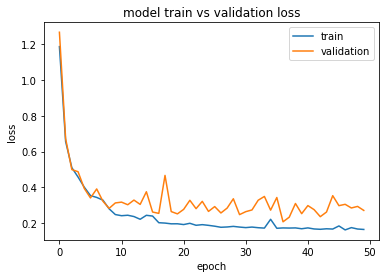

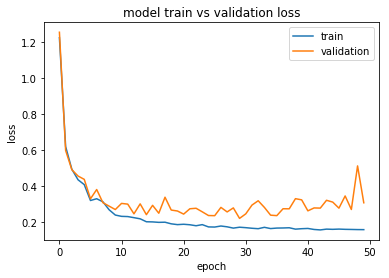

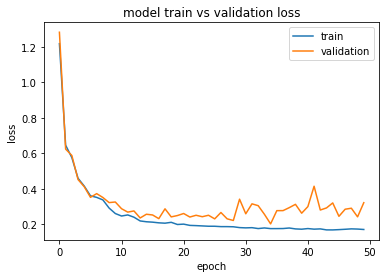

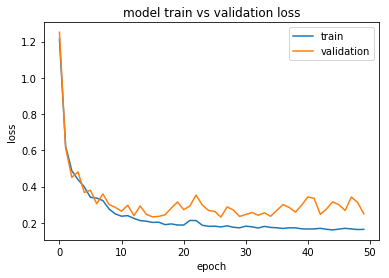

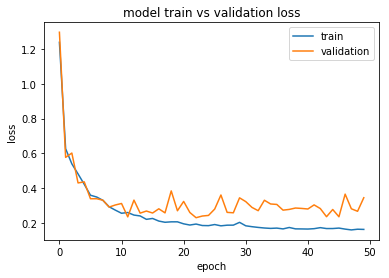

In [12]:
# plot train and validation loss
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

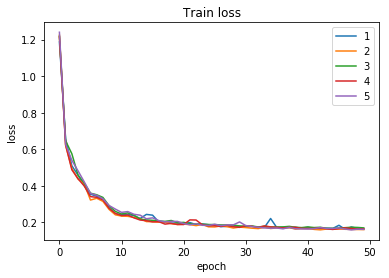

In [13]:
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

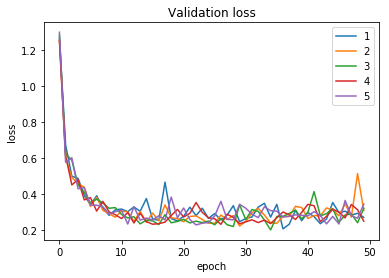

In [14]:
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

In [15]:
result_record_f1 = pd.DataFrame.from_dict(data=result_f1, orient='index')
result_record_f1 = np.mean(np.array(result_record_f1), axis = 0)
result_record_f1 = result_record_f1.reshape(-1)

result_record_acc = pd.DataFrame.from_dict(data=result_acc, orient='index')
result_record_acc = np.mean(np.array(result_record_acc), axis = 0)
result_record_acc = result_record_acc.reshape(-1)

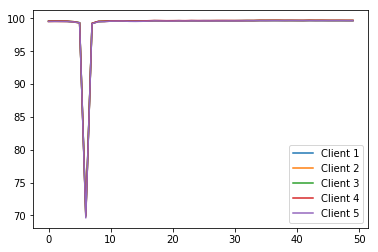

In [16]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_acc[i], label = 'Client '+ str(i+1))
plt.legend()
plt.show()

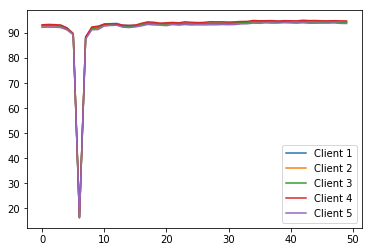

In [17]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_f1[i], label =  'Client '+ str(i+1))
plt.legend()
plt.show()